<a href="https://colab.research.google.com/github/ChiccoSy/BERT_Based_Multiclass_Text_Classification/blob/main/BERT_Multiclass_Text_Classification_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install necessary libraries
!pip install transformers
!pip install torch
!pip install scikit-learn
!pip install nltk
!pip install beautifulsoup4
!pip install contractions
!pip install plotly

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3108, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2901, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 377, in run
    requirement_set = resolver.resolve(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 

In [ ]:
# Experiment 1 - BatchSize-16, Epoch-1, Learning Rate-1e-5
import pandas as pd
import numpy as np
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from bs4 import BeautifulSoup  # For removing HTML tags
from contractions import contractions_dict  # You may need to install the contractions library

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')  # Add this line to download the 'punkt' resource

# Load data
file_path = "/content/drive/MyDrive/Dissertation_UC/UAQTE_Experience_Multi_Class_TC_Datasets.csv"
df = pd.read_csv(file_path)

# Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Expand contractions
    text = ' '.join([contractions_dict.get(word, word) for word in text.split()])

    # Remove irrelevant characters, symbols, and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]

    # Join tokens back into a string
    text = ' '.join(tokens)

    return text

df['Processed_Response'] = df['Responses'].apply(preprocess_text)

# Print 10 preprocessed responses
print(df['Processed_Response'].head(10))

# Encode labels
label_encoder = LabelEncoder()
df['Encoded_Label'] = label_encoder.fit_transform(df['Label'])

# Split the data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_text(df, max_length=128):
    input_ids = []
    attention_masks = []

    for text in df['Processed_Response']:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt',
                            truncation=True
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

train_inputs, train_masks = tokenize_text(train_df)
val_inputs, val_masks = tokenize_text(val_df)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_df['Encoded_Label'].values)
val_labels = torch.tensor(val_df['Encoded_Label'].values)

# Create DataLoader for training and validation sets
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Fine-tune BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Add optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)
epochs = 1
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds_train = []
    all_labels_train = []

    for batch in train_dataloader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        preds = np.argmax(logits.detach().numpy(), axis=1)

        correct_predictions += np.sum(preds == labels.numpy())
        total_samples += len(labels)

        all_preds_train.extend(preds.tolist())
        all_labels_train.extend(labels.numpy().tolist())

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print average training loss and accuracy for the batch
        avg_train_loss = total_loss / (total_samples / batch_size)
        train_accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1}/{epochs}, Batch Loss: {loss.item()}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Training classification report
    train_classification_report = classification_report(all_labels_train, all_preds_train, target_names=label_encoder.classes_)
    print('Training Classification Report:')
    print(train_classification_report)

    # Training confusion matrix
    train_conf_matrix = confusion_matrix(all_labels_train, all_preds_train)
    print('Training Confusion Matrix:')
    print(train_conf_matrix)

    # Validation
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    for batch in val_dataloader:
        inputs, masks, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        val_loss += loss.item()

        preds = np.argmax(logits.detach().numpy(), axis=1)
        predictions.extend(preds)
        true_labels.extend(labels.numpy())

    # Calculate validation accuracy and other metrics
    val_accuracy = accuracy_score(true_labels, predictions)
    val_classification_report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)

    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
    print('Validation Classification Report:')
    print(val_classification_report)

    # Validation confusion matrix
    val_conf_matrix = confusion_matrix(true_labels, predictions)
    print('Validation Confusion Matrix:')
    print(val_conf_matrix)

# Load and preprocess the test data
test_file_path = "/content/drive/MyDrive/Dissertation_UC/Testing-Dataset-Experience.csv"
test_df = pd.read_csv(test_file_path)
test_df['Processed_Response'] = test_df['Responses'].apply(preprocess_text)

# Tokenize test data
test_inputs, test_masks = tokenize_text(test_df)

# Make predictions on test data
model.eval()
test_predictions = []

for batch in DataLoader(TensorDataset(test_inputs, test_masks), batch_size=batch_size):
    inputs, masks = batch
    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
    logits = outputs.logits
    preds = np.argmax(logits.detach().numpy(), axis=1)
    test_predictions.extend(preds)

# Map predictions back to labels
test_df['Predicted Labels'] = label_encoder.inverse_transform(test_predictions)

# Compute test accuracy
test_labels = label_encoder.transform(test_df['True Labels'])
test_accuracy = accuracy_score(test_labels, test_predictions)

# Display test accuracy
print(f'Test Accuracy: {test_accuracy}')

# Calculate other metrics (precision, recall, F1 score, confusion matrix)
test_classification_report = classification_report(test_labels, test_predictions, target_names=label_encoder.classes_)
test_confusion_matrix = confusion_matrix(test_labels, test_predictions)

# Display other metrics
print('Test Classification Report:')
print(test_classification_report)
print('Test Confusion Matrix:')
print(test_confusion_matrix)

# Save predictions to a new CSV file
predicted_csv_path = "/content/drive/MyDrive/Dissertation_UC/predicted.csv"
test_df.to_csv(predicted_csv_path, index=False)

# Display a message indicating that the file has been saved
print(f'Predicted labels saved to {predicted_csv_path}')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-8-ab2b2b907172>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


0    focused studying much think could pay tuition fee
1            also helped become responsible many thing
2    every student help make thier dream become pos...
3           became serious studying fail graduate time
4    experience free funded material module make st...
5      program made possible continue studying college
6      scholarship serve stepping stone onward success
7    help finish study without worrying tuition als...
8    need worry financial expense allowance tuition...
9    one beneficiary made lot enthusiastic came cla...
Name: Processed_Response, dtype: object


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/1, Batch Loss: 1.5851480960845947, Average Training Loss: 1.5851480960845947, Training Accuracy: 0.1875
Epoch 1/1, Batch Loss: 1.6132895946502686, Average Training Loss: 1.5992188453674316, Training Accuracy: 0.25
Epoch 1/1, Batch Loss: 1.6010040044784546, Average Training Loss: 1.5998138984044392, Training Accuracy: 0.22916666666666666
Epoch 1/1, Batch Loss: 1.5926491022109985, Average Training Loss: 1.598022699356079, Training Accuracy: 0.1875
Epoch 1/1, Batch Loss: 1.556083083152771, Average Training Loss: 1.5896347761154175, Training Accuracy: 0.2
Epoch 1/1, Batch Loss: 1.6296703815460205, Average Training Loss: 1.596307377020518, Training Accuracy: 0.19791666666666666
Epoch 1/1, Batch Loss: 1.5443929433822632, Average Training Loss: 1.5888910293579102, Training Accuracy: 0.21428571428571427
Epoch 1/1, Batch Loss: 1.6448177099227905, Average Training Loss: 1.5958818644285202, Training Accuracy: 0.2265625
Epoch 1/1, Batch Loss: 1.559369683265686, Average Training Loss: 1.591

<ipython-input-8-ab2b2b907172>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


Test Accuracy: 0.48120300751879697
Test Classification Report:
                                         precision    recall  f1-score   support

Academic Focus and Personal Development       0.55      0.35      0.43       132
                Educational Opportunity       0.40      0.46      0.43       138
                         Family Support       0.48      0.93      0.63       133
                      Financial Support       0.65      0.25      0.36       130
                 Program Implementation       0.49      0.41      0.45       132

                               accuracy                           0.48       665
                              macro avg       0.51      0.48      0.46       665
                           weighted avg       0.51      0.48      0.46       665

Test Confusion Matrix:
[[ 46  32  28   3  23]
 [ 17  64  28   9  20]
 [  2   4 124   0   3]
 [  5  20  63  32  10]
 [ 13  42  18   5  54]]
Predicted labels saved to /content/drive/MyDrive/Dissertation_UC/p

In [ ]:
# Experiment 2 - BatchSize-16, Epoch-1, Learning Rate-1e-5
import pandas as pd
import numpy as np
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from bs4 import BeautifulSoup  # For removing HTML tags
from contractions import contractions_dict  # You may need to install the contractions library

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')  # Add this line to download the 'punkt' resource

# Load data
file_path = "/content/drive/MyDrive/Dissertation_UC/UAQTE_Experience_Multi_Class_TC_Datasets.csv"
df = pd.read_csv(file_path)

# Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Expand contractions
    text = ' '.join([contractions_dict.get(word, word) for word in text.split()])

    # Remove irrelevant characters, symbols, and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]

    # Join tokens back into a string
    text = ' '.join(tokens)

    return text

df['Processed_Response'] = df['Responses'].apply(preprocess_text)

# Print 10 preprocessed responses
print(df['Processed_Response'].head(10))

# Encode labels
label_encoder = LabelEncoder()
df['Encoded_Label'] = label_encoder.fit_transform(df['Label'])

# Split the data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_text(df, max_length=256):
    input_ids = []
    attention_masks = []

    for text in df['Processed_Response']:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt',
                            truncation=True
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

train_inputs, train_masks = tokenize_text(train_df)
val_inputs, val_masks = tokenize_text(val_df)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_df['Encoded_Label'].values)
val_labels = torch.tensor(val_df['Encoded_Label'].values)

# Create DataLoader for training and validation sets
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Fine-tune BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Add optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)
epochs = 1
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds_train = []
    all_labels_train = []

    for batch in train_dataloader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        preds = np.argmax(logits.detach().numpy(), axis=1)

        correct_predictions += np.sum(preds == labels.numpy())
        total_samples += len(labels)

        all_preds_train.extend(preds.tolist())
        all_labels_train.extend(labels.numpy().tolist())

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print average training loss and accuracy for the batch
        avg_train_loss = total_loss / (total_samples / batch_size)
        train_accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1}/{epochs}, Batch Loss: {loss.item()}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Training classification report
    train_classification_report = classification_report(all_labels_train, all_preds_train, target_names=label_encoder.classes_)
    print('Training Classification Report:')
    print(train_classification_report)

    # Training confusion matrix
    train_conf_matrix = confusion_matrix(all_labels_train, all_preds_train)
    print('Training Confusion Matrix:')
    print(train_conf_matrix)

    # Validation
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    for batch in val_dataloader:
        inputs, masks, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        val_loss += loss.item()

        preds = np.argmax(logits.detach().numpy(), axis=1)
        predictions.extend(preds)
        true_labels.extend(labels.numpy())

    # Calculate validation accuracy and other metrics
    val_accuracy = accuracy_score(true_labels, predictions)
    val_classification_report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)

    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
    print('Validation Classification Report:')
    print(val_classification_report)

    # Validation confusion matrix
    val_conf_matrix = confusion_matrix(true_labels, predictions)
    print('Validation Confusion Matrix:')
    print(val_conf_matrix)

# Load and preprocess the test data
test_file_path = "/content/drive/MyDrive/Dissertation_UC/Testing-Dataset-Experience.csv"
test_df = pd.read_csv(test_file_path)
test_df['Processed_Response'] = test_df['Responses'].apply(preprocess_text)

# Tokenize test data
test_inputs, test_masks = tokenize_text(test_df)

# Make predictions on test data
model.eval()
test_predictions = []

for batch in DataLoader(TensorDataset(test_inputs, test_masks), batch_size=batch_size):
    inputs, masks = batch
    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
    logits = outputs.logits
    preds = np.argmax(logits.detach().numpy(), axis=1)
    test_predictions.extend(preds)

# Map predictions back to labels
test_df['Predicted Labels'] = label_encoder.inverse_transform(test_predictions)

# Compute test accuracy
test_labels = label_encoder.transform(test_df['True Labels'])
test_accuracy = accuracy_score(test_labels, test_predictions)

# Display test accuracy
print(f'Test Accuracy: {test_accuracy}')

# Calculate other metrics (precision, recall, F1 score, confusion matrix)
test_classification_report = classification_report(test_labels, test_predictions, target_names=label_encoder.classes_)
test_confusion_matrix = confusion_matrix(test_labels, test_predictions)

# Display other metrics
print('Test Classification Report:')
print(test_classification_report)
print('Test Confusion Matrix:')
print(test_confusion_matrix)

# Save predictions to a new CSV file
predicted_csv_path = "/content/drive/MyDrive/Dissertation_UC/predicted2.csv"
test_df.to_csv(predicted_csv_path, index=False)

# Display a message indicating that the file has been saved
print(f'Predicted labels saved to {predicted_csv_path}')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-9-13fa21934a96>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


0    focused studying much think could pay tuition fee
1            also helped become responsible many thing
2    every student help make thier dream become pos...
3           became serious studying fail graduate time
4    experience free funded material module make st...
5      program made possible continue studying college
6      scholarship serve stepping stone onward success
7    help finish study without worrying tuition als...
8    need worry financial expense allowance tuition...
9    one beneficiary made lot enthusiastic came cla...
Name: Processed_Response, dtype: object


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/1, Batch Loss: 1.912186861038208, Average Training Loss: 1.912186861038208, Training Accuracy: 0.1875
Epoch 1/1, Batch Loss: 1.6133382320404053, Average Training Loss: 1.7627625465393066, Training Accuracy: 0.21875
Epoch 1/1, Batch Loss: 1.5501891374588013, Average Training Loss: 1.6919047435124714, Training Accuracy: 0.2708333333333333
Epoch 1/1, Batch Loss: 1.6420485973358154, Average Training Loss: 1.6794407069683075, Training Accuracy: 0.25
Epoch 1/1, Batch Loss: 1.6679381132125854, Average Training Loss: 1.677140188217163, Training Accuracy: 0.225
Epoch 1/1, Batch Loss: 1.570081114768982, Average Training Loss: 1.6592970093091328, Training Accuracy: 0.23958333333333334
Epoch 1/1, Batch Loss: 1.6604325771331787, Average Training Loss: 1.6594592332839966, Training Accuracy: 0.21428571428571427
Epoch 1/1, Batch Loss: 1.5485817193984985, Average Training Loss: 1.6455995440483093, Training Accuracy: 0.2265625
Epoch 1/1, Batch Loss: 1.670699119567871, Average Training Loss: 1.64

<ipython-input-9-13fa21934a96>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


Test Accuracy: 0.518796992481203
Test Classification Report:
                                         precision    recall  f1-score   support

Academic Focus and Personal Development       0.53      0.64      0.58       132
                Educational Opportunity       0.42      0.52      0.46       138
                         Family Support       0.56      0.92      0.70       133
                      Financial Support       0.52      0.33      0.40       130
                 Program Implementation       0.71      0.18      0.29       132

                               accuracy                           0.52       665
                              macro avg       0.55      0.52      0.49       665
                           weighted avg       0.55      0.52      0.49       665

Test Confusion Matrix:
[[ 84  24  13  10   1]
 [ 33  72  13  14   6]
 [  3   8 122   0   0]
 [ 15  23  46  43   3]
 [ 24  45  23  16  24]]
Predicted labels saved to /content/drive/MyDrive/Dissertation_UC/pre

In [ ]:
# Experiment 2 - BatchSize-16, Epoch-1, Learning Rate-1e-5
import pandas as pd
import numpy as np
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from bs4 import BeautifulSoup  # For removing HTML tags
from contractions import contractions_dict

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')  # Add this line to download the 'punkt' resource

# Load data
file_path = "/content/drive/MyDrive/Dissertation_UC/UAQTE_Experience_Multi_Class_TC_Datasets.csv"
df = pd.read_csv(file_path)

# Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Expand contractions
    text = ' '.join([contractions_dict.get(word, word) for word in text.split()])

    # Remove irrelevant characters, symbols, and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]

    # Join tokens back into a string
    text = ' '.join(tokens)

    return text

df['Processed_Response'] = df['Responses'].apply(preprocess_text)

# Print 10 preprocessed responses
print(df['Processed_Response'].head(10))

# Encode labels
label_encoder = LabelEncoder()
df['Encoded_Label'] = label_encoder.fit_transform(df['Label'])

# Split the data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_text(df, max_length=128):
    input_ids = []
    attention_masks = []

    for text in df['Processed_Response']:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt',
                            truncation=True
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

train_inputs, train_masks = tokenize_text(train_df)
val_inputs, val_masks = tokenize_text(val_df)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_df['Encoded_Label'].values)
val_labels = torch.tensor(val_df['Encoded_Label'].values)

# Create DataLoader for training and validation sets
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Fine-tune BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Add optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)
epochs = 1
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds_train = []
    all_labels_train = []

    for batch in train_dataloader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        preds = np.argmax(logits.detach().numpy(), axis=1)

        correct_predictions += np.sum(preds == labels.numpy())
        total_samples += len(labels)

        all_preds_train.extend(preds.tolist())
        all_labels_train.extend(labels.numpy().tolist())

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print average training loss and accuracy for the batch
        avg_train_loss = total_loss / (total_samples / batch_size)
        train_accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1}/{epochs}, Batch Loss: {loss.item()}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Training classification report
    train_classification_report = classification_report(all_labels_train, all_preds_train, target_names=label_encoder.classes_)
    print('Training Classification Report:')
    print(train_classification_report)

    # Training confusion mat  rix
    train_conf_matrix = confusion_matrix(all_labels_train, all_preds_train)
    print('Training Confusion Matrix:')
    print(train_conf_matrix)

    # Validation
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    for batch in val_dataloader:
        inputs, masks, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        val_loss += loss.item()

        preds = np.argmax(logits.detach().numpy(), axis=1)
        predictions.extend(preds)
        true_labels.extend(labels.numpy())

    # Calculate validation accuracy and other metrics
    val_accuracy = accuracy_score(true_labels, predictions)
    val_classification_report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)

    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
    print('Validation Classification Report:')
    print(val_classification_report)

    # Validation confusion matrix
    val_conf_matrix = confusion_matrix(true_labels, predictions)
    print('Validation Confusion Matrix:')
    print(val_conf_matrix)

# Load and preprocess the test data
test_file_path = "/content/drive/MyDrive/Dissertation_UC/Testing-Dataset-Experience.csv"
test_df = pd.read_csv(test_file_path)
test_df['Processed_Response'] = test_df['Responses'].apply(preprocess_text)

# Tokenize test data
test_inputs, test_masks = tokenize_text(test_df)

# Make predictions on test data
model.eval()
test_predictions = []

for batch in DataLoader(TensorDataset(test_inputs, test_masks), batch_size=batch_size):
    inputs, masks = batch
    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
    logits = outputs.logits
    preds = np.argmax(logits.detach().numpy(), axis=1)
    test_predictions.extend(preds)

# Map predictions back to labels
test_df['Predicted Labels'] = label_encoder.inverse_transform(test_predictions)

# Compute test accuracy
test_labels = label_encoder.transform(test_df['True Labels'])
test_accuracy = accuracy_score(test_labels, test_predictions)

# Display test accuracy
print(f'Test Accuracy: {test_accuracy}')

# Calculate other metrics (precision, recall, F1 score, confusion matrix)
test_classification_report = classification_report(test_labels, test_predictions, target_names=label_encoder.classes_)
test_confusion_matrix = confusion_matrix(test_labels, test_predictions)

# Display other metrics
print('Test Classification Report:')
print(test_classification_report)
print('Test Confusion Matrix:')
print(test_confusion_matrix)

# Save predictions to a new CSV file
predicted_csv_path = "/content/drive/MyDrive/Dissertation_UC/predicted3.csv"
test_df.to_csv(predicted_csv_path, index=False)

# Display a message indicating that the file has been saved
print(f'Predicted labels saved to {predicted_csv_path}')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-10-50ecbe560937>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


0    focused studying much think could pay tuition fee
1            also helped become responsible many thing
2    every student help make thier dream become pos...
3           became serious studying fail graduate time
4    experience free funded material module make st...
5      program made possible continue studying college
6      scholarship serve stepping stone onward success
7    help finish study without worrying tuition als...
8    need worry financial expense allowance tuition...
9    one beneficiary made lot enthusiastic came cla...
Name: Processed_Response, dtype: object


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/1, Batch Loss: 1.5755701065063477, Average Training Loss: 1.5755701065063477, Training Accuracy: 0.34375
Epoch 1/1, Batch Loss: 1.7390023469924927, Average Training Loss: 1.6572862267494202, Training Accuracy: 0.21875
Epoch 1/1, Batch Loss: 1.5718094110488892, Average Training Loss: 1.6287939548492432, Training Accuracy: 0.22916666666666666
Epoch 1/1, Batch Loss: 1.5927045345306396, Average Training Loss: 1.6197715997695923, Training Accuracy: 0.2265625
Epoch 1/1, Batch Loss: 1.5861769914627075, Average Training Loss: 1.6130526781082153, Training Accuracy: 0.23125
Epoch 1/1, Batch Loss: 1.5841134786605835, Average Training Loss: 1.6082294782002766, Training Accuracy: 0.23958333333333334
Epoch 1/1, Batch Loss: 1.5502145290374756, Average Training Loss: 1.5999416283198766, Training Accuracy: 0.24553571428571427
Epoch 1/1, Batch Loss: 1.6502476930618286, Average Training Loss: 1.6062298864126205, Training Accuracy: 0.25
Epoch 1/1, Batch Loss: 1.5569162368774414, Average Training L

<ipython-input-10-50ecbe560937>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


Test Accuracy: 0.45112781954887216
Test Classification Report:
                                         precision    recall  f1-score   support

Academic Focus and Personal Development       0.43      0.72      0.54       132
                Educational Opportunity       0.34      0.33      0.33       138
                         Family Support       0.50      0.67      0.57       133
                      Financial Support       0.48      0.24      0.32       130
                 Program Implementation       0.61      0.30      0.40       132

                               accuracy                           0.45       665
                              macro avg       0.47      0.45      0.43       665
                           weighted avg       0.47      0.45      0.43       665

Test Confusion Matrix:
[[95 12  7 10  8]
 [54 45 26  6  7]
 [14 20 89  7  3]
 [17 30 44 31  8]
 [43 27 12 10 40]]
Predicted labels saved to /content/drive/MyDrive/Dissertation_UC/predicted3.csv


In [ ]:
# Experiment 2 - BatchSize-16, Epoch-1, Learning Rate-1e-5
import pandas as pd
import numpy as np
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from bs4 import BeautifulSoup  # For removing HTML tags
from contractions import contractions_dict  # You may need to install the contractions library

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')  # Add this line to download the 'punkt' resource

# Load data
file_path = "/content/drive/MyDrive/Dissertation_UC/UAQTE_Experience_Multi_Class_TC_Datasets.csv"
df = pd.read_csv(file_path)

# Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Expand contractions
    text = ' '.join([contractions_dict.get(word, word) for word in text.split()])

    # Remove irrelevant characters, symbols, and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]

    # Join tokens back into a string
    text = ' '.join(tokens)

    return text

df['Processed_Response'] = df['Responses'].apply(preprocess_text)

# Print 10 preprocessed responses
print(df['Processed_Response'].head(10))

# Encode labels
label_encoder = LabelEncoder()
df['Encoded_Label'] = label_encoder.fit_transform(df['Label'])

# Split the data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_text(df, max_length=256):
    input_ids = []
    attention_masks = []

    for text in df['Processed_Response']:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt',
                            truncation=True
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

train_inputs, train_masks = tokenize_text(train_df)
val_inputs, val_masks = tokenize_text(val_df)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_df['Encoded_Label'].values)
val_labels = torch.tensor(val_df['Encoded_Label'].values)

# Create DataLoader for training and validation sets
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Fine-tune BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Add optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)
epochs = 1
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds_train = []
    all_labels_train = []

    for batch in train_dataloader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        preds = np.argmax(logits.detach().numpy(), axis=1)

        correct_predictions += np.sum(preds == labels.numpy())
        total_samples += len(labels)

        all_preds_train.extend(preds.tolist())
        all_labels_train.extend(labels.numpy().tolist())

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print average training loss and accuracy for the batch
        avg_train_loss = total_loss / (total_samples / batch_size)
        train_accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1}/{epochs}, Batch Loss: {loss.item()}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Training classification report
    train_classification_report = classification_report(all_labels_train, all_preds_train, target_names=label_encoder.classes_)
    print('Training Classification Report:')
    print(train_classification_report)

    # Training confusion matrix
    train_conf_matrix = confusion_matrix(all_labels_train, all_preds_train)
    print('Training Confusion Matrix:')
    print(train_conf_matrix)

    # Validation
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    for batch in val_dataloader:
        inputs, masks, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        val_loss += loss.item()

        preds = np.argmax(logits.detach().numpy(), axis=1)
        predictions.extend(preds)
        true_labels.extend(labels.numpy())

    # Calculate validation accuracy and other metrics
    val_accuracy = accuracy_score(true_labels, predictions)
    val_classification_report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)

    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
    print('Validation Classification Report:')
    print(val_classification_report)

    # Validation confusion matrix
    val_conf_matrix = confusion_matrix(true_labels, predictions)
    print('Validation Confusion Matrix:')
    print(val_conf_matrix)

# Load and preprocess the test data
test_file_path = "/content/drive/MyDrive/Dissertation_UC/Testing-Dataset-Experience.csv"
test_df = pd.read_csv(test_file_path)
test_df['Processed_Response'] = test_df['Responses'].apply(preprocess_text)

# Tokenize test data
test_inputs, test_masks = tokenize_text(test_df)

# Make predictions on test data
model.eval()
test_predictions = []

for batch in DataLoader(TensorDataset(test_inputs, test_masks), batch_size=batch_size):
    inputs, masks = batch
    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
    logits = outputs.logits
    preds = np.argmax(logits.detach().numpy(), axis=1)
    test_predictions.extend(preds)

# Map predictions back to labels
test_df['Predicted Labels'] = label_encoder.inverse_transform(test_predictions)

# Compute test accuracy
test_labels = label_encoder.transform(test_df['True Labels'])
test_accuracy = accuracy_score(test_labels, test_predictions)

# Display test accuracy
print(f'Test Accuracy: {test_accuracy}')

# Calculate other metrics (precision, recall, F1 score, confusion matrix)
test_classification_report = classification_report(test_labels, test_predictions, target_names=label_encoder.classes_)
test_confusion_matrix = confusion_matrix(test_labels, test_predictions)

# Display other metrics
print('Test Classification Report:')
print(test_classification_report)
print('Test Confusion Matrix:')
print(test_confusion_matrix)

# Save predictions to a new CSV file
predicted_csv_path = "/content/drive/MyDrive/Dissertation_UC/predicted4.csv"
test_df.to_csv(predicted_csv_path, index=False)

# Display a message indicating that the file has been saved
print(f'Predicted labels saved to {predicted_csv_path}')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-11-503aafcef985>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


0    focused studying much think could pay tuition fee
1            also helped become responsible many thing
2    every student help make thier dream become pos...
3           became serious studying fail graduate time
4    experience free funded material module make st...
5      program made possible continue studying college
6      scholarship serve stepping stone onward success
7    help finish study without worrying tuition als...
8    need worry financial expense allowance tuition...
9    one beneficiary made lot enthusiastic came cla...
Name: Processed_Response, dtype: object


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/1, Batch Loss: 1.6642484664916992, Average Training Loss: 1.6642484664916992, Training Accuracy: 0.28125
Epoch 1/1, Batch Loss: 1.683800220489502, Average Training Loss: 1.6740243434906006, Training Accuracy: 0.234375
Epoch 1/1, Batch Loss: 1.5910793542861938, Average Training Loss: 1.6463760137557983, Training Accuracy: 0.25
Epoch 1/1, Batch Loss: 1.6688189506530762, Average Training Loss: 1.6519867479801178, Training Accuracy: 0.234375
Epoch 1/1, Batch Loss: 1.6126110553741455, Average Training Loss: 1.6441116094589234, Training Accuracy: 0.23125
Epoch 1/1, Batch Loss: 1.6222337484359741, Average Training Loss: 1.6404652992884319, Training Accuracy: 0.234375
Epoch 1/1, Batch Loss: 1.706437349319458, Average Training Loss: 1.6498898778642928, Training Accuracy: 0.22321428571428573
Epoch 1/1, Batch Loss: 1.6531956195831299, Average Training Loss: 1.6503030955791473, Training Accuracy: 0.21484375
Epoch 1/1, Batch Loss: 1.605865478515625, Average Training Loss: 1.6453655825720892

<ipython-input-11-503aafcef985>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


Test Accuracy: 0.3233082706766917
Test Classification Report:
                                         precision    recall  f1-score   support

Academic Focus and Personal Development       0.25      0.01      0.01       132
                Educational Opportunity       0.38      0.22      0.28       138
                         Family Support       0.33      0.94      0.49       133
                      Financial Support       0.29      0.45      0.35       130
                 Program Implementation       1.00      0.01      0.02       132

                               accuracy                           0.32       665
                              macro avg       0.45      0.32      0.23       665
                           weighted avg       0.45      0.32      0.23       665

Test Confusion Matrix:
[[  1  12  89  30   0]
 [  2  30  67  39   0]
 [  0   1 125   7   0]
 [  0  19  53  58   0]
 [  1  16  45  69   1]]
Predicted labels saved to /content/drive/MyDrive/Dissertation_UC/pr

In [ ]:
# Experiment 2 - BatchSize-16, Epoch-1, Learning Rate-1e-5
import pandas as pd
import numpy as np
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from bs4 import BeautifulSoup  # For removing HTML tags
from contractions import contractions_dict  # You may need to install the contractions library

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')  # Add this line to download the 'punkt' resource

# Load data
file_path = "/content/drive/MyDrive/Dissertation_UC/UAQTE_Experience_Multi_Class_TC_Datasets.csv"
df = pd.read_csv(file_path)

# Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Expand contractions
    text = ' '.join([contractions_dict.get(word, word) for word in text.split()])

    # Remove irrelevant characters, symbols, and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]

    # Join tokens back into a string
    text = ' '.join(tokens)

    return text

df['Processed_Response'] = df['Responses'].apply(preprocess_text)

# Print 10 preprocessed responses
print(df['Processed_Response'].head(10))

# Encode labels
label_encoder = LabelEncoder()
df['Encoded_Label'] = label_encoder.fit_transform(df['Label'])

# Split the data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_text(df, max_length=128):
    input_ids = []
    attention_masks = []

    for text in df['Processed_Response']:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt',
                            truncation=True
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

train_inputs, train_masks = tokenize_text(train_df)
val_inputs, val_masks = tokenize_text(val_df)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_df['Encoded_Label'].values)
val_labels = torch.tensor(val_df['Encoded_Label'].values)

# Create DataLoader for training and validation sets
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Fine-tune BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Add optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 1
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds_train = []
    all_labels_train = []

    for batch in train_dataloader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        preds = np.argmax(logits.detach().numpy(), axis=1)

        correct_predictions += np.sum(preds == labels.numpy())
        total_samples += len(labels)

        all_preds_train.extend(preds.tolist())
        all_labels_train.extend(labels.numpy().tolist())

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print average training loss and accuracy for the batch
        avg_train_loss = total_loss / (total_samples / batch_size)
        train_accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1}/{epochs}, Batch Loss: {loss.item()}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Training classification report
    train_classification_report = classification_report(all_labels_train, all_preds_train, target_names=label_encoder.classes_)
    print('Training Classification Report:')
    print(train_classification_report)

    # Training confusion matrix
    train_conf_matrix = confusion_matrix(all_labels_train, all_preds_train)
    print('Training Confusion Matrix:')
    print(train_conf_matrix)

    # Validation
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    for batch in val_dataloader:
        inputs, masks, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        val_loss += loss.item()

        preds = np.argmax(logits.detach().numpy(), axis=1)
        predictions.extend(preds)
        true_labels.extend(labels.numpy())

    # Calculate validation accuracy and other metrics
    val_accuracy = accuracy_score(true_labels, predictions)
    val_classification_report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)

    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
    print('Validation Classification Report:')
    print(val_classification_report)

    # Validation confusion matrix
    val_conf_matrix = confusion_matrix(true_labels, predictions)
    print('Validation Confusion Matrix:')
    print(val_conf_matrix)

# Load and preprocess the test data
test_file_path = "/content/drive/MyDrive/Dissertation_UC/Testing-Dataset-Experience.csv"
test_df = pd.read_csv(test_file_path)
test_df['Processed_Response'] = test_df['Responses'].apply(preprocess_text)

# Tokenize test data
test_inputs, test_masks = tokenize_text(test_df)

# Make predictions on test data
model.eval()
test_predictions = []

for batch in DataLoader(TensorDataset(test_inputs, test_masks), batch_size=batch_size):
    inputs, masks = batch
    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
    logits = outputs.logits
    preds = np.argmax(logits.detach().numpy(), axis=1)
    test_predictions.extend(preds)

# Map predictions back to labels
test_df['Predicted Labels'] = label_encoder.inverse_transform(test_predictions)

# Compute test accuracy
test_labels = label_encoder.transform(test_df['True Labels'])
test_accuracy = accuracy_score(test_labels, test_predictions)

# Display test accuracy
print(f'Test Accuracy: {test_accuracy}')

# Calculate other metrics (precision, recall, F1 score, confusion matrix)
test_classification_report = classification_report(test_labels, test_predictions, target_names=label_encoder.classes_)
test_confusion_matrix = confusion_matrix(test_labels, test_predictions)

# Display other metrics
print('Test Classification Report:')
print(test_classification_report)
print('Test Confusion Matrix:')
print(test_confusion_matrix)

# Save predictions to a new CSV file
predicted_csv_path = "/content/drive/MyDrive/Dissertation_UC/predicted5.csv"
test_df.to_csv(predicted_csv_path, index=False)

# Display a message indicating that the file has been saved
print(f'Predicted labels saved to {predicted_csv_path}')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-13-481c4aa40a32>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


0    focused studying much think could pay tuition fee
1            also helped become responsible many thing
2    every student help make thier dream become pos...
3           became serious studying fail graduate time
4    experience free funded material module make st...
5      program made possible continue studying college
6      scholarship serve stepping stone onward success
7    help finish study without worrying tuition als...
8    need worry financial expense allowance tuition...
9    one beneficiary made lot enthusiastic came cla...
Name: Processed_Response, dtype: object


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/1, Batch Loss: 1.5383453369140625, Average Training Loss: 1.5383453369140625, Training Accuracy: 0.25
Epoch 1/1, Batch Loss: 1.5334725379943848, Average Training Loss: 1.5359089374542236, Training Accuracy: 0.25
Epoch 1/1, Batch Loss: 1.6642963886260986, Average Training Loss: 1.5787047545115154, Training Accuracy: 0.20833333333333334
Epoch 1/1, Batch Loss: 1.572795033454895, Average Training Loss: 1.5772273242473602, Training Accuracy: 0.21875
Epoch 1/1, Batch Loss: 1.677490234375, Average Training Loss: 1.5972799062728882, Training Accuracy: 0.2125
Epoch 1/1, Batch Loss: 1.8242056369781494, Average Training Loss: 1.6351008613904316, Training Accuracy: 0.1875
Epoch 1/1, Batch Loss: 1.7430315017700195, Average Training Loss: 1.6505195243018014, Training Accuracy: 0.17857142857142858
Epoch 1/1, Batch Loss: 1.6506357192993164, Average Training Loss: 1.6505340486764908, Training Accuracy: 0.1875
Epoch 1/1, Batch Loss: 1.6482222080230713, Average Training Loss: 1.6502771774927776, 

<ipython-input-13-481c4aa40a32>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


Test Accuracy: 0.5759398496240602
Test Classification Report:
                                         precision    recall  f1-score   support

Academic Focus and Personal Development       0.61      0.55      0.57       132
                Educational Opportunity       0.40      0.59      0.47       138
                         Family Support       0.86      0.67      0.75       133
                      Financial Support       0.57      0.77      0.65       130
                 Program Implementation       0.66      0.31      0.42       132

                               accuracy                           0.58       665
                              macro avg       0.62      0.58      0.58       665
                           weighted avg       0.62      0.58      0.57       665

Test Confusion Matrix:
[[ 72  36   5  13   6]
 [ 20  81   0  31   6]
 [ 11  12  89  16   5]
 [  2  18   6 100   4]
 [ 14  58   3  16  41]]
Predicted labels saved to /content/drive/MyDrive/Dissertation_UC/pr

In [ ]:
# Experiment 2 - BatchSize-16, Epoch-1, Learning Rate-1e-5
import pandas as pd
import numpy as np
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from bs4 import BeautifulSoup  # For removing HTML tags
from contractions import contractions_dict  # You may need to install the contractions library

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')  # Add this line to download the 'punkt' resource

# Load data
file_path = "/content/drive/MyDrive/Dissertation_UC/UAQTE_Experience_Multi_Class_TC_Datasets.csv"
df = pd.read_csv(file_path)

# Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Expand contractions
    text = ' '.join([contractions_dict.get(word, word) for word in text.split()])

    # Remove irrelevant characters, symbols, and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]

    # Join tokens back into a string
    text = ' '.join(tokens)

    return text

df['Processed_Response'] = df['Responses'].apply(preprocess_text)

# Print 10 preprocessed responses
print(df['Processed_Response'].head(10))

# Encode labels
label_encoder = LabelEncoder()
df['Encoded_Label'] = label_encoder.fit_transform(df['Label'])

# Split the data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_text(df, max_length=256):
    input_ids = []
    attention_masks = []

    for text in df['Processed_Response']:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt',
                            truncation=True
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

train_inputs, train_masks = tokenize_text(train_df)
val_inputs, val_masks = tokenize_text(val_df)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_df['Encoded_Label'].values)
val_labels = torch.tensor(val_df['Encoded_Label'].values)

# Create DataLoader for training and validation sets
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Fine-tune BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Add optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 1
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds_train = []
    all_labels_train = []

    for batch in train_dataloader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        preds = np.argmax(logits.detach().numpy(), axis=1)

        correct_predictions += np.sum(preds == labels.numpy())
        total_samples += len(labels)

        all_preds_train.extend(preds.tolist())
        all_labels_train.extend(labels.numpy().tolist())

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print average training loss and accuracy for the batch
        avg_train_loss = total_loss / (total_samples / batch_size)
        train_accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1}/{epochs}, Batch Loss: {loss.item()}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Training classification report
    train_classification_report = classification_report(all_labels_train, all_preds_train, target_names=label_encoder.classes_)
    print('Training Classification Report:')
    print(train_classification_report)

    # Training confusion matrix
    train_conf_matrix = confusion_matrix(all_labels_train, all_preds_train)
    print('Training Confusion Matrix:')
    print(train_conf_matrix)

    # Validation
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    for batch in val_dataloader:
        inputs, masks, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        val_loss += loss.item()

        preds = np.argmax(logits.detach().numpy(), axis=1)
        predictions.extend(preds)
        true_labels.extend(labels.numpy())

    # Calculate validation accuracy and other metrics
    val_accuracy = accuracy_score(true_labels, predictions)
    val_classification_report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)

    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
    print('Validation Classification Report:')
    print(val_classification_report)

    # Validation confusion matrix
    val_conf_matrix = confusion_matrix(true_labels, predictions)
    print('Validation Confusion Matrix:')
    print(val_conf_matrix)

# Load and preprocess the test data
test_file_path = "/content/drive/MyDrive/Dissertation_UC/Testing-Dataset-Experience.csv"
test_df = pd.read_csv(test_file_path)
test_df['Processed_Response'] = test_df['Responses'].apply(preprocess_text)

# Tokenize test data
test_inputs, test_masks = tokenize_text(test_df)

# Make predictions on test data
model.eval()
test_predictions = []

for batch in DataLoader(TensorDataset(test_inputs, test_masks), batch_size=batch_size):
    inputs, masks = batch
    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
    logits = outputs.logits
    preds = np.argmax(logits.detach().numpy(), axis=1)
    test_predictions.extend(preds)

# Map predictions back to labels
test_df['Predicted Labels'] = label_encoder.inverse_transform(test_predictions)

# Compute test accuracy
test_labels = label_encoder.transform(test_df['True Labels'])
test_accuracy = accuracy_score(test_labels, test_predictions)

# Display test accuracy
print(f'Test Accuracy: {test_accuracy}')

# Calculate other metrics (precision, recall, F1 score, confusion matrix)
test_classification_report = classification_report(test_labels, test_predictions, target_names=label_encoder.classes_)
test_confusion_matrix = confusion_matrix(test_labels, test_predictions)

# Display other metrics
print('Test Classification Report:')
print(test_classification_report)
print('Test Confusion Matrix:')
print(test_confusion_matrix)

# Save predictions to a new CSV file
predicted_csv_path = "/content/drive/MyDrive/Dissertation_UC/predicted6.csv"
test_df.to_csv(predicted_csv_path, index=False)

# Display a message indicating that the file has been saved
print(f'Predicted labels saved to {predicted_csv_path}')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-14-ea400f7008fc>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


0    focused studying much think could pay tuition fee
1            also helped become responsible many thing
2    every student help make thier dream become pos...
3           became serious studying fail graduate time
4    experience free funded material module make st...
5      program made possible continue studying college
6      scholarship serve stepping stone onward success
7    help finish study without worrying tuition als...
8    need worry financial expense allowance tuition...
9    one beneficiary made lot enthusiastic came cla...
Name: Processed_Response, dtype: object


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/1, Batch Loss: 1.6485228538513184, Average Training Loss: 1.6485228538513184, Training Accuracy: 0.3125
Epoch 1/1, Batch Loss: 1.6022862195968628, Average Training Loss: 1.6254045367240906, Training Accuracy: 0.21875
Epoch 1/1, Batch Loss: 1.490191102027893, Average Training Loss: 1.5803333918253581, Training Accuracy: 0.22916666666666666
Epoch 1/1, Batch Loss: 1.6172677278518677, Average Training Loss: 1.5895669758319855, Training Accuracy: 0.234375
Epoch 1/1, Batch Loss: 1.7529734373092651, Average Training Loss: 1.6222482681274415, Training Accuracy: 0.2
Epoch 1/1, Batch Loss: 1.6338579654693604, Average Training Loss: 1.624183217684428, Training Accuracy: 0.20833333333333334
Epoch 1/1, Batch Loss: 1.5459039211273193, Average Training Loss: 1.6130004610334123, Training Accuracy: 0.21428571428571427
Epoch 1/1, Batch Loss: 1.6933552026748657, Average Training Loss: 1.623044803738594, Training Accuracy: 0.1953125
Epoch 1/1, Batch Loss: 1.6345125436782837, Average Training Loss:

<ipython-input-14-ea400f7008fc>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


Test Accuracy: 0.5729323308270676
Test Classification Report:
                                         precision    recall  f1-score   support

Academic Focus and Personal Development       0.64      0.52      0.57       132
                Educational Opportunity       0.43      0.58      0.50       138
                         Family Support       0.72      0.67      0.69       133
                      Financial Support       0.56      0.69      0.62       130
                 Program Implementation       0.61      0.41      0.49       132

                               accuracy                           0.57       665
                              macro avg       0.59      0.57      0.57       665
                           weighted avg       0.59      0.57      0.57       665

Test Confusion Matrix:
[[68 35  5 10 14]
 [18 80  3 23 14]
 [ 3 10 89 25  6]
 [ 2 16 21 90  1]
 [16 43  6 13 54]]
Predicted labels saved to /content/drive/MyDrive/Dissertation_UC/predicted6.csv


In [ ]:
# Experiment 2 - BatchSize-16, Epoch-1, Learning Rate-1e-5
import pandas as pd
import numpy as np
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from bs4 import BeautifulSoup  # For removing HTML tags
from contractions import contractions_dict  # You may need to install the contractions library

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')  # Add this line to download the 'punkt' resource

# Load data
file_path = "/content/drive/MyDrive/Dissertation_UC/UAQTE_Experience_Multi_Class_TC_Datasets.csv"
df = pd.read_csv(file_path)

# Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Expand contractions
    text = ' '.join([contractions_dict.get(word, word) for word in text.split()])

    # Remove irrelevant characters, symbols, and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]

    # Join tokens back into a string
    text = ' '.join(tokens)

    return text

df['Processed_Response'] = df['Responses'].apply(preprocess_text)

# Print 10 preprocessed responses
print(df['Processed_Response'].head(10))

# Encode labels
label_encoder = LabelEncoder()
df['Encoded_Label'] = label_encoder.fit_transform(df['Label'])

# Split the data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_text(df, max_length=128):
    input_ids = []
    attention_masks = []

    for text in df['Processed_Response']:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt',
                            truncation=True
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

train_inputs, train_masks = tokenize_text(train_df)
val_inputs, val_masks = tokenize_text(val_df)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_df['Encoded_Label'].values)
val_labels = torch.tensor(val_df['Encoded_Label'].values)

# Create DataLoader for training and validation sets
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Fine-tune BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Add optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 1
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds_train = []
    all_labels_train = []

    for batch in train_dataloader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        preds = np.argmax(logits.detach().numpy(), axis=1)

        correct_predictions += np.sum(preds == labels.numpy())
        total_samples += len(labels)

        all_preds_train.extend(preds.tolist())
        all_labels_train.extend(labels.numpy().tolist())

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print average training loss and accuracy for the batch
        avg_train_loss = total_loss / (total_samples / batch_size)
        train_accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1}/{epochs}, Batch Loss: {loss.item()}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Training classification report
    train_classification_report = classification_report(all_labels_train, all_preds_train, target_names=label_encoder.classes_)
    print('Training Classification Report:')
    print(train_classification_report)

    # Training confusion matrix
    train_conf_matrix = confusion_matrix(all_labels_train, all_preds_train)
    print('Training Confusion Matrix:')
    print(train_conf_matrix)

    # Validation
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    for batch in val_dataloader:
        inputs, masks, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        val_loss += loss.item()

        preds = np.argmax(logits.detach().numpy(), axis=1)
        predictions.extend(preds)
        true_labels.extend(labels.numpy())

    # Calculate validation accuracy and other metrics
    val_accuracy = accuracy_score(true_labels, predictions)
    val_classification_report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)

    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
    print('Validation Classification Report:')
    print(val_classification_report)

    # Validation confusion matrix
    val_conf_matrix = confusion_matrix(true_labels, predictions)
    print('Validation Confusion Matrix:')
    print(val_conf_matrix)

# Load and preprocess the test data
test_file_path = "/content/drive/MyDrive/Dissertation_UC/Testing-Dataset-Experience.csv"
test_df = pd.read_csv(test_file_path)
test_df['Processed_Response'] = test_df['Responses'].apply(preprocess_text)

# Tokenize test data
test_inputs, test_masks = tokenize_text(test_df)

# Make predictions on test data
model.eval()
test_predictions = []

for batch in DataLoader(TensorDataset(test_inputs, test_masks), batch_size=batch_size):
    inputs, masks = batch
    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
    logits = outputs.logits
    preds = np.argmax(logits.detach().numpy(), axis=1)
    test_predictions.extend(preds)

# Map predictions back to labels
test_df['Predicted Labels'] = label_encoder.inverse_transform(test_predictions)

# Compute test accuracy
test_labels = label_encoder.transform(test_df['True Labels'])
test_accuracy = accuracy_score(test_labels, test_predictions)

# Display test accuracy
print(f'Test Accuracy: {test_accuracy}')

# Calculate other metrics (precision, recall, F1 score, confusion matrix)
test_classification_report = classification_report(test_labels, test_predictions, target_names=label_encoder.classes_)
test_confusion_matrix = confusion_matrix(test_labels, test_predictions)

# Display other metrics
print('Test Classification Report:')
print(test_classification_report)
print('Test Confusion Matrix:')
print(test_confusion_matrix)

# Save predictions to a new CSV file
predicted_csv_path = "/content/drive/MyDrive/Dissertation_UC/predicted7.csv"
test_df.to_csv(predicted_csv_path, index=False)

# Display a message indicating that the file has been saved
print(f'Predicted labels saved to {predicted_csv_path}')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-15-a33a42dd3db5>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


0    focused studying much think could pay tuition fee
1            also helped become responsible many thing
2    every student help make thier dream become pos...
3           became serious studying fail graduate time
4    experience free funded material module make st...
5      program made possible continue studying college
6      scholarship serve stepping stone onward success
7    help finish study without worrying tuition als...
8    need worry financial expense allowance tuition...
9    one beneficiary made lot enthusiastic came cla...
Name: Processed_Response, dtype: object


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/1, Batch Loss: 1.58086359500885, Average Training Loss: 1.58086359500885, Training Accuracy: 0.28125
Epoch 1/1, Batch Loss: 1.7114149332046509, Average Training Loss: 1.6461392641067505, Training Accuracy: 0.296875
Epoch 1/1, Batch Loss: 1.7511104345321655, Average Training Loss: 1.6811296542485554, Training Accuracy: 0.25
Epoch 1/1, Batch Loss: 1.6077884435653687, Average Training Loss: 1.6627943515777588, Training Accuracy: 0.25
Epoch 1/1, Batch Loss: 1.6073381900787354, Average Training Loss: 1.651703119277954, Training Accuracy: 0.25625
Epoch 1/1, Batch Loss: 1.6728371381759644, Average Training Loss: 1.6552254557609558, Training Accuracy: 0.23958333333333334
Epoch 1/1, Batch Loss: 1.6542173624038696, Average Training Loss: 1.6550814424242293, Training Accuracy: 0.23660714285714285
Epoch 1/1, Batch Loss: 1.7159979343414307, Average Training Loss: 1.6626960039138794, Training Accuracy: 0.21875
Epoch 1/1, Batch Loss: 1.590509295463562, Average Training Loss: 1.654675258530511

<ipython-input-15-a33a42dd3db5>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


Test Accuracy: 0.4992481203007519
Test Classification Report:
                                         precision    recall  f1-score   support

Academic Focus and Personal Development       0.42      0.69      0.52       132
                Educational Opportunity       0.45      0.25      0.32       138
                         Family Support       0.53      0.65      0.58       133
                      Financial Support       0.59      0.50      0.54       130
                 Program Implementation       0.56      0.42      0.48       132

                               accuracy                           0.50       665
                              macro avg       0.51      0.50      0.49       665
                           weighted avg       0.51      0.50      0.49       665

Test Confusion Matrix:
[[91 11 10  8 12]
 [65 35 10 17 11]
 [16  3 86 14 14]
 [14  7 38 65  6]
 [31 22 18  6 55]]
Predicted labels saved to /content/drive/MyDrive/Dissertation_UC/predicted7.csv


In [ ]:
# Experiment 2 - BatchSize-16, Epoch-1, Learning Rate-1e-5
import pandas as pd
import numpy as np
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from bs4 import BeautifulSoup  # For removing HTML tags
from contractions import contractions_dict  # You may need to install the contractions library

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')  # Add this line to download the 'punkt' resource

# Load data
file_path = "/content/drive/MyDrive/Dissertation_UC/UAQTE_Experience_Multi_Class_TC_Datasets.csv"
df = pd.read_csv(file_path)

# Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Expand contractions
    text = ' '.join([contractions_dict.get(word, word) for word in text.split()])

    # Remove irrelevant characters, symbols, and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]

    # Join tokens back into a string
    text = ' '.join(tokens)

    return text

df['Processed_Response'] = df['Responses'].apply(preprocess_text)

# Print 10 preprocessed responses
print(df['Processed_Response'].head(10))

# Encode labels
label_encoder = LabelEncoder()
df['Encoded_Label'] = label_encoder.fit_transform(df['Label'])

# Split the data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_text(df, max_length=256):
    input_ids = []
    attention_masks = []

    for text in df['Processed_Response']:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt',
                            truncation=True
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

train_inputs, train_masks = tokenize_text(train_df)
val_inputs, val_masks = tokenize_text(val_df)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_df['Encoded_Label'].values)
val_labels = torch.tensor(val_df['Encoded_Label'].values)

# Create DataLoader for training and validation sets
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Fine-tune BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Add optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 1
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds_train = []
    all_labels_train = []

    for batch in train_dataloader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        preds = np.argmax(logits.detach().numpy(), axis=1)

        correct_predictions += np.sum(preds == labels.numpy())
        total_samples += len(labels)

        all_preds_train.extend(preds.tolist())
        all_labels_train.extend(labels.numpy().tolist())

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print average training loss and accuracy for the batch
        avg_train_loss = total_loss / (total_samples / batch_size)
        train_accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1}/{epochs}, Batch Loss: {loss.item()}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Training classification report
    train_classification_report = classification_report(all_labels_train, all_preds_train, target_names=label_encoder.classes_)
    print('Training Classification Report:')
    print(train_classification_report)

    # Training confusion matrix
    train_conf_matrix = confusion_matrix(all_labels_train, all_preds_train)
    print('Training Confusion Matrix:')
    print(train_conf_matrix)

    # Validation
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    for batch in val_dataloader:
        inputs, masks, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        val_loss += loss.item()

        preds = np.argmax(logits.detach().numpy(), axis=1)
        predictions.extend(preds)
        true_labels.extend(labels.numpy())

    # Calculate validation accuracy and other metrics
    val_accuracy = accuracy_score(true_labels, predictions)
    val_classification_report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)

    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
    print('Validation Classification Report:')
    print(val_classification_report)

    # Validation confusion matrix
    val_conf_matrix = confusion_matrix(true_labels, predictions)
    print('Validation Confusion Matrix:')
    print(val_conf_matrix)

# Load and preprocess the test data
test_file_path = "/content/drive/MyDrive/Dissertation_UC/Testing-Dataset-Experience.csv"
test_df = pd.read_csv(test_file_path)
test_df['Processed_Response'] = test_df['Responses'].apply(preprocess_text)

# Tokenize test data
test_inputs, test_masks = tokenize_text(test_df)

# Make predictions on test data
model.eval()
test_predictions = []

for batch in DataLoader(TensorDataset(test_inputs, test_masks), batch_size=batch_size):
    inputs, masks = batch
    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
    logits = outputs.logits
    preds = np.argmax(logits.detach().numpy(), axis=1)
    test_predictions.extend(preds)

# Map predictions back to labels
test_df['Predicted Labels'] = label_encoder.inverse_transform(test_predictions)

# Compute test accuracy
test_labels = label_encoder.transform(test_df['True Labels'])
test_accuracy = accuracy_score(test_labels, test_predictions)

# Display test accuracy
print(f'Test Accuracy: {test_accuracy}')

# Calculate other metrics (precision, recall, F1 score, confusion matrix)
test_classification_report = classification_report(test_labels, test_predictions, target_names=label_encoder.classes_)
test_confusion_matrix = confusion_matrix(test_labels, test_predictions)

# Display other metrics
print('Test Classification Report:')
print(test_classification_report)
print('Test Confusion Matrix:')
print(test_confusion_matrix)

# Save predictions to a new CSV file
predicted_csv_path = "/content/drive/MyDrive/Dissertation_UC/predicted8.csv"
test_df.to_csv(predicted_csv_path, index=False)

# Display a message indicating that the file has been saved
print(f'Predicted labels saved to {predicted_csv_path}')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-16-cddc0385d23e>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


0    focused studying much think could pay tuition fee
1            also helped become responsible many thing
2    every student help make thier dream become pos...
3           became serious studying fail graduate time
4    experience free funded material module make st...
5      program made possible continue studying college
6      scholarship serve stepping stone onward success
7    help finish study without worrying tuition als...
8    need worry financial expense allowance tuition...
9    one beneficiary made lot enthusiastic came cla...
Name: Processed_Response, dtype: object


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/1, Batch Loss: 1.795119285583496, Average Training Loss: 1.795119285583496, Training Accuracy: 0.125
Epoch 1/1, Batch Loss: 1.715927243232727, Average Training Loss: 1.7555232644081116, Training Accuracy: 0.15625
Epoch 1/1, Batch Loss: 1.6595749855041504, Average Training Loss: 1.7235405047734578, Training Accuracy: 0.16666666666666666
Epoch 1/1, Batch Loss: 1.5910090208053589, Average Training Loss: 1.690407633781433, Training Accuracy: 0.203125
Epoch 1/1, Batch Loss: 1.6851222515106201, Average Training Loss: 1.6893505573272705, Training Accuracy: 0.1875
Epoch 1/1, Batch Loss: 1.6184474229812622, Average Training Loss: 1.6775333682696025, Training Accuracy: 0.17708333333333334
Epoch 1/1, Batch Loss: 1.5936064720153809, Average Training Loss: 1.6655438116618566, Training Accuracy: 0.18303571428571427
Epoch 1/1, Batch Loss: 1.5940147638320923, Average Training Loss: 1.656602680683136, Training Accuracy: 0.19140625
Epoch 1/1, Batch Loss: 1.6186901330947876, Average Training Loss

<ipython-input-16-cddc0385d23e>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


Test Accuracy: 0.3774436090225564
Test Classification Report:
                                         precision    recall  f1-score   support

Academic Focus and Personal Development       0.35      0.14      0.20       132
                Educational Opportunity       0.24      0.18      0.21       138
                         Family Support       0.54      0.77      0.64       133
                      Financial Support       0.43      0.08      0.13       130
                 Program Implementation       0.32      0.71      0.44       132

                               accuracy                           0.38       665
                              macro avg       0.38      0.38      0.32       665
                           weighted avg       0.38      0.38      0.32       665

Test Confusion Matrix:
[[ 19  14   3   0  96]
 [  9  25  10   6  88]
 [  8  16 103   5   1]
 [  8  33  65  10  14]
 [ 11  16   9   2  94]]
Predicted labels saved to /content/drive/MyDrive/Dissertation_UC/pr

In [ ]:
# Experiment 2 - BatchSize-16, Epoch-1, Learning Rate-1e-5
import pandas as pd
import numpy as np
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from bs4 import BeautifulSoup  # For removing HTML tags
from contractions import contractions_dict  # You may need to install the contractions library

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')  # Add this line to download the 'punkt' resource

# Load data
file_path = "/content/drive/MyDrive/Dissertation_UC/UAQTE_Experience_Multi_Class_TC_Datasets.csv"
df = pd.read_csv(file_path)

# Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Expand contractions
    text = ' '.join([contractions_dict.get(word, word) for word in text.split()])

    # Remove irrelevant characters, symbols, and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]

    # Join tokens back into a string
    text = ' '.join(tokens)

    return text

df['Processed_Response'] = df['Responses'].apply(preprocess_text)

# Print 10 preprocessed responses
print(df['Processed_Response'].head(10))

# Encode labels
label_encoder = LabelEncoder()
df['Encoded_Label'] = label_encoder.fit_transform(df['Label'])

# Split the data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_text(df, max_length=128):
    input_ids = []
    attention_masks = []

    for text in df['Processed_Response']:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt',
                            truncation=True
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

train_inputs, train_masks = tokenize_text(train_df)
val_inputs, val_masks = tokenize_text(val_df)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_df['Encoded_Label'].values)
val_labels = torch.tensor(val_df['Encoded_Label'].values)

# Create DataLoader for training and validation sets
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Fine-tune BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Add optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=3e-5, eps=1e-8)
epochs = 1
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds_train = []
    all_labels_train = []

    for batch in train_dataloader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        preds = np.argmax(logits.detach().numpy(), axis=1)

        correct_predictions += np.sum(preds == labels.numpy())
        total_samples += len(labels)

        all_preds_train.extend(preds.tolist())
        all_labels_train.extend(labels.numpy().tolist())

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print average training loss and accuracy for the batch
        avg_train_loss = total_loss / (total_samples / batch_size)
        train_accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1}/{epochs}, Batch Loss: {loss.item()}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Training classification report
    train_classification_report = classification_report(all_labels_train, all_preds_train, target_names=label_encoder.classes_)
    print('Training Classification Report:')
    print(train_classification_report)

    # Training confusion matrix
    train_conf_matrix = confusion_matrix(all_labels_train, all_preds_train)
    print('Training Confusion Matrix:')
    print(train_conf_matrix)

    # Validation
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    for batch in val_dataloader:
        inputs, masks, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        val_loss += loss.item()

        preds = np.argmax(logits.detach().numpy(), axis=1)
        predictions.extend(preds)
        true_labels.extend(labels.numpy())

    # Calculate validation accuracy and other metrics
    val_accuracy = accuracy_score(true_labels, predictions)
    val_classification_report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)

    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
    print('Validation Classification Report:')
    print(val_classification_report)

    # Validation confusion matrix
    val_conf_matrix = confusion_matrix(true_labels, predictions)
    print('Validation Confusion Matrix:')
    print(val_conf_matrix)

# Load and preprocess the test data
test_file_path = "/content/drive/MyDrive/Dissertation_UC/Testing-Dataset-Experience.csv"
test_df = pd.read_csv(test_file_path)
test_df['Processed_Response'] = test_df['Responses'].apply(preprocess_text)

# Tokenize test data
test_inputs, test_masks = tokenize_text(test_df)

# Make predictions on test data
model.eval()
test_predictions = []

for batch in DataLoader(TensorDataset(test_inputs, test_masks), batch_size=batch_size):
    inputs, masks = batch
    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
    logits = outputs.logits
    preds = np.argmax(logits.detach().numpy(), axis=1)
    test_predictions.extend(preds)

# Map predictions back to labels
test_df['Predicted Labels'] = label_encoder.inverse_transform(test_predictions)

# Compute test accuracy
test_labels = label_encoder.transform(test_df['True Labels'])
test_accuracy = accuracy_score(test_labels, test_predictions)

# Display test accuracy
print(f'Test Accuracy: {test_accuracy}')

# Calculate other metrics (precision, recall, F1 score, confusion matrix)
test_classification_report = classification_report(test_labels, test_predictions, target_names=label_encoder.classes_)
test_confusion_matrix = confusion_matrix(test_labels, test_predictions)

# Display other metrics
print('Test Classification Report:')
print(test_classification_report)
print('Test Confusion Matrix:')
print(test_confusion_matrix)

# Save predictions to a new CSV file
predicted_csv_path = "/content/drive/MyDrive/Dissertation_UC/predicted9.csv"
test_df.to_csv(predicted_csv_path, index=False)

# Display a message indicating that the file has been saved
print(f'Predicted labels saved to {predicted_csv_path}')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
<ipython-input-2-fe0a6fe340d0>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


0    focused studying much think could pay tuition fee
1            also helped become responsible many thing
2    every student help make thier dream become pos...
3           became serious studying fail graduate time
4    experience free funded material module make st...
5      program made possible continue studying college
6      scholarship serve stepping stone onward success
7    help finish study without worrying tuition als...
8    need worry financial expense allowance tuition...
9    one beneficiary made lot enthusiastic came cla...
Name: Processed_Response, dtype: object


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/1, Batch Loss: 1.5935335159301758, Average Training Loss: 1.5935335159301758, Training Accuracy: 0.375
Epoch 1/1, Batch Loss: 1.6436079740524292, Average Training Loss: 1.6185707449913025, Training Accuracy: 0.28125
Epoch 1/1, Batch Loss: 1.5011143684387207, Average Training Loss: 1.5794186194737752, Training Accuracy: 0.3229166666666667
Epoch 1/1, Batch Loss: 1.5545220375061035, Average Training Loss: 1.5731944739818573, Training Accuracy: 0.3046875
Epoch 1/1, Batch Loss: 1.6412451267242432, Average Training Loss: 1.5868046045303346, Training Accuracy: 0.2875
Epoch 1/1, Batch Loss: 1.6222124099731445, Average Training Loss: 1.5927059054374695, Training Accuracy: 0.2916666666666667
Epoch 1/1, Batch Loss: 1.6088387966156006, Average Training Loss: 1.5950106041772025, Training Accuracy: 0.29017857142857145
Epoch 1/1, Batch Loss: 1.6201257705688477, Average Training Loss: 1.5981499999761581, Training Accuracy: 0.2734375
Epoch 1/1, Batch Loss: 1.5774695873260498, Average Training L

<ipython-input-2-fe0a6fe340d0>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


Test Accuracy: 0.5458646616541354
Test Classification Report:
                                         precision    recall  f1-score   support

Academic Focus and Personal Development       0.57      0.44      0.50       132
                Educational Opportunity       0.43      0.54      0.48       138
                         Family Support       0.84      0.55      0.66       133
                      Financial Support       0.51      0.71      0.59       130
                 Program Implementation       0.54      0.50      0.52       132

                               accuracy                           0.55       665
                              macro avg       0.58      0.55      0.55       665
                           weighted avg       0.58      0.55      0.55       665

Test Confusion Matrix:
[[58 36  0 10 28]
 [18 74  2 26 18]
 [ 8 10 73 38  4]
 [ 5 15 11 92  7]
 [13 36  1 16 66]]
Predicted labels saved to /content/drive/MyDrive/Dissertation_UC/predicted9.csv


In [ ]:
# Experiment 2 - BatchSize-16, Epoch-1, Learning Rate-1e-5
import pandas as pd
import numpy as np
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from bs4 import BeautifulSoup  # For removing HTML tags
from contractions import contractions_dict  # You may need to install the contractions library

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')  # Add this line to download the 'punkt' resource

# Load data
file_path = "/content/drive/MyDrive/Dissertation_UC/UAQTE_Experience_Multi_Class_TC_Datasets.csv"
df = pd.read_csv(file_path)

# Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Expand contractions
    text = ' '.join([contractions_dict.get(word, word) for word in text.split()])

    # Remove irrelevant characters, symbols, and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]

    # Join tokens back into a string
    text = ' '.join(tokens)

    return text

df['Processed_Response'] = df['Responses'].apply(preprocess_text)

# Print 10 preprocessed responses
print(df['Processed_Response'].head(10))

# Encode labels
label_encoder = LabelEncoder()
df['Encoded_Label'] = label_encoder.fit_transform(df['Label'])

# Split the data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_text(df, max_length=256):
    input_ids = []
    attention_masks = []

    for text in df['Processed_Response']:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt',
                            truncation=True
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

train_inputs, train_masks = tokenize_text(train_df)
val_inputs, val_masks = tokenize_text(val_df)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_df['Encoded_Label'].values)
val_labels = torch.tensor(val_df['Encoded_Label'].values)

# Create DataLoader for training and validation sets
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Fine-tune BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Add optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=3e-5, eps=1e-8)
epochs = 1
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds_train = []
    all_labels_train = []

    for batch in train_dataloader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        preds = np.argmax(logits.detach().numpy(), axis=1)

        correct_predictions += np.sum(preds == labels.numpy())
        total_samples += len(labels)

        all_preds_train.extend(preds.tolist())
        all_labels_train.extend(labels.numpy().tolist())

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print average training loss and accuracy for the batch
        avg_train_loss = total_loss / (total_samples / batch_size)
        train_accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1}/{epochs}, Batch Loss: {loss.item()}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Training classification report
    train_classification_report = classification_report(all_labels_train, all_preds_train, target_names=label_encoder.classes_)
    print('Training Classification Report:')
    print(train_classification_report)

    # Training confusion matrix
    train_conf_matrix = confusion_matrix(all_labels_train, all_preds_train)
    print('Training Confusion Matrix:')
    print(train_conf_matrix)

    # Validation
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    for batch in val_dataloader:
        inputs, masks, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        val_loss += loss.item()

        preds = np.argmax(logits.detach().numpy(), axis=1)
        predictions.extend(preds)
        true_labels.extend(labels.numpy())

    # Calculate validation accuracy and other metrics
    val_accuracy = accuracy_score(true_labels, predictions)
    val_classification_report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)

    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
    print('Validation Classification Report:')
    print(val_classification_report)

    # Validation confusion matrix
    val_conf_matrix = confusion_matrix(true_labels, predictions)
    print('Validation Confusion Matrix:')
    print(val_conf_matrix)

# Load and preprocess the test data
test_file_path = "/content/drive/MyDrive/Dissertation_UC/Testing-Dataset-Experience.csv"
test_df = pd.read_csv(test_file_path)
test_df['Processed_Response'] = test_df['Responses'].apply(preprocess_text)

# Tokenize test data
test_inputs, test_masks = tokenize_text(test_df)

# Make predictions on test data
model.eval()
test_predictions = []

for batch in DataLoader(TensorDataset(test_inputs, test_masks), batch_size=batch_size):
    inputs, masks = batch
    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
    logits = outputs.logits
    preds = np.argmax(logits.detach().numpy(), axis=1)
    test_predictions.extend(preds)

# Map predictions back to labels
test_df['Predicted Labels'] = label_encoder.inverse_transform(test_predictions)

# Compute test accuracy
test_labels = label_encoder.transform(test_df['True Labels'])
test_accuracy = accuracy_score(test_labels, test_predictions)

# Display test accuracy
print(f'Test Accuracy: {test_accuracy}')

# Calculate other metrics (precision, recall, F1 score, confusion matrix)
test_classification_report = classification_report(test_labels, test_predictions, target_names=label_encoder.classes_)
test_confusion_matrix = confusion_matrix(test_labels, test_predictions)

# Display other metrics
print('Test Classification Report:')
print(test_classification_report)
print('Test Confusion Matrix:')
print(test_confusion_matrix)

# Save predictions to a new CSV file
predicted_csv_path = "/content/drive/MyDrive/Dissertation_UC/predicted10.csv"
test_df.to_csv(predicted_csv_path, index=False)

# Display a message indicating that the file has been saved
print(f'Predicted labels saved to {predicted_csv_path}')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-3-a1fe1e85baa7>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


0    focused studying much think could pay tuition fee
1            also helped become responsible many thing
2    every student help make thier dream become pos...
3           became serious studying fail graduate time
4    experience free funded material module make st...
5      program made possible continue studying college
6      scholarship serve stepping stone onward success
7    help finish study without worrying tuition als...
8    need worry financial expense allowance tuition...
9    one beneficiary made lot enthusiastic came cla...
Name: Processed_Response, dtype: object


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/1, Batch Loss: 1.6473183631896973, Average Training Loss: 1.6473183631896973, Training Accuracy: 0.1875
Epoch 1/1, Batch Loss: 1.6016303300857544, Average Training Loss: 1.6244743466377258, Training Accuracy: 0.15625
Epoch 1/1, Batch Loss: 1.7284826040267944, Average Training Loss: 1.6591437657674153, Training Accuracy: 0.15625
Epoch 1/1, Batch Loss: 1.682162880897522, Average Training Loss: 1.664898544549942, Training Accuracy: 0.1484375
Epoch 1/1, Batch Loss: 1.6118557453155518, Average Training Loss: 1.6542899847030639, Training Accuracy: 0.16875
Epoch 1/1, Batch Loss: 1.577968716621399, Average Training Loss: 1.6415697733561199, Training Accuracy: 0.19791666666666666
Epoch 1/1, Batch Loss: 1.5892289876937866, Average Training Loss: 1.6340925182615007, Training Accuracy: 0.20535714285714285
Epoch 1/1, Batch Loss: 1.5997710227966309, Average Training Loss: 1.629802331328392, Training Accuracy: 0.2109375
Epoch 1/1, Batch Loss: 1.5851845741271973, Average Training Loss: 1.62484

<ipython-input-3-a1fe1e85baa7>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


Test Accuracy: 0.5924812030075188
Test Classification Report:
                                         precision    recall  f1-score   support

Academic Focus and Personal Development       0.63      0.42      0.51       132
                Educational Opportunity       0.48      0.37      0.42       138
                         Family Support       0.73      0.85      0.78       133
                      Financial Support       0.54      0.82      0.65       130
                 Program Implementation       0.58      0.51      0.54       132

                               accuracy                           0.59       665
                              macro avg       0.59      0.59      0.58       665
                           weighted avg       0.59      0.59      0.58       665

Test Confusion Matrix:
[[ 56  18   9  21  28]
 [ 25  51  13  36  13]
 [  1   3 113  13   3]
 [  1   7  10 107   5]
 [  6  28  10  21  67]]
Predicted labels saved to /content/drive/MyDrive/Dissertation_UC/pr

In [ ]:
# Experiment 2 - BatchSize-16, Epoch-1, Learning Rate-1e-5
import pandas as pd
import numpy as np
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from bs4 import BeautifulSoup  # For removing HTML tags
from contractions import contractions_dict  # You may need to install the contractions library

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')  # Add this line to download the 'punkt' resource

# Load data
file_path = "/content/drive/MyDrive/Dissertation_UC/UAQTE_Experience_Multi_Class_TC_Datasets.csv"
df = pd.read_csv(file_path)

# Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Expand contractions
    text = ' '.join([contractions_dict.get(word, word) for word in text.split()])

    # Remove irrelevant characters, symbols, and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]

    # Join tokens back into a string
    text = ' '.join(tokens)

    return text

df['Processed_Response'] = df['Responses'].apply(preprocess_text)

# Print 10 preprocessed responses
print(df['Processed_Response'].head(10))

# Encode labels
label_encoder = LabelEncoder()
df['Encoded_Label'] = label_encoder.fit_transform(df['Label'])

# Split the data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_text(df, max_length=128):
    input_ids = []
    attention_masks = []

    for text in df['Processed_Response']:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt',
                            truncation=True
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

train_inputs, train_masks = tokenize_text(train_df)
val_inputs, val_masks = tokenize_text(val_df)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_df['Encoded_Label'].values)
val_labels = torch.tensor(val_df['Encoded_Label'].values)

# Create DataLoader for training and validation sets
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Fine-tune BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Add optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=4e-5, eps=1e-8)
epochs = 1
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds_train = []
    all_labels_train = []

    for batch in train_dataloader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        preds = np.argmax(logits.detach().numpy(), axis=1)

        correct_predictions += np.sum(preds == labels.numpy())
        total_samples += len(labels)

        all_preds_train.extend(preds.tolist())
        all_labels_train.extend(labels.numpy().tolist())

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print average training loss and accuracy for the batch
        avg_train_loss = total_loss / (total_samples / batch_size)
        train_accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1}/{epochs}, Batch Loss: {loss.item()}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Training classification report
    train_classification_report = classification_report(all_labels_train, all_preds_train, target_names=label_encoder.classes_)
    print('Training Classification Report:')
    print(train_classification_report)

    # Training confusion matrix
    train_conf_matrix = confusion_matrix(all_labels_train, all_preds_train)
    print('Training Confusion Matrix:')
    print(train_conf_matrix)

    # Validation
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    for batch in val_dataloader:
        inputs, masks, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        val_loss += loss.item()

        preds = np.argmax(logits.detach().numpy(), axis=1)
        predictions.extend(preds)
        true_labels.extend(labels.numpy())

    # Calculate validation accuracy and other metrics
    val_accuracy = accuracy_score(true_labels, predictions)
    val_classification_report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)

    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
    print('Validation Classification Report:')
    print(val_classification_report)

    # Validation confusion matrix
    val_conf_matrix = confusion_matrix(true_labels, predictions)
    print('Validation Confusion Matrix:')
    print(val_conf_matrix)

# Load and preprocess the test data
test_file_path = "/content/drive/MyDrive/Dissertation_UC/Testing-Dataset-Experience.csv"
test_df = pd.read_csv(test_file_path)
test_df['Processed_Response'] = test_df['Responses'].apply(preprocess_text)

# Tokenize test data
test_inputs, test_masks = tokenize_text(test_df)

# Make predictions on test data
model.eval()
test_predictions = []

for batch in DataLoader(TensorDataset(test_inputs, test_masks), batch_size=batch_size):
    inputs, masks = batch
    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
    logits = outputs.logits
    preds = np.argmax(logits.detach().numpy(), axis=1)
    test_predictions.extend(preds)

# Map predictions back to labels
test_df['Predicted Labels'] = label_encoder.inverse_transform(test_predictions)

# Compute test accuracy
test_labels = label_encoder.transform(test_df['True Labels'])
test_accuracy = accuracy_score(test_labels, test_predictions)

# Display test accuracy
print(f'Test Accuracy: {test_accuracy}')

# Calculate other metrics (precision, recall, F1 score, confusion matrix)
test_classification_report = classification_report(test_labels, test_predictions, target_names=label_encoder.classes_)
test_confusion_matrix = confusion_matrix(test_labels, test_predictions)

# Display other metrics
print('Test Classification Report:')
print(test_classification_report)
print('Test Confusion Matrix:')
print(test_confusion_matrix)

# Save predictions to a new CSV file
predicted_csv_path = "/content/drive/MyDrive/Dissertation_UC/predicted11.csv"
test_df.to_csv(predicted_csv_path, index=False)

# Display a message indicating that the file has been saved
print(f'Predicted labels saved to {predicted_csv_path}')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-4-cc49c804dbc8>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


0    focused studying much think could pay tuition fee
1            also helped become responsible many thing
2    every student help make thier dream become pos...
3           became serious studying fail graduate time
4    experience free funded material module make st...
5      program made possible continue studying college
6      scholarship serve stepping stone onward success
7    help finish study without worrying tuition als...
8    need worry financial expense allowance tuition...
9    one beneficiary made lot enthusiastic came cla...
Name: Processed_Response, dtype: object


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/1, Batch Loss: 1.6356422901153564, Average Training Loss: 1.6356422901153564, Training Accuracy: 0.25
Epoch 1/1, Batch Loss: 1.7244778871536255, Average Training Loss: 1.680060088634491, Training Accuracy: 0.25
Epoch 1/1, Batch Loss: 1.5940220355987549, Average Training Loss: 1.6513807376225789, Training Accuracy: 0.2604166666666667
Epoch 1/1, Batch Loss: 1.6094729900360107, Average Training Loss: 1.640903800725937, Training Accuracy: 0.265625
Epoch 1/1, Batch Loss: 1.605250597000122, Average Training Loss: 1.6337731599807739, Training Accuracy: 0.275
Epoch 1/1, Batch Loss: 1.6005195379257202, Average Training Loss: 1.628230889638265, Training Accuracy: 0.2708333333333333
Epoch 1/1, Batch Loss: 1.4711555242538452, Average Training Loss: 1.605791551726205, Training Accuracy: 0.28125
Epoch 1/1, Batch Loss: 1.4543079137802124, Average Training Loss: 1.586856096982956, Training Accuracy: 0.3046875
Epoch 1/1, Batch Loss: 1.4844852685928345, Average Training Loss: 1.5754815604951646,

<ipython-input-4-cc49c804dbc8>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


Test Accuracy: 0.6165413533834586
Test Classification Report:
                                         precision    recall  f1-score   support

Academic Focus and Personal Development       0.63      0.24      0.35       132
                Educational Opportunity       0.39      0.58      0.47       138
                         Family Support       0.90      0.96      0.93       133
                      Financial Support       0.67      0.72      0.69       130
                 Program Implementation       0.61      0.58      0.59       132

                               accuracy                           0.62       665
                              macro avg       0.64      0.62      0.61       665
                           weighted avg       0.64      0.62      0.60       665

Test Confusion Matrix:
[[ 32  59   2  14  25]
 [ 12  80   5  21  20]
 [  2   2 128   1   0]
 [  2  23   8  94   3]
 [  3  42   0  11  76]]
Predicted labels saved to /content/drive/MyDrive/Dissertation_UC/pr

In [ ]:
# Experiment 2 - BatchSize-16, Epoch-1, Learning Rate-1e-5
import pandas as pd
import numpy as np
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from bs4 import BeautifulSoup  # For removing HTML tags
from contractions import contractions_dict  # You may need to install the contractions library

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')  # Add this line to download the 'punkt' resource

# Load data
file_path = "/content/drive/MyDrive/Dissertation_UC/UAQTE_Experience_Multi_Class_TC_Datasets.csv"
df = pd.read_csv(file_path)

# Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Expand contractions
    text = ' '.join([contractions_dict.get(word, word) for word in text.split()])

    # Remove irrelevant characters, symbols, and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]

    # Join tokens back into a string
    text = ' '.join(tokens)

    return text

df['Processed_Response'] = df['Responses'].apply(preprocess_text)

# Print 10 preprocessed responses
print(df['Processed_Response'].head(10))

# Encode labels
label_encoder = LabelEncoder()
df['Encoded_Label'] = label_encoder.fit_transform(df['Label'])

# Split the data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_text(df, max_length=256):
    input_ids = []
    attention_masks = []

    for text in df['Processed_Response']:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt',
                            truncation=True
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

train_inputs, train_masks = tokenize_text(train_df)
val_inputs, val_masks = tokenize_text(val_df)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_df['Encoded_Label'].values)
val_labels = torch.tensor(val_df['Encoded_Label'].values)

# Create DataLoader for training and validation sets
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Fine-tune BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Add optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=4e-5, eps=1e-8)
epochs = 1
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds_train = []
    all_labels_train = []

    for batch in train_dataloader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        preds = np.argmax(logits.detach().numpy(), axis=1)

        correct_predictions += np.sum(preds == labels.numpy())
        total_samples += len(labels)

        all_preds_train.extend(preds.tolist())
        all_labels_train.extend(labels.numpy().tolist())

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print average training loss and accuracy for the batch
        avg_train_loss = total_loss / (total_samples / batch_size)
        train_accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1}/{epochs}, Batch Loss: {loss.item()}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Training classification report
    train_classification_report = classification_report(all_labels_train, all_preds_train, target_names=label_encoder.classes_)
    print('Training Classification Report:')
    print(train_classification_report)

    # Training confusion matrix
    train_conf_matrix = confusion_matrix(all_labels_train, all_preds_train)
    print('Training Confusion Matrix:')
    print(train_conf_matrix)

    # Validation
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    for batch in val_dataloader:
        inputs, masks, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        val_loss += loss.item()

        preds = np.argmax(logits.detach().numpy(), axis=1)
        predictions.extend(preds)
        true_labels.extend(labels.numpy())

    # Calculate validation accuracy and other metrics
    val_accuracy = accuracy_score(true_labels, predictions)
    val_classification_report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)

    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
    print('Validation Classification Report:')
    print(val_classification_report)

    # Validation confusion matrix
    val_conf_matrix = confusion_matrix(true_labels, predictions)
    print('Validation Confusion Matrix:')
    print(val_conf_matrix)

# Load and preprocess the test data
test_file_path = "/content/drive/MyDrive/Dissertation_UC/Testing-Dataset-Experience.csv"
test_df = pd.read_csv(test_file_path)
test_df['Processed_Response'] = test_df['Responses'].apply(preprocess_text)

# Tokenize test data
test_inputs, test_masks = tokenize_text(test_df)

# Make predictions on test data
model.eval()
test_predictions = []

for batch in DataLoader(TensorDataset(test_inputs, test_masks), batch_size=batch_size):
    inputs, masks = batch
    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
    logits = outputs.logits
    preds = np.argmax(logits.detach().numpy(), axis=1)
    test_predictions.extend(preds)

# Map predictions back to labels
test_df['Predicted Labels'] = label_encoder.inverse_transform(test_predictions)

# Compute test accuracy
test_labels = label_encoder.transform(test_df['True Labels'])
test_accuracy = accuracy_score(test_labels, test_predictions)

# Display test accuracy
print(f'Test Accuracy: {test_accuracy}')

# Calculate other metrics (precision, recall, F1 score, confusion matrix)
test_classification_report = classification_report(test_labels, test_predictions, target_names=label_encoder.classes_)
test_confusion_matrix = confusion_matrix(test_labels, test_predictions)

# Display other metrics
print('Test Classification Report:')
print(test_classification_report)
print('Test Confusion Matrix:')
print(test_confusion_matrix)

# Save predictions to a new CSV file
predicted_csv_path = "/content/drive/MyDrive/Dissertation_UC/predicted12.csv"
test_df.to_csv(predicted_csv_path, index=False)

# Display a message indicating that the file has been saved
print(f'Predicted labels saved to {predicted_csv_path}')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-5-bf8dfe579f80>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


0    focused studying much think could pay tuition fee
1            also helped become responsible many thing
2    every student help make thier dream become pos...
3           became serious studying fail graduate time
4    experience free funded material module make st...
5      program made possible continue studying college
6      scholarship serve stepping stone onward success
7    help finish study without worrying tuition als...
8    need worry financial expense allowance tuition...
9    one beneficiary made lot enthusiastic came cla...
Name: Processed_Response, dtype: object


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/1, Batch Loss: 1.7687201499938965, Average Training Loss: 1.7687201499938965, Training Accuracy: 0.125
Epoch 1/1, Batch Loss: 1.7072563171386719, Average Training Loss: 1.7379882335662842, Training Accuracy: 0.125
Epoch 1/1, Batch Loss: 1.6167094707489014, Average Training Loss: 1.6975619792938232, Training Accuracy: 0.14583333333333334
Epoch 1/1, Batch Loss: 1.6196445226669312, Average Training Loss: 1.6780826151371002, Training Accuracy: 0.171875
Epoch 1/1, Batch Loss: 1.6559796333312988, Average Training Loss: 1.67366201877594, Training Accuracy: 0.1625
Epoch 1/1, Batch Loss: 1.6156178712844849, Average Training Loss: 1.6639879941940308, Training Accuracy: 0.17708333333333334
Epoch 1/1, Batch Loss: 1.6181771755218506, Average Training Loss: 1.6574435915265764, Training Accuracy: 0.17410714285714285
Epoch 1/1, Batch Loss: 1.6052396297454834, Average Training Loss: 1.6509180963039398, Training Accuracy: 0.18359375
Epoch 1/1, Batch Loss: 1.5929502248764038, Average Training Los

<ipython-input-5-bf8dfe579f80>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


Test Accuracy: 0.5578947368421052
Test Classification Report:
                                         precision    recall  f1-score   support

Academic Focus and Personal Development       0.58      0.48      0.53       132
                Educational Opportunity       0.42      0.54      0.47       138
                         Family Support       0.80      0.62      0.69       133
                      Financial Support       0.61      0.65      0.63       130
                 Program Implementation       0.48      0.50      0.49       132

                               accuracy                           0.56       665
                              macro avg       0.58      0.56      0.56       665
                           weighted avg       0.58      0.56      0.56       665

Test Confusion Matrix:
[[64 23  4 10 31]
 [24 74  7 14 19]
 [ 7 13 82 22  9]
 [ 7 20  6 85 12]
 [ 9 45  4  8 66]]
Predicted labels saved to /content/drive/MyDrive/Dissertation_UC/predicted12.csv


In [ ]:
# Experiment 2 - BatchSize-16, Epoch-1, Learning Rate-1e-5
import pandas as pd
import numpy as np
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from bs4 import BeautifulSoup  # For removing HTML tags
from contractions import contractions_dict  # You may need to install the contractions library

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')  # Add this line to download the 'punkt' resource

# Load data
file_path = "/content/drive/MyDrive/Dissertation_UC/UAQTE_Experience_Multi_Class_TC_Datasets.csv"
df = pd.read_csv(file_path)

# Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Expand contractions
    text = ' '.join([contractions_dict.get(word, word) for word in text.split()])

    # Remove irrelevant characters, symbols, and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]

    # Join tokens back into a string
    text = ' '.join(tokens)

    return text

df['Processed_Response'] = df['Responses'].apply(preprocess_text)

# Print 10 preprocessed responses
print(df['Processed_Response'].head(10))

# Encode labels
label_encoder = LabelEncoder()
df['Encoded_Label'] = label_encoder.fit_transform(df['Label'])

# Split the data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_text(df, max_length=128):
    input_ids = []
    attention_masks = []

    for text in df['Processed_Response']:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt',
                            truncation=True
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

train_inputs, train_masks = tokenize_text(train_df)
val_inputs, val_masks = tokenize_text(val_df)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_df['Encoded_Label'].values)
val_labels = torch.tensor(val_df['Encoded_Label'].values)

# Create DataLoader for training and validation sets
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Fine-tune BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Add optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)
epochs = 1
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds_train = []
    all_labels_train = []

    for batch in train_dataloader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        preds = np.argmax(logits.detach().numpy(), axis=1)

        correct_predictions += np.sum(preds == labels.numpy())
        total_samples += len(labels)

        all_preds_train.extend(preds.tolist())
        all_labels_train.extend(labels.numpy().tolist())

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print average training loss and accuracy for the batch
        avg_train_loss = total_loss / (total_samples / batch_size)
        train_accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1}/{epochs}, Batch Loss: {loss.item()}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Training classification report
    train_classification_report = classification_report(all_labels_train, all_preds_train, target_names=label_encoder.classes_)
    print('Training Classification Report:')
    print(train_classification_report)

    # Training confusion matrix
    train_conf_matrix = confusion_matrix(all_labels_train, all_preds_train)
    print('Training Confusion Matrix:')
    print(train_conf_matrix)

    # Validation
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    for batch in val_dataloader:
        inputs, masks, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        val_loss += loss.item()

        preds = np.argmax(logits.detach().numpy(), axis=1)
        predictions.extend(preds)
        true_labels.extend(labels.numpy())

    # Calculate validation accuracy and other metrics
    val_accuracy = accuracy_score(true_labels, predictions)
    val_classification_report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)

    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
    print('Validation Classification Report:')
    print(val_classification_report)

    # Validation confusion matrix
    val_conf_matrix = confusion_matrix(true_labels, predictions)
    print('Validation Confusion Matrix:')
    print(val_conf_matrix)

# Load and preprocess the test data
test_file_path = "/content/drive/MyDrive/Dissertation_UC/Testing-Dataset-Experience.csv"
test_df = pd.read_csv(test_file_path)
test_df['Processed_Response'] = test_df['Responses'].apply(preprocess_text)

# Tokenize test data
test_inputs, test_masks = tokenize_text(test_df)

# Make predictions on test data
model.eval()
test_predictions = []

for batch in DataLoader(TensorDataset(test_inputs, test_masks), batch_size=batch_size):
    inputs, masks = batch
    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
    logits = outputs.logits
    preds = np.argmax(logits.detach().numpy(), axis=1)
    test_predictions.extend(preds)

# Map predictions back to labels
test_df['Predicted Labels'] = label_encoder.inverse_transform(test_predictions)

# Compute test accuracy
test_labels = label_encoder.transform(test_df['True Labels'])
test_accuracy = accuracy_score(test_labels, test_predictions)

# Display test accuracy
print(f'Test Accuracy: {test_accuracy}')

# Calculate other metrics (precision, recall, F1 score, confusion matrix)
test_classification_report = classification_report(test_labels, test_predictions, target_names=label_encoder.classes_)
test_confusion_matrix = confusion_matrix(test_labels, test_predictions)

# Display other metrics
print('Test Classification Report:')
print(test_classification_report)
print('Test Confusion Matrix:')
print(test_confusion_matrix)

# Save predictions to a new CSV file
predicted_csv_path = "/content/drive/MyDrive/Dissertation_UC/predicted13.csv"
test_df.to_csv(predicted_csv_path, index=False)

# Display a message indicating that the file has been saved
print(f'Predicted labels saved to {predicted_csv_path}')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
<ipython-input-2-56545d184c20>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


0    focused studying much think could pay tuition fee
1            also helped become responsible many thing
2    every student help make thier dream become pos...
3           became serious studying fail graduate time
4    experience free funded material module make st...
5      program made possible continue studying college
6      scholarship serve stepping stone onward success
7    help finish study without worrying tuition als...
8    need worry financial expense allowance tuition...
9    one beneficiary made lot enthusiastic came cla...
Name: Processed_Response, dtype: object


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/1, Batch Loss: 1.8397501707077026, Average Training Loss: 1.8397501707077026, Training Accuracy: 0.0
Epoch 1/1, Batch Loss: 1.5514744520187378, Average Training Loss: 1.6956123113632202, Training Accuracy: 0.09375
Epoch 1/1, Batch Loss: 1.5348610877990723, Average Training Loss: 1.642028570175171, Training Accuracy: 0.16666666666666666
Epoch 1/1, Batch Loss: 1.5057746171951294, Average Training Loss: 1.6079650819301605, Training Accuracy: 0.1875
Epoch 1/1, Batch Loss: 1.6100436449050903, Average Training Loss: 1.6083807945251465, Training Accuracy: 0.2125
Epoch 1/1, Batch Loss: 1.5854510068893433, Average Training Loss: 1.6045591632525127, Training Accuracy: 0.21875
Epoch 1/1, Batch Loss: 1.63410222530365, Average Training Loss: 1.6087796006883894, Training Accuracy: 0.23214285714285715
Epoch 1/1, Batch Loss: 1.6637990474700928, Average Training Loss: 1.6156570315361023, Training Accuracy: 0.2109375
Epoch 1/1, Batch Loss: 1.5987005233764648, Average Training Loss: 1.61377297507

<ipython-input-2-56545d184c20>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


Test Accuracy: 0.6180451127819548
Test Classification Report:
                                         precision    recall  f1-score   support

Academic Focus and Personal Development       0.64      0.23      0.34       132
                Educational Opportunity       0.41      0.72      0.52       138
                         Family Support       0.95      0.93      0.94       133
                      Financial Support       0.69      0.78      0.74       130
                 Program Implementation       0.56      0.42      0.48       132

                               accuracy                           0.62       665
                              macro avg       0.65      0.62      0.60       665
                           weighted avg       0.65      0.62      0.60       665

Test Confusion Matrix:
[[ 30  66   1   9  26]
 [  6  99   5  15  13]
 [  1   3 124   5   0]
 [  2  20   1 102   5]
 [  8  52   0  16  56]]
Predicted labels saved to /content/drive/MyDrive/Dissertation_UC/pr

In [ ]:
# Experiment 2 - BatchSize-16, Epoch-1, Learning Rate-1e-5
import pandas as pd
import numpy as np
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from bs4 import BeautifulSoup  # For removing HTML tags
from contractions import contractions_dict  # You may need to install the contractions library

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')  # Add this line to download the 'punkt' resource

# Load data
file_path = "/content/drive/MyDrive/Dissertation_UC/UAQTE_Experience_Multi_Class_TC_Datasets.csv"
df = pd.read_csv(file_path)

# Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Expand contractions
    text = ' '.join([contractions_dict.get(word, word) for word in text.split()])

    # Remove irrelevant characters, symbols, and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]

    # Join tokens back into a string
    text = ' '.join(tokens)

    return text

df['Processed_Response'] = df['Responses'].apply(preprocess_text)

# Print 10 preprocessed responses
print(df['Processed_Response'].head(10))

# Encode labels
label_encoder = LabelEncoder()
df['Encoded_Label'] = label_encoder.fit_transform(df['Label'])

# Split the data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_text(df, max_length=256):
    input_ids = []
    attention_masks = []

    for text in df['Processed_Response']:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt',
                            truncation=True
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

train_inputs, train_masks = tokenize_text(train_df)
val_inputs, val_masks = tokenize_text(val_df)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_df['Encoded_Label'].values)
val_labels = torch.tensor(val_df['Encoded_Label'].values)

# Create DataLoader for training and validation sets
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Fine-tune BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Add optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)
epochs = 1
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds_train = []
    all_labels_train = []

    for batch in train_dataloader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        preds = np.argmax(logits.detach().numpy(), axis=1)

        correct_predictions += np.sum(preds == labels.numpy())
        total_samples += len(labels)

        all_preds_train.extend(preds.tolist())
        all_labels_train.extend(labels.numpy().tolist())

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print average training loss and accuracy for the batch
        avg_train_loss = total_loss / (total_samples / batch_size)
        train_accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1}/{epochs}, Batch Loss: {loss.item()}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Training classification report
    train_classification_report = classification_report(all_labels_train, all_preds_train, target_names=label_encoder.classes_)
    print('Training Classification Report:')
    print(train_classification_report)

    # Training confusion matrix
    train_conf_matrix = confusion_matrix(all_labels_train, all_preds_train)
    print('Training Confusion Matrix:')
    print(train_conf_matrix)

    # Validation
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    for batch in val_dataloader:
        inputs, masks, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        val_loss += loss.item()

        preds = np.argmax(logits.detach().numpy(), axis=1)
        predictions.extend(preds)
        true_labels.extend(labels.numpy())

    # Calculate validation accuracy and other metrics
    val_accuracy = accuracy_score(true_labels, predictions)
    val_classification_report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)

    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
    print('Validation Classification Report:')
    print(val_classification_report)

    # Validation confusion matrix
    val_conf_matrix = confusion_matrix(true_labels, predictions)
    print('Validation Confusion Matrix:')
    print(val_conf_matrix)

# Load and preprocess the test data
test_file_path = "/content/drive/MyDrive/Dissertation_UC/Testing-Dataset-Experience.csv"
test_df = pd.read_csv(test_file_path)
test_df['Processed_Response'] = test_df['Responses'].apply(preprocess_text)

# Tokenize test data
test_inputs, test_masks = tokenize_text(test_df)

# Make predictions on test data
model.eval()
test_predictions = []

for batch in DataLoader(TensorDataset(test_inputs, test_masks), batch_size=batch_size):
    inputs, masks = batch
    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
    logits = outputs.logits
    preds = np.argmax(logits.detach().numpy(), axis=1)
    test_predictions.extend(preds)

# Map predictions back to labels
test_df['Predicted Labels'] = label_encoder.inverse_transform(test_predictions)

# Compute test accuracy
test_labels = label_encoder.transform(test_df['True Labels'])
test_accuracy = accuracy_score(test_labels, test_predictions)

# Display test accuracy
print(f'Test Accuracy: {test_accuracy}')

# Calculate other metrics (precision, recall, F1 score, confusion matrix)
test_classification_report = classification_report(test_labels, test_predictions, target_names=label_encoder.classes_)
test_confusion_matrix = confusion_matrix(test_labels, test_predictions)

# Display other metrics
print('Test Classification Report:')
print(test_classification_report)
print('Test Confusion Matrix:')
print(test_confusion_matrix)

# Save predictions to a new CSV file
predicted_csv_path = "/content/drive/MyDrive/Dissertation_UC/predicted14.csv"
test_df.to_csv(predicted_csv_path, index=False)

# Display a message indicating that the file has been saved
print(f'Predicted labels saved to {predicted_csv_path}')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-3-500cb432163a>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


0    focused studying much think could pay tuition fee
1            also helped become responsible many thing
2    every student help make thier dream become pos...
3           became serious studying fail graduate time
4    experience free funded material module make st...
5      program made possible continue studying college
6      scholarship serve stepping stone onward success
7    help finish study without worrying tuition als...
8    need worry financial expense allowance tuition...
9    one beneficiary made lot enthusiastic came cla...
Name: Processed_Response, dtype: object


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/1, Batch Loss: 1.6115378141403198, Average Training Loss: 1.6115378141403198, Training Accuracy: 0.1875
Epoch 1/1, Batch Loss: 1.6869875192642212, Average Training Loss: 1.6492626667022705, Training Accuracy: 0.1875
Epoch 1/1, Batch Loss: 1.6357508897781372, Average Training Loss: 1.6447587410608928, Training Accuracy: 0.22916666666666666
Epoch 1/1, Batch Loss: 1.744418978691101, Average Training Loss: 1.6696738004684448, Training Accuracy: 0.203125
Epoch 1/1, Batch Loss: 1.6253814697265625, Average Training Loss: 1.6608153343200684, Training Accuracy: 0.1875
Epoch 1/1, Batch Loss: 1.6052395105361938, Average Training Loss: 1.6515526970227559, Training Accuracy: 0.20833333333333334
Epoch 1/1, Batch Loss: 1.6641579866409302, Average Training Loss: 1.6533534526824951, Training Accuracy: 0.20535714285714285
Epoch 1/1, Batch Loss: 1.596793293952942, Average Training Loss: 1.646283432841301, Training Accuracy: 0.1953125
Epoch 1/1, Batch Loss: 1.682887315750122, Average Training Loss

<ipython-input-3-500cb432163a>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


Test Accuracy: 0.6962406015037594
Test Classification Report:
                                         precision    recall  f1-score   support

Academic Focus and Personal Development       0.67      0.63      0.65       132
                Educational Opportunity       0.51      0.62      0.56       138
                         Family Support       0.97      0.95      0.96       133
                      Financial Support       0.73      0.76      0.74       130
                 Program Implementation       0.65      0.52      0.58       132

                               accuracy                           0.70       665
                              macro avg       0.71      0.70      0.70       665
                           weighted avg       0.70      0.70      0.70       665

Test Confusion Matrix:
[[ 83  24   1   8  16]
 [ 23  86   3  13  13]
 [  3   0 126   3   1]
 [  6  18   0  99   7]
 [  9  41   0  13  69]]
Predicted labels saved to /content/drive/MyDrive/Dissertation_UC/pr

In [ ]:
# Experiment 2 - BatchSize-16, Epoch-1, Learning Rate-1e-5
import pandas as pd
import numpy as np
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from bs4 import BeautifulSoup  # For removing HTML tags
from contractions import contractions_dict  # You may need to install the contractions library

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')  # Add this line to download the 'punkt' resource

# Load data
file_path = "/content/drive/MyDrive/Dissertation_UC/UAQTE_Experience_Multi_Class_TC_Datasets.csv"
df = pd.read_csv(file_path)

# Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Expand contractions
    text = ' '.join([contractions_dict.get(word, word) for word in text.split()])

    # Remove irrelevant characters, symbols, and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]

    # Join tokens back into a string
    text = ' '.join(tokens)

    return text

df['Processed_Response'] = df['Responses'].apply(preprocess_text)

# Print 10 preprocessed responses
print(df['Processed_Response'].head(10))

# Encode labels
label_encoder = LabelEncoder()
df['Encoded_Label'] = label_encoder.fit_transform(df['Label'])

# Split the data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_text(df, max_length=128):
    input_ids = []
    attention_masks = []

    for text in df['Processed_Response']:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt',
                            truncation=True
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

train_inputs, train_masks = tokenize_text(train_df)
val_inputs, val_masks = tokenize_text(val_df)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_df['Encoded_Label'].values)
val_labels = torch.tensor(val_df['Encoded_Label'].values)

# Create DataLoader for training and validation sets
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Fine-tune BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Add optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)
epochs = 1
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds_train = []
    all_labels_train = []

    for batch in train_dataloader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        preds = np.argmax(logits.detach().numpy(), axis=1)

        correct_predictions += np.sum(preds == labels.numpy())
        total_samples += len(labels)

        all_preds_train.extend(preds.tolist())
        all_labels_train.extend(labels.numpy().tolist())

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print average training loss and accuracy for the batch
        avg_train_loss = total_loss / (total_samples / batch_size)
        train_accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1}/{epochs}, Batch Loss: {loss.item()}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Training classification report
    train_classification_report = classification_report(all_labels_train, all_preds_train, target_names=label_encoder.classes_)
    print('Training Classification Report:')
    print(train_classification_report)

    # Training confusion matrix
    train_conf_matrix = confusion_matrix(all_labels_train, all_preds_train)
    print('Training Confusion Matrix:')
    print(train_conf_matrix)

    # Validation
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    for batch in val_dataloader:
        inputs, masks, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        val_loss += loss.item()

        preds = np.argmax(logits.detach().numpy(), axis=1)
        predictions.extend(preds)
        true_labels.extend(labels.numpy())

    # Calculate validation accuracy and other metrics
    val_accuracy = accuracy_score(true_labels, predictions)
    val_classification_report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)

    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
    print('Validation Classification Report:')
    print(val_classification_report)

    # Validation confusion matrix
    val_conf_matrix = confusion_matrix(true_labels, predictions)
    print('Validation Confusion Matrix:')
    print(val_conf_matrix)

# Load and preprocess the test data
test_file_path = "/content/drive/MyDrive/Dissertation_UC/Testing-Dataset-Experience.csv"
test_df = pd.read_csv(test_file_path)
test_df['Processed_Response'] = test_df['Responses'].apply(preprocess_text)

# Tokenize test data
test_inputs, test_masks = tokenize_text(test_df)

# Make predictions on test data
model.eval()
test_predictions = []

for batch in DataLoader(TensorDataset(test_inputs, test_masks), batch_size=batch_size):
    inputs, masks = batch
    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
    logits = outputs.logits
    preds = np.argmax(logits.detach().numpy(), axis=1)
    test_predictions.extend(preds)

# Map predictions back to labels
test_df['Predicted Labels'] = label_encoder.inverse_transform(test_predictions)

# Compute test accuracy
test_labels = label_encoder.transform(test_df['True Labels'])
test_accuracy = accuracy_score(test_labels, test_predictions)

# Display test accuracy
print(f'Test Accuracy: {test_accuracy}')

# Calculate other metrics (precision, recall, F1 score, confusion matrix)
test_classification_report = classification_report(test_labels, test_predictions, target_names=label_encoder.classes_)
test_confusion_matrix = confusion_matrix(test_labels, test_predictions)

# Display other metrics
print('Test Classification Report:')
print(test_classification_report)
print('Test Confusion Matrix:')
print(test_confusion_matrix)

# Save predictions to a new CSV file
predicted_csv_path = "/content/drive/MyDrive/Dissertation_UC/predicted15.csv"
test_df.to_csv(predicted_csv_path, index=False)

# Display a message indicating that the file has been saved
print(f'Predicted labels saved to {predicted_csv_path}')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-4-0e30859625b2>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


0    focused studying much think could pay tuition fee
1            also helped become responsible many thing
2    every student help make thier dream become pos...
3           became serious studying fail graduate time
4    experience free funded material module make st...
5      program made possible continue studying college
6      scholarship serve stepping stone onward success
7    help finish study without worrying tuition als...
8    need worry financial expense allowance tuition...
9    one beneficiary made lot enthusiastic came cla...
Name: Processed_Response, dtype: object


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/1, Batch Loss: 1.7348732948303223, Average Training Loss: 1.7348732948303223, Training Accuracy: 0.03125
Epoch 1/1, Batch Loss: 1.644978404045105, Average Training Loss: 1.6899258494377136, Training Accuracy: 0.140625
Epoch 1/1, Batch Loss: 1.6427839994430542, Average Training Loss: 1.674211899439494, Training Accuracy: 0.14583333333333334
Epoch 1/1, Batch Loss: 1.5933830738067627, Average Training Loss: 1.654004693031311, Training Accuracy: 0.171875
Epoch 1/1, Batch Loss: 1.5848174095153809, Average Training Loss: 1.640167236328125, Training Accuracy: 0.2
Epoch 1/1, Batch Loss: 1.5851752758026123, Average Training Loss: 1.6310019095738728, Training Accuracy: 0.19791666666666666
Epoch 1/1, Batch Loss: 1.5750622749328613, Average Training Loss: 1.6230105331965856, Training Accuracy: 0.20982142857142858
Epoch 1/1, Batch Loss: 1.6025915145874023, Average Training Loss: 1.6204581558704376, Training Accuracy: 0.203125
Epoch 1/1, Batch Loss: 1.6305114030838013, Average Training Loss:

<ipython-input-4-0e30859625b2>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


Test Accuracy: 0.5909774436090226
Test Classification Report:
                                         precision    recall  f1-score   support

Academic Focus and Personal Development       0.62      0.52      0.57       132
                Educational Opportunity       0.44      0.57      0.50       138
                         Family Support       0.79      0.80      0.80       133
                      Financial Support       0.61      0.55      0.58       130
                 Program Implementation       0.55      0.50      0.53       132

                               accuracy                           0.59       665
                              macro avg       0.60      0.59      0.59       665
                           weighted avg       0.60      0.59      0.59       665

Test Confusion Matrix:
[[ 69  27   1  11  24]
 [ 26  79   2  16  15]
 [  4  10 107  10   2]
 [  4  21  21  72  12]
 [  8  44   4  10  66]]
Predicted labels saved to /content/drive/MyDrive/Dissertation_UC/pr

In [ ]:
# Experiment 2 - BatchSize-16, Epoch-1, Learning Rate-1e-5
import pandas as pd
import numpy as np
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from bs4 import BeautifulSoup  # For removing HTML tags
from contractions import contractions_dict  # You may need to install the contractions library

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')  # Add this line to download the 'punkt' resource

# Load data
file_path = "/content/drive/MyDrive/Dissertation_UC/UAQTE_Experience_Multi_Class_TC_Datasets.csv"
df = pd.read_csv(file_path)

# Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Expand contractions
    text = ' '.join([contractions_dict.get(word, word) for word in text.split()])

    # Remove irrelevant characters, symbols, and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]

    # Join tokens back into a string
    text = ' '.join(tokens)

    return text

df['Processed_Response'] = df['Responses'].apply(preprocess_text)

# Print 10 preprocessed responses
print(df['Processed_Response'].head(10))

# Encode labels
label_encoder = LabelEncoder()
df['Encoded_Label'] = label_encoder.fit_transform(df['Label'])

# Split the data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_text(df, max_length=256):
    input_ids = []
    attention_masks = []

    for text in df['Processed_Response']:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt',
                            truncation=True
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

train_inputs, train_masks = tokenize_text(train_df)
val_inputs, val_masks = tokenize_text(val_df)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_df['Encoded_Label'].values)
val_labels = torch.tensor(val_df['Encoded_Label'].values)

# Create DataLoader for training and validation sets
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Fine-tune BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Add optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)
epochs = 1
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds_train = []
    all_labels_train = []

    for batch in train_dataloader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        preds = np.argmax(logits.detach().numpy(), axis=1)

        correct_predictions += np.sum(preds == labels.numpy())
        total_samples += len(labels)

        all_preds_train.extend(preds.tolist())
        all_labels_train.extend(labels.numpy().tolist())

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print average training loss and accuracy for the batch
        avg_train_loss = total_loss / (total_samples / batch_size)
        train_accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1}/{epochs}, Batch Loss: {loss.item()}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Training classification report
    train_classification_report = classification_report(all_labels_train, all_preds_train, target_names=label_encoder.classes_)
    print('Training Classification Report:')
    print(train_classification_report)

    # Training confusion matrix
    train_conf_matrix = confusion_matrix(all_labels_train, all_preds_train)
    print('Training Confusion Matrix:')
    print(train_conf_matrix)

    # Validation
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    for batch in val_dataloader:
        inputs, masks, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        val_loss += loss.item()

        preds = np.argmax(logits.detach().numpy(), axis=1)
        predictions.extend(preds)
        true_labels.extend(labels.numpy())

    # Calculate validation accuracy and other metrics
    val_accuracy = accuracy_score(true_labels, predictions)
    val_classification_report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)

    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
    print('Validation Classification Report:')
    print(val_classification_report)

    # Validation confusion matrix
    val_conf_matrix = confusion_matrix(true_labels, predictions)
    print('Validation Confusion Matrix:')
    print(val_conf_matrix)

# Load and preprocess the test data
test_file_path = "/content/drive/MyDrive/Dissertation_UC/Testing-Dataset-Experience.csv"
test_df = pd.read_csv(test_file_path)
test_df['Processed_Response'] = test_df['Responses'].apply(preprocess_text)

# Tokenize test data
test_inputs, test_masks = tokenize_text(test_df)

# Make predictions on test data
model.eval()
test_predictions = []

for batch in DataLoader(TensorDataset(test_inputs, test_masks), batch_size=batch_size):
    inputs, masks = batch
    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
    logits = outputs.logits
    preds = np.argmax(logits.detach().numpy(), axis=1)
    test_predictions.extend(preds)

# Map predictions back to labels
test_df['Predicted Labels'] = label_encoder.inverse_transform(test_predictions)

# Compute test accuracy
test_labels = label_encoder.transform(test_df['True Labels'])
test_accuracy = accuracy_score(test_labels, test_predictions)

# Display test accuracy
print(f'Test Accuracy: {test_accuracy}')

# Calculate other metrics (precision, recall, F1 score, confusion matrix)
test_classification_report = classification_report(test_labels, test_predictions, target_names=label_encoder.classes_)
test_confusion_matrix = confusion_matrix(test_labels, test_predictions)

# Display other metrics
print('Test Classification Report:')
print(test_classification_report)
print('Test Confusion Matrix:')
print(test_confusion_matrix)

# Save predictions to a new CSV file
predicted_csv_path = "/content/drive/MyDrive/Dissertation_UC/predicted16.csv"
test_df.to_csv(predicted_csv_path, index=False)

# Display a message indicating that the file has been saved
print(f'Predicted labels saved to {predicted_csv_path}')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-5-742ab4986205>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


0    focused studying much think could pay tuition fee
1            also helped become responsible many thing
2    every student help make thier dream become pos...
3           became serious studying fail graduate time
4    experience free funded material module make st...
5      program made possible continue studying college
6      scholarship serve stepping stone onward success
7    help finish study without worrying tuition als...
8    need worry financial expense allowance tuition...
9    one beneficiary made lot enthusiastic came cla...
Name: Processed_Response, dtype: object


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/1, Batch Loss: 1.76291823387146, Average Training Loss: 1.76291823387146, Training Accuracy: 0.15625
Epoch 1/1, Batch Loss: 1.6030445098876953, Average Training Loss: 1.6829813718795776, Training Accuracy: 0.21875
Epoch 1/1, Batch Loss: 1.621564269065857, Average Training Loss: 1.6625090042750041, Training Accuracy: 0.20833333333333334
Epoch 1/1, Batch Loss: 1.6035759449005127, Average Training Loss: 1.6477757394313812, Training Accuracy: 0.1953125
Epoch 1/1, Batch Loss: 1.623992681503296, Average Training Loss: 1.6430191278457642, Training Accuracy: 0.175
Epoch 1/1, Batch Loss: 1.538290023803711, Average Training Loss: 1.6255642771720886, Training Accuracy: 0.203125
Epoch 1/1, Batch Loss: 1.5954339504241943, Average Training Loss: 1.6212599447795324, Training Accuracy: 0.20089285714285715
Epoch 1/1, Batch Loss: 1.6359831094741821, Average Training Loss: 1.6231003403663635, Training Accuracy: 0.19921875
Epoch 1/1, Batch Loss: 1.6027122735977173, Average Training Loss: 1.6208349

<ipython-input-5-742ab4986205>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


Test Accuracy: 0.6511278195488722
Test Classification Report:
                                         precision    recall  f1-score   support

Academic Focus and Personal Development       0.59      0.55      0.57       132
                Educational Opportunity       0.43      0.54      0.48       138
                         Family Support       0.91      0.97      0.94       133
                      Financial Support       0.69      0.75      0.72       130
                 Program Implementation       0.68      0.45      0.55       132

                               accuracy                           0.65       665
                              macro avg       0.66      0.65      0.65       665
                           weighted avg       0.66      0.65      0.65       665

Test Confusion Matrix:
[[ 72  31   4  11  14]
 [ 30  74   4  20  10]
 [  2   0 129   1   1]
 [  5  20   4  98   3]
 [ 13  47   0  12  60]]
Predicted labels saved to /content/drive/MyDrive/Dissertation_UC/pr

In [ ]:
# Experiment 2 - BatchSize-16, Epoch-1, Learning Rate-1e-5
import pandas as pd
import numpy as np
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from bs4 import BeautifulSoup  # For removing HTML tags
from contractions import contractions_dict  # You may need to install the contractions library

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')  # Add this line to download the 'punkt' resource

# Load data
file_path = "/content/drive/MyDrive/Dissertation_UC/UAQTE_Experience_Multi_Class_TC_Datasets.csv"
df = pd.read_csv(file_path)

# Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Expand contractions
    text = ' '.join([contractions_dict.get(word, word) for word in text.split()])

    # Remove irrelevant characters, symbols, and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]

    # Join tokens back into a string
    text = ' '.join(tokens)

    return text

df['Processed_Response'] = df['Responses'].apply(preprocess_text)

# Print 10 preprocessed responses
print(df['Processed_Response'].head(10))

# Encode labels
label_encoder = LabelEncoder()
df['Encoded_Label'] = label_encoder.fit_transform(df['Label'])

# Split the data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_text(df, max_length=128):
    input_ids = []
    attention_masks = []

    for text in df['Processed_Response']:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt',
                            truncation=True
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

train_inputs, train_masks = tokenize_text(train_df)
val_inputs, val_masks = tokenize_text(val_df)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_df['Encoded_Label'].values)
val_labels = torch.tensor(val_df['Encoded_Label'].values)

# Create DataLoader for training and validation sets
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Fine-tune BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Add optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)
epochs = 3
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds_train = []
    all_labels_train = []

    for batch in train_dataloader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        preds = np.argmax(logits.detach().numpy(), axis=1)

        correct_predictions += np.sum(preds == labels.numpy())
        total_samples += len(labels)

        all_preds_train.extend(preds.tolist())
        all_labels_train.extend(labels.numpy().tolist())

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print average training loss and accuracy for the batch
        avg_train_loss = total_loss / (total_samples / batch_size)
        train_accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1}/{epochs}, Batch Loss: {loss.item()}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Training classification report
    train_classification_report = classification_report(all_labels_train, all_preds_train, target_names=label_encoder.classes_)
    print('Training Classification Report:')
    print(train_classification_report)

    # Training confusion matrix
    train_conf_matrix = confusion_matrix(all_labels_train, all_preds_train)
    print('Training Confusion Matrix:')
    print(train_conf_matrix)

    # Validation
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    for batch in val_dataloader:
        inputs, masks, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        val_loss += loss.item()

        preds = np.argmax(logits.detach().numpy(), axis=1)
        predictions.extend(preds)
        true_labels.extend(labels.numpy())

    # Calculate validation accuracy and other metrics
    val_accuracy = accuracy_score(true_labels, predictions)
    val_classification_report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)

    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
    print('Validation Classification Report:')
    print(val_classification_report)

    # Validation confusion matrix
    val_conf_matrix = confusion_matrix(true_labels, predictions)
    print('Validation Confusion Matrix:')
    print(val_conf_matrix)

# Load and preprocess the test data
test_file_path = "/content/drive/MyDrive/Dissertation_UC/Testing-Dataset-Experience.csv"
test_df = pd.read_csv(test_file_path)
test_df['Processed_Response'] = test_df['Responses'].apply(preprocess_text)

# Tokenize test data
test_inputs, test_masks = tokenize_text(test_df)

# Make predictions on test data
model.eval()
test_predictions = []

for batch in DataLoader(TensorDataset(test_inputs, test_masks), batch_size=batch_size):
    inputs, masks = batch
    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
    logits = outputs.logits
    preds = np.argmax(logits.detach().numpy(), axis=1)
    test_predictions.extend(preds)

# Map predictions back to labels
test_df['Predicted Labels'] = label_encoder.inverse_transform(test_predictions)

# Compute test accuracy
test_labels = label_encoder.transform(test_df['True Labels'])
test_accuracy = accuracy_score(test_labels, test_predictions)

# Display test accuracy
print(f'Test Accuracy: {test_accuracy}')

# Calculate other metrics (precision, recall, F1 score, confusion matrix)
test_classification_report = classification_report(test_labels, test_predictions, target_names=label_encoder.classes_)
test_confusion_matrix = confusion_matrix(test_labels, test_predictions)

# Display other metrics
print('Test Classification Report:')
print(test_classification_report)
print('Test Confusion Matrix:')
print(test_confusion_matrix)

# Save predictions to a new CSV file
predicted_csv_path = "/content/drive/MyDrive/Dissertation_UC/predicted17.csv"
test_df.to_csv(predicted_csv_path, index=False)

# Display a message indicating that the file has been saved
print(f'Predicted labels saved to {predicted_csv_path}')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-6-f7ddd0c891fc>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


0    focused studying much think could pay tuition fee
1            also helped become responsible many thing
2    every student help make thier dream become pos...
3           became serious studying fail graduate time
4    experience free funded material module make st...
5      program made possible continue studying college
6      scholarship serve stepping stone onward success
7    help finish study without worrying tuition als...
8    need worry financial expense allowance tuition...
9    one beneficiary made lot enthusiastic came cla...
Name: Processed_Response, dtype: object


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3, Batch Loss: 1.6272568702697754, Average Training Loss: 1.6272568702697754, Training Accuracy: 0.1875
Epoch 1/3, Batch Loss: 1.6181297302246094, Average Training Loss: 1.6226933002471924, Training Accuracy: 0.1875
Epoch 1/3, Batch Loss: 1.6475977897644043, Average Training Loss: 1.6309947967529297, Training Accuracy: 0.20833333333333334
Epoch 1/3, Batch Loss: 1.616736888885498, Average Training Loss: 1.6274303197860718, Training Accuracy: 0.234375
Epoch 1/3, Batch Loss: 1.570435881614685, Average Training Loss: 1.6160314321517943, Training Accuracy: 0.25
Epoch 1/3, Batch Loss: 1.5860966444015503, Average Training Loss: 1.6110423008600872, Training Accuracy: 0.2604166666666667
Epoch 1/3, Batch Loss: 1.5047543048858643, Average Training Loss: 1.5958583014351981, Training Accuracy: 0.26785714285714285
Epoch 1/3, Batch Loss: 1.617856502532959, Average Training Loss: 1.5986080765724182, Training Accuracy: 0.2421875
Epoch 1/3, Batch Loss: 1.6614151000976562, Average Training Loss: 

<ipython-input-6-f7ddd0c891fc>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


Test Accuracy: 0.7278195488721805
Test Classification Report:
                                         precision    recall  f1-score   support

Academic Focus and Personal Development       0.73      0.72      0.72       132
                Educational Opportunity       0.55      0.63      0.59       138
                         Family Support       0.95      0.94      0.95       133
                      Financial Support       0.73      0.75      0.74       130
                 Program Implementation       0.71      0.61      0.65       132

                               accuracy                           0.73       665
                              macro avg       0.73      0.73      0.73       665
                           weighted avg       0.73      0.73      0.73       665

Test Confusion Matrix:
[[ 95  18   2   5  12]
 [ 23  87   4  15   9]
 [  2   3 125   3   0]
 [  5  16   0  97  12]
 [  6  34   0  12  80]]
Predicted labels saved to /content/drive/MyDrive/Dissertation_UC/pr

In [ ]:
# Experiment 2 - BatchSize-16, Epoch-1, Learning Rate-1e-5
import pandas as pd
import numpy as np
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from bs4 import BeautifulSoup  # For removing HTML tags
from contractions import contractions_dict  # You may need to install the contractions library

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')  # Add this line to download the 'punkt' resource

# Load data
file_path = "/content/drive/MyDrive/Dissertation_UC/UAQTE_Experience_Multi_Class_TC_Datasets.csv"
df = pd.read_csv(file_path)

# Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Expand contractions
    text = ' '.join([contractions_dict.get(word, word) for word in text.split()])

    # Remove irrelevant characters, symbols, and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]

    # Join tokens back into a string
    text = ' '.join(tokens)

    return text

df['Processed_Response'] = df['Responses'].apply(preprocess_text)

# Print 10 preprocessed responses
print(df['Processed_Response'].head(10))

# Encode labels
label_encoder = LabelEncoder()
df['Encoded_Label'] = label_encoder.fit_transform(df['Label'])

# Split the data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_text(df, max_length=256):
    input_ids = []
    attention_masks = []

    for text in df['Processed_Response']:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt',
                            truncation=True
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

train_inputs, train_masks = tokenize_text(train_df)
val_inputs, val_masks = tokenize_text(val_df)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_df['Encoded_Label'].values)
val_labels = torch.tensor(val_df['Encoded_Label'].values)

# Create DataLoader for training and validation sets
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Fine-tune BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Add optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)
epochs = 3
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds_train = []
    all_labels_train = []

    for batch in train_dataloader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        preds = np.argmax(logits.detach().numpy(), axis=1)

        correct_predictions += np.sum(preds == labels.numpy())
        total_samples += len(labels)

        all_preds_train.extend(preds.tolist())
        all_labels_train.extend(labels.numpy().tolist())

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print average training loss and accuracy for the batch
        avg_train_loss = total_loss / (total_samples / batch_size)
        train_accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1}/{epochs}, Batch Loss: {loss.item()}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Training classification report
    train_classification_report = classification_report(all_labels_train, all_preds_train, target_names=label_encoder.classes_)
    print('Training Classification Report:')
    print(train_classification_report)

    # Training confusion matrix
    train_conf_matrix = confusion_matrix(all_labels_train, all_preds_train)
    print('Training Confusion Matrix:')
    print(train_conf_matrix)

    # Validation
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    for batch in val_dataloader:
        inputs, masks, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        val_loss += loss.item()

        preds = np.argmax(logits.detach().numpy(), axis=1)
        predictions.extend(preds)
        true_labels.extend(labels.numpy())

    # Calculate validation accuracy and other metrics
    val_accuracy = accuracy_score(true_labels, predictions)
    val_classification_report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)

    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
    print('Validation Classification Report:')
    print(val_classification_report)

    # Validation confusion matrix
    val_conf_matrix = confusion_matrix(true_labels, predictions)
    print('Validation Confusion Matrix:')
    print(val_conf_matrix)

# Load and preprocess the test data
test_file_path = "/content/drive/MyDrive/Dissertation_UC/Testing-Dataset-Experience.csv"
test_df = pd.read_csv(test_file_path)
test_df['Processed_Response'] = test_df['Responses'].apply(preprocess_text)

# Tokenize test data
test_inputs, test_masks = tokenize_text(test_df)

# Make predictions on test data
model.eval()
test_predictions = []

for batch in DataLoader(TensorDataset(test_inputs, test_masks), batch_size=batch_size):
    inputs, masks = batch
    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
    logits = outputs.logits
    preds = np.argmax(logits.detach().numpy(), axis=1)
    test_predictions.extend(preds)

# Map predictions back to labels
test_df['Predicted Labels'] = label_encoder.inverse_transform(test_predictions)

# Compute test accuracy
test_labels = label_encoder.transform(test_df['True Labels'])
test_accuracy = accuracy_score(test_labels, test_predictions)

# Display test accuracy
print(f'Test Accuracy: {test_accuracy}')

# Calculate other metrics (precision, recall, F1 score, confusion matrix)
test_classification_report = classification_report(test_labels, test_predictions, target_names=label_encoder.classes_)
test_confusion_matrix = confusion_matrix(test_labels, test_predictions)

# Display other metrics
print('Test Classification Report:')
print(test_classification_report)
print('Test Confusion Matrix:')
print(test_confusion_matrix)

# Save predictions to a new CSV file
predicted_csv_path = "/content/drive/MyDrive/Dissertation_UC/predicted18.csv"
test_df.to_csv(predicted_csv_path, index=False)

# Display a message indicating that the file has been saved
print(f'Predicted labels saved to {predicted_csv_path}')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-7-f79673b923bf>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


0    focused studying much think could pay tuition fee
1            also helped become responsible many thing
2    every student help make thier dream become pos...
3           became serious studying fail graduate time
4    experience free funded material module make st...
5      program made possible continue studying college
6      scholarship serve stepping stone onward success
7    help finish study without worrying tuition als...
8    need worry financial expense allowance tuition...
9    one beneficiary made lot enthusiastic came cla...
Name: Processed_Response, dtype: object


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3, Batch Loss: 1.6603550910949707, Average Training Loss: 1.6603550910949707, Training Accuracy: 0.0625
Epoch 1/3, Batch Loss: 1.733140468597412, Average Training Loss: 1.6967477798461914, Training Accuracy: 0.09375
Epoch 1/3, Batch Loss: 1.6164478063583374, Average Training Loss: 1.6699811220169067, Training Accuracy: 0.1875
Epoch 1/3, Batch Loss: 1.710356593132019, Average Training Loss: 1.6800749897956848, Training Accuracy: 0.171875
Epoch 1/3, Batch Loss: 1.6222808361053467, Average Training Loss: 1.6685161590576172, Training Accuracy: 0.175
Epoch 1/3, Batch Loss: 1.5070407390594482, Average Training Loss: 1.6416035890579224, Training Accuracy: 0.20833333333333334
Epoch 1/3, Batch Loss: 1.5211697816848755, Average Training Loss: 1.6243987594332014, Training Accuracy: 0.22321428571428573
Epoch 1/3, Batch Loss: 1.5494353771209717, Average Training Loss: 1.6150283366441727, Training Accuracy: 0.2265625
Epoch 1/3, Batch Loss: 1.4402825832366943, Average Training Loss: 1.5956121

<ipython-input-7-f79673b923bf>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


Test Accuracy: 0.7157894736842105
Test Classification Report:
                                         precision    recall  f1-score   support

Academic Focus and Personal Development       0.67      0.73      0.70       132
                Educational Opportunity       0.53      0.54      0.54       138
                         Family Support       0.95      0.95      0.95       133
                      Financial Support       0.69      0.80      0.74       130
                 Program Implementation       0.77      0.55      0.64       132

                               accuracy                           0.72       665
                              macro avg       0.72      0.72      0.72       665
                           weighted avg       0.72      0.72      0.71       665

Test Confusion Matrix:
[[ 97  19   3   5   8]
 [ 29  75   4  21   9]
 [  1   3 127   2   0]
 [ 10  11   0 104   5]
 [  8  33   0  18  73]]
Predicted labels saved to /content/drive/MyDrive/Dissertation_UC/pr

In [ ]:
# Experiment 2 - BatchSize-16, Epoch-1, Learning Rate-1e-5
import pandas as pd
import numpy as np
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from bs4 import BeautifulSoup  # For removing HTML tags
from contractions import contractions_dict  # You may need to install the contractions library

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')  # Add this line to download the 'punkt' resource

# Load data
file_path = "/content/drive/MyDrive/Dissertation_UC/UAQTE_Experience_Multi_Class_TC_Datasets.csv"
df = pd.read_csv(file_path)

# Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Expand contractions
    text = ' '.join([contractions_dict.get(word, word) for word in text.split()])

    # Remove irrelevant characters, symbols, and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]

    # Join tokens back into a string
    text = ' '.join(tokens)

    return text

df['Processed_Response'] = df['Responses'].apply(preprocess_text)

# Print 10 preprocessed responses
print(df['Processed_Response'].head(10))

# Encode labels
label_encoder = LabelEncoder()
df['Encoded_Label'] = label_encoder.fit_transform(df['Label'])

# Split the data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_text(df, max_length=128):
    input_ids = []
    attention_masks = []

    for text in df['Processed_Response']:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt',
                            truncation=True
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

train_inputs, train_masks = tokenize_text(train_df)
val_inputs, val_masks = tokenize_text(val_df)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_df['Encoded_Label'].values)
val_labels = torch.tensor(val_df['Encoded_Label'].values)

# Create DataLoader for training and validation sets
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Fine-tune BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Add optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)
epochs = 3
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds_train = []
    all_labels_train = []

    for batch in train_dataloader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        preds = np.argmax(logits.detach().numpy(), axis=1)

        correct_predictions += np.sum(preds == labels.numpy())
        total_samples += len(labels)

        all_preds_train.extend(preds.tolist())
        all_labels_train.extend(labels.numpy().tolist())

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print average training loss and accuracy for the batch
        avg_train_loss = total_loss / (total_samples / batch_size)
        train_accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1}/{epochs}, Batch Loss: {loss.item()}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Training classification report
    train_classification_report = classification_report(all_labels_train, all_preds_train, target_names=label_encoder.classes_)
    print('Training Classification Report:')
    print(train_classification_report)

    # Training confusion matrix
    train_conf_matrix = confusion_matrix(all_labels_train, all_preds_train)
    print('Training Confusion Matrix:')
    print(train_conf_matrix)

    # Validation
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    for batch in val_dataloader:
        inputs, masks, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        val_loss += loss.item()

        preds = np.argmax(logits.detach().numpy(), axis=1)
        predictions.extend(preds)
        true_labels.extend(labels.numpy())

    # Calculate validation accuracy and other metrics
    val_accuracy = accuracy_score(true_labels, predictions)
    val_classification_report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)

    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
    print('Validation Classification Report:')
    print(val_classification_report)

    # Validation confusion matrix
    val_conf_matrix = confusion_matrix(true_labels, predictions)
    print('Validation Confusion Matrix:')
    print(val_conf_matrix)

# Load and preprocess the test data
test_file_path = "/content/drive/MyDrive/Dissertation_UC/Testing-Dataset-Experience.csv"
test_df = pd.read_csv(test_file_path)
test_df['Processed_Response'] = test_df['Responses'].apply(preprocess_text)

# Tokenize test data
test_inputs, test_masks = tokenize_text(test_df)

# Make predictions on test data
model.eval()
test_predictions = []

for batch in DataLoader(TensorDataset(test_inputs, test_masks), batch_size=batch_size):
    inputs, masks = batch
    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
    logits = outputs.logits
    preds = np.argmax(logits.detach().numpy(), axis=1)
    test_predictions.extend(preds)

# Map predictions back to labels
test_df['Predicted Labels'] = label_encoder.inverse_transform(test_predictions)

# Compute test accuracy
test_labels = label_encoder.transform(test_df['True Labels'])
test_accuracy = accuracy_score(test_labels, test_predictions)

# Display test accuracy
print(f'Test Accuracy: {test_accuracy}')

# Calculate other metrics (precision, recall, F1 score, confusion matrix)
test_classification_report = classification_report(test_labels, test_predictions, target_names=label_encoder.classes_)
test_confusion_matrix = confusion_matrix(test_labels, test_predictions)

# Display other metrics
print('Test Classification Report:')
print(test_classification_report)
print('Test Confusion Matrix:')
print(test_confusion_matrix)

# Save predictions to a new CSV file
predicted_csv_path = "/content/drive/MyDrive/Dissertation_UC/predicted19.csv"
test_df.to_csv(predicted_csv_path, index=False)

# Display a message indicating that the file has been saved
print(f'Predicted labels saved to {predicted_csv_path}')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-8-0a5cda9acc2d>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


0    focused studying much think could pay tuition fee
1            also helped become responsible many thing
2    every student help make thier dream become pos...
3           became serious studying fail graduate time
4    experience free funded material module make st...
5      program made possible continue studying college
6      scholarship serve stepping stone onward success
7    help finish study without worrying tuition als...
8    need worry financial expense allowance tuition...
9    one beneficiary made lot enthusiastic came cla...
Name: Processed_Response, dtype: object


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3, Batch Loss: 1.6833837032318115, Average Training Loss: 1.6833837032318115, Training Accuracy: 0.15625
Epoch 1/3, Batch Loss: 1.6185243129730225, Average Training Loss: 1.650954008102417, Training Accuracy: 0.15625
Epoch 1/3, Batch Loss: 1.6169058084487915, Average Training Loss: 1.6396046082178752, Training Accuracy: 0.17708333333333334
Epoch 1/3, Batch Loss: 1.5928188562393188, Average Training Loss: 1.627908170223236, Training Accuracy: 0.171875
Epoch 1/3, Batch Loss: 1.617755651473999, Average Training Loss: 1.6258776664733887, Training Accuracy: 0.20625
Epoch 1/3, Batch Loss: 1.6848814487457275, Average Training Loss: 1.635711630185445, Training Accuracy: 0.1875
Epoch 1/3, Batch Loss: 1.6421537399291992, Average Training Loss: 1.63663193157741, Training Accuracy: 0.19196428571428573
Epoch 1/3, Batch Loss: 1.6629955768585205, Average Training Loss: 1.6399273872375488, Training Accuracy: 0.1875
Epoch 1/3, Batch Loss: 1.6120926141738892, Average Training Loss: 1.63683463467

<ipython-input-8-0a5cda9acc2d>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


Test Accuracy: 0.7233082706766917
Test Classification Report:
                                         precision    recall  f1-score   support

Academic Focus and Personal Development       0.69      0.74      0.72       132
                Educational Opportunity       0.57      0.58      0.57       138
                         Family Support       0.97      0.93      0.95       133
                      Financial Support       0.70      0.78      0.74       130
                 Program Implementation       0.71      0.58      0.64       132

                               accuracy                           0.72       665
                              macro avg       0.73      0.72      0.72       665
                           weighted avg       0.73      0.72      0.72       665

Test Confusion Matrix:
[[ 98  14   1   7  12]
 [ 26  80   3  17  12]
 [  2   3 124   3   1]
 [  7  14   0 102   7]
 [  9  30   0  16  77]]
Predicted labels saved to /content/drive/MyDrive/Dissertation_UC/pr

In [ ]:
# Experiment 2 - BatchSize-16, Epoch-1, Learning Rate-1e-5
import pandas as pd
import numpy as np
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from bs4 import BeautifulSoup  # For removing HTML tags
from contractions import contractions_dict  # You may need to install the contractions library

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')  # Add this line to download the 'punkt' resource

# Load data
file_path = "/content/drive/MyDrive/Dissertation_UC/UAQTE_Experience_Multi_Class_TC_Datasets.csv"
df = pd.read_csv(file_path)

# Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Expand contractions
    text = ' '.join([contractions_dict.get(word, word) for word in text.split()])

    # Remove irrelevant characters, symbols, and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]

    # Join tokens back into a string
    text = ' '.join(tokens)

    return text

df['Processed_Response'] = df['Responses'].apply(preprocess_text)

# Print 10 preprocessed responses
print(df['Processed_Response'].head(10))

# Encode labels
label_encoder = LabelEncoder()
df['Encoded_Label'] = label_encoder.fit_transform(df['Label'])

# Split the data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_text(df, max_length=256):
    input_ids = []
    attention_masks = []

    for text in df['Processed_Response']:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt',
                            truncation=True
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

train_inputs, train_masks = tokenize_text(train_df)
val_inputs, val_masks = tokenize_text(val_df)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_df['Encoded_Label'].values)
val_labels = torch.tensor(val_df['Encoded_Label'].values)

# Create DataLoader for training and validation sets
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Fine-tune BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Add optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)
epochs = 3
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds_train = []
    all_labels_train = []

    for batch in train_dataloader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        preds = np.argmax(logits.detach().numpy(), axis=1)

        correct_predictions += np.sum(preds == labels.numpy())
        total_samples += len(labels)

        all_preds_train.extend(preds.tolist())
        all_labels_train.extend(labels.numpy().tolist())

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print average training loss and accuracy for the batch
        avg_train_loss = total_loss / (total_samples / batch_size)
        train_accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1}/{epochs}, Batch Loss: {loss.item()}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Training classification report
    train_classification_report = classification_report(all_labels_train, all_preds_train, target_names=label_encoder.classes_)
    print('Training Classification Report:')
    print(train_classification_report)

    # Training confusion matrix
    train_conf_matrix = confusion_matrix(all_labels_train, all_preds_train)
    print('Training Confusion Matrix:')
    print(train_conf_matrix)

    # Validation
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    for batch in val_dataloader:
        inputs, masks, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        val_loss += loss.item()

        preds = np.argmax(logits.detach().numpy(), axis=1)
        predictions.extend(preds)
        true_labels.extend(labels.numpy())

    # Calculate validation accuracy and other metrics
    val_accuracy = accuracy_score(true_labels, predictions)
    val_classification_report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)

    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
    print('Validation Classification Report:')
    print(val_classification_report)

    # Validation confusion matrix
    val_conf_matrix = confusion_matrix(true_labels, predictions)
    print('Validation Confusion Matrix:')
    print(val_conf_matrix)

# Load and preprocess the test data
test_file_path = "/content/drive/MyDrive/Dissertation_UC/Testing-Dataset-Experience.csv"
test_df = pd.read_csv(test_file_path)
test_df['Processed_Response'] = test_df['Responses'].apply(preprocess_text)

# Tokenize test data
test_inputs, test_masks = tokenize_text(test_df)

# Make predictions on test data
model.eval()
test_predictions = []

for batch in DataLoader(TensorDataset(test_inputs, test_masks), batch_size=batch_size):
    inputs, masks = batch
    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
    logits = outputs.logits
    preds = np.argmax(logits.detach().numpy(), axis=1)
    test_predictions.extend(preds)

# Map predictions back to labels
test_df['Predicted Labels'] = label_encoder.inverse_transform(test_predictions)

# Compute test accuracy
test_labels = label_encoder.transform(test_df['True Labels'])
test_accuracy = accuracy_score(test_labels, test_predictions)

# Display test accuracy
print(f'Test Accuracy: {test_accuracy}')

# Calculate other metrics (precision, recall, F1 score, confusion matrix)
test_classification_report = classification_report(test_labels, test_predictions, target_names=label_encoder.classes_)
test_confusion_matrix = confusion_matrix(test_labels, test_predictions)

# Display other metrics
print('Test Classification Report:')
print(test_classification_report)
print('Test Confusion Matrix:')
print(test_confusion_matrix)

# Save predictions to a new CSV file
predicted_csv_path = "/content/drive/MyDrive/Dissertation_UC/predicted20.csv"
test_df.to_csv(predicted_csv_path, index=False)

# Display a message indicating that the file has been saved
print(f'Predicted labels saved to {predicted_csv_path}')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-9-37ebc028dfdd>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


0    focused studying much think could pay tuition fee
1            also helped become responsible many thing
2    every student help make thier dream become pos...
3           became serious studying fail graduate time
4    experience free funded material module make st...
5      program made possible continue studying college
6      scholarship serve stepping stone onward success
7    help finish study without worrying tuition als...
8    need worry financial expense allowance tuition...
9    one beneficiary made lot enthusiastic came cla...
Name: Processed_Response, dtype: object


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3, Batch Loss: 1.761306881904602, Average Training Loss: 1.761306881904602, Training Accuracy: 0.125
Epoch 1/3, Batch Loss: 1.5789779424667358, Average Training Loss: 1.670142412185669, Training Accuracy: 0.1875
Epoch 1/3, Batch Loss: 1.6467334032058716, Average Training Loss: 1.662339409192403, Training Accuracy: 0.17708333333333334
Epoch 1/3, Batch Loss: 1.6868045330047607, Average Training Loss: 1.6684556901454926, Training Accuracy: 0.1875
Epoch 1/3, Batch Loss: 1.6154634952545166, Average Training Loss: 1.6578572511672973, Training Accuracy: 0.19375
Epoch 1/3, Batch Loss: 1.6534810066223145, Average Training Loss: 1.6571278770764668, Training Accuracy: 0.17708333333333334
Epoch 1/3, Batch Loss: 1.5856348276138306, Average Training Loss: 1.6469145842960902, Training Accuracy: 0.19642857142857142
Epoch 1/3, Batch Loss: 1.599792718887329, Average Training Loss: 1.6410243511199951, Training Accuracy: 0.2109375
Epoch 1/3, Batch Loss: 1.563492774963379, Average Training Loss: 1.

<ipython-input-9-37ebc028dfdd>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


Test Accuracy: 0.7323308270676692
Test Classification Report:
                                         precision    recall  f1-score   support

Academic Focus and Personal Development       0.70      0.78      0.74       132
                Educational Opportunity       0.54      0.60      0.57       138
                         Family Support       0.95      0.96      0.96       133
                      Financial Support       0.73      0.77      0.75       130
                 Program Implementation       0.80      0.55      0.65       132

                               accuracy                           0.73       665
                              macro avg       0.74      0.73      0.73       665
                           weighted avg       0.74      0.73      0.73       665

Test Confusion Matrix:
[[103  17   2   4   6]
 [ 30  83   5  15   5]
 [  0   2 128   2   1]
 [  5  19   0 100   6]
 [  9  34   0  16  73]]
Predicted labels saved to /content/drive/MyDrive/Dissertation_UC/pr

In [ ]:
# Experiment 2 - BatchSize-16, Epoch-1, Learning Rate-1e-5
import pandas as pd
import numpy as np
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from bs4 import BeautifulSoup  # For removing HTML tags
from contractions import contractions_dict  # You may need to install the contractions library

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')  # Add this line to download the 'punkt' resource

# Load data
file_path = "/content/drive/MyDrive/Dissertation_UC/UAQTE_Experience_Multi_Class_TC_Datasets.csv"
df = pd.read_csv(file_path)

# Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Expand contractions
    text = ' '.join([contractions_dict.get(word, word) for word in text.split()])

    # Remove irrelevant characters, symbols, and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]

    # Join tokens back into a string
    text = ' '.join(tokens)

    return text

df['Processed_Response'] = df['Responses'].apply(preprocess_text)

# Print 10 preprocessed responses
print(df['Processed_Response'].head(10))

# Encode labels
label_encoder = LabelEncoder()
df['Encoded_Label'] = label_encoder.fit_transform(df['Label'])

# Split the data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_text(df, max_length=128):
    input_ids = []
    attention_masks = []

    for text in df['Processed_Response']:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt',
                            truncation=True
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

train_inputs, train_masks = tokenize_text(train_df)
val_inputs, val_masks = tokenize_text(val_df)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_df['Encoded_Label'].values)
val_labels = torch.tensor(val_df['Encoded_Label'].values)

# Create DataLoader for training and validation sets
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Fine-tune BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Add optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=3e-5, eps=1e-8)
epochs = 3
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds_train = []
    all_labels_train = []

    for batch in train_dataloader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        preds = np.argmax(logits.detach().numpy(), axis=1)

        correct_predictions += np.sum(preds == labels.numpy())
        total_samples += len(labels)

        all_preds_train.extend(preds.tolist())
        all_labels_train.extend(labels.numpy().tolist())

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print average training loss and accuracy for the batch
        avg_train_loss = total_loss / (total_samples / batch_size)
        train_accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1}/{epochs}, Batch Loss: {loss.item()}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Training classification report
    train_classification_report = classification_report(all_labels_train, all_preds_train, target_names=label_encoder.classes_)
    print('Training Classification Report:')
    print(train_classification_report)

    # Training confusion matrix
    train_conf_matrix = confusion_matrix(all_labels_train, all_preds_train)
    print('Training Confusion Matrix:')
    print(train_conf_matrix)

    # Validation
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    for batch in val_dataloader:
        inputs, masks, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        val_loss += loss.item()

        preds = np.argmax(logits.detach().numpy(), axis=1)
        predictions.extend(preds)
        true_labels.extend(labels.numpy())

    # Calculate validation accuracy and other metrics
    val_accuracy = accuracy_score(true_labels, predictions)
    val_classification_report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)

    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
    print('Validation Classification Report:')
    print(val_classification_report)

    # Validation confusion matrix
    val_conf_matrix = confusion_matrix(true_labels, predictions)
    print('Validation Confusion Matrix:')
    print(val_conf_matrix)

# Load and preprocess the test data
test_file_path = "/content/drive/MyDrive/Dissertation_UC/Testing-Dataset-Experience.csv"
test_df = pd.read_csv(test_file_path)
test_df['Processed_Response'] = test_df['Responses'].apply(preprocess_text)

# Tokenize test data
test_inputs, test_masks = tokenize_text(test_df)

# Make predictions on test data
model.eval()
test_predictions = []

for batch in DataLoader(TensorDataset(test_inputs, test_masks), batch_size=batch_size):
    inputs, masks = batch
    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
    logits = outputs.logits
    preds = np.argmax(logits.detach().numpy(), axis=1)
    test_predictions.extend(preds)

# Map predictions back to labels
test_df['Predicted Labels'] = label_encoder.inverse_transform(test_predictions)

# Compute test accuracy
test_labels = label_encoder.transform(test_df['True Labels'])
test_accuracy = accuracy_score(test_labels, test_predictions)

# Display test accuracy
print(f'Test Accuracy: {test_accuracy}')

# Calculate other metrics (precision, recall, F1 score, confusion matrix)
test_classification_report = classification_report(test_labels, test_predictions, target_names=label_encoder.classes_)
test_confusion_matrix = confusion_matrix(test_labels, test_predictions)

# Display other metrics
print('Test Classification Report:')
print(test_classification_report)
print('Test Confusion Matrix:')
print(test_confusion_matrix)

# Save predictions to a new CSV file
predicted_csv_path = "/content/drive/MyDrive/Dissertation_UC/predicted21.csv"
test_df.to_csv(predicted_csv_path, index=False)

# Display a message indicating that the file has been saved
print(f'Predicted labels saved to {predicted_csv_path}')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
<ipython-input-2-459300742b49>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


0    focused studying much think could pay tuition fee
1            also helped become responsible many thing
2    every student help make thier dream become pos...
3           became serious studying fail graduate time
4    experience free funded material module make st...
5      program made possible continue studying college
6      scholarship serve stepping stone onward success
7    help finish study without worrying tuition als...
8    need worry financial expense allowance tuition...
9    one beneficiary made lot enthusiastic came cla...
Name: Processed_Response, dtype: object


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3, Batch Loss: 1.6716208457946777, Average Training Loss: 1.6716208457946777, Training Accuracy: 0.25
Epoch 1/3, Batch Loss: 1.4255322217941284, Average Training Loss: 1.548576533794403, Training Accuracy: 0.40625
Epoch 1/3, Batch Loss: 1.6666803359985352, Average Training Loss: 1.587944467862447, Training Accuracy: 0.3541666666666667
Epoch 1/3, Batch Loss: 1.7195396423339844, Average Training Loss: 1.6208432614803314, Training Accuracy: 0.3125
Epoch 1/3, Batch Loss: 1.6432971954345703, Average Training Loss: 1.625334048271179, Training Accuracy: 0.2875
Epoch 1/3, Batch Loss: 1.6852335929870605, Average Training Loss: 1.6353173057238262, Training Accuracy: 0.2604166666666667
Epoch 1/3, Batch Loss: 1.5343475341796875, Average Training Loss: 1.620893052646092, Training Accuracy: 0.26785714285714285
Epoch 1/3, Batch Loss: 1.5926549434661865, Average Training Loss: 1.6173632889986038, Training Accuracy: 0.2734375
Epoch 1/3, Batch Loss: 1.47251558303833, Average Training Loss: 1.601

<ipython-input-2-459300742b49>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


Test Accuracy: 0.7112781954887218
Test Classification Report:
                                         precision    recall  f1-score   support

Academic Focus and Personal Development       0.68      0.70      0.69       132
                Educational Opportunity       0.54      0.58      0.56       138
                         Family Support       0.94      0.93      0.94       133
                      Financial Support       0.72      0.80      0.76       130
                 Program Implementation       0.71      0.55      0.62       132

                               accuracy                           0.71       665
                              macro avg       0.72      0.71      0.71       665
                           weighted avg       0.71      0.71      0.71       665

Test Confusion Matrix:
[[ 92  16   3   7  14]
 [ 27  80   4  18   9]
 [  4   2 124   3   0]
 [  3  15   1 104   7]
 [ 10  36   0  13  73]]
Predicted labels saved to /content/drive/MyDrive/Dissertation_UC/pr

In [ ]:
# Experiment 2 - BatchSize-16, Epoch-1, Learning Rate-1e-5
import pandas as pd
import numpy as np
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from bs4 import BeautifulSoup  # For removing HTML tags
from contractions import contractions_dict  # You may need to install the contractions library

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')  # Add this line to download the 'punkt' resource

# Load data
file_path = "/content/drive/MyDrive/Dissertation_UC/UAQTE_Experience_Multi_Class_TC_Datasets.csv"
df = pd.read_csv(file_path)

# Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Expand contractions
    text = ' '.join([contractions_dict.get(word, word) for word in text.split()])

    # Remove irrelevant characters, symbols, and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]

    # Join tokens back into a string
    text = ' '.join(tokens)

    return text

df['Processed_Response'] = df['Responses'].apply(preprocess_text)

# Print 10 preprocessed responses
print(df['Processed_Response'].head(10))

# Encode labels
label_encoder = LabelEncoder()
df['Encoded_Label'] = label_encoder.fit_transform(df['Label'])

# Split the data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_text(df, max_length=256):
    input_ids = []
    attention_masks = []

    for text in df['Processed_Response']:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt',
                            truncation=True
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

train_inputs, train_masks = tokenize_text(train_df)
val_inputs, val_masks = tokenize_text(val_df)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_df['Encoded_Label'].values)
val_labels = torch.tensor(val_df['Encoded_Label'].values)

# Create DataLoader for training and validation sets
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Fine-tune BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Add optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=3e-5, eps=1e-8)
epochs = 3
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds_train = []
    all_labels_train = []

    for batch in train_dataloader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        preds = np.argmax(logits.detach().numpy(), axis=1)

        correct_predictions += np.sum(preds == labels.numpy())
        total_samples += len(labels)

        all_preds_train.extend(preds.tolist())
        all_labels_train.extend(labels.numpy().tolist())

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print average training loss and accuracy for the batch
        avg_train_loss = total_loss / (total_samples / batch_size)
        train_accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1}/{epochs}, Batch Loss: {loss.item()}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Training classification report
    train_classification_report = classification_report(all_labels_train, all_preds_train, target_names=label_encoder.classes_)
    print('Training Classification Report:')
    print(train_classification_report)

    # Training confusion matrix
    train_conf_matrix = confusion_matrix(all_labels_train, all_preds_train)
    print('Training Confusion Matrix:')
    print(train_conf_matrix)

    # Validation
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    for batch in val_dataloader:
        inputs, masks, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        val_loss += loss.item()

        preds = np.argmax(logits.detach().numpy(), axis=1)
        predictions.extend(preds)
        true_labels.extend(labels.numpy())

    # Calculate validation accuracy and other metrics
    val_accuracy = accuracy_score(true_labels, predictions)
    val_classification_report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)

    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
    print('Validation Classification Report:')
    print(val_classification_report)

    # Validation confusion matrix
    val_conf_matrix = confusion_matrix(true_labels, predictions)
    print('Validation Confusion Matrix:')
    print(val_conf_matrix)

# Load and preprocess the test data
test_file_path = "/content/drive/MyDrive/Dissertation_UC/Testing-Dataset-Experience.csv"
test_df = pd.read_csv(test_file_path)
test_df['Processed_Response'] = test_df['Responses'].apply(preprocess_text)

# Tokenize test data
test_inputs, test_masks = tokenize_text(test_df)

# Make predictions on test data
model.eval()
test_predictions = []

for batch in DataLoader(TensorDataset(test_inputs, test_masks), batch_size=batch_size):
    inputs, masks = batch
    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
    logits = outputs.logits
    preds = np.argmax(logits.detach().numpy(), axis=1)
    test_predictions.extend(preds)

# Map predictions back to labels
test_df['Predicted Labels'] = label_encoder.inverse_transform(test_predictions)

# Compute test accuracy
test_labels = label_encoder.transform(test_df['True Labels'])
test_accuracy = accuracy_score(test_labels, test_predictions)

# Display test accuracy
print(f'Test Accuracy: {test_accuracy}')

# Calculate other metrics (precision, recall, F1 score, confusion matrix)
test_classification_report = classification_report(test_labels, test_predictions, target_names=label_encoder.classes_)
test_confusion_matrix = confusion_matrix(test_labels, test_predictions)

# Display other metrics
print('Test Classification Report:')
print(test_classification_report)
print('Test Confusion Matrix:')
print(test_confusion_matrix)

# Save predictions to a new CSV file
predicted_csv_path = "/content/drive/MyDrive/Dissertation_UC/predicted22.csv"
test_df.to_csv(predicted_csv_path, index=False)

# Display a message indicating that the file has been saved
print(f'Predicted labels saved to {predicted_csv_path}')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-3-ebcc9c7a743d>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


0    focused studying much think could pay tuition fee
1            also helped become responsible many thing
2    every student help make thier dream become pos...
3           became serious studying fail graduate time
4    experience free funded material module make st...
5      program made possible continue studying college
6      scholarship serve stepping stone onward success
7    help finish study without worrying tuition als...
8    need worry financial expense allowance tuition...
9    one beneficiary made lot enthusiastic came cla...
Name: Processed_Response, dtype: object


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3, Batch Loss: 1.6023473739624023, Average Training Loss: 1.6023473739624023, Training Accuracy: 0.0625
Epoch 1/3, Batch Loss: 1.5519949197769165, Average Training Loss: 1.5771711468696594, Training Accuracy: 0.1875
Epoch 1/3, Batch Loss: 1.5098248720169067, Average Training Loss: 1.5547223885854085, Training Accuracy: 0.22916666666666666
Epoch 1/3, Batch Loss: 1.6850805282592773, Average Training Loss: 1.5873119235038757, Training Accuracy: 0.234375
Epoch 1/3, Batch Loss: 1.7367143630981445, Average Training Loss: 1.6171924114227294, Training Accuracy: 0.25
Epoch 1/3, Batch Loss: 1.591294288635254, Average Training Loss: 1.612876057624817, Training Accuracy: 0.28125
Epoch 1/3, Batch Loss: 1.7358179092407227, Average Training Loss: 1.630439179284232, Training Accuracy: 0.26785714285714285
Epoch 1/3, Batch Loss: 1.5782620906829834, Average Training Loss: 1.623917043209076, Training Accuracy: 0.265625
Epoch 1/3, Batch Loss: 1.7474931478500366, Average Training Loss: 1.63764772150

<ipython-input-3-ebcc9c7a743d>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


Test Accuracy: 0.7308270676691729
Test Classification Report:
                                         precision    recall  f1-score   support

Academic Focus and Personal Development       0.71      0.73      0.72       132
                Educational Opportunity       0.53      0.62      0.57       138
                         Family Support       0.96      0.97      0.97       133
                      Financial Support       0.74      0.79      0.76       130
                 Program Implementation       0.75      0.55      0.64       132

                               accuracy                           0.73       665
                              macro avg       0.74      0.73      0.73       665
                           weighted avg       0.74      0.73      0.73       665

Test Confusion Matrix:
[[ 96  20   2   7   7]
 [ 25  85   3  16   9]
 [  0   1 129   2   1]
 [  5  15   0 103   7]
 [  9  38   0  12  73]]
Predicted labels saved to /content/drive/MyDrive/Dissertation_UC/pr

In [ ]:
# Experiment 2 - BatchSize-16, Epoch-1, Learning Rate-1e-5
import pandas as pd
import numpy as np
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from bs4 import BeautifulSoup  # For removing HTML tags
from contractions import contractions_dict  # You may need to install the contractions library

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')  # Add this line to download the 'punkt' resource

# Load data
file_path = "/content/drive/MyDrive/Dissertation_UC/UAQTE_Experience_Multi_Class_TC_Datasets.csv"
df = pd.read_csv(file_path)

# Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Expand contractions
    text = ' '.join([contractions_dict.get(word, word) for word in text.split()])

    # Remove irrelevant characters, symbols, and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]

    # Join tokens back into a string
    text = ' '.join(tokens)

    return text

df['Processed_Response'] = df['Responses'].apply(preprocess_text)

# Print 10 preprocessed responses
print(df['Processed_Response'].head(10))

# Encode labels
label_encoder = LabelEncoder()
df['Encoded_Label'] = label_encoder.fit_transform(df['Label'])

# Split the data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_text(df, max_length=128):
    input_ids = []
    attention_masks = []

    for text in df['Processed_Response']:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt',
                            truncation=True
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

train_inputs, train_masks = tokenize_text(train_df)
val_inputs, val_masks = tokenize_text(val_df)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_df['Encoded_Label'].values)
val_labels = torch.tensor(val_df['Encoded_Label'].values)

# Create DataLoader for training and validation sets
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Fine-tune BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Add optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=3e-5, eps=1e-8)
epochs = 3
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds_train = []
    all_labels_train = []

    for batch in train_dataloader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        preds = np.argmax(logits.detach().numpy(), axis=1)

        correct_predictions += np.sum(preds == labels.numpy())
        total_samples += len(labels)

        all_preds_train.extend(preds.tolist())
        all_labels_train.extend(labels.numpy().tolist())

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print average training loss and accuracy for the batch
        avg_train_loss = total_loss / (total_samples / batch_size)
        train_accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1}/{epochs}, Batch Loss: {loss.item()}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Training classification report
    train_classification_report = classification_report(all_labels_train, all_preds_train, target_names=label_encoder.classes_)
    print('Training Classification Report:')
    print(train_classification_report)

    # Training confusion matrix
    train_conf_matrix = confusion_matrix(all_labels_train, all_preds_train)
    print('Training Confusion Matrix:')
    print(train_conf_matrix)

    # Validation
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    for batch in val_dataloader:
        inputs, masks, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        val_loss += loss.item()

        preds = np.argmax(logits.detach().numpy(), axis=1)
        predictions.extend(preds)
        true_labels.extend(labels.numpy())

    # Calculate validation accuracy and other metrics
    val_accuracy = accuracy_score(true_labels, predictions)
    val_classification_report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)

    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
    print('Validation Classification Report:')
    print(val_classification_report)

    # Validation confusion matrix
    val_conf_matrix = confusion_matrix(true_labels, predictions)
    print('Validation Confusion Matrix:')
    print(val_conf_matrix)

# Load and preprocess the test data
test_file_path = "/content/drive/MyDrive/Dissertation_UC/Testing-Dataset-Experience.csv"
test_df = pd.read_csv(test_file_path)
test_df['Processed_Response'] = test_df['Responses'].apply(preprocess_text)

# Tokenize test data
test_inputs, test_masks = tokenize_text(test_df)

# Make predictions on test data
model.eval()
test_predictions = []

for batch in DataLoader(TensorDataset(test_inputs, test_masks), batch_size=batch_size):
    inputs, masks = batch
    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
    logits = outputs.logits
    preds = np.argmax(logits.detach().numpy(), axis=1)
    test_predictions.extend(preds)

# Map predictions back to labels
test_df['Predicted Labels'] = label_encoder.inverse_transform(test_predictions)

# Compute test accuracy
test_labels = label_encoder.transform(test_df['True Labels'])
test_accuracy = accuracy_score(test_labels, test_predictions)

# Display test accuracy
print(f'Test Accuracy: {test_accuracy}')

# Calculate other metrics (precision, recall, F1 score, confusion matrix)
test_classification_report = classification_report(test_labels, test_predictions, target_names=label_encoder.classes_)
test_confusion_matrix = confusion_matrix(test_labels, test_predictions)

# Display other metrics
print('Test Classification Report:')
print(test_classification_report)
print('Test Confusion Matrix:')
print(test_confusion_matrix)

# Save predictions to a new CSV file
predicted_csv_path = "/content/drive/MyDrive/Dissertation_UC/predicted23.csv"
test_df.to_csv(predicted_csv_path, index=False)

# Display a message indicating that the file has been saved
print(f'Predicted labels saved to {predicted_csv_path}')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-4-d7479c630989>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


0    focused studying much think could pay tuition fee
1            also helped become responsible many thing
2    every student help make thier dream become pos...
3           became serious studying fail graduate time
4    experience free funded material module make st...
5      program made possible continue studying college
6      scholarship serve stepping stone onward success
7    help finish study without worrying tuition als...
8    need worry financial expense allowance tuition...
9    one beneficiary made lot enthusiastic came cla...
Name: Processed_Response, dtype: object


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3, Batch Loss: 1.6290311813354492, Average Training Loss: 1.6290311813354492, Training Accuracy: 0.1875
Epoch 1/3, Batch Loss: 1.5558457374572754, Average Training Loss: 1.5924384593963623, Training Accuracy: 0.265625
Epoch 1/3, Batch Loss: 1.6305526494979858, Average Training Loss: 1.6051431894302368, Training Accuracy: 0.20833333333333334
Epoch 1/3, Batch Loss: 1.614933729171753, Average Training Loss: 1.6075908243656158, Training Accuracy: 0.2109375
Epoch 1/3, Batch Loss: 1.6697484254837036, Average Training Loss: 1.6200223445892334, Training Accuracy: 0.1875
Epoch 1/3, Batch Loss: 1.6014841794967651, Average Training Loss: 1.6169326504071553, Training Accuracy: 0.19791666666666666
Epoch 1/3, Batch Loss: 1.618119478225708, Average Training Loss: 1.6171021972383772, Training Accuracy: 0.19196428571428573
Epoch 1/3, Batch Loss: 1.53762948513031, Average Training Loss: 1.6071681082248688, Training Accuracy: 0.19921875
Epoch 1/3, Batch Loss: 1.6000652313232422, Average Training 

<ipython-input-4-d7479c630989>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


Test Accuracy: 0.7052631578947368
Test Classification Report:
                                         precision    recall  f1-score   support

Academic Focus and Personal Development       0.67      0.69      0.68       132
                Educational Opportunity       0.51      0.62      0.56       138
                         Family Support       0.96      0.96      0.96       133
                      Financial Support       0.71      0.75      0.73       130
                 Program Implementation       0.74      0.51      0.60       132

                               accuracy                           0.71       665
                              macro avg       0.72      0.71      0.71       665
                           weighted avg       0.72      0.71      0.70       665

Test Confusion Matrix:
[[ 91  20   3   8  10]
 [ 29  85   2  16   6]
 [  3   0 128   2   0]
 [  4  19   1  98   8]
 [  9  42   0  14  67]]
Predicted labels saved to /content/drive/MyDrive/Dissertation_UC/pr

In [ ]:
# Experiment 2 - BatchSize-16, Epoch-1, Learning Rate-1e-5
import pandas as pd
import numpy as np
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from bs4 import BeautifulSoup  # For removing HTML tags
from contractions import contractions_dict  # You may need to install the contractions library

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')  # Add this line to download the 'punkt' resource

# Load data
file_path = "/content/drive/MyDrive/Dissertation_UC/UAQTE_Experience_Multi_Class_TC_Datasets.csv"
df = pd.read_csv(file_path)

# Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Expand contractions
    text = ' '.join([contractions_dict.get(word, word) for word in text.split()])

    # Remove irrelevant characters, symbols, and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]

    # Join tokens back into a string
    text = ' '.join(tokens)

    return text

df['Processed_Response'] = df['Responses'].apply(preprocess_text)

# Print 10 preprocessed responses
print(df['Processed_Response'].head(10))

# Encode labels
label_encoder = LabelEncoder()
df['Encoded_Label'] = label_encoder.fit_transform(df['Label'])

# Split the data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_text(df, max_length=256):
    input_ids = []
    attention_masks = []

    for text in df['Processed_Response']:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt',
                            truncation=True
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

train_inputs, train_masks = tokenize_text(train_df)
val_inputs, val_masks = tokenize_text(val_df)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_df['Encoded_Label'].values)
val_labels = torch.tensor(val_df['Encoded_Label'].values)

# Create DataLoader for training and validation sets
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Fine-tune BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Add optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=3e-5, eps=1e-8)
epochs = 3
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds_train = []
    all_labels_train = []

    for batch in train_dataloader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        preds = np.argmax(logits.detach().numpy(), axis=1)

        correct_predictions += np.sum(preds == labels.numpy())
        total_samples += len(labels)

        all_preds_train.extend(preds.tolist())
        all_labels_train.extend(labels.numpy().tolist())

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print average training loss and accuracy for the batch
        avg_train_loss = total_loss / (total_samples / batch_size)
        train_accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1}/{epochs}, Batch Loss: {loss.item()}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Training classification report
    train_classification_report = classification_report(all_labels_train, all_preds_train, target_names=label_encoder.classes_)
    print('Training Classification Report:')
    print(train_classification_report)

    # Training confusion matrix
    train_conf_matrix = confusion_matrix(all_labels_train, all_preds_train)
    print('Training Confusion Matrix:')
    print(train_conf_matrix)

    # Validation
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    for batch in val_dataloader:
        inputs, masks, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        val_loss += loss.item()

        preds = np.argmax(logits.detach().numpy(), axis=1)
        predictions.extend(preds)
        true_labels.extend(labels.numpy())

    # Calculate validation accuracy and other metrics
    val_accuracy = accuracy_score(true_labels, predictions)
    val_classification_report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)

    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
    print('Validation Classification Report:')
    print(val_classification_report)

    # Validation confusion matrix
    val_conf_matrix = confusion_matrix(true_labels, predictions)
    print('Validation Confusion Matrix:')
    print(val_conf_matrix)

# Load and preprocess the test data
test_file_path = "/content/drive/MyDrive/Dissertation_UC/Testing-Dataset-Experience.csv"
test_df = pd.read_csv(test_file_path)
test_df['Processed_Response'] = test_df['Responses'].apply(preprocess_text)

# Tokenize test data
test_inputs, test_masks = tokenize_text(test_df)

# Make predictions on test data
model.eval()
test_predictions = []

for batch in DataLoader(TensorDataset(test_inputs, test_masks), batch_size=batch_size):
    inputs, masks = batch
    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
    logits = outputs.logits
    preds = np.argmax(logits.detach().numpy(), axis=1)
    test_predictions.extend(preds)

# Map predictions back to labels
test_df['Predicted Labels'] = label_encoder.inverse_transform(test_predictions)

# Compute test accuracy
test_labels = label_encoder.transform(test_df['True Labels'])
test_accuracy = accuracy_score(test_labels, test_predictions)

# Display test accuracy
print(f'Test Accuracy: {test_accuracy}')

# Calculate other metrics (precision, recall, F1 score, confusion matrix)
test_classification_report = classification_report(test_labels, test_predictions, target_names=label_encoder.classes_)
test_confusion_matrix = confusion_matrix(test_labels, test_predictions)

# Display other metrics
print('Test Classification Report:')
print(test_classification_report)
print('Test Confusion Matrix:')
print(test_confusion_matrix)

# Save predictions to a new CSV file
predicted_csv_path = "/content/drive/MyDrive/Dissertation_UC/predicted24.csv"
test_df.to_csv(predicted_csv_path, index=False)

# Display a message indicating that the file has been saved
print(f'Predicted labels saved to {predicted_csv_path}')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-5-9e08401df093>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


0    focused studying much think could pay tuition fee
1            also helped become responsible many thing
2    every student help make thier dream become pos...
3           became serious studying fail graduate time
4    experience free funded material module make st...
5      program made possible continue studying college
6      scholarship serve stepping stone onward success
7    help finish study without worrying tuition als...
8    need worry financial expense allowance tuition...
9    one beneficiary made lot enthusiastic came cla...
Name: Processed_Response, dtype: object


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3, Batch Loss: 1.591214895248413, Average Training Loss: 1.591214895248413, Training Accuracy: 0.375
Epoch 1/3, Batch Loss: 1.6782864332199097, Average Training Loss: 1.6347506642341614, Training Accuracy: 0.265625
Epoch 1/3, Batch Loss: 1.5553374290466309, Average Training Loss: 1.6082795858383179, Training Accuracy: 0.2708333333333333
Epoch 1/3, Batch Loss: 1.6033951044082642, Average Training Loss: 1.6070584654808044, Training Accuracy: 0.234375
Epoch 1/3, Batch Loss: 1.6186206340789795, Average Training Loss: 1.6093708992004394, Training Accuracy: 0.24375
Epoch 1/3, Batch Loss: 1.6144293546676636, Average Training Loss: 1.6102139751116435, Training Accuracy: 0.234375
Epoch 1/3, Batch Loss: 1.5903373956680298, Average Training Loss: 1.6073744637625558, Training Accuracy: 0.21875
Epoch 1/3, Batch Loss: 1.5906378030776978, Average Training Loss: 1.6052823811769485, Training Accuracy: 0.21875
Epoch 1/3, Batch Loss: 1.5948361158370972, Average Training Loss: 1.6041216850280762, 

<ipython-input-5-9e08401df093>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


Test Accuracy: 0.7022556390977444
Test Classification Report:
                                         precision    recall  f1-score   support

Academic Focus and Personal Development       0.70      0.64      0.67       132
                Educational Opportunity       0.50      0.62      0.55       138
                         Family Support       0.94      0.95      0.94       133
                      Financial Support       0.72      0.77      0.74       130
                 Program Implementation       0.71      0.53      0.61       132

                               accuracy                           0.70       665
                              macro avg       0.71      0.70      0.70       665
                           weighted avg       0.71      0.70      0.70       665

Test Confusion Matrix:
[[ 85  27   2   8  10]
 [ 22  86   5  16   9]
 [  0   4 126   3   0]
 [  6  14   1 100   9]
 [  9  41   0  12  70]]
Predicted labels saved to /content/drive/MyDrive/Dissertation_UC/pr

In [ ]:
# Experiment 2 - BatchSize-16, Epoch-1, Learning Rate-1e-5
import pandas as pd
import numpy as np
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from bs4 import BeautifulSoup  # For removing HTML tags
from contractions import contractions_dict  # You may need to install the contractions library

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')  # Add this line to download the 'punkt' resource

# Load data
file_path = "/content/drive/MyDrive/Dissertation_UC/UAQTE_Experience_Multi_Class_TC_Datasets.csv"
df = pd.read_csv(file_path)

# Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Expand contractions
    text = ' '.join([contractions_dict.get(word, word) for word in text.split()])

    # Remove irrelevant characters, symbols, and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]

    # Join tokens back into a string
    text = ' '.join(tokens)

    return text

df['Processed_Response'] = df['Responses'].apply(preprocess_text)

# Print 10 preprocessed responses
print(df['Processed_Response'].head(10))

# Encode labels
label_encoder = LabelEncoder()
df['Encoded_Label'] = label_encoder.fit_transform(df['Label'])

# Split the data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_text(df, max_length=128):
    input_ids = []
    attention_masks = []

    for text in df['Processed_Response']:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt',
                            truncation=True
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

train_inputs, train_masks = tokenize_text(train_df)
val_inputs, val_masks = tokenize_text(val_df)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_df['Encoded_Label'].values)
val_labels = torch.tensor(val_df['Encoded_Label'].values)

# Create DataLoader for training and validation sets
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Fine-tune BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Add optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)
epochs = 3
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds_train = []
    all_labels_train = []

    for batch in train_dataloader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        preds = np.argmax(logits.detach().numpy(), axis=1)

        correct_predictions += np.sum(preds == labels.numpy())
        total_samples += len(labels)

        all_preds_train.extend(preds.tolist())
        all_labels_train.extend(labels.numpy().tolist())

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print average training loss and accuracy for the batch
        avg_train_loss = total_loss / (total_samples / batch_size)
        train_accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1}/{epochs}, Batch Loss: {loss.item()}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Training classification report
    train_classification_report = classification_report(all_labels_train, all_preds_train, target_names=label_encoder.classes_)
    print('Training Classification Report:')
    print(train_classification_report)

    # Training confusion matrix
    train_conf_matrix = confusion_matrix(all_labels_train, all_preds_train)
    print('Training Confusion Matrix:')
    print(train_conf_matrix)

    # Validation
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    for batch in val_dataloader:
        inputs, masks, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        val_loss += loss.item()

        preds = np.argmax(logits.detach().numpy(), axis=1)
        predictions.extend(preds)
        true_labels.extend(labels.numpy())

    # Calculate validation accuracy and other metrics
    val_accuracy = accuracy_score(true_labels, predictions)
    val_classification_report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)

    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
    print('Validation Classification Report:')
    print(val_classification_report)

    # Validation confusion matrix
    val_conf_matrix = confusion_matrix(true_labels, predictions)
    print('Validation Confusion Matrix:')
    print(val_conf_matrix)

# Load and preprocess the test data
test_file_path = "/content/drive/MyDrive/Dissertation_UC/Testing-Dataset-Experience.csv"
test_df = pd.read_csv(test_file_path)
test_df['Processed_Response'] = test_df['Responses'].apply(preprocess_text)

# Tokenize test data
test_inputs, test_masks = tokenize_text(test_df)

# Make predictions on test data
model.eval()
test_predictions = []

for batch in DataLoader(TensorDataset(test_inputs, test_masks), batch_size=batch_size):
    inputs, masks = batch
    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
    logits = outputs.logits
    preds = np.argmax(logits.detach().numpy(), axis=1)
    test_predictions.extend(preds)

# Map predictions back to labels
test_df['Predicted Labels'] = label_encoder.inverse_transform(test_predictions)

# Compute test accuracy
test_labels = label_encoder.transform(test_df['True Labels'])
test_accuracy = accuracy_score(test_labels, test_predictions)

# Display test accuracy
print(f'Test Accuracy: {test_accuracy}')

# Calculate other metrics (precision, recall, F1 score, confusion matrix)
test_classification_report = classification_report(test_labels, test_predictions, target_names=label_encoder.classes_)
test_confusion_matrix = confusion_matrix(test_labels, test_predictions)

# Display other metrics
print('Test Classification Report:')
print(test_classification_report)
print('Test Confusion Matrix:')
print(test_confusion_matrix)

# Save predictions to a new CSV file
predicted_csv_path = "/content/drive/MyDrive/Dissertation_UC/predicted25.csv"
test_df.to_csv(predicted_csv_path, index=False)

# Display a message indicating that the file has been saved
print(f'Predicted labels saved to {predicted_csv_path}')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-6-b6f6bad30119>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


0    focused studying much think could pay tuition fee
1            also helped become responsible many thing
2    every student help make thier dream become pos...
3           became serious studying fail graduate time
4    experience free funded material module make st...
5      program made possible continue studying college
6      scholarship serve stepping stone onward success
7    help finish study without worrying tuition als...
8    need worry financial expense allowance tuition...
9    one beneficiary made lot enthusiastic came cla...
Name: Processed_Response, dtype: object


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3, Batch Loss: 1.7089165449142456, Average Training Loss: 1.7089165449142456, Training Accuracy: 0.125
Epoch 1/3, Batch Loss: 1.6297496557235718, Average Training Loss: 1.6693331003189087, Training Accuracy: 0.1875
Epoch 1/3, Batch Loss: 1.5762434005737305, Average Training Loss: 1.6383032004038494, Training Accuracy: 0.25
Epoch 1/3, Batch Loss: 1.643734097480774, Average Training Loss: 1.6396609246730804, Training Accuracy: 0.21875
Epoch 1/3, Batch Loss: 1.6210756301879883, Average Training Loss: 1.635943865776062, Training Accuracy: 0.2125
Epoch 1/3, Batch Loss: 1.640744686126709, Average Training Loss: 1.63674400250117, Training Accuracy: 0.19791666666666666
Epoch 1/3, Batch Loss: 1.6017370223999023, Average Training Loss: 1.631743005343846, Training Accuracy: 0.21428571428571427
Epoch 1/3, Batch Loss: 1.6497288942337036, Average Training Loss: 1.6339912414550781, Training Accuracy: 0.2265625
Epoch 1/3, Batch Loss: 1.6019752025604248, Average Training Loss: 1.630433903800116

<ipython-input-6-b6f6bad30119>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


Test Accuracy: 0.6631578947368421
Test Classification Report:
                                         precision    recall  f1-score   support

Academic Focus and Personal Development       0.67      0.59      0.63       132
                Educational Opportunity       0.43      0.59      0.50       138
                         Family Support       0.94      0.95      0.95       133
                      Financial Support       0.69      0.76      0.73       130
                 Program Implementation       0.68      0.42      0.52       132

                               accuracy                           0.66       665
                              macro avg       0.68      0.66      0.66       665
                           weighted avg       0.68      0.66      0.66       665

Test Confusion Matrix:
[[ 78  30   2  11  11]
 [ 22  82   5  19  10]
 [  0   4 127   2   0]
 [  7  18   1  99   5]
 [ 10  55   0  12  55]]
Predicted labels saved to /content/drive/MyDrive/Dissertation_UC/pr

In [ ]:
# Experiment 2 - BatchSize-16, Epoch-1, Learning Rate-1e-5
import pandas as pd
import numpy as np
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from bs4 import BeautifulSoup  # For removing HTML tags
from contractions import contractions_dict  # You may need to install the contractions library

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')  # Add this line to download the 'punkt' resource

# Load data
file_path = "/content/drive/MyDrive/Dissertation_UC/UAQTE_Experience_Multi_Class_TC_Datasets.csv"
df = pd.read_csv(file_path)

# Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Expand contractions
    text = ' '.join([contractions_dict.get(word, word) for word in text.split()])

    # Remove irrelevant characters, symbols, and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]

    # Join tokens back into a string
    text = ' '.join(tokens)

    return text

df['Processed_Response'] = df['Responses'].apply(preprocess_text)

# Print 10 preprocessed responses
print(df['Processed_Response'].head(10))

# Encode labels
label_encoder = LabelEncoder()
df['Encoded_Label'] = label_encoder.fit_transform(df['Label'])

# Split the data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_text(df, max_length=256):
    input_ids = []
    attention_masks = []

    for text in df['Processed_Response']:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt',
                            truncation=True
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

train_inputs, train_masks = tokenize_text(train_df)
val_inputs, val_masks = tokenize_text(val_df)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_df['Encoded_Label'].values)
val_labels = torch.tensor(val_df['Encoded_Label'].values)

# Create DataLoader for training and validation sets
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Fine-tune BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Add optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)
epochs = 3
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds_train = []
    all_labels_train = []

    for batch in train_dataloader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        preds = np.argmax(logits.detach().numpy(), axis=1)

        correct_predictions += np.sum(preds == labels.numpy())
        total_samples += len(labels)

        all_preds_train.extend(preds.tolist())
        all_labels_train.extend(labels.numpy().tolist())

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print average training loss and accuracy for the batch
        avg_train_loss = total_loss / (total_samples / batch_size)
        train_accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1}/{epochs}, Batch Loss: {loss.item()}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Training classification report
    train_classification_report = classification_report(all_labels_train, all_preds_train, target_names=label_encoder.classes_)
    print('Training Classification Report:')
    print(train_classification_report)

    # Training confusion matrix
    train_conf_matrix = confusion_matrix(all_labels_train, all_preds_train)
    print('Training Confusion Matrix:')
    print(train_conf_matrix)

    # Validation
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    for batch in val_dataloader:
        inputs, masks, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        val_loss += loss.item()

        preds = np.argmax(logits.detach().numpy(), axis=1)
        predictions.extend(preds)
        true_labels.extend(labels.numpy())

    # Calculate validation accuracy and other metrics
    val_accuracy = accuracy_score(true_labels, predictions)
    val_classification_report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)

    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
    print('Validation Classification Report:')
    print(val_classification_report)

    # Validation confusion matrix
    val_conf_matrix = confusion_matrix(true_labels, predictions)
    print('Validation Confusion Matrix:')
    print(val_conf_matrix)

# Load and preprocess the test data
test_file_path = "/content/drive/MyDrive/Dissertation_UC/Testing-Dataset-Experience.csv"
test_df = pd.read_csv(test_file_path)
test_df['Processed_Response'] = test_df['Responses'].apply(preprocess_text)

# Tokenize test data
test_inputs, test_masks = tokenize_text(test_df)

# Make predictions on test data
model.eval()
test_predictions = []

for batch in DataLoader(TensorDataset(test_inputs, test_masks), batch_size=batch_size):
    inputs, masks = batch
    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
    logits = outputs.logits
    preds = np.argmax(logits.detach().numpy(), axis=1)
    test_predictions.extend(preds)

# Map predictions back to labels
test_df['Predicted Labels'] = label_encoder.inverse_transform(test_predictions)

# Compute test accuracy
test_labels = label_encoder.transform(test_df['True Labels'])
test_accuracy = accuracy_score(test_labels, test_predictions)

# Display test accuracy
print(f'Test Accuracy: {test_accuracy}')

# Calculate other metrics (precision, recall, F1 score, confusion matrix)
test_classification_report = classification_report(test_labels, test_predictions, target_names=label_encoder.classes_)
test_confusion_matrix = confusion_matrix(test_labels, test_predictions)

# Display other metrics
print('Test Classification Report:')
print(test_classification_report)
print('Test Confusion Matrix:')
print(test_confusion_matrix)

# Save predictions to a new CSV file
predicted_csv_path = "/content/drive/MyDrive/Dissertation_UC/predicted26.csv"
test_df.to_csv(predicted_csv_path, index=False)

# Display a message indicating that the file has been saved
print(f'Predicted labels saved to {predicted_csv_path}')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-7-91681bb14320>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


0    focused studying much think could pay tuition fee
1            also helped become responsible many thing
2    every student help make thier dream become pos...
3           became serious studying fail graduate time
4    experience free funded material module make st...
5      program made possible continue studying college
6      scholarship serve stepping stone onward success
7    help finish study without worrying tuition als...
8    need worry financial expense allowance tuition...
9    one beneficiary made lot enthusiastic came cla...
Name: Processed_Response, dtype: object


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3, Batch Loss: 1.5168367624282837, Average Training Loss: 1.5168367624282837, Training Accuracy: 0.4375
Epoch 1/3, Batch Loss: 1.6943608522415161, Average Training Loss: 1.6055988073349, Training Accuracy: 0.34375
Epoch 1/3, Batch Loss: 1.583516240119934, Average Training Loss: 1.5982379515965779, Training Accuracy: 0.2916666666666667
Epoch 1/3, Batch Loss: 1.554610252380371, Average Training Loss: 1.5873310267925262, Training Accuracy: 0.3125
Epoch 1/3, Batch Loss: 1.676465392112732, Average Training Loss: 1.6051578998565674, Training Accuracy: 0.275
Epoch 1/3, Batch Loss: 1.5298982858657837, Average Training Loss: 1.5926146308581035, Training Accuracy: 0.28125
Epoch 1/3, Batch Loss: 1.532955527305603, Average Training Loss: 1.5840919017791748, Training Accuracy: 0.29464285714285715
Epoch 1/3, Batch Loss: 1.6315491199493408, Average Training Loss: 1.5900240540504456, Training Accuracy: 0.28125
Epoch 1/3, Batch Loss: 1.5283441543579102, Average Training Loss: 1.583170731862386,

<ipython-input-7-91681bb14320>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


Test Accuracy: 0.6842105263157895
Test Classification Report:
                                         precision    recall  f1-score   support

Academic Focus and Personal Development       0.66      0.66      0.66       132
                Educational Opportunity       0.49      0.64      0.55       138
                         Family Support       0.94      0.93      0.94       133
                      Financial Support       0.70      0.75      0.73       130
                 Program Implementation       0.73      0.43      0.54       132

                               accuracy                           0.68       665
                              macro avg       0.70      0.68      0.68       665
                           weighted avg       0.70      0.68      0.68       665

Test Confusion Matrix:
[[ 87  24   2   9  10]
 [ 24  89   4  15   6]
 [  0   6 124   3   0]
 [  8  17   2  98   5]
 [ 13  47   0  15  57]]
Predicted labels saved to /content/drive/MyDrive/Dissertation_UC/pr

In [ ]:
# Experiment 2 - BatchSize-16, Epoch-1, Learning Rate-1e-5
import pandas as pd
import numpy as np
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from bs4 import BeautifulSoup  # For removing HTML tags
from contractions import contractions_dict  # You may need to install the contractions library

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')  # Add this line to download the 'punkt' resource

# Load data
file_path = "/content/drive/MyDrive/Dissertation_UC/UAQTE_Experience_Multi_Class_TC_Datasets.csv"
df = pd.read_csv(file_path)

# Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Expand contractions
    text = ' '.join([contractions_dict.get(word, word) for word in text.split()])

    # Remove irrelevant characters, symbols, and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]

    # Join tokens back into a string
    text = ' '.join(tokens)

    return text

df['Processed_Response'] = df['Responses'].apply(preprocess_text)

# Print 10 preprocessed responses
print(df['Processed_Response'].head(10))

# Encode labels
label_encoder = LabelEncoder()
df['Encoded_Label'] = label_encoder.fit_transform(df['Label'])

# Split the data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_text(df, max_length=128):
    input_ids = []
    attention_masks = []

    for text in df['Processed_Response']:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt',
                            truncation=True
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

train_inputs, train_masks = tokenize_text(train_df)
val_inputs, val_masks = tokenize_text(val_df)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_df['Encoded_Label'].values)
val_labels = torch.tensor(val_df['Encoded_Label'].values)

# Create DataLoader for training and validation sets
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Fine-tune BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Add optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)
epochs = 3
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds_train = []
    all_labels_train = []

    for batch in train_dataloader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        preds = np.argmax(logits.detach().numpy(), axis=1)

        correct_predictions += np.sum(preds == labels.numpy())
        total_samples += len(labels)

        all_preds_train.extend(preds.tolist())
        all_labels_train.extend(labels.numpy().tolist())

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print average training loss and accuracy for the batch
        avg_train_loss = total_loss / (total_samples / batch_size)
        train_accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1}/{epochs}, Batch Loss: {loss.item()}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Training classification report
    train_classification_report = classification_report(all_labels_train, all_preds_train, target_names=label_encoder.classes_)
    print('Training Classification Report:')
    print(train_classification_report)

    # Training confusion matrix
    train_conf_matrix = confusion_matrix(all_labels_train, all_preds_train)
    print('Training Confusion Matrix:')
    print(train_conf_matrix)

    # Validation
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    for batch in val_dataloader:
        inputs, masks, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        val_loss += loss.item()

        preds = np.argmax(logits.detach().numpy(), axis=1)
        predictions.extend(preds)
        true_labels.extend(labels.numpy())

    # Calculate validation accuracy and other metrics
    val_accuracy = accuracy_score(true_labels, predictions)
    val_classification_report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)

    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
    print('Validation Classification Report:')
    print(val_classification_report)

    # Validation confusion matrix
    val_conf_matrix = confusion_matrix(true_labels, predictions)
    print('Validation Confusion Matrix:')
    print(val_conf_matrix)

# Load and preprocess the test data
test_file_path = "/content/drive/MyDrive/Dissertation_UC/Testing-Dataset-Experience.csv"
test_df = pd.read_csv(test_file_path)
test_df['Processed_Response'] = test_df['Responses'].apply(preprocess_text)

# Tokenize test data
test_inputs, test_masks = tokenize_text(test_df)

# Make predictions on test data
model.eval()
test_predictions = []

for batch in DataLoader(TensorDataset(test_inputs, test_masks), batch_size=batch_size):
    inputs, masks = batch
    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
    logits = outputs.logits
    preds = np.argmax(logits.detach().numpy(), axis=1)
    test_predictions.extend(preds)

# Map predictions back to labels
test_df['Predicted Labels'] = label_encoder.inverse_transform(test_predictions)

# Compute test accuracy
test_labels = label_encoder.transform(test_df['True Labels'])
test_accuracy = accuracy_score(test_labels, test_predictions)

# Display test accuracy
print(f'Test Accuracy: {test_accuracy}')

# Calculate other metrics (precision, recall, F1 score, confusion matrix)
test_classification_report = classification_report(test_labels, test_predictions, target_names=label_encoder.classes_)
test_confusion_matrix = confusion_matrix(test_labels, test_predictions)

# Display other metrics
print('Test Classification Report:')
print(test_classification_report)
print('Test Confusion Matrix:')
print(test_confusion_matrix)

# Save predictions to a new CSV file
predicted_csv_path = "/content/drive/MyDrive/Dissertation_UC/predicted27.csv"
test_df.to_csv(predicted_csv_path, index=False)

# Display a message indicating that the file has been saved
print(f'Predicted labels saved to {predicted_csv_path}')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-8-0f1966f3f9c1>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


0    focused studying much think could pay tuition fee
1            also helped become responsible many thing
2    every student help make thier dream become pos...
3           became serious studying fail graduate time
4    experience free funded material module make st...
5      program made possible continue studying college
6      scholarship serve stepping stone onward success
7    help finish study without worrying tuition als...
8    need worry financial expense allowance tuition...
9    one beneficiary made lot enthusiastic came cla...
Name: Processed_Response, dtype: object


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3, Batch Loss: 1.6244502067565918, Average Training Loss: 1.6244502067565918, Training Accuracy: 0.1875
Epoch 1/3, Batch Loss: 1.6347966194152832, Average Training Loss: 1.6296234130859375, Training Accuracy: 0.15625
Epoch 1/3, Batch Loss: 1.641780138015747, Average Training Loss: 1.6336756547292073, Training Accuracy: 0.17708333333333334
Epoch 1/3, Batch Loss: 1.660731554031372, Average Training Loss: 1.6404396295547485, Training Accuracy: 0.1796875
Epoch 1/3, Batch Loss: 1.597733497619629, Average Training Loss: 1.6318984031677246, Training Accuracy: 0.18125
Epoch 1/3, Batch Loss: 1.6247085332870483, Average Training Loss: 1.6307000915209453, Training Accuracy: 0.17708333333333334
Epoch 1/3, Batch Loss: 1.6548588275909424, Average Training Loss: 1.6341513395309448, Training Accuracy: 0.17857142857142858
Epoch 1/3, Batch Loss: 1.6022311449050903, Average Training Loss: 1.630161315202713, Training Accuracy: 0.18359375
Epoch 1/3, Batch Loss: 1.5502725839614868, Average Training 

<ipython-input-8-0f1966f3f9c1>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


Test Accuracy: 0.6511278195488722
Test Classification Report:
                                         precision    recall  f1-score   support

Academic Focus and Personal Development       0.59      0.67      0.63       132
                Educational Opportunity       0.43      0.43      0.43       138
                         Family Support       0.89      0.95      0.92       133
                      Financial Support       0.71      0.71      0.71       130
                 Program Implementation       0.63      0.51      0.56       132

                               accuracy                           0.65       665
                              macro avg       0.65      0.65      0.65       665
                           weighted avg       0.65      0.65      0.65       665

Test Confusion Matrix:
[[ 88  22   0   8  14]
 [ 37  60   5  18  18]
 [  3   2 126   2   0]
 [  7  15   8  92   8]
 [ 13  39   3  10  67]]
Predicted labels saved to /content/drive/MyDrive/Dissertation_UC/pr

In [ ]:
# Experiment 2 - BatchSize-16, Epoch-1, Learning Rate-1e-5
import pandas as pd
import numpy as np
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from bs4 import BeautifulSoup  # For removing HTML tags
from contractions import contractions_dict  # You may need to install the contractions library

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')  # Add this line to download the 'punkt' resource

# Load data
file_path = "/content/drive/MyDrive/Dissertation_UC/UAQTE_Experience_Multi_Class_TC_Datasets.csv"
df = pd.read_csv(file_path)

# Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Expand contractions
    text = ' '.join([contractions_dict.get(word, word) for word in text.split()])

    # Remove irrelevant characters, symbols, and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]

    # Join tokens back into a string
    text = ' '.join(tokens)

    return text

df['Processed_Response'] = df['Responses'].apply(preprocess_text)

# Print 10 preprocessed responses
print(df['Processed_Response'].head(10))

# Encode labels
label_encoder = LabelEncoder()
df['Encoded_Label'] = label_encoder.fit_transform(df['Label'])

# Split the data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_text(df, max_length=256):
    input_ids = []
    attention_masks = []

    for text in df['Processed_Response']:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt',
                            truncation=True
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

train_inputs, train_masks = tokenize_text(train_df)
val_inputs, val_masks = tokenize_text(val_df)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_df['Encoded_Label'].values)
val_labels = torch.tensor(val_df['Encoded_Label'].values)

# Create DataLoader for training and validation sets
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Fine-tune BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Add optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)
epochs = 3
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds_train = []
    all_labels_train = []

    for batch in train_dataloader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        preds = np.argmax(logits.detach().numpy(), axis=1)

        correct_predictions += np.sum(preds == labels.numpy())
        total_samples += len(labels)

        all_preds_train.extend(preds.tolist())
        all_labels_train.extend(labels.numpy().tolist())

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print average training loss and accuracy for the batch
        avg_train_loss = total_loss / (total_samples / batch_size)
        train_accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1}/{epochs}, Batch Loss: {loss.item()}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Training classification report
    train_classification_report = classification_report(all_labels_train, all_preds_train, target_names=label_encoder.classes_)
    print('Training Classification Report:')
    print(train_classification_report)

    # Training confusion matrix
    train_conf_matrix = confusion_matrix(all_labels_train, all_preds_train)
    print('Training Confusion Matrix:')
    print(train_conf_matrix)

    # Validation
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    for batch in val_dataloader:
        inputs, masks, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        val_loss += loss.item()

        preds = np.argmax(logits.detach().numpy(), axis=1)
        predictions.extend(preds)
        true_labels.extend(labels.numpy())

    # Calculate validation accuracy and other metrics
    val_accuracy = accuracy_score(true_labels, predictions)
    val_classification_report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)

    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
    print('Validation Classification Report:')
    print(val_classification_report)

    # Validation confusion matrix
    val_conf_matrix = confusion_matrix(true_labels, predictions)
    print('Validation Confusion Matrix:')
    print(val_conf_matrix)

# Load and preprocess the test data
test_file_path = "/content/drive/MyDrive/Dissertation_UC/Testing-Dataset-Experience.csv"
test_df = pd.read_csv(test_file_path)
test_df['Processed_Response'] = test_df['Responses'].apply(preprocess_text)

# Tokenize test data
test_inputs, test_masks = tokenize_text(test_df)

# Make predictions on test data
model.eval()
test_predictions = []

for batch in DataLoader(TensorDataset(test_inputs, test_masks), batch_size=batch_size):
    inputs, masks = batch
    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
    logits = outputs.logits
    preds = np.argmax(logits.detach().numpy(), axis=1)
    test_predictions.extend(preds)

# Map predictions back to labels
test_df['Predicted Labels'] = label_encoder.inverse_transform(test_predictions)

# Compute test accuracy
test_labels = label_encoder.transform(test_df['True Labels'])
test_accuracy = accuracy_score(test_labels, test_predictions)

# Display test accuracy
print(f'Test Accuracy: {test_accuracy}')

# Calculate other metrics (precision, recall, F1 score, confusion matrix)
test_classification_report = classification_report(test_labels, test_predictions, target_names=label_encoder.classes_)
test_confusion_matrix = confusion_matrix(test_labels, test_predictions)

# Display other metrics
print('Test Classification Report:')
print(test_classification_report)
print('Test Confusion Matrix:')
print(test_confusion_matrix)

# Save predictions to a new CSV file
predicted_csv_path = "/content/drive/MyDrive/Dissertation_UC/predicted28.csv"
test_df.to_csv(predicted_csv_path, index=False)

# Display a message indicating that the file has been saved
print(f'Predicted labels saved to {predicted_csv_path}')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-9-e44d967b1c4f>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


0    focused studying much think could pay tuition fee
1            also helped become responsible many thing
2    every student help make thier dream become pos...
3           became serious studying fail graduate time
4    experience free funded material module make st...
5      program made possible continue studying college
6      scholarship serve stepping stone onward success
7    help finish study without worrying tuition als...
8    need worry financial expense allowance tuition...
9    one beneficiary made lot enthusiastic came cla...
Name: Processed_Response, dtype: object


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3, Batch Loss: 1.6126738786697388, Average Training Loss: 1.6126738786697388, Training Accuracy: 0.25
Epoch 1/3, Batch Loss: 1.6382583379745483, Average Training Loss: 1.6254661083221436, Training Accuracy: 0.203125
Epoch 1/3, Batch Loss: 1.6039823293685913, Average Training Loss: 1.6183048486709595, Training Accuracy: 0.20833333333333334
Epoch 1/3, Batch Loss: 1.590529441833496, Average Training Loss: 1.6113609969615936, Training Accuracy: 0.2109375
Epoch 1/3, Batch Loss: 1.6379432678222656, Average Training Loss: 1.616677451133728, Training Accuracy: 0.21875
Epoch 1/3, Batch Loss: 1.6211587190628052, Average Training Loss: 1.6174243291219075, Training Accuracy: 0.22916666666666666
Epoch 1/3, Batch Loss: 1.6386452913284302, Average Training Loss: 1.6204558951514108, Training Accuracy: 0.22767857142857142
Epoch 1/3, Batch Loss: 1.6458330154418945, Average Training Loss: 1.6236280351877213, Training Accuracy: 0.234375
Epoch 1/3, Batch Loss: 1.610175609588623, Average Training Lo

<ipython-input-9-e44d967b1c4f>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


Test Accuracy: 0.6721804511278195
Test Classification Report:
                                         precision    recall  f1-score   support

Academic Focus and Personal Development       0.63      0.65      0.64       132
                Educational Opportunity       0.47      0.46      0.47       138
                         Family Support       0.93      0.96      0.95       133
                      Financial Support       0.67      0.72      0.70       130
                 Program Implementation       0.65      0.57      0.61       132

                               accuracy                           0.67       665
                              macro avg       0.67      0.67      0.67       665
                           weighted avg       0.67      0.67      0.67       665

Test Confusion Matrix:
[[ 86  15   2  11  18]
 [ 34  64   5  20  15]
 [  0   3 128   2   0]
 [  8  19   2  94   7]
 [  9  35   0  13  75]]
Predicted labels saved to /content/drive/MyDrive/Dissertation_UC/pr

In [ ]:
# Experiment 2 - BatchSize-16, Epoch-1, Learning Rate-1e-5
import pandas as pd
import numpy as np
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from bs4 import BeautifulSoup  # For removing HTML tags
from contractions import contractions_dict  # You may need to install the contractions library

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')  # Add this line to download the 'punkt' resource

# Load data
file_path = "/content/drive/MyDrive/Dissertation_UC/UAQTE_Experience_Multi_Class_TC_Datasets.csv"
df = pd.read_csv(file_path)

# Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Expand contractions
    text = ' '.join([contractions_dict.get(word, word) for word in text.split()])

    # Remove irrelevant characters, symbols, and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]

    # Join tokens back into a string
    text = ' '.join(tokens)

    return text

df['Processed_Response'] = df['Responses'].apply(preprocess_text)

# Print 10 preprocessed responses
print(df['Processed_Response'].head(10))

# Encode labels
label_encoder = LabelEncoder()
df['Encoded_Label'] = label_encoder.fit_transform(df['Label'])

# Split the data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_text(df, max_length=128):
    input_ids = []
    attention_masks = []

    for text in df['Processed_Response']:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt',
                            truncation=True
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

train_inputs, train_masks = tokenize_text(train_df)
val_inputs, val_masks = tokenize_text(val_df)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_df['Encoded_Label'].values)
val_labels = torch.tensor(val_df['Encoded_Label'].values)

# Create DataLoader for training and validation sets
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Fine-tune BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Add optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)
epochs = 5
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds_train = []
    all_labels_train = []

    for batch in train_dataloader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        preds = np.argmax(logits.detach().numpy(), axis=1)

        correct_predictions += np.sum(preds == labels.numpy())
        total_samples += len(labels)

        all_preds_train.extend(preds.tolist())
        all_labels_train.extend(labels.numpy().tolist())

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print average training loss and accuracy for the batch
        avg_train_loss = total_loss / (total_samples / batch_size)
        train_accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1}/{epochs}, Batch Loss: {loss.item()}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Training classification report
    train_classification_report = classification_report(all_labels_train, all_preds_train, target_names=label_encoder.classes_)
    print('Training Classification Report:')
    print(train_classification_report)

    # Training confusion matrix
    train_conf_matrix = confusion_matrix(all_labels_train, all_preds_train)
    print('Training Confusion Matrix:')
    print(train_conf_matrix)

    # Validation
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    for batch in val_dataloader:
        inputs, masks, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        val_loss += loss.item()

        preds = np.argmax(logits.detach().numpy(), axis=1)
        predictions.extend(preds)
        true_labels.extend(labels.numpy())

    # Calculate validation accuracy and other metrics
    val_accuracy = accuracy_score(true_labels, predictions)
    val_classification_report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)

    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
    print('Validation Classification Report:')
    print(val_classification_report)

    # Validation confusion matrix
    val_conf_matrix = confusion_matrix(true_labels, predictions)
    print('Validation Confusion Matrix:')
    print(val_conf_matrix)

# Load and preprocess the test data
test_file_path = "/content/drive/MyDrive/Dissertation_UC/Testing-Dataset-Experience.csv"
test_df = pd.read_csv(test_file_path)
test_df['Processed_Response'] = test_df['Responses'].apply(preprocess_text)

# Tokenize test data
test_inputs, test_masks = tokenize_text(test_df)

# Make predictions on test data
model.eval()
test_predictions = []

for batch in DataLoader(TensorDataset(test_inputs, test_masks), batch_size=batch_size):
    inputs, masks = batch
    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
    logits = outputs.logits
    preds = np.argmax(logits.detach().numpy(), axis=1)
    test_predictions.extend(preds)

# Map predictions back to labels
test_df['Predicted Labels'] = label_encoder.inverse_transform(test_predictions)

# Compute test accuracy
test_labels = label_encoder.transform(test_df['True Labels'])
test_accuracy = accuracy_score(test_labels, test_predictions)

# Display test accuracy
print(f'Test Accuracy: {test_accuracy}')

# Calculate other metrics (precision, recall, F1 score, confusion matrix)
test_classification_report = classification_report(test_labels, test_predictions, target_names=label_encoder.classes_)
test_confusion_matrix = confusion_matrix(test_labels, test_predictions)

# Display other metrics
print('Test Classification Report:')
print(test_classification_report)
print('Test Confusion Matrix:')
print(test_confusion_matrix)

# Save predictions to a new CSV file
predicted_csv_path = "/content/drive/MyDrive/Dissertation_UC/predicted5e.csv"
test_df.to_csv(predicted_csv_path, index=False)

# Display a message indicating that the file has been saved
print(f'Predicted labels saved to {predicted_csv_path}')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-17-1bfbdfad229c>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


0    focused studying much think could pay tuition fee
1            also helped become responsible many thing
2    every student help make thier dream become pos...
3           became serious studying fail graduate time
4    experience free funded material module make st...
5      program made possible continue studying college
6      scholarship serve stepping stone onward success
7    help finish study without worrying tuition als...
8    need worry financial expense allowance tuition...
9    one beneficiary made lot enthusiastic came cla...
Name: Processed_Response, dtype: object


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5, Batch Loss: 1.716612458229065, Average Training Loss: 1.716612458229065, Training Accuracy: 0.125
Epoch 1/5, Batch Loss: 1.5912952423095703, Average Training Loss: 1.6539538502693176, Training Accuracy: 0.125
Epoch 1/5, Batch Loss: 1.6081790924072266, Average Training Loss: 1.6386955976486206, Training Accuracy: 0.16666666666666666
Epoch 1/5, Batch Loss: 1.605647087097168, Average Training Loss: 1.6304334700107574, Training Accuracy: 0.1875
Epoch 1/5, Batch Loss: 1.624110221862793, Average Training Loss: 1.6291688203811645, Training Accuracy: 0.2
Epoch 1/5, Batch Loss: 1.616953730583191, Average Training Loss: 1.6271329720815022, Training Accuracy: 0.1875
Epoch 1/5, Batch Loss: 1.5611408948898315, Average Training Loss: 1.617705532482692, Training Accuracy: 0.21428571428571427
Epoch 1/5, Batch Loss: 1.634879469871521, Average Training Loss: 1.6198522746562958, Training Accuracy: 0.2109375
Epoch 1/5, Batch Loss: 1.7207987308502197, Average Training Loss: 1.6310685475667317, T

<ipython-input-17-1bfbdfad229c>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


Test Accuracy: 0.7097744360902256
Test Classification Report:
                                         precision    recall  f1-score   support

Academic Focus and Personal Development       0.74      0.64      0.69       132
                Educational Opportunity       0.50      0.64      0.57       138
                         Family Support       0.96      0.96      0.96       133
                      Financial Support       0.71      0.75      0.73       130
                 Program Implementation       0.71      0.55      0.62       132

                               accuracy                           0.71       665
                              macro avg       0.72      0.71      0.71       665
                           weighted avg       0.72      0.71      0.71       665

Test Confusion Matrix:
[[ 85  26   2   7  12]
 [ 20  89   3  17   9]
 [  0   2 128   3   0]
 [  4  20   0  98   8]
 [  6  40   0  14  72]]
Predicted labels saved to /content/drive/MyDrive/Dissertation_UC/pr

In [ ]:
# Experiment 2 - BatchSize-16, Epoch-1, Learning Rate-1e-5
import pandas as pd
import numpy as np
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from bs4 import BeautifulSoup  # For removing HTML tags
from contractions import contractions_dict  # You may need to install the contractions library

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')  # Add this line to download the 'punkt' resource

# Load data
file_path = "/content/drive/MyDrive/Dissertation_UC/UAQTE_Experience_Multi_Class_TC_Datasets.csv"
df = pd.read_csv(file_path)

# Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Expand contractions
    text = ' '.join([contractions_dict.get(word, word) for word in text.split()])

    # Remove irrelevant characters, symbols, and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]

    # Join tokens back into a string
    text = ' '.join(tokens)

    return text

df['Processed_Response'] = df['Responses'].apply(preprocess_text)

# Print 10 preprocessed responses
print(df['Processed_Response'].head(10))

# Encode labels
label_encoder = LabelEncoder()
df['Encoded_Label'] = label_encoder.fit_transform(df['Label'])

# Split the data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_text(df, max_length=256):
    input_ids = []
    attention_masks = []

    for text in df['Processed_Response']:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt',
                            truncation=True
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

train_inputs, train_masks = tokenize_text(train_df)
val_inputs, val_masks = tokenize_text(val_df)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_df['Encoded_Label'].values)
val_labels = torch.tensor(val_df['Encoded_Label'].values)

# Create DataLoader for training and validation sets
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Fine-tune BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Add optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)
epochs = 5
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds_train = []
    all_labels_train = []

    for batch in train_dataloader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        preds = np.argmax(logits.detach().numpy(), axis=1)

        correct_predictions += np.sum(preds == labels.numpy())
        total_samples += len(labels)

        all_preds_train.extend(preds.tolist())
        all_labels_train.extend(labels.numpy().tolist())

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print average training loss and accuracy for the batch
        avg_train_loss = total_loss / (total_samples / batch_size)
        train_accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1}/{epochs}, Batch Loss: {loss.item()}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Training classification report
    train_classification_report = classification_report(all_labels_train, all_preds_train, target_names=label_encoder.classes_)
    print('Training Classification Report:')
    print(train_classification_report)

    # Training confusion matrix
    train_conf_matrix = confusion_matrix(all_labels_train, all_preds_train)
    print('Training Confusion Matrix:')
    print(train_conf_matrix)

    # Validation
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    for batch in val_dataloader:
        inputs, masks, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        val_loss += loss.item()

        preds = np.argmax(logits.detach().numpy(), axis=1)
        predictions.extend(preds)
        true_labels.extend(labels.numpy())

    # Calculate validation accuracy and other metrics
    val_accuracy = accuracy_score(true_labels, predictions)
    val_classification_report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)

    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
    print('Validation Classification Report:')
    print(val_classification_report)

    # Validation confusion matrix
    val_conf_matrix = confusion_matrix(true_labels, predictions)
    print('Validation Confusion Matrix:')
    print(val_conf_matrix)

# Load and preprocess the test data
test_file_path = "/content/drive/MyDrive/Dissertation_UC/Testing-Dataset-Experience.csv"
test_df = pd.read_csv(test_file_path)
test_df['Processed_Response'] = test_df['Responses'].apply(preprocess_text)

# Tokenize test data
test_inputs, test_masks = tokenize_text(test_df)

# Make predictions on test data
model.eval()
test_predictions = []

for batch in DataLoader(TensorDataset(test_inputs, test_masks), batch_size=batch_size):
    inputs, masks = batch
    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
    logits = outputs.logits
    preds = np.argmax(logits.detach().numpy(), axis=1)
    test_predictions.extend(preds)

# Map predictions back to labels
test_df['Predicted Labels'] = label_encoder.inverse_transform(test_predictions)

# Compute test accuracy
test_labels = label_encoder.transform(test_df['True Labels'])
test_accuracy = accuracy_score(test_labels, test_predictions)

# Display test accuracy
print(f'Test Accuracy: {test_accuracy}')

# Calculate other metrics (precision, recall, F1 score, confusion matrix)
test_classification_report = classification_report(test_labels, test_predictions, target_names=label_encoder.classes_)
test_confusion_matrix = confusion_matrix(test_labels, test_predictions)

# Display other metrics
print('Test Classification Report:')
print(test_classification_report)
print('Test Confusion Matrix:')
print(test_confusion_matrix)

# Save predictions to a new CSV file
predicted_csv_path = "/content/drive/MyDrive/Dissertation_UC/predicted30.csv"
test_df.to_csv(predicted_csv_path, index=False)

# Display a message indicating that the file has been saved
print(f'Predicted labels saved to {predicted_csv_path}')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-10-53a6c5149914>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


0    focused studying much think could pay tuition fee
1            also helped become responsible many thing
2    every student help make thier dream become pos...
3           became serious studying fail graduate time
4    experience free funded material module make st...
5      program made possible continue studying college
6      scholarship serve stepping stone onward success
7    help finish study without worrying tuition als...
8    need worry financial expense allowance tuition...
9    one beneficiary made lot enthusiastic came cla...
Name: Processed_Response, dtype: object


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5, Batch Loss: 1.5285351276397705, Average Training Loss: 1.5285351276397705, Training Accuracy: 0.25
Epoch 1/5, Batch Loss: 1.732824444770813, Average Training Loss: 1.6306797862052917, Training Accuracy: 0.28125
Epoch 1/5, Batch Loss: 1.7398107051849365, Average Training Loss: 1.6670567591985066, Training Accuracy: 0.22916666666666666
Epoch 1/5, Batch Loss: 1.7328133583068848, Average Training Loss: 1.6834959089756012, Training Accuracy: 0.203125
Epoch 1/5, Batch Loss: 1.860182285308838, Average Training Loss: 1.7188331842422486, Training Accuracy: 0.2125
Epoch 1/5, Batch Loss: 1.75019109249115, Average Training Loss: 1.7240595022837322, Training Accuracy: 0.20833333333333334
Epoch 1/5, Batch Loss: 1.7965919971466064, Average Training Loss: 1.7344212872641427, Training Accuracy: 0.20535714285714285
Epoch 1/5, Batch Loss: 1.6730707883834839, Average Training Loss: 1.7267524749040604, Training Accuracy: 0.1875
Epoch 1/5, Batch Loss: 1.69931960105896, Average Training Loss: 1.72

<ipython-input-10-53a6c5149914>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


Test Accuracy: 0.6962406015037594
Test Classification Report:
                                         precision    recall  f1-score   support

Academic Focus and Personal Development       0.70      0.64      0.67       132
                Educational Opportunity       0.49      0.62      0.55       138
                         Family Support       0.94      0.97      0.96       133
                      Financial Support       0.70      0.78      0.74       130
                 Program Implementation       0.70      0.48      0.57       132

                               accuracy                           0.70       665
                              macro avg       0.71      0.70      0.70       665
                           weighted avg       0.71      0.70      0.69       665

Test Confusion Matrix:
[[ 84  24   2   8  14]
 [ 23  86   5  17   7]
 [  1   2 129   1   0]
 [  3  19   1 101   6]
 [  9  43   0  17  63]]
Predicted labels saved to /content/drive/MyDrive/Dissertation_UC/pr

In [ ]:
# Experiment 2 - BatchSize-16, Epoch-1, Learning Rate-1e-5
import pandas as pd
import numpy as np
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from bs4 import BeautifulSoup  # For removing HTML tags
from contractions import contractions_dict  # You may need to install the contractions library

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')  # Add this line to download the 'punkt' resource

# Load data
file_path = "/content/drive/MyDrive/Dissertation_UC/UAQTE_Experience_Multi_Class_TC_Datasets.csv"
df = pd.read_csv(file_path)

# Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Expand contractions
    text = ' '.join([contractions_dict.get(word, word) for word in text.split()])

    # Remove irrelevant characters, symbols, and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]

    # Join tokens back into a string
    text = ' '.join(tokens)

    return text

df['Processed_Response'] = df['Responses'].apply(preprocess_text)

# Print 10 preprocessed responses
print(df['Processed_Response'].head(10))

# Encode labels
label_encoder = LabelEncoder()
df['Encoded_Label'] = label_encoder.fit_transform(df['Label'])

# Split the data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_text(df, max_length=128):
    input_ids = []
    attention_masks = []

    for text in df['Processed_Response']:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt',
                            truncation=True
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

train_inputs, train_masks = tokenize_text(train_df)
val_inputs, val_masks = tokenize_text(val_df)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_df['Encoded_Label'].values)
val_labels = torch.tensor(val_df['Encoded_Label'].values)

# Create DataLoader for training and validation sets
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Fine-tune BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Add optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)
epochs = 5
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds_train = []
    all_labels_train = []

    for batch in train_dataloader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        preds = np.argmax(logits.detach().numpy(), axis=1)

        correct_predictions += np.sum(preds == labels.numpy())
        total_samples += len(labels)

        all_preds_train.extend(preds.tolist())
        all_labels_train.extend(labels.numpy().tolist())

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print average training loss and accuracy for the batch
        avg_train_loss = total_loss / (total_samples / batch_size)
        train_accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1}/{epochs}, Batch Loss: {loss.item()}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Training classification report
    train_classification_report = classification_report(all_labels_train, all_preds_train, target_names=label_encoder.classes_)
    print('Training Classification Report:')
    print(train_classification_report)

    # Training confusion matrix
    train_conf_matrix = confusion_matrix(all_labels_train, all_preds_train)
    print('Training Confusion Matrix:')
    print(train_conf_matrix)

    # Validation
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    for batch in val_dataloader:
        inputs, masks, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        val_loss += loss.item()

        preds = np.argmax(logits.detach().numpy(), axis=1)
        predictions.extend(preds)
        true_labels.extend(labels.numpy())

    # Calculate validation accuracy and other metrics
    val_accuracy = accuracy_score(true_labels, predictions)
    val_classification_report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)

    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
    print('Validation Classification Report:')
    print(val_classification_report)

    # Validation confusion matrix
    val_conf_matrix = confusion_matrix(true_labels, predictions)
    print('Validation Confusion Matrix:')
    print(val_conf_matrix)

# Load and preprocess the test data
test_file_path = "/content/drive/MyDrive/Dissertation_UC/Testing-Dataset-Experience.csv"
test_df = pd.read_csv(test_file_path)
test_df['Processed_Response'] = test_df['Responses'].apply(preprocess_text)

# Tokenize test data
test_inputs, test_masks = tokenize_text(test_df)

# Make predictions on test data
model.eval()
test_predictions = []

for batch in DataLoader(TensorDataset(test_inputs, test_masks), batch_size=batch_size):
    inputs, masks = batch
    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
    logits = outputs.logits
    preds = np.argmax(logits.detach().numpy(), axis=1)
    test_predictions.extend(preds)

# Map predictions back to labels
test_df['Predicted Labels'] = label_encoder.inverse_transform(test_predictions)

# Compute test accuracy
test_labels = label_encoder.transform(test_df['True Labels'])
test_accuracy = accuracy_score(test_labels, test_predictions)

# Display test accuracy
print(f'Test Accuracy: {test_accuracy}')

# Calculate other metrics (precision, recall, F1 score, confusion matrix)
test_classification_report = classification_report(test_labels, test_predictions, target_names=label_encoder.classes_)
test_confusion_matrix = confusion_matrix(test_labels, test_predictions)

# Display other metrics
print('Test Classification Report:')
print(test_classification_report)
print('Test Confusion Matrix:')
print(test_confusion_matrix)

# Save predictions to a new CSV file
predicted_csv_path = "/content/drive/MyDrive/Dissertation_UC/predicted31.csv"
test_df.to_csv(predicted_csv_path, index=False)

# Display a message indicating that the file has been saved
print(f'Predicted labels saved to {predicted_csv_path}')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-11-395de62d108c>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


0    focused studying much think could pay tuition fee
1            also helped become responsible many thing
2    every student help make thier dream become pos...
3           became serious studying fail graduate time
4    experience free funded material module make st...
5      program made possible continue studying college
6      scholarship serve stepping stone onward success
7    help finish study without worrying tuition als...
8    need worry financial expense allowance tuition...
9    one beneficiary made lot enthusiastic came cla...
Name: Processed_Response, dtype: object


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5, Batch Loss: 1.6193310022354126, Average Training Loss: 1.6193310022354126, Training Accuracy: 0.25
Epoch 1/5, Batch Loss: 1.7476747035980225, Average Training Loss: 1.6835028529167175, Training Accuracy: 0.1875
Epoch 1/5, Batch Loss: 1.622896671295166, Average Training Loss: 1.6633007923762004, Training Accuracy: 0.19791666666666666
Epoch 1/5, Batch Loss: 1.6005233526229858, Average Training Loss: 1.6476064324378967, Training Accuracy: 0.21875
Epoch 1/5, Batch Loss: 1.6640857458114624, Average Training Loss: 1.6509022951126098, Training Accuracy: 0.20625
Epoch 1/5, Batch Loss: 1.649868369102478, Average Training Loss: 1.6507299741109211, Training Accuracy: 0.19791666666666666
Epoch 1/5, Batch Loss: 1.6038042306900024, Average Training Loss: 1.6440262964793615, Training Accuracy: 0.19642857142857142
Epoch 1/5, Batch Loss: 1.503745198249817, Average Training Loss: 1.6264911592006683, Training Accuracy: 0.2109375
Epoch 1/5, Batch Loss: 1.5539637804031372, Average Training Loss:

<ipython-input-11-395de62d108c>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


Test Accuracy: 0.6781954887218045
Test Classification Report:
                                         precision    recall  f1-score   support

Academic Focus and Personal Development       0.65      0.65      0.65       132
                Educational Opportunity       0.45      0.59      0.51       138
                         Family Support       0.94      0.94      0.94       133
                      Financial Support       0.74      0.77      0.75       130
                 Program Implementation       0.73      0.45      0.55       132

                               accuracy                           0.68       665
                              macro avg       0.70      0.68      0.68       665
                           weighted avg       0.70      0.68      0.68       665

Test Confusion Matrix:
[[ 86  28   2  10   6]
 [ 29  81   4  15   9]
 [  2   4 125   2   0]
 [  4  17   2 100   7]
 [ 12  52   0   9  59]]
Predicted labels saved to /content/drive/MyDrive/Dissertation_UC/pr

In [ ]:
# Experiment 2 - BatchSize-16, Epoch-1, Learning Rate-1e-5
import pandas as pd
import numpy as np
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from bs4 import BeautifulSoup  # For removing HTML tags
from contractions import contractions_dict  # You may need to install the contractions library

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')  # Add this line to download the 'punkt' resource

# Load data
file_path = "/content/drive/MyDrive/Dissertation_UC/UAQTE_Experience_Multi_Class_TC_Datasets.csv"
df = pd.read_csv(file_path)

# Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Expand contractions
    text = ' '.join([contractions_dict.get(word, word) for word in text.split()])

    # Remove irrelevant characters, symbols, and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]

    # Join tokens back into a string
    text = ' '.join(tokens)

    return text

df['Processed_Response'] = df['Responses'].apply(preprocess_text)

# Print 10 preprocessed responses
print(df['Processed_Response'].head(10))

# Encode labels
label_encoder = LabelEncoder()
df['Encoded_Label'] = label_encoder.fit_transform(df['Label'])

# Split the data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_text(df, max_length=256):
    input_ids = []
    attention_masks = []

    for text in df['Processed_Response']:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt',
                            truncation=True
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

train_inputs, train_masks = tokenize_text(train_df)
val_inputs, val_masks = tokenize_text(val_df)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_df['Encoded_Label'].values)
val_labels = torch.tensor(val_df['Encoded_Label'].values)

# Create DataLoader for training and validation sets
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Fine-tune BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Add optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)
epochs = 5
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds_train = []
    all_labels_train = []

    for batch in train_dataloader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        preds = np.argmax(logits.detach().numpy(), axis=1)

        correct_predictions += np.sum(preds == labels.numpy())
        total_samples += len(labels)

        all_preds_train.extend(preds.tolist())
        all_labels_train.extend(labels.numpy().tolist())

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print average training loss and accuracy for the batch
        avg_train_loss = total_loss / (total_samples / batch_size)
        train_accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1}/{epochs}, Batch Loss: {loss.item()}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Training classification report
    train_classification_report = classification_report(all_labels_train, all_preds_train, target_names=label_encoder.classes_)
    print('Training Classification Report:')
    print(train_classification_report)

    # Training confusion matrix
    train_conf_matrix = confusion_matrix(all_labels_train, all_preds_train)
    print('Training Confusion Matrix:')
    print(train_conf_matrix)

    # Validation
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    for batch in val_dataloader:
        inputs, masks, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        val_loss += loss.item()

        preds = np.argmax(logits.detach().numpy(), axis=1)
        predictions.extend(preds)
        true_labels.extend(labels.numpy())

    # Calculate validation accuracy and other metrics
    val_accuracy = accuracy_score(true_labels, predictions)
    val_classification_report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)

    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
    print('Validation Classification Report:')
    print(val_classification_report)

    # Validation confusion matrix
    val_conf_matrix = confusion_matrix(true_labels, predictions)
    print('Validation Confusion Matrix:')
    print(val_conf_matrix)

# Load and preprocess the test data
test_file_path = "/content/drive/MyDrive/Dissertation_UC/Testing-Dataset-Experience.csv"
test_df = pd.read_csv(test_file_path)
test_df['Processed_Response'] = test_df['Responses'].apply(preprocess_text)

# Tokenize test data
test_inputs, test_masks = tokenize_text(test_df)

# Make predictions on test data
model.eval()
test_predictions = []

for batch in DataLoader(TensorDataset(test_inputs, test_masks), batch_size=batch_size):
    inputs, masks = batch
    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
    logits = outputs.logits
    preds = np.argmax(logits.detach().numpy(), axis=1)
    test_predictions.extend(preds)

# Map predictions back to labels
test_df['Predicted Labels'] = label_encoder.inverse_transform(test_predictions)

# Compute test accuracy
test_labels = label_encoder.transform(test_df['True Labels'])
test_accuracy = accuracy_score(test_labels, test_predictions)

# Display test accuracy
print(f'Test Accuracy: {test_accuracy}')

# Calculate other metrics (precision, recall, F1 score, confusion matrix)
test_classification_report = classification_report(test_labels, test_predictions, target_names=label_encoder.classes_)
test_confusion_matrix = confusion_matrix(test_labels, test_predictions)

# Display other metrics
print('Test Classification Report:')
print(test_classification_report)
print('Test Confusion Matrix:')
print(test_confusion_matrix)

# Save predictions to a new CSV file
predicted_csv_path = "/content/drive/MyDrive/Dissertation_UC/predicted32.csv"
test_df.to_csv(predicted_csv_path, index=False)

# Display a message indicating that the file has been saved
print(f'Predicted labels saved to {predicted_csv_path}')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-12-45c7f8260975>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


0    focused studying much think could pay tuition fee
1            also helped become responsible many thing
2    every student help make thier dream become pos...
3           became serious studying fail graduate time
4    experience free funded material module make st...
5      program made possible continue studying college
6      scholarship serve stepping stone onward success
7    help finish study without worrying tuition als...
8    need worry financial expense allowance tuition...
9    one beneficiary made lot enthusiastic came cla...
Name: Processed_Response, dtype: object


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5, Batch Loss: 1.7200385332107544, Average Training Loss: 1.7200385332107544, Training Accuracy: 0.1875
Epoch 1/5, Batch Loss: 1.6894080638885498, Average Training Loss: 1.704723298549652, Training Accuracy: 0.140625
Epoch 1/5, Batch Loss: 1.5995700359344482, Average Training Loss: 1.6696722110112507, Training Accuracy: 0.20833333333333334
Epoch 1/5, Batch Loss: 1.5888410806655884, Average Training Loss: 1.6494644284248352, Training Accuracy: 0.21875
Epoch 1/5, Batch Loss: 1.6741557121276855, Average Training Loss: 1.6544026851654052, Training Accuracy: 0.21875
Epoch 1/5, Batch Loss: 1.616044521331787, Average Training Loss: 1.6480096578598022, Training Accuracy: 0.22916666666666666
Epoch 1/5, Batch Loss: 1.6414175033569336, Average Training Loss: 1.6470679215022497, Training Accuracy: 0.22321428571428573
Epoch 1/5, Batch Loss: 1.5782755613327026, Average Training Loss: 1.6384688764810562, Training Accuracy: 0.23046875
Epoch 1/5, Batch Loss: 1.6262882947921753, Average Training

<ipython-input-12-45c7f8260975>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


Test Accuracy: 0.6902255639097744
Test Classification Report:
                                         precision    recall  f1-score   support

Academic Focus and Personal Development       0.67      0.66      0.67       132
                Educational Opportunity       0.47      0.62      0.54       138
                         Family Support       0.95      0.95      0.95       133
                      Financial Support       0.72      0.75      0.73       130
                 Program Implementation       0.72      0.48      0.58       132

                               accuracy                           0.69       665
                              macro avg       0.71      0.69      0.69       665
                           weighted avg       0.71      0.69      0.69       665

Test Confusion Matrix:
[[ 87  26   2   8   9]
 [ 22  85   4  17  10]
 [  1   4 126   2   0]
 [  7  19   1  98   5]
 [ 12  45   0  12  63]]
Predicted labels saved to /content/drive/MyDrive/Dissertation_UC/pr

In [ ]:
# Experiment 2 - BatchSize-16, Epoch-1, Learning Rate-1e-5
import pandas as pd
import numpy as np
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from bs4 import BeautifulSoup  # For removing HTML tags
from contractions import contractions_dict  # You may need to install the contractions library

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')  # Add this line to download the 'punkt' resource

# Load data
file_path = "/content/drive/MyDrive/Dissertation_UC/UAQTE_Experience_Multi_Class_TC_Datasets.csv"
df = pd.read_csv(file_path)

# Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Expand contractions
    text = ' '.join([contractions_dict.get(word, word) for word in text.split()])

    # Remove irrelevant characters, symbols, and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]

    # Join tokens back into a string
    text = ' '.join(tokens)

    return text

df['Processed_Response'] = df['Responses'].apply(preprocess_text)

# Print 10 preprocessed responses
print(df['Processed_Response'].head(10))

# Encode labels
label_encoder = LabelEncoder()
df['Encoded_Label'] = label_encoder.fit_transform(df['Label'])

# Split the data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_text(df, max_length=128):
    input_ids = []
    attention_masks = []

    for text in df['Processed_Response']:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt',
                            truncation=True
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

train_inputs, train_masks = tokenize_text(train_df)
val_inputs, val_masks = tokenize_text(val_df)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_df['Encoded_Label'].values)
val_labels = torch.tensor(val_df['Encoded_Label'].values)

# Create DataLoader for training and validation sets
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Fine-tune BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Add optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=3e-5, eps=1e-8)
epochs = 5
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds_train = []
    all_labels_train = []

    for batch in train_dataloader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        preds = np.argmax(logits.detach().numpy(), axis=1)

        correct_predictions += np.sum(preds == labels.numpy())
        total_samples += len(labels)

        all_preds_train.extend(preds.tolist())
        all_labels_train.extend(labels.numpy().tolist())

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print average training loss and accuracy for the batch
        avg_train_loss = total_loss / (total_samples / batch_size)
        train_accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1}/{epochs}, Batch Loss: {loss.item()}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Training classification report
    train_classification_report = classification_report(all_labels_train, all_preds_train, target_names=label_encoder.classes_)
    print('Training Classification Report:')
    print(train_classification_report)

    # Training confusion matrix
    train_conf_matrix = confusion_matrix(all_labels_train, all_preds_train)
    print('Training Confusion Matrix:')
    print(train_conf_matrix)

    # Validation
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    for batch in val_dataloader:
        inputs, masks, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        val_loss += loss.item()

        preds = np.argmax(logits.detach().numpy(), axis=1)
        predictions.extend(preds)
        true_labels.extend(labels.numpy())

    # Calculate validation accuracy and other metrics
    val_accuracy = accuracy_score(true_labels, predictions)
    val_classification_report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)

    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
    print('Validation Classification Report:')
    print(val_classification_report)

    # Validation confusion matrix
    val_conf_matrix = confusion_matrix(true_labels, predictions)
    print('Validation Confusion Matrix:')
    print(val_conf_matrix)

# Load and preprocess the test data
test_file_path = "/content/drive/MyDrive/Dissertation_UC/Testing-Dataset-Experience.csv"
test_df = pd.read_csv(test_file_path)
test_df['Processed_Response'] = test_df['Responses'].apply(preprocess_text)

# Tokenize test data
test_inputs, test_masks = tokenize_text(test_df)

# Make predictions on test data
model.eval()
test_predictions = []

for batch in DataLoader(TensorDataset(test_inputs, test_masks), batch_size=batch_size):
    inputs, masks = batch
    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
    logits = outputs.logits
    preds = np.argmax(logits.detach().numpy(), axis=1)
    test_predictions.extend(preds)

# Map predictions back to labels
test_df['Predicted Labels'] = label_encoder.inverse_transform(test_predictions)

# Compute test accuracy
test_labels = label_encoder.transform(test_df['True Labels'])
test_accuracy = accuracy_score(test_labels, test_predictions)

# Display test accuracy
print(f'Test Accuracy: {test_accuracy}')

# Calculate other metrics (precision, recall, F1 score, confusion matrix)
test_classification_report = classification_report(test_labels, test_predictions, target_names=label_encoder.classes_)
test_confusion_matrix = confusion_matrix(test_labels, test_predictions)

# Display other metrics
print('Test Classification Report:')
print(test_classification_report)
print('Test Confusion Matrix:')
print(test_confusion_matrix)

# Save predictions to a new CSV file
predicted_csv_path = "/content/drive/MyDrive/Dissertation_UC/predicted33.csv"
test_df.to_csv(predicted_csv_path, index=False)

# Display a message indicating that the file has been saved
print(f'Predicted labels saved to {predicted_csv_path}')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-13-188ff7bd0e72>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


0    focused studying much think could pay tuition fee
1            also helped become responsible many thing
2    every student help make thier dream become pos...
3           became serious studying fail graduate time
4    experience free funded material module make st...
5      program made possible continue studying college
6      scholarship serve stepping stone onward success
7    help finish study without worrying tuition als...
8    need worry financial expense allowance tuition...
9    one beneficiary made lot enthusiastic came cla...
Name: Processed_Response, dtype: object


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5, Batch Loss: 1.6053789854049683, Average Training Loss: 1.6053789854049683, Training Accuracy: 0.375
Epoch 1/5, Batch Loss: 1.5962588787078857, Average Training Loss: 1.600818932056427, Training Accuracy: 0.34375
Epoch 1/5, Batch Loss: 1.8682767152786255, Average Training Loss: 1.6899715264638264, Training Accuracy: 0.25
Epoch 1/5, Batch Loss: 1.69085693359375, Average Training Loss: 1.6901928782463074, Training Accuracy: 0.234375
Epoch 1/5, Batch Loss: 1.5861443281173706, Average Training Loss: 1.66938316822052, Training Accuracy: 0.2375
Epoch 1/5, Batch Loss: 1.6469175815582275, Average Training Loss: 1.6656389037768047, Training Accuracy: 0.23958333333333334
Epoch 1/5, Batch Loss: 1.4978967905044556, Average Training Loss: 1.6416757447378976, Training Accuracy: 0.25892857142857145
Epoch 1/5, Batch Loss: 1.5686759948730469, Average Training Loss: 1.6325507760047913, Training Accuracy: 0.2578125
Epoch 1/5, Batch Loss: 1.5642828941345215, Average Training Loss: 1.624965455796

<ipython-input-13-188ff7bd0e72>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


Test Accuracy: 0.7263157894736842
Test Classification Report:
                                         precision    recall  f1-score   support

Academic Focus and Personal Development       0.69      0.73      0.71       132
                Educational Opportunity       0.57      0.60      0.58       138
                         Family Support       0.95      0.95      0.95       133
                      Financial Support       0.72      0.81      0.76       130
                 Program Implementation       0.72      0.55      0.63       132

                               accuracy                           0.73       665
                              macro avg       0.73      0.73      0.73       665
                           weighted avg       0.73      0.73      0.72       665

Test Confusion Matrix:
[[ 96  17   2   7  10]
 [ 27  83   4  13  11]
 [  1   3 126   3   0]
 [  4  14   0 105   7]
 [ 12  29   0  18  73]]
Predicted labels saved to /content/drive/MyDrive/Dissertation_UC/pr

In [ ]:
# Experiment 2 - BatchSize-16, Epoch-1, Learning Rate-1e-5
import pandas as pd
import numpy as np
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from bs4 import BeautifulSoup  # For removing HTML tags
from contractions import contractions_dict  # You may need to install the contractions library

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')  # Add this line to download the 'punkt' resource

# Load data
file_path = "/content/drive/MyDrive/Dissertation_UC/UAQTE_Experience_Multi_Class_TC_Datasets.csv"
df = pd.read_csv(file_path)

# Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Expand contractions
    text = ' '.join([contractions_dict.get(word, word) for word in text.split()])

    # Remove irrelevant characters, symbols, and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]

    # Join tokens back into a string
    text = ' '.join(tokens)

    return text

df['Processed_Response'] = df['Responses'].apply(preprocess_text)

# Print 10 preprocessed responses
print(df['Processed_Response'].head(10))

# Encode labels
label_encoder = LabelEncoder()
df['Encoded_Label'] = label_encoder.fit_transform(df['Label'])

# Split the data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_text(df, max_length=256):
    input_ids = []
    attention_masks = []

    for text in df['Processed_Response']:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt',
                            truncation=True
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

train_inputs, train_masks = tokenize_text(train_df)
val_inputs, val_masks = tokenize_text(val_df)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_df['Encoded_Label'].values)
val_labels = torch.tensor(val_df['Encoded_Label'].values)

# Create DataLoader for training and validation sets
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Fine-tune BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Add optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=3e-5, eps=1e-8)
epochs = 5
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds_train = []
    all_labels_train = []

    for batch in train_dataloader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        preds = np.argmax(logits.detach().numpy(), axis=1)

        correct_predictions += np.sum(preds == labels.numpy())
        total_samples += len(labels)

        all_preds_train.extend(preds.tolist())
        all_labels_train.extend(labels.numpy().tolist())

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print average training loss and accuracy for the batch
        avg_train_loss = total_loss / (total_samples / batch_size)
        train_accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1}/{epochs}, Batch Loss: {loss.item()}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Training classification report
    train_classification_report = classification_report(all_labels_train, all_preds_train, target_names=label_encoder.classes_)
    print('Training Classification Report:')
    print(train_classification_report)

    # Training confusion matrix
    train_conf_matrix = confusion_matrix(all_labels_train, all_preds_train)
    print('Training Confusion Matrix:')
    print(train_conf_matrix)

    # Validation
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    for batch in val_dataloader:
        inputs, masks, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        val_loss += loss.item()

        preds = np.argmax(logits.detach().numpy(), axis=1)
        predictions.extend(preds)
        true_labels.extend(labels.numpy())

    # Calculate validation accuracy and other metrics
    val_accuracy = accuracy_score(true_labels, predictions)
    val_classification_report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)

    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
    print('Validation Classification Report:')
    print(val_classification_report)

    # Validation confusion matrix
    val_conf_matrix = confusion_matrix(true_labels, predictions)
    print('Validation Confusion Matrix:')
    print(val_conf_matrix)

# Load and preprocess the test data
test_file_path = "/content/drive/MyDrive/Dissertation_UC/Testing-Dataset-Experience.csv"
test_df = pd.read_csv(test_file_path)
test_df['Processed_Response'] = test_df['Responses'].apply(preprocess_text)

# Tokenize test data
test_inputs, test_masks = tokenize_text(test_df)

# Make predictions on test data
model.eval()
test_predictions = []

for batch in DataLoader(TensorDataset(test_inputs, test_masks), batch_size=batch_size):
    inputs, masks = batch
    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
    logits = outputs.logits
    preds = np.argmax(logits.detach().numpy(), axis=1)
    test_predictions.extend(preds)

# Map predictions back to labels
test_df['Predicted Labels'] = label_encoder.inverse_transform(test_predictions)

# Compute test accuracy
test_labels = label_encoder.transform(test_df['True Labels'])
test_accuracy = accuracy_score(test_labels, test_predictions)

# Display test accuracy
print(f'Test Accuracy: {test_accuracy}')

# Calculate other metrics (precision, recall, F1 score, confusion matrix)
test_classification_report = classification_report(test_labels, test_predictions, target_names=label_encoder.classes_)
test_confusion_matrix = confusion_matrix(test_labels, test_predictions)

# Display other metrics
print('Test Classification Report:')
print(test_classification_report)
print('Test Confusion Matrix:')
print(test_confusion_matrix)

# Save predictions to a new CSV file
predicted_csv_path = "/content/drive/MyDrive/Dissertation_UC/predicted34.csv"
test_df.to_csv(predicted_csv_path, index=False)

# Display a message indicating that the file has been saved
print(f'Predicted labels saved to {predicted_csv_path}')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
<ipython-input-2-71b552c08bba>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


0    focused studying much think could pay tuition fee
1            also helped become responsible many thing
2    every student help make thier dream become pos...
3           became serious studying fail graduate time
4    experience free funded material module make st...
5      program made possible continue studying college
6      scholarship serve stepping stone onward success
7    help finish study without worrying tuition als...
8    need worry financial expense allowance tuition...
9    one beneficiary made lot enthusiastic came cla...
Name: Processed_Response, dtype: object


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5, Batch Loss: 1.6339415311813354, Average Training Loss: 1.6339415311813354, Training Accuracy: 0.1875
Epoch 1/5, Batch Loss: 1.6180340051651, Average Training Loss: 1.6259877681732178, Training Accuracy: 0.125
Epoch 1/5, Batch Loss: 1.6216936111450195, Average Training Loss: 1.6245563824971516, Training Accuracy: 0.1875
Epoch 1/5, Batch Loss: 1.5976976156234741, Average Training Loss: 1.6178416907787323, Training Accuracy: 0.203125
Epoch 1/5, Batch Loss: 1.614680290222168, Average Training Loss: 1.6172094106674195, Training Accuracy: 0.2
Epoch 1/5, Batch Loss: 1.675960659980774, Average Training Loss: 1.6270012855529785, Training Accuracy: 0.17708333333333334
Epoch 1/5, Batch Loss: 1.5883772373199463, Average Training Loss: 1.621483564376831, Training Accuracy: 0.1875
Epoch 1/5, Batch Loss: 1.6327382326126099, Average Training Loss: 1.6228903979063034, Training Accuracy: 0.1796875
Epoch 1/5, Batch Loss: 1.5803759098052979, Average Training Loss: 1.6181665658950806, Training A

<ipython-input-2-71b552c08bba>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


Test Accuracy: 0.724812030075188
Test Classification Report:
                                         precision    recall  f1-score   support

Academic Focus and Personal Development       0.69      0.76      0.72       132
                Educational Opportunity       0.54      0.62      0.58       138
                         Family Support       0.95      0.95      0.95       133
                      Financial Support       0.72      0.75      0.73       130
                 Program Implementation       0.76      0.56      0.64       132

                               accuracy                           0.72       665
                              macro avg       0.73      0.73      0.73       665
                           weighted avg       0.73      0.72      0.72       665

Test Confusion Matrix:
[[100  16   2   5   9]
 [ 26  85   4  15   8]
 [  1   3 126   3   0]
 [ 10  16   0  97   7]
 [  7  36   0  15  74]]
Predicted labels saved to /content/drive/MyDrive/Dissertation_UC/pre

In [ ]:
# Experiment 2 - BatchSize-16, Epoch-1, Learning Rate-1e-5
import pandas as pd
import numpy as np
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from bs4 import BeautifulSoup  # For removing HTML tags
from contractions import contractions_dict  # You may need to install the contractions library

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')  # Add this line to download the 'punkt' resource

# Load data
file_path = "/content/drive/MyDrive/Dissertation_UC/UAQTE_Experience_Multi_Class_TC_Datasets.csv"
df = pd.read_csv(file_path)

# Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Expand contractions
    text = ' '.join([contractions_dict.get(word, word) for word in text.split()])

    # Remove irrelevant characters, symbols, and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]

    # Join tokens back into a string
    text = ' '.join(tokens)

    return text

df['Processed_Response'] = df['Responses'].apply(preprocess_text)

# Print 10 preprocessed responses
print(df['Processed_Response'].head(10))

# Encode labels
label_encoder = LabelEncoder()
df['Encoded_Label'] = label_encoder.fit_transform(df['Label'])

# Split the data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_text(df, max_length=128):
    input_ids = []
    attention_masks = []

    for text in df['Processed_Response']:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt',
                            truncation=True
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

train_inputs, train_masks = tokenize_text(train_df)
val_inputs, val_masks = tokenize_text(val_df)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_df['Encoded_Label'].values)
val_labels = torch.tensor(val_df['Encoded_Label'].values)

# Create DataLoader for training and validation sets
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Fine-tune BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Add optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=3e-5, eps=1e-8)
epochs = 5
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds_train = []
    all_labels_train = []

    for batch in train_dataloader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        preds = np.argmax(logits.detach().numpy(), axis=1)

        correct_predictions += np.sum(preds == labels.numpy())
        total_samples += len(labels)

        all_preds_train.extend(preds.tolist())
        all_labels_train.extend(labels.numpy().tolist())

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print average training loss and accuracy for the batch
        avg_train_loss = total_loss / (total_samples / batch_size)
        train_accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1}/{epochs}, Batch Loss: {loss.item()}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Training classification report
    train_classification_report = classification_report(all_labels_train, all_preds_train, target_names=label_encoder.classes_)
    print('Training Classification Report:')
    print(train_classification_report)

    # Training confusion matrix
    train_conf_matrix = confusion_matrix(all_labels_train, all_preds_train)
    print('Training Confusion Matrix:')
    print(train_conf_matrix)

    # Validation
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    for batch in val_dataloader:
        inputs, masks, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        val_loss += loss.item()

        preds = np.argmax(logits.detach().numpy(), axis=1)
        predictions.extend(preds)
        true_labels.extend(labels.numpy())

    # Calculate validation accuracy and other metrics
    val_accuracy = accuracy_score(true_labels, predictions)
    val_classification_report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)

    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
    print('Validation Classification Report:')
    print(val_classification_report)

    # Validation confusion matrix
    val_conf_matrix = confusion_matrix(true_labels, predictions)
    print('Validation Confusion Matrix:')
    print(val_conf_matrix)

# Load and preprocess the test data
test_file_path = "/content/drive/MyDrive/Dissertation_UC/Testing-Dataset-Experience.csv"
test_df = pd.read_csv(test_file_path)
test_df['Processed_Response'] = test_df['Responses'].apply(preprocess_text)

# Tokenize test data
test_inputs, test_masks = tokenize_text(test_df)

# Make predictions on test data
model.eval()
test_predictions = []

for batch in DataLoader(TensorDataset(test_inputs, test_masks), batch_size=batch_size):
    inputs, masks = batch
    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
    logits = outputs.logits
    preds = np.argmax(logits.detach().numpy(), axis=1)
    test_predictions.extend(preds)

# Map predictions back to labels
test_df['Predicted Labels'] = label_encoder.inverse_transform(test_predictions)

# Compute test accuracy
test_labels = label_encoder.transform(test_df['True Labels'])
test_accuracy = accuracy_score(test_labels, test_predictions)

# Display test accuracy
print(f'Test Accuracy: {test_accuracy}')

# Calculate other metrics (precision, recall, F1 score, confusion matrix)
test_classification_report = classification_report(test_labels, test_predictions, target_names=label_encoder.classes_)
test_confusion_matrix = confusion_matrix(test_labels, test_predictions)

# Display other metrics
print('Test Classification Report:')
print(test_classification_report)
print('Test Confusion Matrix:')
print(test_confusion_matrix)

# Save predictions to a new CSV file
predicted_csv_path = "/content/drive/MyDrive/Dissertation_UC/predicted35.csv"
test_df.to_csv(predicted_csv_path, index=False)

# Display a message indicating that the file has been saved
print(f'Predicted labels saved to {predicted_csv_path}')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-3-497dc9f29f13>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


0    focused studying much think could pay tuition fee
1            also helped become responsible many thing
2    every student help make thier dream become pos...
3           became serious studying fail graduate time
4    experience free funded material module make st...
5      program made possible continue studying college
6      scholarship serve stepping stone onward success
7    help finish study without worrying tuition als...
8    need worry financial expense allowance tuition...
9    one beneficiary made lot enthusiastic came cla...
Name: Processed_Response, dtype: object


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5, Batch Loss: 1.5687220096588135, Average Training Loss: 1.5687220096588135, Training Accuracy: 0.28125
Epoch 1/5, Batch Loss: 1.7225580215454102, Average Training Loss: 1.6456400156021118, Training Accuracy: 0.203125
Epoch 1/5, Batch Loss: 1.6492165327072144, Average Training Loss: 1.6468321879704793, Training Accuracy: 0.1875
Epoch 1/5, Batch Loss: 1.572007179260254, Average Training Loss: 1.628125935792923, Training Accuracy: 0.21875
Epoch 1/5, Batch Loss: 1.615309715270996, Average Training Loss: 1.6255626916885375, Training Accuracy: 0.21875
Epoch 1/5, Batch Loss: 1.6951566934585571, Average Training Loss: 1.6371616919835408, Training Accuracy: 0.19791666666666666
Epoch 1/5, Batch Loss: 1.6276462078094482, Average Training Loss: 1.6358023371015276, Training Accuracy: 0.20089285714285715
Epoch 1/5, Batch Loss: 1.5954184532165527, Average Training Loss: 1.6307543516159058, Training Accuracy: 0.203125
Epoch 1/5, Batch Loss: 1.5823829174041748, Average Training Loss: 1.625379

<ipython-input-3-497dc9f29f13>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


Test Accuracy: 0.7218045112781954
Test Classification Report:
                                         precision    recall  f1-score   support

Academic Focus and Personal Development       0.70      0.74      0.72       132
                Educational Opportunity       0.53      0.62      0.57       138
                         Family Support       0.95      0.95      0.95       133
                      Financial Support       0.72      0.76      0.74       130
                 Program Implementation       0.76      0.54      0.63       132

                               accuracy                           0.72       665
                              macro avg       0.73      0.72      0.72       665
                           weighted avg       0.73      0.72      0.72       665

Test Confusion Matrix:
[[ 98  20   2   4   8]
 [ 26  85   3  17   7]
 [  1   2 127   3   0]
 [  5  18   1  99   7]
 [ 10  36   0  15  71]]
Predicted labels saved to /content/drive/MyDrive/Dissertation_UC/pr

In [ ]:
# Experiment 2 - BatchSize-16, Epoch-1, Learning Rate-1e-5
import pandas as pd
import numpy as np
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from bs4 import BeautifulSoup  # For removing HTML tags
from contractions import contractions_dict  # You may need to install the contractions library

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')  # Add this line to download the 'punkt' resource

# Load data
file_path = "/content/drive/MyDrive/Dissertation_UC/UAQTE_Experience_Multi_Class_TC_Datasets.csv"
df = pd.read_csv(file_path)

# Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Expand contractions
    text = ' '.join([contractions_dict.get(word, word) for word in text.split()])

    # Remove irrelevant characters, symbols, and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]

    # Join tokens back into a string
    text = ' '.join(tokens)

    return text

df['Processed_Response'] = df['Responses'].apply(preprocess_text)

# Print 10 preprocessed responses
print(df['Processed_Response'].head(10))

# Encode labels
label_encoder = LabelEncoder()
df['Encoded_Label'] = label_encoder.fit_transform(df['Label'])

# Split the data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_text(df, max_length=128):
    input_ids = []
    attention_masks = []

    for text in df['Processed_Response']:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt',
                            truncation=True
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

train_inputs, train_masks = tokenize_text(train_df)
val_inputs, val_masks = tokenize_text(val_df)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_df['Encoded_Label'].values)
val_labels = torch.tensor(val_df['Encoded_Label'].values)

# Create DataLoader for training and validation sets
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Fine-tune BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Add optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)
epochs = 5
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds_train = []
    all_labels_train = []

    for batch in train_dataloader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        preds = np.argmax(logits.detach().numpy(), axis=1)

        correct_predictions += np.sum(preds == labels.numpy())
        total_samples += len(labels)

        all_preds_train.extend(preds.tolist())
        all_labels_train.extend(labels.numpy().tolist())

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print average training loss and accuracy for the batch
        avg_train_loss = total_loss / (total_samples / batch_size)
        train_accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1}/{epochs}, Batch Loss: {loss.item()}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Training classification report
    train_classification_report = classification_report(all_labels_train, all_preds_train, target_names=label_encoder.classes_)
    print('Training Classification Report:')
    print(train_classification_report)

    # Training confusion matrix
    train_conf_matrix = confusion_matrix(all_labels_train, all_preds_train)
    print('Training Confusion Matrix:')
    print(train_conf_matrix)

    # Validation
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    for batch in val_dataloader:
        inputs, masks, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        val_loss += loss.item()

        preds = np.argmax(logits.detach().numpy(), axis=1)
        predictions.extend(preds)
        true_labels.extend(labels.numpy())

    # Calculate validation accuracy and other metrics
    val_accuracy = accuracy_score(true_labels, predictions)
    val_classification_report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)

    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
    print('Validation Classification Report:')
    print(val_classification_report)

    # Validation confusion matrix
    val_conf_matrix = confusion_matrix(true_labels, predictions)
    print('Validation Confusion Matrix:')
    print(val_conf_matrix)

# Load and preprocess the test data
test_file_path = "/content/drive/MyDrive/Dissertation_UC/Testing-Dataset-Experience.csv"
test_df = pd.read_csv(test_file_path)
test_df['Processed_Response'] = test_df['Responses'].apply(preprocess_text)

# Tokenize test data
test_inputs, test_masks = tokenize_text(test_df)

# Make predictions on test data
model.eval()
test_predictions = []

for batch in DataLoader(TensorDataset(test_inputs, test_masks), batch_size=batch_size):
    inputs, masks = batch
    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
    logits = outputs.logits
    preds = np.argmax(logits.detach().numpy(), axis=1)
    test_predictions.extend(preds)

# Map predictions back to labels
test_df['Predicted Labels'] = label_encoder.inverse_transform(test_predictions)

# Compute test accuracy
test_labels = label_encoder.transform(test_df['True Labels'])
test_accuracy = accuracy_score(test_labels, test_predictions)

# Display test accuracy
print(f'Test Accuracy: {test_accuracy}')

# Calculate other metrics (precision, recall, F1 score, confusion matrix)
test_classification_report = classification_report(test_labels, test_predictions, target_names=label_encoder.classes_)
test_confusion_matrix = confusion_matrix(test_labels, test_predictions)

# Display other metrics
print('Test Classification Report:')
print(test_classification_report)
print('Test Confusion Matrix:')
print(test_confusion_matrix)

# Save predictions to a new CSV file
predicted_csv_path = "/content/drive/MyDrive/Dissertation_UC/predicted39.csv"
test_df.to_csv(predicted_csv_path, index=False)

# Display a message indicating that the file has been saved
print(f'Predicted labels saved to {predicted_csv_path}')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-10-ec693c5e8094>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


0    focused studying much think could pay tuition fee
1            also helped become responsible many thing
2    every student help make thier dream become pos...
3           became serious studying fail graduate time
4    experience free funded material module make st...
5      program made possible continue studying college
6      scholarship serve stepping stone onward success
7    help finish study without worrying tuition als...
8    need worry financial expense allowance tuition...
9    one beneficiary made lot enthusiastic came cla...
Name: Processed_Response, dtype: object


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5, Batch Loss: 1.6534472703933716, Average Training Loss: 1.6534472703933716, Training Accuracy: 0.21875
Epoch 1/5, Batch Loss: 1.7115674018859863, Average Training Loss: 1.682507336139679, Training Accuracy: 0.171875
Epoch 1/5, Batch Loss: 1.6656906604766846, Average Training Loss: 1.6769017775853474, Training Accuracy: 0.1875
Epoch 1/5, Batch Loss: 1.5829212665557861, Average Training Loss: 1.6534066498279572, Training Accuracy: 0.2265625
Epoch 1/5, Batch Loss: 1.624449610710144, Average Training Loss: 1.6476152420043946, Training Accuracy: 0.21875
Epoch 1/5, Batch Loss: 1.6479852199554443, Average Training Loss: 1.647676904996236, Training Accuracy: 0.203125
Epoch 1/5, Batch Loss: 1.6040176153182983, Average Training Loss: 1.6414398636136736, Training Accuracy: 0.20535714285714285
Epoch 1/5, Batch Loss: 1.6251435279846191, Average Training Loss: 1.6394028216600418, Training Accuracy: 0.2109375
Epoch 1/5, Batch Loss: 1.597561001777649, Average Training Loss: 1.634753730561998

<ipython-input-10-ec693c5e8094>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


Test Accuracy: 0.7443609022556391
Test Classification Report:
                                         precision    recall  f1-score   support

Academic Focus and Personal Development       0.71      0.76      0.74       132
                Educational Opportunity       0.56      0.63      0.60       138
                         Family Support       0.96      0.96      0.96       133
                      Financial Support       0.74      0.80      0.77       130
                 Program Implementation       0.78      0.58      0.66       132

                               accuracy                           0.74       665
                              macro avg       0.75      0.75      0.74       665
                           weighted avg       0.75      0.74      0.74       665

Test Confusion Matrix:
[[100  17   2   5   8]
 [ 26  87   3  14   8]
 [  0   2 128   3   0]
 [  5  15   0 104   6]
 [  9  33   0  14  76]]
Predicted labels saved to /content/drive/MyDrive/Dissertation_UC/pr

In [ ]:
# Experiment 2 - BatchSize-16, Epoch-1, Learning Rate-1e-5
import pandas as pd
import numpy as np
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from bs4 import BeautifulSoup  # For removing HTML tags
from contractions import contractions_dict  # You may need to install the contractions library

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')  # Add this line to download the 'punkt' resource

# Load data
file_path = "/content/drive/MyDrive/Dissertation_UC/UAQTE_Experience_Multi_Class_TC_Datasets.csv"
df = pd.read_csv(file_path)

# Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Expand contractions
    text = ' '.join([contractions_dict.get(word, word) for word in text.split()])

    # Remove irrelevant characters, symbols, and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]

    # Join tokens back into a string
    text = ' '.join(tokens)

    return text

df['Processed_Response'] = df['Responses'].apply(preprocess_text)

# Print 10 preprocessed responses
print(df['Processed_Response'].head(10))

# Encode labels
label_encoder = LabelEncoder()
df['Encoded_Label'] = label_encoder.fit_transform(df['Label'])

# Split the data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_text(df, max_length=256):
    input_ids = []
    attention_masks = []

    for text in df['Processed_Response']:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt',
                            truncation=True
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

train_inputs, train_masks = tokenize_text(train_df)
val_inputs, val_masks = tokenize_text(val_df)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_df['Encoded_Label'].values)
val_labels = torch.tensor(val_df['Encoded_Label'].values)

# Create DataLoader for training and validation sets
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Fine-tune BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Add optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)
epochs = 5
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds_train = []
    all_labels_train = []

    for batch in train_dataloader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        preds = np.argmax(logits.detach().numpy(), axis=1)

        correct_predictions += np.sum(preds == labels.numpy())
        total_samples += len(labels)

        all_preds_train.extend(preds.tolist())
        all_labels_train.extend(labels.numpy().tolist())

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print average training loss and accuracy for the batch
        avg_train_loss = total_loss / (total_samples / batch_size)
        train_accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1}/{epochs}, Batch Loss: {loss.item()}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Training classification report
    train_classification_report = classification_report(all_labels_train, all_preds_train, target_names=label_encoder.classes_)
    print('Training Classification Report:')
    print(train_classification_report)

    # Training confusion matrix
    train_conf_matrix = confusion_matrix(all_labels_train, all_preds_train)
    print('Training Confusion Matrix:')
    print(train_conf_matrix)

    # Validation
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    for batch in val_dataloader:
        inputs, masks, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        val_loss += loss.item()

        preds = np.argmax(logits.detach().numpy(), axis=1)
        predictions.extend(preds)
        true_labels.extend(labels.numpy())

    # Calculate validation accuracy and other metrics
    val_accuracy = accuracy_score(true_labels, predictions)
    val_classification_report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)

    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
    print('Validation Classification Report:')
    print(val_classification_report)

    # Validation confusion matrix
    val_conf_matrix = confusion_matrix(true_labels, predictions)
    print('Validation Confusion Matrix:')
    print(val_conf_matrix)

# Load and preprocess the test data
test_file_path = "/content/drive/MyDrive/Dissertation_UC/Testing-Dataset-Experience.csv"
test_df = pd.read_csv(test_file_path)
test_df['Processed_Response'] = test_df['Responses'].apply(preprocess_text)

# Tokenize test data
test_inputs, test_masks = tokenize_text(test_df)

# Make predictions on test data
model.eval()
test_predictions = []

for batch in DataLoader(TensorDataset(test_inputs, test_masks), batch_size=batch_size):
    inputs, masks = batch
    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
    logits = outputs.logits
    preds = np.argmax(logits.detach().numpy(), axis=1)
    test_predictions.extend(preds)

# Map predictions back to labels
test_df['Predicted Labels'] = label_encoder.inverse_transform(test_predictions)

# Compute test accuracy
test_labels = label_encoder.transform(test_df['True Labels'])
test_accuracy = accuracy_score(test_labels, test_predictions)

# Display test accuracy
print(f'Test Accuracy: {test_accuracy}')

# Calculate other metrics (precision, recall, F1 score, confusion matrix)
test_classification_report = classification_report(test_labels, test_predictions, target_names=label_encoder.classes_)
test_confusion_matrix = confusion_matrix(test_labels, test_predictions)

# Display other metrics
print('Test Classification Report:')
print(test_classification_report)
print('Test Confusion Matrix:')
print(test_confusion_matrix)

# Save predictions to a new CSV file
predicted_csv_path = "/content/drive/MyDrive/Dissertation_UC/predicted40.csv"
test_df.to_csv(predicted_csv_path, index=False)

# Display a message indicating that the file has been saved
print(f'Predicted labels saved to {predicted_csv_path}')



ModuleNotFoundError: No module named 'contractions'

In [ ]:
# Experiment 2 - BatchSize-16, Epoch-1, Learning Rate-1e-5
import pandas as pd
import numpy as np
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from bs4 import BeautifulSoup  # For removing HTML tags
from contractions import contractions_dict  # You may need to install the contractions library

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')  # Add this line to download the 'punkt' resource

# Load data
file_path = "/content/drive/MyDrive/Dissertation_UC/UAQTE_Experience_Multi_Class_TC_Datasets.csv"
df = pd.read_csv(file_path)

# Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Expand contractions
    text = ' '.join([contractions_dict.get(word, word) for word in text.split()])

    # Remove irrelevant characters, symbols, and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]

    # Join tokens back into a string
    text = ' '.join(tokens)

    return text

df['Processed_Response'] = df['Responses'].apply(preprocess_text)

# Print 10 preprocessed responses
print(df['Processed_Response'].head(10))

# Encode labels
label_encoder = LabelEncoder()
df['Encoded_Label'] = label_encoder.fit_transform(df['Label'])

# Split the data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_text(df, max_length=128):
    input_ids = []
    attention_masks = []

    for text in df['Processed_Response']:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt',
                            truncation=True
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

train_inputs, train_masks = tokenize_text(train_df)
val_inputs, val_masks = tokenize_text(val_df)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_df['Encoded_Label'].values)
val_labels = torch.tensor(val_df['Encoded_Label'].values)

# Create DataLoader for training and validation sets
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Fine-tune BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Add optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)
epochs = 8
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds_train = []
    all_labels_train = []

    for batch in train_dataloader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        preds = np.argmax(logits.detach().numpy(), axis=1)

        correct_predictions += np.sum(preds == labels.numpy())
        total_samples += len(labels)

        all_preds_train.extend(preds.tolist())
        all_labels_train.extend(labels.numpy().tolist())

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print average training loss and accuracy for the batch
        avg_train_loss = total_loss / (total_samples / batch_size)
        train_accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1}/{epochs}, Batch Loss: {loss.item()}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Training classification report
    train_classification_report = classification_report(all_labels_train, all_preds_train, target_names=label_encoder.classes_)
    print('Training Classification Report:')
    print(train_classification_report)

    # Training confusion matrix
    train_conf_matrix = confusion_matrix(all_labels_train, all_preds_train)
    print('Training Confusion Matrix:')
    print(train_conf_matrix)

    # Validation
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    for batch in val_dataloader:
        inputs, masks, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        val_loss += loss.item()

        preds = np.argmax(logits.detach().numpy(), axis=1)
        predictions.extend(preds)
        true_labels.extend(labels.numpy())

    # Calculate validation accuracy and other metrics
    val_accuracy = accuracy_score(true_labels, predictions)
    val_classification_report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)

    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
    print('Validation Classification Report:')
    print(val_classification_report)

    # Validation confusion matrix
    val_conf_matrix = confusion_matrix(true_labels, predictions)
    print('Validation Confusion Matrix:')
    print(val_conf_matrix)

# Load and preprocess the test data
test_file_path = "/content/drive/MyDrive/Dissertation_UC/Testing-Dataset-Experience.csv"
test_df = pd.read_csv(test_file_path)
test_df['Processed_Response'] = test_df['Responses'].apply(preprocess_text)

# Tokenize test data
test_inputs, test_masks = tokenize_text(test_df)

# Make predictions on test data
model.eval()
test_predictions = []

for batch in DataLoader(TensorDataset(test_inputs, test_masks), batch_size=batch_size):
    inputs, masks = batch
    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
    logits = outputs.logits
    preds = np.argmax(logits.detach().numpy(), axis=1)
    test_predictions.extend(preds)

# Map predictions back to labels
test_df['Predicted Labels'] = label_encoder.inverse_transform(test_predictions)

# Compute test accuracy
test_labels = label_encoder.transform(test_df['True Labels'])
test_accuracy = accuracy_score(test_labels, test_predictions)

# Display test accuracy
print(f'Test Accuracy: {test_accuracy}')

# Calculate other metrics (precision, recall, F1 score, confusion matrix)
test_classification_report = classification_report(test_labels, test_predictions, target_names=label_encoder.classes_)
test_confusion_matrix = confusion_matrix(test_labels, test_predictions)

# Display other metrics
print('Test Classification Report:')
print(test_classification_report)
print('Test Confusion Matrix:')
print(test_confusion_matrix)

# Save predictions to a new CSV file
predicted_csv_path = "/content/drive/MyDrive/Dissertation_UC/predicted41.csv"
test_df.to_csv(predicted_csv_path, index=False)

# Display a message indicating that the file has been saved
print(f'Predicted labels saved to {predicted_csv_path}')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
<ipython-input-2-2d1539dd0a4f>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


0    focused studying much think could pay tuition fee
1            also helped become responsible many thing
2    every student help make thier dream become pos...
3           became serious studying fail graduate time
4    experience free funded material module make st...
5      program made possible continue studying college
6      scholarship serve stepping stone onward success
7    help finish study without worrying tuition als...
8    need worry financial expense allowance tuition...
9    one beneficiary made lot enthusiastic came cla...
Name: Processed_Response, dtype: object


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/8, Batch Loss: 1.7341723442077637, Average Training Loss: 1.7341723442077637, Training Accuracy: 0.125
Epoch 1/8, Batch Loss: 1.741593599319458, Average Training Loss: 1.7378829717636108, Training Accuracy: 0.125
Epoch 1/8, Batch Loss: 1.5811617374420166, Average Training Loss: 1.6856425603230794, Training Accuracy: 0.14583333333333334
Epoch 1/8, Batch Loss: 1.6290887594223022, Average Training Loss: 1.6715041100978851, Training Accuracy: 0.15625
Epoch 1/8, Batch Loss: 1.6108050346374512, Average Training Loss: 1.6593642950057983, Training Accuracy: 0.15
Epoch 1/8, Batch Loss: 1.5638302564620972, Average Training Loss: 1.6434419552485149, Training Accuracy: 0.15625
Epoch 1/8, Batch Loss: 1.6379985809326172, Average Training Loss: 1.6426643303462438, Training Accuracy: 0.15178571428571427
Epoch 1/8, Batch Loss: 1.6447007656097412, Average Training Loss: 1.642918884754181, Training Accuracy: 0.15625
Epoch 1/8, Batch Loss: 1.696006178855896, Average Training Loss: 1.64881747298770

<ipython-input-2-2d1539dd0a4f>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


Test Accuracy: 0.7037593984962406
Test Classification Report:
                                         precision    recall  f1-score   support

Academic Focus and Personal Development       0.67      0.73      0.70       132
                Educational Opportunity       0.53      0.59      0.56       138
                         Family Support       0.95      0.95      0.95       133
                      Financial Support       0.71      0.74      0.72       130
                 Program Implementation       0.69      0.51      0.59       132

                               accuracy                           0.70       665
                              macro avg       0.71      0.70      0.70       665
                           weighted avg       0.71      0.70      0.70       665

Test Confusion Matrix:
[[ 97  16   2   6  11]
 [ 29  82   4  13  10]
 [  3   1 126   3   0]
 [  6  19   0  96   9]
 [ 10  38   0  17  67]]
Predicted labels saved to /content/drive/MyDrive/Dissertation_UC/pr

In [ ]:
# Experiment 2 - BatchSize-16, Epoch-1, Learning Rate-1e-5
import pandas as pd
import numpy as np
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from bs4 import BeautifulSoup  # For removing HTML tags
from contractions import contractions_dict  # You may need to install the contractions library

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')  # Add this line to download the 'punkt' resource

# Load data
file_path = "/content/drive/MyDrive/Dissertation_UC/UAQTE_Experience_Multi_Class_TC_Datasets.csv"
df = pd.read_csv(file_path)

# Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Expand contractions
    text = ' '.join([contractions_dict.get(word, word) for word in text.split()])

    # Remove irrelevant characters, symbols, and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]

    # Join tokens back into a string
    text = ' '.join(tokens)

    return text

df['Processed_Response'] = df['Responses'].apply(preprocess_text)

# Print 10 preprocessed responses
print(df['Processed_Response'].head(10))

# Encode labels
label_encoder = LabelEncoder()
df['Encoded_Label'] = label_encoder.fit_transform(df['Label'])

# Split the data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_text(df, max_length=256):
    input_ids = []
    attention_masks = []

    for text in df['Processed_Response']:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt',
                            truncation=True
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

train_inputs, train_masks = tokenize_text(train_df)
val_inputs, val_masks = tokenize_text(val_df)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_df['Encoded_Label'].values)
val_labels = torch.tensor(val_df['Encoded_Label'].values)

# Create DataLoader for training and validation sets
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Fine-tune BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Add optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)
epochs = 8
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds_train = []
    all_labels_train = []

    for batch in train_dataloader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        preds = np.argmax(logits.detach().numpy(), axis=1)

        correct_predictions += np.sum(preds == labels.numpy())
        total_samples += len(labels)

        all_preds_train.extend(preds.tolist())
        all_labels_train.extend(labels.numpy().tolist())

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print average training loss and accuracy for the batch
        avg_train_loss = total_loss / (total_samples / batch_size)
        train_accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1}/{epochs}, Batch Loss: {loss.item()}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Training classification report
    train_classification_report = classification_report(all_labels_train, all_preds_train, target_names=label_encoder.classes_)
    print('Training Classification Report:')
    print(train_classification_report)

    # Training confusion matrix
    train_conf_matrix = confusion_matrix(all_labels_train, all_preds_train)
    print('Training Confusion Matrix:')
    print(train_conf_matrix)

    # Validation
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    for batch in val_dataloader:
        inputs, masks, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        val_loss += loss.item()

        preds = np.argmax(logits.detach().numpy(), axis=1)
        predictions.extend(preds)
        true_labels.extend(labels.numpy())

    # Calculate validation accuracy and other metrics
    val_accuracy = accuracy_score(true_labels, predictions)
    val_classification_report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)

    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
    print('Validation Classification Report:')
    print(val_classification_report)

    # Validation confusion matrix
    val_conf_matrix = confusion_matrix(true_labels, predictions)
    print('Validation Confusion Matrix:')
    print(val_conf_matrix)

# Load and preprocess the test data
test_file_path = "/content/drive/MyDrive/Dissertation_UC/Testing-Dataset-Experience.csv"
test_df = pd.read_csv(test_file_path)
test_df['Processed_Response'] = test_df['Responses'].apply(preprocess_text)

# Tokenize test data
test_inputs, test_masks = tokenize_text(test_df)

# Make predictions on test data
model.eval()
test_predictions = []

for batch in DataLoader(TensorDataset(test_inputs, test_masks), batch_size=batch_size):
    inputs, masks = batch
    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
    logits = outputs.logits
    preds = np.argmax(logits.detach().numpy(), axis=1)
    test_predictions.extend(preds)

# Map predictions back to labels
test_df['Predicted Labels'] = label_encoder.inverse_transform(test_predictions)

# Compute test accuracy
test_labels = label_encoder.transform(test_df['True Labels'])
test_accuracy = accuracy_score(test_labels, test_predictions)

# Display test accuracy
print(f'Test Accuracy: {test_accuracy}')

# Calculate other metrics (precision, recall, F1 score, confusion matrix)
test_classification_report = classification_report(test_labels, test_predictions, target_names=label_encoder.classes_)
test_confusion_matrix = confusion_matrix(test_labels, test_predictions)

# Display other metrics
print('Test Classification Report:')
print(test_classification_report)
print('Test Confusion Matrix:')
print(test_confusion_matrix)

# Save predictions to a new CSV file
predicted_csv_path = "/content/drive/MyDrive/Dissertation_UC/predicted42.csv"
test_df.to_csv(predicted_csv_path, index=False)

# Display a message indicating that the file has been saved
print(f'Predicted labels saved to {predicted_csv_path}')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-3-6b16c014fdbb>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


0    focused studying much think could pay tuition fee
1            also helped become responsible many thing
2    every student help make thier dream become pos...
3           became serious studying fail graduate time
4    experience free funded material module make st...
5      program made possible continue studying college
6      scholarship serve stepping stone onward success
7    help finish study without worrying tuition als...
8    need worry financial expense allowance tuition...
9    one beneficiary made lot enthusiastic came cla...
Name: Processed_Response, dtype: object


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/8, Batch Loss: 1.5227707624435425, Average Training Loss: 1.5227707624435425, Training Accuracy: 0.375
Epoch 1/8, Batch Loss: 1.682753324508667, Average Training Loss: 1.6027620434761047, Training Accuracy: 0.25
Epoch 1/8, Batch Loss: 1.599867820739746, Average Training Loss: 1.6017973025639851, Training Accuracy: 0.2916666666666667
Epoch 1/8, Batch Loss: 1.6535403728485107, Average Training Loss: 1.6147330701351166, Training Accuracy: 0.25
Epoch 1/8, Batch Loss: 1.584893822669983, Average Training Loss: 1.60876522064209, Training Accuracy: 0.25
Epoch 1/8, Batch Loss: 1.6730725765228271, Average Training Loss: 1.6194831132888794, Training Accuracy: 0.22916666666666666
Epoch 1/8, Batch Loss: 1.58086097240448, Average Training Loss: 1.613965664591108, Training Accuracy: 0.24107142857142858
Epoch 1/8, Batch Loss: 1.6715275049209595, Average Training Loss: 1.6211608946323395, Training Accuracy: 0.234375
Epoch 1/8, Batch Loss: 1.6026802062988281, Average Training Loss: 1.61910748481

<ipython-input-3-6b16c014fdbb>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


Test Accuracy: 0.7218045112781954
Test Classification Report:
                                         precision    recall  f1-score   support

Academic Focus and Personal Development       0.75      0.70      0.72       132
                Educational Opportunity       0.54      0.59      0.56       138
                         Family Support       0.97      0.96      0.97       133
                      Financial Support       0.69      0.75      0.72       130
                 Program Implementation       0.69      0.61      0.65       132

                               accuracy                           0.72       665
                              macro avg       0.73      0.72      0.72       665
                           weighted avg       0.73      0.72      0.72       665

Test Confusion Matrix:
[[ 92  20   1   7  12]
 [ 20  81   3  20  14]
 [  0   1 128   3   1]
 [  5  18   0  98   9]
 [  5  31   0  15  81]]
Predicted labels saved to /content/drive/MyDrive/Dissertation_UC/pr

In [ ]:
# Experiment 2 - BatchSize-16, Epoch-1, Learning Rate-1e-5
import pandas as pd
import numpy as np
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from bs4 import BeautifulSoup  # For removing HTML tags
from contractions import contractions_dict  # You may need to install the contractions library

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')  # Add this line to download the 'punkt' resource

# Load data
file_path = "/content/drive/MyDrive/Dissertation_UC/UAQTE_Experience_Multi_Class_TC_Datasets.csv"
df = pd.read_csv(file_path)

# Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Expand contractions
    text = ' '.join([contractions_dict.get(word, word) for word in text.split()])

    # Remove irrelevant characters, symbols, and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]

    # Join tokens back into a string
    text = ' '.join(tokens)

    return text

df['Processed_Response'] = df['Responses'].apply(preprocess_text)

# Print 10 preprocessed responses
print(df['Processed_Response'].head(10))

# Encode labels
label_encoder = LabelEncoder()
df['Encoded_Label'] = label_encoder.fit_transform(df['Label'])

# Split the data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_text(df, max_length=128):
    input_ids = []
    attention_masks = []

    for text in df['Processed_Response']:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt',
                            truncation=True
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

train_inputs, train_masks = tokenize_text(train_df)
val_inputs, val_masks = tokenize_text(val_df)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_df['Encoded_Label'].values)
val_labels = torch.tensor(val_df['Encoded_Label'].values)

# Create DataLoader for training and validation sets
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Fine-tune BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Add optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)
epochs = 8
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds_train = []
    all_labels_train = []

    for batch in train_dataloader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        preds = np.argmax(logits.detach().numpy(), axis=1)

        correct_predictions += np.sum(preds == labels.numpy())
        total_samples += len(labels)

        all_preds_train.extend(preds.tolist())
        all_labels_train.extend(labels.numpy().tolist())

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print average training loss and accuracy for the batch
        avg_train_loss = total_loss / (total_samples / batch_size)
        train_accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1}/{epochs}, Batch Loss: {loss.item()}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Training classification report
    train_classification_report = classification_report(all_labels_train, all_preds_train, target_names=label_encoder.classes_)
    print('Training Classification Report:')
    print(train_classification_report)

    # Training confusion matrix
    train_conf_matrix = confusion_matrix(all_labels_train, all_preds_train)
    print('Training Confusion Matrix:')
    print(train_conf_matrix)

    # Validation
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    for batch in val_dataloader:
        inputs, masks, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        val_loss += loss.item()

        preds = np.argmax(logits.detach().numpy(), axis=1)
        predictions.extend(preds)
        true_labels.extend(labels.numpy())

    # Calculate validation accuracy and other metrics
    val_accuracy = accuracy_score(true_labels, predictions)
    val_classification_report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)

    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
    print('Validation Classification Report:')
    print(val_classification_report)

    # Validation confusion matrix
    val_conf_matrix = confusion_matrix(true_labels, predictions)
    print('Validation Confusion Matrix:')
    print(val_conf_matrix)

# Load and preprocess the test data
test_file_path = "/content/drive/MyDrive/Dissertation_UC/Testing-Dataset-Experience.csv"
test_df = pd.read_csv(test_file_path)
test_df['Processed_Response'] = test_df['Responses'].apply(preprocess_text)

# Tokenize test data
test_inputs, test_masks = tokenize_text(test_df)

# Make predictions on test data
model.eval()
test_predictions = []

for batch in DataLoader(TensorDataset(test_inputs, test_masks), batch_size=batch_size):
    inputs, masks = batch
    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
    logits = outputs.logits
    preds = np.argmax(logits.detach().numpy(), axis=1)
    test_predictions.extend(preds)

# Map predictions back to labels
test_df['Predicted Labels'] = label_encoder.inverse_transform(test_predictions)

# Compute test accuracy
test_labels = label_encoder.transform(test_df['True Labels'])
test_accuracy = accuracy_score(test_labels, test_predictions)

# Display test accuracy
print(f'Test Accuracy: {test_accuracy}')

# Calculate other metrics (precision, recall, F1 score, confusion matrix)
test_classification_report = classification_report(test_labels, test_predictions, target_names=label_encoder.classes_)
test_confusion_matrix = confusion_matrix(test_labels, test_predictions)

# Display other metrics
print('Test Classification Report:')
print(test_classification_report)
print('Test Confusion Matrix:')
print(test_confusion_matrix)

# Save predictions to a new CSV file
predicted_csv_path = "/content/drive/MyDrive/Dissertation_UC/predicted43.csv"
test_df.to_csv(predicted_csv_path, index=False)

# Display a message indicating that the file has been saved
print(f'Predicted labels saved to {predicted_csv_path}')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
<ipython-input-2-57da87a69ae7>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


0    focused studying much think could pay tuition fee
1            also helped become responsible many thing
2    every student help make thier dream become pos...
3           became serious studying fail graduate time
4    experience free funded material module make st...
5      program made possible continue studying college
6      scholarship serve stepping stone onward success
7    help finish study without worrying tuition als...
8    need worry financial expense allowance tuition...
9    one beneficiary made lot enthusiastic came cla...
Name: Processed_Response, dtype: object


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/8, Batch Loss: 1.6334095001220703, Average Training Loss: 1.6334095001220703, Training Accuracy: 0.15625
Epoch 1/8, Batch Loss: 1.6526256799697876, Average Training Loss: 1.643017590045929, Training Accuracy: 0.171875
Epoch 1/8, Batch Loss: 1.6337069272994995, Average Training Loss: 1.6399140357971191, Training Accuracy: 0.17708333333333334
Epoch 1/8, Batch Loss: 1.6684480905532837, Average Training Loss: 1.6470475494861603, Training Accuracy: 0.1640625
Epoch 1/8, Batch Loss: 1.6447405815124512, Average Training Loss: 1.6465861558914185, Training Accuracy: 0.175
Epoch 1/8, Batch Loss: 1.6240627765655518, Average Training Loss: 1.6428322593371074, Training Accuracy: 0.171875
Epoch 1/8, Batch Loss: 1.5838984251022339, Average Training Loss: 1.634413140160697, Training Accuracy: 0.1875
Epoch 1/8, Batch Loss: 1.6107732057571411, Average Training Loss: 1.6314581483602524, Training Accuracy: 0.21484375
Epoch 1/8, Batch Loss: 1.5751324892044067, Average Training Loss: 1.62519974178738

<ipython-input-2-57da87a69ae7>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


Test Accuracy: 0.7127819548872181
Test Classification Report:
                                         precision    recall  f1-score   support

Academic Focus and Personal Development       0.69      0.68      0.68       132
                Educational Opportunity       0.52      0.59      0.55       138
                         Family Support       0.96      0.95      0.95       133
                      Financial Support       0.71      0.78      0.75       130
                 Program Implementation       0.73      0.56      0.64       132

                               accuracy                           0.71       665
                              macro avg       0.72      0.71      0.71       665
                           weighted avg       0.72      0.71      0.71       665

Test Confusion Matrix:
[[ 90  19   1  10  12]
 [ 27  82   4  16   9]
 [  3   1 126   2   1]
 [  6  17   0 102   5]
 [  5  40   0  13  74]]
Predicted labels saved to /content/drive/MyDrive/Dissertation_UC/pr

In [ ]:
# Experiment 2 - BatchSize-16, Epoch-1, Learning Rate-1e-5
import pandas as pd
import numpy as np
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from bs4 import BeautifulSoup  # For removing HTML tags
from contractions import contractions_dict  # You may need to install the contractions library

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')  # Add this line to download the 'punkt' resource

# Load data
file_path = "/content/drive/MyDrive/Dissertation_UC/UAQTE_Experience_Multi_Class_TC_Datasets.csv"
df = pd.read_csv(file_path)

# Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Expand contractions
    text = ' '.join([contractions_dict.get(word, word) for word in text.split()])

    # Remove irrelevant characters, symbols, and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]

    # Join tokens back into a string
    text = ' '.join(tokens)

    return text

df['Processed_Response'] = df['Responses'].apply(preprocess_text)

# Print 10 preprocessed responses
print(df['Processed_Response'].head(10))

# Encode labels
label_encoder = LabelEncoder()
df['Encoded_Label'] = label_encoder.fit_transform(df['Label'])

# Split the data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_text(df, max_length=256):
    input_ids = []
    attention_masks = []

    for text in df['Processed_Response']:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt',
                            truncation=True
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

train_inputs, train_masks = tokenize_text(train_df)
val_inputs, val_masks = tokenize_text(val_df)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_df['Encoded_Label'].values)
val_labels = torch.tensor(val_df['Encoded_Label'].values)

# Create DataLoader for training and validation sets
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Fine-tune BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Add optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)
epochs = 8
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds_train = []
    all_labels_train = []

    for batch in train_dataloader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        preds = np.argmax(logits.detach().numpy(), axis=1)

        correct_predictions += np.sum(preds == labels.numpy())
        total_samples += len(labels)

        all_preds_train.extend(preds.tolist())
        all_labels_train.extend(labels.numpy().tolist())

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print average training loss and accuracy for the batch
        avg_train_loss = total_loss / (total_samples / batch_size)
        train_accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1}/{epochs}, Batch Loss: {loss.item()}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Training classification report
    train_classification_report = classification_report(all_labels_train, all_preds_train, target_names=label_encoder.classes_)
    print('Training Classification Report:')
    print(train_classification_report)

    # Training confusion matrix
    train_conf_matrix = confusion_matrix(all_labels_train, all_preds_train)
    print('Training Confusion Matrix:')
    print(train_conf_matrix)

    # Validation
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    for batch in val_dataloader:
        inputs, masks, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        val_loss += loss.item()

        preds = np.argmax(logits.detach().numpy(), axis=1)
        predictions.extend(preds)
        true_labels.extend(labels.numpy())

    # Calculate validation accuracy and other metrics
    val_accuracy = accuracy_score(true_labels, predictions)
    val_classification_report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)

    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
    print('Validation Classification Report:')
    print(val_classification_report)

    # Validation confusion matrix
    val_conf_matrix = confusion_matrix(true_labels, predictions)
    print('Validation Confusion Matrix:')
    print(val_conf_matrix)

# Load and preprocess the test data
test_file_path = "/content/drive/MyDrive/Dissertation_UC/Testing-Dataset-Experience.csv"
test_df = pd.read_csv(test_file_path)
test_df['Processed_Response'] = test_df['Responses'].apply(preprocess_text)

# Tokenize test data
test_inputs, test_masks = tokenize_text(test_df)

# Make predictions on test data
model.eval()
test_predictions = []

for batch in DataLoader(TensorDataset(test_inputs, test_masks), batch_size=batch_size):
    inputs, masks = batch
    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
    logits = outputs.logits
    preds = np.argmax(logits.detach().numpy(), axis=1)
    test_predictions.extend(preds)

# Map predictions back to labels
test_df['Predicted Labels'] = label_encoder.inverse_transform(test_predictions)

# Compute test accuracy
test_labels = label_encoder.transform(test_df['True Labels'])
test_accuracy = accuracy_score(test_labels, test_predictions)

# Display test accuracy
print(f'Test Accuracy: {test_accuracy}')

# Calculate other metrics (precision, recall, F1 score, confusion matrix)
test_classification_report = classification_report(test_labels, test_predictions, target_names=label_encoder.classes_)
test_confusion_matrix = confusion_matrix(test_labels, test_predictions)

# Display other metrics
print('Test Classification Report:')
print(test_classification_report)
print('Test Confusion Matrix:')
print(test_confusion_matrix)

# Save predictions to a new CSV file
predicted_csv_path = "/content/drive/MyDrive/Dissertation_UC/predicted44.csv"
test_df.to_csv(predicted_csv_path, index=False)

# Display a message indicating that the file has been saved
print(f'Predicted labels saved to {predicted_csv_path}')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-3-268485efffc0>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


0    focused studying much think could pay tuition fee
1            also helped become responsible many thing
2    every student help make thier dream become pos...
3           became serious studying fail graduate time
4    experience free funded material module make st...
5      program made possible continue studying college
6      scholarship serve stepping stone onward success
7    help finish study without worrying tuition als...
8    need worry financial expense allowance tuition...
9    one beneficiary made lot enthusiastic came cla...
Name: Processed_Response, dtype: object


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/8, Batch Loss: 1.6141679286956787, Average Training Loss: 1.6141679286956787, Training Accuracy: 0.1875
Epoch 1/8, Batch Loss: 1.5897712707519531, Average Training Loss: 1.601969599723816, Training Accuracy: 0.25
Epoch 1/8, Batch Loss: 1.5820096731185913, Average Training Loss: 1.5953162908554077, Training Accuracy: 0.2708333333333333
Epoch 1/8, Batch Loss: 1.6085901260375977, Average Training Loss: 1.5986347496509552, Training Accuracy: 0.2578125
Epoch 1/8, Batch Loss: 1.603528618812561, Average Training Loss: 1.5996135234832765, Training Accuracy: 0.25
Epoch 1/8, Batch Loss: 1.6426533460617065, Average Training Loss: 1.6067868272463481, Training Accuracy: 0.22916666666666666
Epoch 1/8, Batch Loss: 1.5786575078964233, Average Training Loss: 1.6027683530535017, Training Accuracy: 0.23660714285714285
Epoch 1/8, Batch Loss: 1.6463539600372314, Average Training Loss: 1.608216553926468, Training Accuracy: 0.2265625
Epoch 1/8, Batch Loss: 1.5602445602416992, Average Training Loss: 1

<ipython-input-3-268485efffc0>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


Test Accuracy: 0.7052631578947368
Test Classification Report:
                                         precision    recall  f1-score   support

Academic Focus and Personal Development       0.68      0.72      0.70       132
                Educational Opportunity       0.50      0.64      0.56       138
                         Family Support       0.97      0.95      0.96       133
                      Financial Support       0.70      0.74      0.72       130
                 Program Implementation       0.78      0.48      0.60       132

                               accuracy                           0.71       665
                              macro avg       0.73      0.71      0.71       665
                           weighted avg       0.72      0.71      0.71       665

Test Confusion Matrix:
[[ 95  19   1   8   9]
 [ 27  88   2  16   5]
 [  1   3 126   3   0]
 [  7  22   1  96   4]
 [ 10  44   0  14  64]]
Predicted labels saved to /content/drive/MyDrive/Dissertation_UC/pr

In [ ]:
# Experiment 2 - BatchSize-16, Epoch-1, Learning Rate-1e-5
import pandas as pd
import numpy as np
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from bs4 import BeautifulSoup  # For removing HTML tags
from contractions import contractions_dict  # You may need to install the contractions library

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')  # Add this line to download the 'punkt' resource

# Load data
file_path = "/content/drive/MyDrive/Dissertation_UC/UAQTE_Experience_Multi_Class_TC_Datasets.csv"
df = pd.read_csv(file_path)

# Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Expand contractions
    text = ' '.join([contractions_dict.get(word, word) for word in text.split()])

    # Remove irrelevant characters, symbols, and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]

    # Join tokens back into a string
    text = ' '.join(tokens)

    return text

df['Processed_Response'] = df['Responses'].apply(preprocess_text)

# Print 10 preprocessed responses
print(df['Processed_Response'].head(10))

# Encode labels
label_encoder = LabelEncoder()
df['Encoded_Label'] = label_encoder.fit_transform(df['Label'])

# Split the data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_text(df, max_length=128):
    input_ids = []
    attention_masks = []

    for text in df['Processed_Response']:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt',
                            truncation=True
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

train_inputs, train_masks = tokenize_text(train_df)
val_inputs, val_masks = tokenize_text(val_df)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_df['Encoded_Label'].values)
val_labels = torch.tensor(val_df['Encoded_Label'].values)

# Create DataLoader for training and validation sets
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Fine-tune BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Add optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=3e-5, eps=1e-8)
epochs = 8
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds_train = []
    all_labels_train = []

    for batch in train_dataloader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        preds = np.argmax(logits.detach().numpy(), axis=1)

        correct_predictions += np.sum(preds == labels.numpy())
        total_samples += len(labels)

        all_preds_train.extend(preds.tolist())
        all_labels_train.extend(labels.numpy().tolist())

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print average training loss and accuracy for the batch
        avg_train_loss = total_loss / (total_samples / batch_size)
        train_accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1}/{epochs}, Batch Loss: {loss.item()}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Training classification report
    train_classification_report = classification_report(all_labels_train, all_preds_train, target_names=label_encoder.classes_)
    print('Training Classification Report:')
    print(train_classification_report)

    # Training confusion matrix
    train_conf_matrix = confusion_matrix(all_labels_train, all_preds_train)
    print('Training Confusion Matrix:')
    print(train_conf_matrix)

    # Validation
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    for batch in val_dataloader:
        inputs, masks, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        val_loss += loss.item()

        preds = np.argmax(logits.detach().numpy(), axis=1)
        predictions.extend(preds)
        true_labels.extend(labels.numpy())

    # Calculate validation accuracy and other metrics
    val_accuracy = accuracy_score(true_labels, predictions)
    val_classification_report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)

    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
    print('Validation Classification Report:')
    print(val_classification_report)

    # Validation confusion matrix
    val_conf_matrix = confusion_matrix(true_labels, predictions)
    print('Validation Confusion Matrix:')
    print(val_conf_matrix)

# Load and preprocess the test data
test_file_path = "/content/drive/MyDrive/Dissertation_UC/Testing-Dataset-Experience.csv"
test_df = pd.read_csv(test_file_path)
test_df['Processed_Response'] = test_df['Responses'].apply(preprocess_text)

# Tokenize test data
test_inputs, test_masks = tokenize_text(test_df)

# Make predictions on test data
model.eval()
test_predictions = []

for batch in DataLoader(TensorDataset(test_inputs, test_masks), batch_size=batch_size):
    inputs, masks = batch
    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
    logits = outputs.logits
    preds = np.argmax(logits.detach().numpy(), axis=1)
    test_predictions.extend(preds)

# Map predictions back to labels
test_df['Predicted Labels'] = label_encoder.inverse_transform(test_predictions)

# Compute test accuracy
test_labels = label_encoder.transform(test_df['True Labels'])
test_accuracy = accuracy_score(test_labels, test_predictions)

# Display test accuracy
print(f'Test Accuracy: {test_accuracy}')

# Calculate other metrics (precision, recall, F1 score, confusion matrix)
test_classification_report = classification_report(test_labels, test_predictions, target_names=label_encoder.classes_)
test_confusion_matrix = confusion_matrix(test_labels, test_predictions)

# Display other metrics
print('Test Classification Report:')
print(test_classification_report)
print('Test Confusion Matrix:')
print(test_confusion_matrix)

# Save predictions to a new CSV file
predicted_csv_path = "/content/drive/MyDrive/Dissertation_UC/predicted45.csv"
test_df.to_csv(predicted_csv_path, index=False)

# Display a message indicating that the file has been saved
print(f'Predicted labels saved to {predicted_csv_path}')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-4-7bc6e4fea3c8>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


0    focused studying much think could pay tuition fee
1            also helped become responsible many thing
2    every student help make thier dream become pos...
3           became serious studying fail graduate time
4    experience free funded material module make st...
5      program made possible continue studying college
6      scholarship serve stepping stone onward success
7    help finish study without worrying tuition als...
8    need worry financial expense allowance tuition...
9    one beneficiary made lot enthusiastic came cla...
Name: Processed_Response, dtype: object


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/8, Batch Loss: 1.7473303079605103, Average Training Loss: 1.7473303079605103, Training Accuracy: 0.125
Epoch 1/8, Batch Loss: 1.79027259349823, Average Training Loss: 1.7688014507293701, Training Accuracy: 0.09375
Epoch 1/8, Batch Loss: 1.5913474559783936, Average Training Loss: 1.7096501191457112, Training Accuracy: 0.16666666666666666
Epoch 1/8, Batch Loss: 1.6907308101654053, Average Training Loss: 1.7049202919006348, Training Accuracy: 0.171875
Epoch 1/8, Batch Loss: 1.6544466018676758, Average Training Loss: 1.6948255538940429, Training Accuracy: 0.175
Epoch 1/8, Batch Loss: 1.614699363708496, Average Training Loss: 1.6814711888631184, Training Accuracy: 0.17708333333333334
Epoch 1/8, Batch Loss: 1.5795515775680542, Average Training Loss: 1.666911244392395, Training Accuracy: 0.19642857142857142
Epoch 1/8, Batch Loss: 1.609886884689331, Average Training Loss: 1.659783199429512, Training Accuracy: 0.1953125
Epoch 1/8, Batch Loss: 1.6481138467788696, Average Training Loss: 1

<ipython-input-4-7bc6e4fea3c8>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


Test Accuracy: 0.7293233082706767
Test Classification Report:
                                         precision    recall  f1-score   support

Academic Focus and Personal Development       0.68      0.76      0.71       132
                Educational Opportunity       0.54      0.59      0.56       138
                         Family Support       0.96      0.92      0.94       133
                      Financial Support       0.74      0.79      0.77       130
                 Program Implementation       0.77      0.59      0.67       132

                               accuracy                           0.73       665
                              macro avg       0.74      0.73      0.73       665
                           weighted avg       0.74      0.73      0.73       665

Test Confusion Matrix:
[[100  15   1   6  10]
 [ 28  81   4  16   9]
 [  4   3 123   3   0]
 [  6  17   0 103   4]
 [ 10  33   0  11  78]]
Predicted labels saved to /content/drive/MyDrive/Dissertation_UC/pr

In [ ]:
# Experiment 2 - BatchSize-16, Epoch-1, Learning Rate-1e-5
import pandas as pd
import numpy as np
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from bs4 import BeautifulSoup  # For removing HTML tags
from contractions import contractions_dict  # You may need to install the contractions library

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')  # Add this line to download the 'punkt' resource

# Load data
file_path = "/content/drive/MyDrive/Dissertation_UC/UAQTE_Experience_Multi_Class_TC_Datasets.csv"
df = pd.read_csv(file_path)

# Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Expand contractions
    text = ' '.join([contractions_dict.get(word, word) for word in text.split()])

    # Remove irrelevant characters, symbols, and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]

    # Join tokens back into a string
    text = ' '.join(tokens)

    return text

df['Processed_Response'] = df['Responses'].apply(preprocess_text)

# Print 10 preprocessed responses
print(df['Processed_Response'].head(10))

# Encode labels
label_encoder = LabelEncoder()
df['Encoded_Label'] = label_encoder.fit_transform(df['Label'])

# Split the data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_text(df, max_length=256):
    input_ids = []
    attention_masks = []

    for text in df['Processed_Response']:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt',
                            truncation=True
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

train_inputs, train_masks = tokenize_text(train_df)
val_inputs, val_masks = tokenize_text(val_df)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_df['Encoded_Label'].values)
val_labels = torch.tensor(val_df['Encoded_Label'].values)

# Create DataLoader for training and validation sets
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Fine-tune BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Add optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=3e-5, eps=1e-8)
epochs = 8
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds_train = []
    all_labels_train = []

    for batch in train_dataloader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        preds = np.argmax(logits.detach().numpy(), axis=1)

        correct_predictions += np.sum(preds == labels.numpy())
        total_samples += len(labels)

        all_preds_train.extend(preds.tolist())
        all_labels_train.extend(labels.numpy().tolist())

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print average training loss and accuracy for the batch
        avg_train_loss = total_loss / (total_samples / batch_size)
        train_accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1}/{epochs}, Batch Loss: {loss.item()}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Training classification report
    train_classification_report = classification_report(all_labels_train, all_preds_train, target_names=label_encoder.classes_)
    print('Training Classification Report:')
    print(train_classification_report)

    # Training confusion matrix
    train_conf_matrix = confusion_matrix(all_labels_train, all_preds_train)
    print('Training Confusion Matrix:')
    print(train_conf_matrix)

    # Validation
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    for batch in val_dataloader:
        inputs, masks, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        val_loss += loss.item()

        preds = np.argmax(logits.detach().numpy(), axis=1)
        predictions.extend(preds)
        true_labels.extend(labels.numpy())

    # Calculate validation accuracy and other metrics
    val_accuracy = accuracy_score(true_labels, predictions)
    val_classification_report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)

    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
    print('Validation Classification Report:')
    print(val_classification_report)

    # Validation confusion matrix
    val_conf_matrix = confusion_matrix(true_labels, predictions)
    print('Validation Confusion Matrix:')
    print(val_conf_matrix)

# Load and preprocess the test data
test_file_path = "/content/drive/MyDrive/Dissertation_UC/Testing-Dataset-Experience.csv"
test_df = pd.read_csv(test_file_path)
test_df['Processed_Response'] = test_df['Responses'].apply(preprocess_text)

# Tokenize test data
test_inputs, test_masks = tokenize_text(test_df)

# Make predictions on test data
model.eval()
test_predictions = []

for batch in DataLoader(TensorDataset(test_inputs, test_masks), batch_size=batch_size):
    inputs, masks = batch
    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
    logits = outputs.logits
    preds = np.argmax(logits.detach().numpy(), axis=1)
    test_predictions.extend(preds)

# Map predictions back to labels
test_df['Predicted Labels'] = label_encoder.inverse_transform(test_predictions)

# Compute test accuracy
test_labels = label_encoder.transform(test_df['True Labels'])
test_accuracy = accuracy_score(test_labels, test_predictions)

# Display test accuracy
print(f'Test Accuracy: {test_accuracy}')

# Calculate other metrics (precision, recall, F1 score, confusion matrix)
test_classification_report = classification_report(test_labels, test_predictions, target_names=label_encoder.classes_)
test_confusion_matrix = confusion_matrix(test_labels, test_predictions)

# Display other metrics
print('Test Classification Report:')
print(test_classification_report)
print('Test Confusion Matrix:')
print(test_confusion_matrix)

# Save predictions to a new CSV file
predicted_csv_path = "/content/drive/MyDrive/Dissertation_UC/predicted46.csv"
test_df.to_csv(predicted_csv_path, index=False)

# Display a message indicating that the file has been saved
print(f'Predicted labels saved to {predicted_csv_path}')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-6-db402fb9085c>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


0    focused studying much think could pay tuition fee
1            also helped become responsible many thing
2    every student help make thier dream become pos...
3           became serious studying fail graduate time
4    experience free funded material module make st...
5      program made possible continue studying college
6      scholarship serve stepping stone onward success
7    help finish study without worrying tuition als...
8    need worry financial expense allowance tuition...
9    one beneficiary made lot enthusiastic came cla...
Name: Processed_Response, dtype: object


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/8, Batch Loss: 1.650105595588684, Average Training Loss: 1.650105595588684, Training Accuracy: 0.125
Epoch 1/8, Batch Loss: 1.5215859413146973, Average Training Loss: 1.5858457684516907, Training Accuracy: 0.3125
Epoch 1/8, Batch Loss: 1.610856533050537, Average Training Loss: 1.5941826899846394, Training Accuracy: 0.22916666666666666
Epoch 1/8, Batch Loss: 1.7008776664733887, Average Training Loss: 1.6208564341068268, Training Accuracy: 0.203125
Epoch 1/8, Batch Loss: 1.6443876028060913, Average Training Loss: 1.6255626678466797, Training Accuracy: 0.2125
Epoch 1/8, Batch Loss: 1.632347583770752, Average Training Loss: 1.6266934871673584, Training Accuracy: 0.19791666666666666
Epoch 1/8, Batch Loss: 1.6236344575881958, Average Training Loss: 1.6262564829417638, Training Accuracy: 0.19642857142857142
Epoch 1/8, Batch Loss: 1.692478060722351, Average Training Loss: 1.6345341801643372, Training Accuracy: 0.1953125
Epoch 1/8, Batch Loss: 1.4975500106811523, Average Training Loss: 

<ipython-input-6-db402fb9085c>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


Test Accuracy: 0.7428571428571429
Test Classification Report:
                                         precision    recall  f1-score   support

Academic Focus and Personal Development       0.73      0.77      0.75       132
                Educational Opportunity       0.58      0.66      0.61       138
                         Family Support       0.97      0.94      0.95       133
                      Financial Support       0.74      0.76      0.75       130
                 Program Implementation       0.74      0.58      0.65       132

                               accuracy                           0.74       665
                              macro avg       0.75      0.74      0.74       665
                           weighted avg       0.75      0.74      0.74       665

Test Confusion Matrix:
[[102  12   1   8   9]
 [ 21  91   3  12  11]
 [  1   4 125   3   0]
 [  7  17   0  99   7]
 [  9  34   0  12  77]]
Predicted labels saved to /content/drive/MyDrive/Dissertation_UC/pr

In [ ]:
import pandas as pd
import numpy as np
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from bs4 import BeautifulSoup  # For removing HTML tags
from contractions import contractions_dict  # You may need to install the contractions library

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')  # Add this line to download the 'punkt' resource

# Load data
file_path = "/content/drive/MyDrive/Dissertation_UC/UAQTE_Experience_Multi_Class_TC_Datasets.csv"
df = pd.read_csv(file_path)

# Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Expand contractions
    text = ' '.join([contractions_dict.get(word, word) for word in text.split()])

    # Remove irrelevant characters, symbols, and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]

    # Join tokens back into a string
    text = ' '.join(tokens)

    return text

df['Processed_Response'] = df['Responses'].apply(preprocess_text)

# Print 10 preprocessed responses
print(df['Processed_Response'].head(10))

# Encode labels
label_encoder = LabelEncoder()
df['Encoded_Label'] = label_encoder.fit_transform(df['Label'])

# Split the data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_text(df, max_length=128):
    input_ids = []
    attention_masks = []

    for text in df['Processed_Response']:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt',
                            truncation=True
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

train_inputs, train_masks = tokenize_text(train_df)
val_inputs, val_masks = tokenize_text(val_df)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_df['Encoded_Label'].values)
val_labels = torch.tensor(val_df['Encoded_Label'].values)

# Create DataLoader for training and validation sets
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Fine-tune BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Add optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=3e-5, eps=1e-8)
epochs = 8
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds_train = []
    all_labels_train = []

    for batch in train_dataloader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        preds = np.argmax(logits.detach().numpy(), axis=1)

        correct_predictions += np.sum(preds == labels.numpy())
        total_samples += len(labels)

        all_preds_train.extend(preds.tolist())
        all_labels_train.extend(labels.numpy().tolist())

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print average training loss and accuracy for the batch
        avg_train_loss = total_loss / (total_samples / batch_size)
        train_accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1}/{epochs}, Batch Loss: {loss.item()}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Training classification report
    train_classification_report = classification_report(all_labels_train, all_preds_train, target_names=label_encoder.classes_)
    print('Training Classification Report:')
    print(train_classification_report)

    # Training confusion matrix
    train_conf_matrix = confusion_matrix(all_labels_train, all_preds_train)
    print('Training Confusion Matrix:')
    print(train_conf_matrix)

    # Validation
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    for batch in val_dataloader:
        inputs, masks, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        val_loss += loss.item()

        preds = np.argmax(logits.detach().numpy(), axis=1)
        predictions.extend(preds)
        true_labels.extend(labels.numpy())

    # Calculate validation accuracy and other metrics
    val_accuracy = accuracy_score(true_labels, predictions)
    val_classification_report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)

    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
    print('Validation Classification Report:')
    print(val_classification_report)

    # Validation confusion matrix
    val_conf_matrix = confusion_matrix(true_labels, predictions)
    print('Validation Confusion Matrix:')
    print(val_conf_matrix)

# Load and preprocess the test data
test_file_path = "/content/drive/MyDrive/Dissertation_UC/Testing-Dataset-Experience.csv"
test_df = pd.read_csv(test_file_path)
test_df['Processed_Response'] = test_df['Responses'].apply(preprocess_text)

# Tokenize test data
test_inputs, test_masks = tokenize_text(test_df)

# Make predictions on test data
model.eval()
test_predictions = []

for batch in DataLoader(TensorDataset(test_inputs, test_masks), batch_size=batch_size):
    inputs, masks = batch
    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
    logits = outputs.logits
    preds = np.argmax(logits.detach().numpy(), axis=1)
    test_predictions.extend(preds)

# Map predictions back to labels
test_df['Predicted Labels'] = label_encoder.inverse_transform(test_predictions)

# Compute test accuracy
test_labels = label_encoder.transform(test_df['True Labels'])
test_accuracy = accuracy_score(test_labels, test_predictions)

# Display test accuracy
print(f'Test Accuracy: {test_accuracy}')

# Calculate other metrics (precision, recall, F1 score, confusion matrix)
test_classification_report = classification_report(test_labels, test_predictions, target_names=label_encoder.classes_)
test_confusion_matrix = confusion_matrix(test_labels, test_predictions)

# Display other metrics
print('Test Classification Report:')
print(test_classification_report)
print('Test Confusion Matrix:')
print(test_confusion_matrix)

# Save predictions to a new CSV file
predicted_csv_path = "/content/drive/MyDrive/Dissertation_UC/predicted47.csv"
test_df.to_csv(predicted_csv_path, index=False)

# Display a message indicating that the file has been saved
print(f'Predicted labels saved to {predicted_csv_path}')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
<ipython-input-2-2f083f1ae1f5>:32: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


0    focused studying much think could pay tuition fee
1            also helped become responsible many thing
2    every student help make thier dream become pos...
3           became serious studying fail graduate time
4    experience free funded material module make st...
5      program made possible continue studying college
6      scholarship serve stepping stone onward success
7    help finish study without worrying tuition als...
8    need worry financial expense allowance tuition...
9    one beneficiary made lot enthusiastic came cla...
Name: Processed_Response, dtype: object


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/8, Batch Loss: 1.6113568544387817, Average Training Loss: 1.6113568544387817, Training Accuracy: 0.21875
Epoch 1/8, Batch Loss: 1.5544809103012085, Average Training Loss: 1.5829188823699951, Training Accuracy: 0.25
Epoch 1/8, Batch Loss: 1.5357112884521484, Average Training Loss: 1.567183017730713, Training Accuracy: 0.2916666666666667
Epoch 1/8, Batch Loss: 1.5771039724349976, Average Training Loss: 1.569663256406784, Training Accuracy: 0.3203125
Epoch 1/8, Batch Loss: 1.587539792060852, Average Training Loss: 1.5732385635375976, Training Accuracy: 0.3125
Epoch 1/8, Batch Loss: 1.6406259536743164, Average Training Loss: 1.5844697952270508, Training Accuracy: 0.28125
Epoch 1/8, Batch Loss: 1.588650107383728, Average Training Loss: 1.5850669826780046, Training Accuracy: 0.28125
Epoch 1/8, Batch Loss: 1.523339867591858, Average Training Loss: 1.5773510932922363, Training Accuracy: 0.28125
Epoch 1/8, Batch Loss: 1.5390408039093018, Average Training Loss: 1.5730943944719102, Traini

<ipython-input-2-2f083f1ae1f5>:32: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


Test Accuracy: 0.7172932330827068
Test Classification Report:
                                         precision    recall  f1-score   support

Academic Focus and Personal Development       0.68      0.72      0.70       132
                Educational Opportunity       0.52      0.59      0.55       138
                         Family Support       0.96      0.97      0.96       133
                      Financial Support       0.73      0.76      0.75       130
                 Program Implementation       0.75      0.55      0.63       132

                               accuracy                           0.72       665
                              macro avg       0.73      0.72      0.72       665
                           weighted avg       0.73      0.72      0.72       665

Test Confusion Matrix:
[[ 95  22   1   4  10]
 [ 28  82   4  15   9]
 [  1   2 129   1   0]
 [  6  19   1  99   5]
 [ 10  34   0  16  72]]
Predicted labels saved to /content/drive/MyDrive/Dissertation_UC/pr

In [ ]:
import pandas as pd
import numpy as np
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from bs4 import BeautifulSoup  # For removing HTML tags
from contractions import contractions_dict  # You may need to install the contractions library

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')  # Add this line to download the 'punkt' resource

# Load data
file_path = "/content/drive/MyDrive/Dissertation_UC/UAQTE_Experience_Multi_Class_TC_Datasets.csv"
df = pd.read_csv(file_path)

# Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Expand contractions
    text = ' '.join([contractions_dict.get(word, word) for word in text.split()])

    # Remove irrelevant characters, symbols, and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]

    # Join tokens back into a string
    text = ' '.join(tokens)

    return text

df['Processed_Response'] = df['Responses'].apply(preprocess_text)

# Print 10 preprocessed responses
print(df['Processed_Response'].head(10))

# Encode labels
label_encoder = LabelEncoder()
df['Encoded_Label'] = label_encoder.fit_transform(df['Label'])

# Split the data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_text(df, max_length=256):
    input_ids = []
    attention_masks = []

    for text in df['Processed_Response']:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt',
                            truncation=True
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

train_inputs, train_masks = tokenize_text(train_df)
val_inputs, val_masks = tokenize_text(val_df)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_df['Encoded_Label'].values)
val_labels = torch.tensor(val_df['Encoded_Label'].values)

# Create DataLoader for training and validation sets
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Fine-tune BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Add optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=3e-5, eps=1e-8)
epochs = 8
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds_train = []
    all_labels_train = []

    for batch in train_dataloader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        preds = np.argmax(logits.detach().numpy(), axis=1)

        correct_predictions += np.sum(preds == labels.numpy())
        total_samples += len(labels)

        all_preds_train.extend(preds.tolist())
        all_labels_train.extend(labels.numpy().tolist())

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print average training loss and accuracy for the batch
        avg_train_loss = total_loss / (total_samples / batch_size)
        train_accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1}/{epochs}, Batch Loss: {loss.item()}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Training classification report
    train_classification_report = classification_report(all_labels_train, all_preds_train, target_names=label_encoder.classes_)
    print('Training Classification Report:')
    print(train_classification_report)

    # Training confusion matrix
    train_conf_matrix = confusion_matrix(all_labels_train, all_preds_train)
    print('Training Confusion Matrix:')
    print(train_conf_matrix)

    # Validation
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    for batch in val_dataloader:
        inputs, masks, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        val_loss += loss.item()

        preds = np.argmax(logits.detach().numpy(), axis=1)
        predictions.extend(preds)
        true_labels.extend(labels.numpy())

    # Calculate validation accuracy and other metrics
    val_accuracy = accuracy_score(true_labels, predictions)
    val_classification_report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)

    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
    print('Validation Classification Report:')
    print(val_classification_report)

    # Validation confusion matrix
    val_conf_matrix = confusion_matrix(true_labels, predictions)
    print('Validation Confusion Matrix:')
    print(val_conf_matrix)

# Load and preprocess the test data
test_file_path = "/content/drive/MyDrive/Dissertation_UC/Testing-Dataset-Experience.csv"
test_df = pd.read_csv(test_file_path)
test_df['Processed_Response'] = test_df['Responses'].apply(preprocess_text)

# Tokenize test data
test_inputs, test_masks = tokenize_text(test_df)

# Make predictions on test data
model.eval()
test_predictions = []

for batch in DataLoader(TensorDataset(test_inputs, test_masks), batch_size=batch_size):
    inputs, masks = batch
    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
    logits = outputs.logits
    preds = np.argmax(logits.detach().numpy(), axis=1)
    test_predictions.extend(preds)

# Map predictions back to labels
test_df['Predicted Labels'] = label_encoder.inverse_transform(test_predictions)

# Compute test accuracy
test_labels = label_encoder.transform(test_df['True Labels'])
test_accuracy = accuracy_score(test_labels, test_predictions)

# Display test accuracy
print(f'Test Accuracy: {test_accuracy}')

# Calculate other metrics (precision, recall, F1 score, confusion matrix)
test_classification_report = classification_report(test_labels, test_predictions, target_names=label_encoder.classes_)
test_confusion_matrix = confusion_matrix(test_labels, test_predictions)

# Display other metrics
print('Test Classification Report:')
print(test_classification_report)
print('Test Confusion Matrix:')
print(test_confusion_matrix)

# Save predictions to a new CSV file
predicted_csv_path = "/content/drive/MyDrive/Dissertation_UC/predicted48.csv"
test_df.to_csv(predicted_csv_path, index=False)

# Display a message indicating that the file has been saved
print(f'Predicted labels saved to {predicted_csv_path}')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-3-b40c677ace9d>:32: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


0    focused studying much think could pay tuition fee
1            also helped become responsible many thing
2    every student help make thier dream become pos...
3           became serious studying fail graduate time
4    experience free funded material module make st...
5      program made possible continue studying college
6      scholarship serve stepping stone onward success
7    help finish study without worrying tuition als...
8    need worry financial expense allowance tuition...
9    one beneficiary made lot enthusiastic came cla...
Name: Processed_Response, dtype: object


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/8, Batch Loss: 1.6509058475494385, Average Training Loss: 1.6509058475494385, Training Accuracy: 0.1875
Epoch 1/8, Batch Loss: 1.6085116863250732, Average Training Loss: 1.6297087669372559, Training Accuracy: 0.203125
Epoch 1/8, Batch Loss: 1.650464653968811, Average Training Loss: 1.6366273959477742, Training Accuracy: 0.1875
Epoch 1/8, Batch Loss: 1.615536093711853, Average Training Loss: 1.631354570388794, Training Accuracy: 0.203125
Epoch 1/8, Batch Loss: 1.6599959135055542, Average Training Loss: 1.637082839012146, Training Accuracy: 0.2
Epoch 1/8, Batch Loss: 1.5713310241699219, Average Training Loss: 1.6261242032051086, Training Accuracy: 0.22395833333333334
Epoch 1/8, Batch Loss: 1.609903335571289, Average Training Loss: 1.6238069364002772, Training Accuracy: 0.21875
Epoch 1/8, Batch Loss: 1.5573328733444214, Average Training Loss: 1.6154976785182953, Training Accuracy: 0.234375
Epoch 1/8, Batch Loss: 1.5701264142990112, Average Training Loss: 1.6104564269383748, Traini

<ipython-input-3-b40c677ace9d>:32: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


Test Accuracy: 0.724812030075188
Test Classification Report:
                                         precision    recall  f1-score   support

Academic Focus and Personal Development       0.72      0.73      0.72       132
                Educational Opportunity       0.53      0.62      0.57       138
                         Family Support       0.98      0.95      0.97       133
                      Financial Support       0.72      0.75      0.73       130
                 Program Implementation       0.74      0.57      0.64       132

                               accuracy                           0.72       665
                              macro avg       0.74      0.73      0.73       665
                           weighted avg       0.73      0.72      0.73       665

Test Confusion Matrix:
[[ 96  20   0   5  11]
 [ 26  86   3  15   8]
 [  1   3 127   2   0]
 [  5  20   0  98   7]
 [  6  34   0  17  75]]
Predicted labels saved to /content/drive/MyDrive/Dissertation_UC/pre

In [ ]:
import pandas as pd
import numpy as np
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from bs4 import BeautifulSoup  # For removing HTML tags
from contractions import contractions_dict  # You may need to install the contractions library

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')  # Add this line to download the 'punkt' resource

# Load data
file_path = "/content/drive/MyDrive/Dissertation_UC/UAQTE_Experience_Multi_Class_TC_Datasets.csv"
df = pd.read_csv(file_path)

# Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Expand contractions
    text = ' '.join([contractions_dict.get(word, word) for word in text.split()])

    # Remove irrelevant characters, symbols, and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]

    # Join tokens back into a string
    text = ' '.join(tokens)

    return text

df['Processed_Response'] = df['Responses'].apply(preprocess_text)

# Print 10 preprocessed responses
print(df['Processed_Response'].head(10))

# Encode labels
label_encoder = LabelEncoder()
df['Encoded_Label'] = label_encoder.fit_transform(df['Label'])

# Split the data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_text(df, max_length=128):
    input_ids = []
    attention_masks = []

    for text in df['Processed_Response']:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt',
                            truncation=True
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

train_inputs, train_masks = tokenize_text(train_df)
val_inputs, val_masks = tokenize_text(val_df)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_df['Encoded_Label'].values)
val_labels = torch.tensor(val_df['Encoded_Label'].values)

# Create DataLoader for training and validation sets
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Fine-tune BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Add optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)
epochs = 8
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds_train = []
    all_labels_train = []

    for batch in train_dataloader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        preds = np.argmax(logits.detach().numpy(), axis=1)

        correct_predictions += np.sum(preds == labels.numpy())
        total_samples += len(labels)

        all_preds_train.extend(preds.tolist())
        all_labels_train.extend(labels.numpy().tolist())

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print average training loss and accuracy for the batch
        avg_train_loss = total_loss / (total_samples / batch_size)
        train_accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1}/{epochs}, Batch Loss: {loss.item()}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Training classification report
    train_classification_report = classification_report(all_labels_train, all_preds_train, target_names=label_encoder.classes_)
    print('Training Classification Report:')
    print(train_classification_report)

    # Training confusion matrix
    train_conf_matrix = confusion_matrix(all_labels_train, all_preds_train)
    print('Training Confusion Matrix:')
    print(train_conf_matrix)

    # Validation
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    for batch in val_dataloader:
        inputs, masks, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        val_loss += loss.item()

        preds = np.argmax(logits.detach().numpy(), axis=1)
        predictions.extend(preds)
        true_labels.extend(labels.numpy())

    # Calculate validation accuracy and other metrics
    val_accuracy = accuracy_score(true_labels, predictions)
    val_classification_report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)

    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
    print('Validation Classification Report:')
    print(val_classification_report)

    # Validation confusion matrix
    val_conf_matrix = confusion_matrix(true_labels, predictions)
    print('Validation Confusion Matrix:')
    print(val_conf_matrix)

# Load and preprocess the test data
test_file_path = "/content/drive/MyDrive/Dissertation_UC/Testing-Dataset-Experience.csv"
test_df = pd.read_csv(test_file_path)
test_df['Processed_Response'] = test_df['Responses'].apply(preprocess_text)

# Tokenize test data
test_inputs, test_masks = tokenize_text(test_df)

# Make predictions on test data
model.eval()
test_predictions = []

for batch in DataLoader(TensorDataset(test_inputs, test_masks), batch_size=batch_size):
    inputs, masks = batch
    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
    logits = outputs.logits
    preds = np.argmax(logits.detach().numpy(), axis=1)
    test_predictions.extend(preds)

# Map predictions back to labels
test_df['Predicted Labels'] = label_encoder.inverse_transform(test_predictions)

# Compute test accuracy
test_labels = label_encoder.transform(test_df['True Labels'])
test_accuracy = accuracy_score(test_labels, test_predictions)

# Display test accuracy
print(f'Test Accuracy: {test_accuracy}')

# Calculate other metrics (precision, recall, F1 score, confusion matrix)
test_classification_report = classification_report(test_labels, test_predictions, target_names=label_encoder.classes_)
test_confusion_matrix = confusion_matrix(test_labels, test_predictions)

# Display other metrics
print('Test Classification Report:')
print(test_classification_report)
print('Test Confusion Matrix:')
print(test_confusion_matrix)

# Save predictions to a new CSV file
predicted_csv_path = "/content/drive/MyDrive/Dissertation_UC/predicted49.csv"
test_df.to_csv(predicted_csv_path, index=False)

# Display a message indicating that the file has been saved
print(f'Predicted labels saved to {predicted_csv_path}')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-4-7a2173420564>:32: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


0    focused studying much think could pay tuition fee
1            also helped become responsible many thing
2    every student help make thier dream become pos...
3           became serious studying fail graduate time
4    experience free funded material module make st...
5      program made possible continue studying college
6      scholarship serve stepping stone onward success
7    help finish study without worrying tuition als...
8    need worry financial expense allowance tuition...
9    one beneficiary made lot enthusiastic came cla...
Name: Processed_Response, dtype: object


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/8, Batch Loss: 1.6844772100448608, Average Training Loss: 1.6844772100448608, Training Accuracy: 0.25
Epoch 1/8, Batch Loss: 1.570924162864685, Average Training Loss: 1.627700686454773, Training Accuracy: 0.25
Epoch 1/8, Batch Loss: 1.760974407196045, Average Training Loss: 1.672125260035197, Training Accuracy: 0.1875
Epoch 1/8, Batch Loss: 1.553998589515686, Average Training Loss: 1.6425935924053192, Training Accuracy: 0.21875
Epoch 1/8, Batch Loss: 1.6370373964309692, Average Training Loss: 1.6414823532104492, Training Accuracy: 0.2
Epoch 1/8, Batch Loss: 1.6540193557739258, Average Training Loss: 1.6435718536376953, Training Accuracy: 0.1875
Epoch 1/8, Batch Loss: 1.6089658737182617, Average Training Loss: 1.6386281422206335, Training Accuracy: 0.1875
Epoch 1/8, Batch Loss: 1.6000158786773682, Average Training Loss: 1.6338016092777252, Training Accuracy: 0.1875
Epoch 1/8, Batch Loss: 1.7385993003845215, Average Training Loss: 1.6454457971784804, Training Accuracy: 0.18055555

<ipython-input-4-7a2173420564>:32: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


Test Accuracy: 0.7233082706766917
Test Classification Report:
                                         precision    recall  f1-score   support

Academic Focus and Personal Development       0.68      0.77      0.72       132
                Educational Opportunity       0.54      0.58      0.56       138
                         Family Support       0.97      0.95      0.96       133
                      Financial Support       0.70      0.77      0.74       130
                 Program Implementation       0.76      0.55      0.63       132

                               accuracy                           0.72       665
                              macro avg       0.73      0.72      0.72       665
                           weighted avg       0.73      0.72      0.72       665

Test Confusion Matrix:
[[102  15   1   7   7]
 [ 28  80   2  18  10]
 [  1   3 127   2   0]
 [  8  15   1 100   6]
 [ 11  34   0  15  72]]
Predicted labels saved to /content/drive/MyDrive/Dissertation_UC/pr

In [ ]:
import pandas as pd
import numpy as np
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from bs4 import BeautifulSoup  # For removing HTML tags
from contractions import contractions_dict  # You may need to install the contractions library

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')  # Add this line to download the 'punkt' resource

# Load data
file_path = "/content/drive/MyDrive/Dissertation_UC/UAQTE_Experience_Multi_Class_TC_Datasets.csv"
df = pd.read_csv(file_path)

# Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Expand contractions
    text = ' '.join([contractions_dict.get(word, word) for word in text.split()])

    # Remove irrelevant characters, symbols, and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]

    # Join tokens back into a string
    text = ' '.join(tokens)

    return text

df['Processed_Response'] = df['Responses'].apply(preprocess_text)

# Print 10 preprocessed responses
print(df['Processed_Response'].head(10))

# Encode labels
label_encoder = LabelEncoder()
df['Encoded_Label'] = label_encoder.fit_transform(df['Label'])

# Split the data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_text(df, max_length=128):
    input_ids = []
    attention_masks = []

    for text in df['Processed_Response']:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt',
                            truncation=True
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

train_inputs, train_masks = tokenize_text(train_df)
val_inputs, val_masks = tokenize_text(val_df)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_df['Encoded_Label'].values)
val_labels = torch.tensor(val_df['Encoded_Label'].values)

# Create DataLoader for training and validation sets
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Fine-tune BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Add optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)
epochs = 8
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds_train = []
    all_labels_train = []

    for batch in train_dataloader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        preds = np.argmax(logits.detach().numpy(), axis=1)

        correct_predictions += np.sum(preds == labels.numpy())
        total_samples += len(labels)

        all_preds_train.extend(preds.tolist())
        all_labels_train.extend(labels.numpy().tolist())

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print average training loss and accuracy for the batch
        avg_train_loss = total_loss / (total_samples / batch_size)
        train_accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1}/{epochs}, Batch Loss: {loss.item()}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Training classification report
    train_classification_report = classification_report(all_labels_train, all_preds_train, target_names=label_encoder.classes_)
    print('Training Classification Report:')
    print(train_classification_report)

    # Training confusion matrix
    train_conf_matrix = confusion_matrix(all_labels_train, all_preds_train)
    print('Training Confusion Matrix:')
    print(train_conf_matrix)

    # Validation
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    for batch in val_dataloader:
        inputs, masks, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        val_loss += loss.item()

        preds = np.argmax(logits.detach().numpy(), axis=1)
        predictions.extend(preds)
        true_labels.extend(labels.numpy())

    # Calculate validation accuracy and other metrics
    val_accuracy = accuracy_score(true_labels, predictions)
    val_classification_report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)

    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
    print('Validation Classification Report:')
    print(val_classification_report)

    # Validation confusion matrix
    val_conf_matrix = confusion_matrix(true_labels, predictions)
    print('Validation Confusion Matrix:')
    print(val_conf_matrix)

# Load and preprocess the test data
test_file_path = "/content/drive/MyDrive/Dissertation_UC/Testing-Dataset-Experience.csv"
test_df = pd.read_csv(test_file_path)
test_df['Processed_Response'] = test_df['Responses'].apply(preprocess_text)

# Tokenize test data
test_inputs, test_masks = tokenize_text(test_df)

# Make predictions on test data
model.eval()
test_predictions = []

for batch in DataLoader(TensorDataset(test_inputs, test_masks), batch_size=batch_size):
    inputs, masks = batch
    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
    logits = outputs.logits
    preds = np.argmax(logits.detach().numpy(), axis=1)
    test_predictions.extend(preds)

# Map predictions back to labels
test_df['Predicted Labels'] = label_encoder.inverse_transform(test_predictions)

# Compute test accuracy
test_labels = label_encoder.transform(test_df['True Labels'])
test_accuracy = accuracy_score(test_labels, test_predictions)

# Display test accuracy
print(f'Test Accuracy: {test_accuracy}')

# Calculate other metrics (precision, recall, F1 score, confusion matrix)
test_classification_report = classification_report(test_labels, test_predictions, target_names=label_encoder.classes_)
test_confusion_matrix = confusion_matrix(test_labels, test_predictions)

# Display other metrics
print('Test Classification Report:')
print(test_classification_report)
print('Test Confusion Matrix:')
print(test_confusion_matrix)

# Save predictions to a new CSV file
predicted_csv_path = "/content/drive/MyDrive/Dissertation_UC/predicted51.csv"
test_df.to_csv(predicted_csv_path, index=False)

# Display a message indicating that the file has been saved
print(f'Predicted labels saved to {predicted_csv_path}')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-6-4e46584b50cb>:32: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


0    focused studying much think could pay tuition fee
1            also helped become responsible many thing
2    every student help make thier dream become pos...
3           became serious studying fail graduate time
4    experience free funded material module make st...
5      program made possible continue studying college
6      scholarship serve stepping stone onward success
7    help finish study without worrying tuition als...
8    need worry financial expense allowance tuition...
9    one beneficiary made lot enthusiastic came cla...
Name: Processed_Response, dtype: object


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/8, Batch Loss: 1.6955856084823608, Average Training Loss: 1.6955856084823608, Training Accuracy: 0.125
Epoch 1/8, Batch Loss: 1.6150059700012207, Average Training Loss: 1.6552957892417908, Training Accuracy: 0.15625
Epoch 1/8, Batch Loss: 1.6236821413040161, Average Training Loss: 1.644757906595866, Training Accuracy: 0.15625
Epoch 1/8, Batch Loss: 1.5899369716644287, Average Training Loss: 1.6310526728630066, Training Accuracy: 0.1953125
Epoch 1/8, Batch Loss: 1.575653076171875, Average Training Loss: 1.6199727535247803, Training Accuracy: 0.20625
Epoch 1/8, Batch Loss: 1.6332592964172363, Average Training Loss: 1.6221871773401897, Training Accuracy: 0.20833333333333334
Epoch 1/8, Batch Loss: 1.58439040184021, Average Training Loss: 1.6167876379830497, Training Accuracy: 0.22321428571428573
Epoch 1/8, Batch Loss: 1.5546904802322388, Average Training Loss: 1.6090254932641983, Training Accuracy: 0.234375
Epoch 1/8, Batch Loss: 1.6246118545532227, Average Training Loss: 1.6107573

<ipython-input-6-4e46584b50cb>:32: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


Test Accuracy: 0.7293233082706767
Test Classification Report:
                                         precision    recall  f1-score   support

Academic Focus and Personal Development       0.66      0.75      0.70       132
                Educational Opportunity       0.55      0.60      0.57       138
                         Family Support       0.96      0.96      0.96       133
                      Financial Support       0.74      0.81      0.77       130
                 Program Implementation       0.80      0.53      0.64       132

                               accuracy                           0.73       665
                              macro avg       0.74      0.73      0.73       665
                           weighted avg       0.74      0.73      0.73       665

Test Confusion Matrix:
[[ 99  16   2   6   9]
 [ 29  83   2  16   8]
 [  2   2 128   1   0]
 [  7  16   1 105   1]
 [ 14  35   0  13  70]]
Predicted labels saved to /content/drive/MyDrive/Dissertation_UC/pr

In [ ]:
import pandas as pd
import numpy as np
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from bs4 import BeautifulSoup  # For removing HTML tags
from contractions import contractions_dict  # You may need to install the contractions library

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')  # Add this line to download the 'punkt' resource

# Load data
file_path = "/content/drive/MyDrive/Dissertation_UC/UAQTE_Experience_Multi_Class_TC_Datasets.csv"
df = pd.read_csv(file_path)

# Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Expand contractions
    text = ' '.join([contractions_dict.get(word, word) for word in text.split()])

    # Remove irrelevant characters, symbols, and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]

    # Join tokens back into a string
    text = ' '.join(tokens)

    return text

df['Processed_Response'] = df['Responses'].apply(preprocess_text)

# Print 10 preprocessed responses
print(df['Processed_Response'].head(10))

# Encode labels
label_encoder = LabelEncoder()
df['Encoded_Label'] = label_encoder.fit_transform(df['Label'])

# Split the data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_text(df, max_length=256):
    input_ids = []
    attention_masks = []

    for text in df['Processed_Response']:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt',
                            truncation=True
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

train_inputs, train_masks = tokenize_text(train_df)
val_inputs, val_masks = tokenize_text(val_df)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_df['Encoded_Label'].values)
val_labels = torch.tensor(val_df['Encoded_Label'].values)

# Create DataLoader for training and validation sets
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Fine-tune BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Add optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)
epochs = 8
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds_train = []
    all_labels_train = []

    for batch in train_dataloader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        preds = np.argmax(logits.detach().numpy(), axis=1)

        correct_predictions += np.sum(preds == labels.numpy())
        total_samples += len(labels)

        all_preds_train.extend(preds.tolist())
        all_labels_train.extend(labels.numpy().tolist())

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print average training loss and accuracy for the batch
        avg_train_loss = total_loss / (total_samples / batch_size)
        train_accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1}/{epochs}, Batch Loss: {loss.item()}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Training classification report
    train_classification_report = classification_report(all_labels_train, all_preds_train, target_names=label_encoder.classes_)
    print('Training Classification Report:')
    print(train_classification_report)

    # Training confusion matrix
    train_conf_matrix = confusion_matrix(all_labels_train, all_preds_train)
    print('Training Confusion Matrix:')
    print(train_conf_matrix)

    # Validation
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    for batch in val_dataloader:
        inputs, masks, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        val_loss += loss.item()

        preds = np.argmax(logits.detach().numpy(), axis=1)
        predictions.extend(preds)
        true_labels.extend(labels.numpy())

    # Calculate validation accuracy and other metrics
    val_accuracy = accuracy_score(true_labels, predictions)
    val_classification_report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)

    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
    print('Validation Classification Report:')
    print(val_classification_report)

    # Validation confusion matrix
    val_conf_matrix = confusion_matrix(true_labels, predictions)
    print('Validation Confusion Matrix:')
    print(val_conf_matrix)

# Load and preprocess the test data
test_file_path = "/content/drive/MyDrive/Dissertation_UC/Testing-Dataset-Experience.csv"
test_df = pd.read_csv(test_file_path)
test_df['Processed_Response'] = test_df['Responses'].apply(preprocess_text)

# Tokenize test data
test_inputs, test_masks = tokenize_text(test_df)

# Make predictions on test data
model.eval()
test_predictions = []

for batch in DataLoader(TensorDataset(test_inputs, test_masks), batch_size=batch_size):
    inputs, masks = batch
    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
    logits = outputs.logits
    preds = np.argmax(logits.detach().numpy(), axis=1)
    test_predictions.extend(preds)

# Map predictions back to labels
test_df['Predicted Labels'] = label_encoder.inverse_transform(test_predictions)

# Compute test accuracy
test_labels = label_encoder.transform(test_df['True Labels'])
test_accuracy = accuracy_score(test_labels, test_predictions)

# Display test accuracy
print(f'Test Accuracy: {test_accuracy}')

# Calculate other metrics (precision, recall, F1 score, confusion matrix)
test_classification_report = classification_report(test_labels, test_predictions, target_names=label_encoder.classes_)
test_confusion_matrix = confusion_matrix(test_labels, test_predictions)

# Display other metrics
print('Test Classification Report:')
print(test_classification_report)
print('Test Confusion Matrix:')
print(test_confusion_matrix)

# Save predictions to a new CSV file
predicted_csv_path = "/content/drive/MyDrive/Dissertation_UC/predicted52.csv"
test_df.to_csv(predicted_csv_path, index=False)

# Display a message indicating that the file has been saved
print(f'Predicted labels saved to {predicted_csv_path}')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
<ipython-input-2-a50af900cb00>:32: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


0    focused studying much think could pay tuition fee
1            also helped become responsible many thing
2    every student help make thier dream become pos...
3           became serious studying fail graduate time
4    experience free funded material module make st...
5      program made possible continue studying college
6      scholarship serve stepping stone onward success
7    help finish study without worrying tuition als...
8    need worry financial expense allowance tuition...
9    one beneficiary made lot enthusiastic came cla...
Name: Processed_Response, dtype: object


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/8, Batch Loss: 1.7219102382659912, Average Training Loss: 1.7219102382659912, Training Accuracy: 0.1875
Epoch 1/8, Batch Loss: 1.5568839311599731, Average Training Loss: 1.6393970847129822, Training Accuracy: 0.171875
Epoch 1/8, Batch Loss: 1.6123113632202148, Average Training Loss: 1.6303685108820598, Training Accuracy: 0.17708333333333334
Epoch 1/8, Batch Loss: 1.6412830352783203, Average Training Loss: 1.6330971419811249, Training Accuracy: 0.171875
Epoch 1/8, Batch Loss: 1.6051548719406128, Average Training Loss: 1.6275086879730225, Training Accuracy: 0.175
Epoch 1/8, Batch Loss: 1.5806628465652466, Average Training Loss: 1.619701047738393, Training Accuracy: 0.18229166666666666
Epoch 1/8, Batch Loss: 1.552594780921936, Average Training Loss: 1.610114438193185, Training Accuracy: 0.19642857142857142
Epoch 1/8, Batch Loss: 1.6236408948898315, Average Training Loss: 1.6118052452802658, Training Accuracy: 0.1875
Epoch 1/8, Batch Loss: 1.5938282012939453, Average Training Loss:

<ipython-input-2-a50af900cb00>:32: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


Test Accuracy: 0.7383458646616541
Test Classification Report:
                                         precision    recall  f1-score   support

Academic Focus and Personal Development       0.72      0.77      0.74       132
                Educational Opportunity       0.56      0.64      0.60       138
                         Family Support       0.97      0.95      0.96       133
                      Financial Support       0.73      0.78      0.75       130
                 Program Implementation       0.76      0.56      0.65       132

                               accuracy                           0.74       665
                              macro avg       0.75      0.74      0.74       665
                           weighted avg       0.75      0.74      0.74       665

Test Confusion Matrix:
[[101  17   1   6   7]
 [ 22  89   3  14  10]
 [  2   3 126   2   0]
 [  7  16   0 101   6]
 [  9  34   0  15  74]]
Predicted labels saved to /content/drive/MyDrive/Dissertation_UC/pr

In [ ]:
import pandas as pd
import numpy as np
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from bs4 import BeautifulSoup  # For removing HTML tags
from contractions import contractions_dict  # You may need to install the contractions library

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')  # Add this line to download the 'punkt' resource

# Load data
file_path = "/content/drive/MyDrive/Dissertation_UC/UAQTE_Experience_Multi_Class_TC_Datasets.csv"
df = pd.read_csv(file_path)

# Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Expand contractions
    text = ' '.join([contractions_dict.get(word, word) for word in text.split()])

    # Remove irrelevant characters, symbols, and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]

    # Join tokens back into a string
    text = ' '.join(tokens)

    return text

df['Processed_Response'] = df['Responses'].apply(preprocess_text)

# Print 10 preprocessed responses
print(df['Processed_Response'].head(10))

# Encode labels
label_encoder = LabelEncoder()
df['Encoded_Label'] = label_encoder.fit_transform(df['Label'])

# Split the data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_text(df, max_length=256):
    input_ids = []
    attention_masks = []

    for text in df['Processed_Response']:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt',
                            truncation=True
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

train_inputs, train_masks = tokenize_text(train_df)
val_inputs, val_masks = tokenize_text(val_df)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_df['Encoded_Label'].values)
val_labels = torch.tensor(val_df['Encoded_Label'].values)

# Create DataLoader for training and validation sets
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Fine-tune BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Add optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)
epochs = 8
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds_train = []
    all_labels_train = []

    for batch in train_dataloader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        preds = np.argmax(logits.detach().numpy(), axis=1)

        correct_predictions += np.sum(preds == labels.numpy())
        total_samples += len(labels)

        all_preds_train.extend(preds.tolist())
        all_labels_train.extend(labels.numpy().tolist())

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print average training loss and accuracy for the batch
        avg_train_loss = total_loss / (total_samples / batch_size)
        train_accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1}/{epochs}, Batch Loss: {loss.item()}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Training classification report
    train_classification_report = classification_report(all_labels_train, all_preds_train, target_names=label_encoder.classes_)
    print('Training Classification Report:')
    print(train_classification_report)

    # Training confusion matrix
    train_conf_matrix = confusion_matrix(all_labels_train, all_preds_train)
    print('Training Confusion Matrix:')
    print(train_conf_matrix)

    # Validation
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    for batch in val_dataloader:
        inputs, masks, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        val_loss += loss.item()

        preds = np.argmax(logits.detach().numpy(), axis=1)
        predictions.extend(preds)
        true_labels.extend(labels.numpy())

    # Calculate validation accuracy and other metrics
    val_accuracy = accuracy_score(true_labels, predictions)
    val_classification_report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)

    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
    print('Validation Classification Report:')
    print(val_classification_report)

    # Validation confusion matrix
    val_conf_matrix = confusion_matrix(true_labels, predictions)
    print('Validation Confusion Matrix:')
    print(val_conf_matrix)

# Load and preprocess the test data
test_file_path = "/content/drive/MyDrive/Dissertation_UC/Testing-Dataset-Experience.csv"
test_df = pd.read_csv(test_file_path)
test_df['Processed_Response'] = test_df['Responses'].apply(preprocess_text)

# Tokenize test data
test_inputs, test_masks = tokenize_text(test_df)

# Make predictions on test data
model.eval()
test_predictions = []

for batch in DataLoader(TensorDataset(test_inputs, test_masks), batch_size=batch_size):
    inputs, masks = batch
    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
    logits = outputs.logits
    preds = np.argmax(logits.detach().numpy(), axis=1)
    test_predictions.extend(preds)

# Map predictions back to labels
test_df['Predicted Labels'] = label_encoder.inverse_transform(test_predictions)

# Compute test accuracy
test_labels = label_encoder.transform(test_df['True Labels'])
test_accuracy = accuracy_score(test_labels, test_predictions)

# Display test accuracy
print(f'Test Accuracy: {test_accuracy}')

# Calculate other metrics (precision, recall, F1 score, confusion matrix)
test_classification_report = classification_report(test_labels, test_predictions, target_names=label_encoder.classes_)
test_confusion_matrix = confusion_matrix(test_labels, test_predictions)

# Display other metrics
print('Test Classification Report:')
print(test_classification_report)
print('Test Confusion Matrix:')
print(test_confusion_matrix)

# Save predictions to a new CSV file
predicted_csv_path = "/content/drive/MyDrive/Dissertation_UC/predicted49.csv"
test_df.to_csv(predicted_csv_path, index=False)

# Display a message indicating that the file has been saved
print(f'Predicted labels saved to {predicted_csv_path}')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-5-f2866c24b0e8>:32: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


0    focused studying much think could pay tuition fee
1            also helped become responsible many thing
2    every student help make thier dream become pos...
3           became serious studying fail graduate time
4    experience free funded material module make st...
5      program made possible continue studying college
6      scholarship serve stepping stone onward success
7    help finish study without worrying tuition als...
8    need worry financial expense allowance tuition...
9    one beneficiary made lot enthusiastic came cla...
Name: Processed_Response, dtype: object


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/8, Batch Loss: 1.7884024381637573, Average Training Loss: 1.7884024381637573, Training Accuracy: 0.125
Epoch 1/8, Batch Loss: 1.6795697212219238, Average Training Loss: 1.7339860796928406, Training Accuracy: 0.15625
Epoch 1/8, Batch Loss: 1.6163703203201294, Average Training Loss: 1.6947808265686035, Training Accuracy: 0.1875
Epoch 1/8, Batch Loss: 1.5871777534484863, Average Training Loss: 1.6678800582885742, Training Accuracy: 0.234375
Epoch 1/8, Batch Loss: 1.5099520683288574, Average Training Loss: 1.636294460296631, Training Accuracy: 0.2625
Epoch 1/8, Batch Loss: 1.5451774597167969, Average Training Loss: 1.6211082935333252, Training Accuracy: 0.2916666666666667
Epoch 1/8, Batch Loss: 1.7451727390289307, Average Training Loss: 1.6388317857469832, Training Accuracy: 0.26785714285714285
Epoch 1/8, Batch Loss: 1.8469898700714111, Average Training Loss: 1.6648515462875366, Training Accuracy: 0.2421875
Epoch 1/8, Batch Loss: 1.7742716073989868, Average Training Loss: 1.6770093

<ipython-input-5-f2866c24b0e8>:32: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


Test Accuracy: 0.7218045112781954
Test Classification Report:
                                         precision    recall  f1-score   support

Academic Focus and Personal Development       0.71      0.75      0.73       132
                Educational Opportunity       0.55      0.60      0.57       138
                         Family Support       0.95      0.97      0.96       133
                      Financial Support       0.72      0.78      0.75       130
                 Program Implementation       0.69      0.52      0.59       132

                               accuracy                           0.72       665
                              macro avg       0.72      0.72      0.72       665
                           weighted avg       0.72      0.72      0.72       665

Test Confusion Matrix:
[[ 99  14   2   6  11]
 [ 24  83   4  16  11]
 [  1   1 129   2   0]
 [  4  16   1 101   8]
 [ 11  37   0  16  68]]
Predicted labels saved to /content/drive/MyDrive/Dissertation_UC/pr

In [ ]:
# Experiment 2 - BatchSize-16, Epoch-1, Learning Rate-1e-5
import pandas as pd
import numpy as np
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from bs4 import BeautifulSoup  # For removing HTML tags
from contractions import contractions_dict  # You may need to install the contractions library

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')  # Add this line to download the 'punkt' resource

# Load data
file_path = "/content/drive/MyDrive/Dissertation_UC/UAQTE_Experience_Multi_Class_TC_Datasets.csv"
df = pd.read_csv(file_path)

# Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Expand contractions
    text = ' '.join([contractions_dict.get(word, word) for word in text.split()])

    # Remove irrelevant characters, symbols, and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]

    # Join tokens back into a string
    text = ' '.join(tokens)

    return text

df['Processed_Response'] = df['Responses'].apply(preprocess_text)

# Print 10 preprocessed responses
print(df['Processed_Response'].head(10))

# Encode labels
label_encoder = LabelEncoder()
df['Encoded_Label'] = label_encoder.fit_transform(df['Label'])

# Split the data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_text(df, max_length=256):
    input_ids = []
    attention_masks = []

    for text in df['Processed_Response']:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt',
                            truncation=True
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

train_inputs, train_masks = tokenize_text(train_df)
val_inputs, val_masks = tokenize_text(val_df)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_df['Encoded_Label'].values)
val_labels = torch.tensor(val_df['Encoded_Label'].values)

# Create DataLoader for training and validation sets
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Fine-tune BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Add optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=3e-5, eps=1e-8)
epochs = 5
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds_train = []
    all_labels_train = []

    for batch in train_dataloader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        preds = np.argmax(logits.detach().numpy(), axis=1)

        correct_predictions += np.sum(preds == labels.numpy())
        total_samples += len(labels)

        all_preds_train.extend(preds.tolist())
        all_labels_train.extend(labels.numpy().tolist())

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print average training loss and accuracy for the batch
        avg_train_loss = total_loss / (total_samples / batch_size)
        train_accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1}/{epochs}, Batch Loss: {loss.item()}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Training classification report
    train_classification_report = classification_report(all_labels_train, all_preds_train, target_names=label_encoder.classes_)
    print('Training Classification Report:')
    print(train_classification_report)

    # Training confusion matrix
    train_conf_matrix = confusion_matrix(all_labels_train, all_preds_train)
    print('Training Confusion Matrix:')
    print(train_conf_matrix)

    # Validation
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    for batch in val_dataloader:
        inputs, masks, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        val_loss += loss.item()

        preds = np.argmax(logits.detach().numpy(), axis=1)
        predictions.extend(preds)
        true_labels.extend(labels.numpy())

    # Calculate validation accuracy and other metrics
    val_accuracy = accuracy_score(true_labels, predictions)
    val_classification_report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)

    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
    print('Validation Classification Report:')
    print(val_classification_report)

    # Validation confusion matrix
    val_conf_matrix = confusion_matrix(true_labels, predictions)
    print('Validation Confusion Matrix:')
    print(val_conf_matrix)

# Load and preprocess the test data
test_file_path = "/content/drive/MyDrive/Dissertation_UC/Testing-Dataset-Experience.csv"
test_df = pd.read_csv(test_file_path)
test_df['Processed_Response'] = test_df['Responses'].apply(preprocess_text)

# Tokenize test data
test_inputs, test_masks = tokenize_text(test_df)

# Make predictions on test data
model.eval()
test_predictions = []

for batch in DataLoader(TensorDataset(test_inputs, test_masks), batch_size=batch_size):
    inputs, masks = batch
    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
    logits = outputs.logits
    preds = np.argmax(logits.detach().numpy(), axis=1)
    test_predictions.extend(preds)

# Map predictions back to labels
test_df['Predicted Labels'] = label_encoder.inverse_transform(test_predictions)

# Compute test accuracy
test_labels = label_encoder.transform(test_df['True Labels'])
test_accuracy = accuracy_score(test_labels, test_predictions)

# Display test accuracy
print(f'Test Accuracy: {test_accuracy}')

# Calculate other metrics (precision, recall, F1 score, confusion matrix)
test_classification_report = classification_report(test_labels, test_predictions, target_names=label_encoder.classes_)
test_confusion_matrix = confusion_matrix(test_labels, test_predictions)

# Display other metrics
print('Test Classification Report:')
print(test_classification_report)
print('Test Confusion Matrix:')
print(test_confusion_matrix)

# Save predictions to a new CSV file
predicted_csv_path = "/content/drive/MyDrive/Dissertation_UC/predicted36.csv"
test_df.to_csv(predicted_csv_path, index=False)

# Display a message indicating that the file has been saved
print(f'Predicted labels saved to {predicted_csv_path}')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-4-762ccf61c0a9>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


0    focused studying much think could pay tuition fee
1            also helped become responsible many thing
2    every student help make thier dream become pos...
3           became serious studying fail graduate time
4    experience free funded material module make st...
5      program made possible continue studying college
6      scholarship serve stepping stone onward success
7    help finish study without worrying tuition als...
8    need worry financial expense allowance tuition...
9    one beneficiary made lot enthusiastic came cla...
Name: Processed_Response, dtype: object


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5, Batch Loss: 1.776984453201294, Average Training Loss: 1.776984453201294, Training Accuracy: 0.09375
Epoch 1/5, Batch Loss: 1.7441136837005615, Average Training Loss: 1.7605490684509277, Training Accuracy: 0.109375
Epoch 1/5, Batch Loss: 1.6550050973892212, Average Training Loss: 1.7253677447636921, Training Accuracy: 0.125
Epoch 1/5, Batch Loss: 1.6236118078231812, Average Training Loss: 1.6999287605285645, Training Accuracy: 0.15625
Epoch 1/5, Batch Loss: 1.534477710723877, Average Training Loss: 1.6668385505676269, Training Accuracy: 0.1875
Epoch 1/5, Batch Loss: 1.6175267696380615, Average Training Loss: 1.6586199204126995, Training Accuracy: 0.18229166666666666
Epoch 1/5, Batch Loss: 1.5728157758712769, Average Training Loss: 1.6463621854782104, Training Accuracy: 0.19642857142857142
Epoch 1/5, Batch Loss: 1.6156803369522095, Average Training Loss: 1.6425269544124603, Training Accuracy: 0.19140625
Epoch 1/5, Batch Loss: 1.6871447563171387, Average Training Loss: 1.647484

<ipython-input-4-762ccf61c0a9>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


Test Accuracy: 0.7233082706766917
Test Classification Report:
                                         precision    recall  f1-score   support

Academic Focus and Personal Development       0.69      0.70      0.70       132
                Educational Opportunity       0.53      0.65      0.58       138
                         Family Support       0.95      0.94      0.95       133
                      Financial Support       0.74      0.73      0.74       130
                 Program Implementation       0.77      0.59      0.67       132

                               accuracy                           0.72       665
                              macro avg       0.74      0.72      0.73       665
                           weighted avg       0.74      0.72      0.73       665

Test Confusion Matrix:
[[ 93  21   2   6  10]
 [ 26  90   3  13   6]
 [  1   3 125   3   1]
 [  7  21   1  95   6]
 [  8  35   0  11  78]]
Predicted labels saved to /content/drive/MyDrive/Dissertation_UC/pr

In [ ]:
# Experiment 2 - BatchSize-16, Epoch-1, Learning Rate-1e-5
import pandas as pd
import numpy as np
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from bs4 import BeautifulSoup  # For removing HTML tags
from contractions import contractions_dict  # You may need to install the contractions library

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')  # Add this line to download the 'punkt' resource

# Load data
file_path = "/content/drive/MyDrive/Dissertation_UC/UAQTE_Experience_Multi_Class_TC_Datasets.csv"
df = pd.read_csv(file_path)

# Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Expand contractions
    text = ' '.join([contractions_dict.get(word, word) for word in text.split()])

    # Remove irrelevant characters, symbols, and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]

    # Join tokens back into a string
    text = ' '.join(tokens)

    return text

df['Processed_Response'] = df['Responses'].apply(preprocess_text)

# Print 10 preprocessed responses
print(df['Processed_Response'].head(10))

# Encode labels
label_encoder = LabelEncoder()
df['Encoded_Label'] = label_encoder.fit_transform(df['Label'])

# Split the data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_text(df, max_length=128):
    input_ids = []
    attention_masks = []

    for text in df['Processed_Response']:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt',
                            truncation=True
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

train_inputs, train_masks = tokenize_text(train_df)
val_inputs, val_masks = tokenize_text(val_df)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_df['Encoded_Label'].values)
val_labels = torch.tensor(val_df['Encoded_Label'].values)

# Create DataLoader for training and validation sets
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Fine-tune BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Add optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)
epochs = 5
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds_train = []
    all_labels_train = []

    for batch in train_dataloader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        preds = np.argmax(logits.detach().numpy(), axis=1)

        correct_predictions += np.sum(preds == labels.numpy())
        total_samples += len(labels)

        all_preds_train.extend(preds.tolist())
        all_labels_train.extend(labels.numpy().tolist())

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print average training loss and accuracy for the batch
        avg_train_loss = total_loss / (total_samples / batch_size)
        train_accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1}/{epochs}, Batch Loss: {loss.item()}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Training classification report
    train_classification_report = classification_report(all_labels_train, all_preds_train, target_names=label_encoder.classes_)
    print('Training Classification Report:')
    print(train_classification_report)

    # Training confusion matrix
    train_conf_matrix = confusion_matrix(all_labels_train, all_preds_train)
    print('Training Confusion Matrix:')
    print(train_conf_matrix)

    # Validation
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    for batch in val_dataloader:
        inputs, masks, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        val_loss += loss.item()

        preds = np.argmax(logits.detach().numpy(), axis=1)
        predictions.extend(preds)
        true_labels.extend(labels.numpy())

    # Calculate validation accuracy and other metrics
    val_accuracy = accuracy_score(true_labels, predictions)
    val_classification_report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)

    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
    print('Validation Classification Report:')
    print(val_classification_report)

    # Validation confusion matrix
    val_conf_matrix = confusion_matrix(true_labels, predictions)
    print('Validation Confusion Matrix:')
    print(val_conf_matrix)

# Load and preprocess the test data
test_file_path = "/content/drive/MyDrive/Dissertation_UC/Testing-Dataset-Experience.csv"
test_df = pd.read_csv(test_file_path)
test_df['Processed_Response'] = test_df['Responses'].apply(preprocess_text)

# Tokenize test data
test_inputs, test_masks = tokenize_text(test_df)

# Make predictions on test data
model.eval()
test_predictions = []

for batch in DataLoader(TensorDataset(test_inputs, test_masks), batch_size=batch_size):
    inputs, masks = batch
    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
    logits = outputs.logits
    preds = np.argmax(logits.detach().numpy(), axis=1)
    test_predictions.extend(preds)

# Map predictions back to labels
test_df['Predicted Labels'] = label_encoder.inverse_transform(test_predictions)

# Compute test accuracy
test_labels = label_encoder.transform(test_df['True Labels'])
test_accuracy = accuracy_score(test_labels, test_predictions)

# Display test accuracy
print(f'Test Accuracy: {test_accuracy}')

# Calculate other metrics (precision, recall, F1 score, confusion matrix)
test_classification_report = classification_report(test_labels, test_predictions, target_names=label_encoder.classes_)
test_confusion_matrix = confusion_matrix(test_labels, test_predictions)

# Display other metrics
print('Test Classification Report:')
print(test_classification_report)
print('Test Confusion Matrix:')
print(test_confusion_matrix)

# Save predictions to a new CSV file
predicted_csv_path = "/content/drive/MyDrive/Dissertation_UC/predicted37.csv"
test_df.to_csv(predicted_csv_path, index=False)

# Display a message indicating that the file has been saved
print(f'Predicted labels saved to {predicted_csv_path}')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-7-53648a1e9e09>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


0    focused studying much think could pay tuition fee
1            also helped become responsible many thing
2    every student help make thier dream become pos...
3           became serious studying fail graduate time
4    experience free funded material module make st...
5      program made possible continue studying college
6      scholarship serve stepping stone onward success
7    help finish study without worrying tuition als...
8    need worry financial expense allowance tuition...
9    one beneficiary made lot enthusiastic came cla...
Name: Processed_Response, dtype: object


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5, Batch Loss: 1.7563436031341553, Average Training Loss: 1.7563436031341553, Training Accuracy: 0.125
Epoch 1/5, Batch Loss: 1.720911979675293, Average Training Loss: 1.7386277914047241, Training Accuracy: 0.09375
Epoch 1/5, Batch Loss: 1.5817875862121582, Average Training Loss: 1.6863477230072021, Training Accuracy: 0.1875
Epoch 1/5, Batch Loss: 1.6139309406280518, Average Training Loss: 1.6682435274124146, Training Accuracy: 0.203125
Epoch 1/5, Batch Loss: 1.5402687788009644, Average Training Loss: 1.6426485776901245, Training Accuracy: 0.2375
Epoch 1/5, Batch Loss: 1.6151310205459595, Average Training Loss: 1.638062318166097, Training Accuracy: 0.20833333333333334
Epoch 1/5, Batch Loss: 1.5361309051513672, Average Training Loss: 1.6235006877354212, Training Accuracy: 0.25
Epoch 1/5, Batch Loss: 1.5919733047485352, Average Training Loss: 1.6195597648620605, Training Accuracy: 0.2578125
Epoch 1/5, Batch Loss: 1.5364831686019897, Average Training Loss: 1.610329031944275, Train

<ipython-input-7-53648a1e9e09>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


Test Accuracy: 0.7338345864661654
Test Classification Report:
                                         precision    recall  f1-score   support

Academic Focus and Personal Development       0.71      0.77      0.73       132
                Educational Opportunity       0.55      0.62      0.58       138
                         Family Support       0.96      0.96      0.96       133
                      Financial Support       0.76      0.77      0.76       130
                 Program Implementation       0.73      0.55      0.63       132

                               accuracy                           0.73       665
                              macro avg       0.74      0.73      0.73       665
                           weighted avg       0.74      0.73      0.73       665

Test Confusion Matrix:
[[101  16   1   5   9]
 [ 26  86   3  13  10]
 [  1   2 128   1   1]
 [  5  17   1 100   7]
 [ 10  36   0  13  73]]
Predicted labels saved to /content/drive/MyDrive/Dissertation_UC/pr

In [ ]:
# Experiment 2 - BatchSize-16, Epoch-1, Learning Rate-1e-5
import pandas as pd
import numpy as np
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from bs4 import BeautifulSoup  # For removing HTML tags
from contractions import contractions_dict  # You may need to install the contractions library

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')  # Add this line to download the 'punkt' resource

# Load data
file_path = "/content/drive/MyDrive/Dissertation_UC/UAQTE_Experience_Multi_Class_TC_Datasets.csv"
df = pd.read_csv(file_path)

# Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Expand contractions
    text = ' '.join([contractions_dict.get(word, word) for word in text.split()])

    # Remove irrelevant characters, symbols, and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]

    # Join tokens back into a string
    text = ' '.join(tokens)

    return text

df['Processed_Response'] = df['Responses'].apply(preprocess_text)

# Print 10 preprocessed responses
print(df['Processed_Response'].head(10))

# Encode labels
label_encoder = LabelEncoder()
df['Encoded_Label'] = label_encoder.fit_transform(df['Label'])

# Split the data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_text(df, max_length=256):
    input_ids = []
    attention_masks = []

    for text in df['Processed_Response']:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt',
                            truncation=True
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

train_inputs, train_masks = tokenize_text(train_df)
val_inputs, val_masks = tokenize_text(val_df)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_df['Encoded_Label'].values)
val_labels = torch.tensor(val_df['Encoded_Label'].values)

# Create DataLoader for training and validation sets
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Fine-tune BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Add optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)
epochs = 5
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds_train = []
    all_labels_train = []

    for batch in train_dataloader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        preds = np.argmax(logits.detach().numpy(), axis=1)

        correct_predictions += np.sum(preds == labels.numpy())
        total_samples += len(labels)

        all_preds_train.extend(preds.tolist())
        all_labels_train.extend(labels.numpy().tolist())

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print average training loss and accuracy for the batch
        avg_train_loss = total_loss / (total_samples / batch_size)
        train_accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1}/{epochs}, Batch Loss: {loss.item()}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Training classification report
    train_classification_report = classification_report(all_labels_train, all_preds_train, target_names=label_encoder.classes_)
    print('Training Classification Report:')
    print(train_classification_report)

    # Training confusion matrix
    train_conf_matrix = confusion_matrix(all_labels_train, all_preds_train)
    print('Training Confusion Matrix:')
    print(train_conf_matrix)

    # Validation
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    for batch in val_dataloader:
        inputs, masks, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        val_loss += loss.item()

        preds = np.argmax(logits.detach().numpy(), axis=1)
        predictions.extend(preds)
        true_labels.extend(labels.numpy())

    # Calculate validation accuracy and other metrics
    val_accuracy = accuracy_score(true_labels, predictions)
    val_classification_report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)

    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
    print('Validation Classification Report:')
    print(val_classification_report)

    # Validation confusion matrix
    val_conf_matrix = confusion_matrix(true_labels, predictions)
    print('Validation Confusion Matrix:')
    print(val_conf_matrix)

# Load and preprocess the test data
test_file_path = "/content/drive/MyDrive/Dissertation_UC/Testing-Dataset-Experience.csv"
test_df = pd.read_csv(test_file_path)
test_df['Processed_Response'] = test_df['Responses'].apply(preprocess_text)

# Tokenize test data
test_inputs, test_masks = tokenize_text(test_df)

# Make predictions on test data
model.eval()
test_predictions = []

for batch in DataLoader(TensorDataset(test_inputs, test_masks), batch_size=batch_size):
    inputs, masks = batch
    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
    logits = outputs.logits
    preds = np.argmax(logits.detach().numpy(), axis=1)
    test_predictions.extend(preds)

# Map predictions back to labels
test_df['Predicted Labels'] = label_encoder.inverse_transform(test_predictions)

# Compute test accuracy
test_labels = label_encoder.transform(test_df['True Labels'])
test_accuracy = accuracy_score(test_labels, test_predictions)

# Display test accuracy
print(f'Test Accuracy: {test_accuracy}')

# Calculate other metrics (precision, recall, F1 score, confusion matrix)
test_classification_report = classification_report(test_labels, test_predictions, target_names=label_encoder.classes_)
test_confusion_matrix = confusion_matrix(test_labels, test_predictions)

# Display other metrics
print('Test Classification Report:')
print(test_classification_report)
print('Test Confusion Matrix:')
print(test_confusion_matrix)

# Save predictions to a new CSV file
predicted_csv_path = "/content/drive/MyDrive/Dissertation_UC/predicted38.csv"
test_df.to_csv(predicted_csv_path, index=False)

# Display a message indicating that the file has been saved
print(f'Predicted labels saved to {predicted_csv_path}')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-6-5879dc82c82c>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


0    focused studying much think could pay tuition fee
1            also helped become responsible many thing
2    every student help make thier dream become pos...
3           became serious studying fail graduate time
4    experience free funded material module make st...
5      program made possible continue studying college
6      scholarship serve stepping stone onward success
7    help finish study without worrying tuition als...
8    need worry financial expense allowance tuition...
9    one beneficiary made lot enthusiastic came cla...
Name: Processed_Response, dtype: object


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5, Batch Loss: 1.6235017776489258, Average Training Loss: 1.6235017776489258, Training Accuracy: 0.25
Epoch 1/5, Batch Loss: 1.7525736093521118, Average Training Loss: 1.6880376935005188, Training Accuracy: 0.15625
Epoch 1/5, Batch Loss: 1.5793160200119019, Average Training Loss: 1.6517971356709797, Training Accuracy: 0.22916666666666666
Epoch 1/5, Batch Loss: 1.6735492944717407, Average Training Loss: 1.65723517537117, Training Accuracy: 0.203125
Epoch 1/5, Batch Loss: 1.575470209121704, Average Training Loss: 1.640882182121277, Training Accuracy: 0.2375
Epoch 1/5, Batch Loss: 1.7735910415649414, Average Training Loss: 1.6630003253618877, Training Accuracy: 0.22916666666666666
Epoch 1/5, Batch Loss: 1.6380444765090942, Average Training Loss: 1.659435204097203, Training Accuracy: 0.25
Epoch 1/5, Batch Loss: 1.6081311702728271, Average Training Loss: 1.6530221998691559, Training Accuracy: 0.234375
Epoch 1/5, Batch Loss: 1.6529275178909302, Average Training Loss: 1.65301167964935

<ipython-input-6-5879dc82c82c>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


Test Accuracy: 0.7263157894736842
Test Classification Report:
                                         precision    recall  f1-score   support

Academic Focus and Personal Development       0.65      0.72      0.68       132
                Educational Opportunity       0.57      0.57      0.57       138
                         Family Support       0.95      0.95      0.95       133
                      Financial Support       0.75      0.78      0.76       130
                 Program Implementation       0.72      0.62      0.67       132

                               accuracy                           0.73       665
                              macro avg       0.73      0.73      0.73       665
                           weighted avg       0.73      0.73      0.73       665

Test Confusion Matrix:
[[ 95  14   2   8  13]
 [ 28  78   4  14  14]
 [  1   3 127   2   0]
 [  9  15   0 101   5]
 [ 14  26   0  10  82]]
Predicted labels saved to /content/drive/MyDrive/Dissertation_UC/pr

In [ ]:
# Experiment 2 - BatchSize-16, Epoch-1, Learning Rate-1e-5
import pandas as pd
import numpy as np
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from bs4 import BeautifulSoup  # For removing HTML tags
from contractions import contractions_dict  # You may need to install the contractions library

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')  # Add this line to download the 'punkt' resource

# Load data
file_path = "/content/drive/MyDrive/Dissertation_UC/UAQTE_Experience_Multi_Class_TC_Datasets.csv"
df = pd.read_csv(file_path)

# Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Expand contractions
    text = ' '.join([contractions_dict.get(word, word) for word in text.split()])

    # Remove irrelevant characters, symbols, and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]

    # Join tokens back into a string
    text = ' '.join(tokens)

    return text

df['Processed_Response'] = df['Responses'].apply(preprocess_text)

# Print 10 preprocessed responses
print(df['Processed_Response'].head(10))

# Encode labels
label_encoder = LabelEncoder()
df['Encoded_Label'] = label_encoder.fit_transform(df['Label'])

# Split the data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_text(df, max_length=128):
    input_ids = []
    attention_masks = []

    for text in df['Processed_Response']:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt',
                            truncation=True
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

train_inputs, train_masks = tokenize_text(train_df)
val_inputs, val_masks = tokenize_text(val_df)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_df['Encoded_Label'].values)
val_labels = torch.tensor(val_df['Encoded_Label'].values)

# Create DataLoader for training and validation sets
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Fine-tune BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Add optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)
epochs = 5
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds_train = []
    all_labels_train = []

    for batch in train_dataloader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        preds = np.argmax(logits.detach().numpy(), axis=1)

        correct_predictions += np.sum(preds == labels.numpy())
        total_samples += len(labels)

        all_preds_train.extend(preds.tolist())
        all_labels_train.extend(labels.numpy().tolist())

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print average training loss and accuracy for the batch
        avg_train_loss = total_loss / (total_samples / batch_size)
        train_accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1}/{epochs}, Batch Loss: {loss.item()}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Training classification report
    train_classification_report = classification_report(all_labels_train, all_preds_train, target_names=label_encoder.classes_)
    print('Training Classification Report:')
    print(train_classification_report)

    # Training confusion matrix
    train_conf_matrix = confusion_matrix(all_labels_train, all_preds_train)
    print('Training Confusion Matrix:')
    print(train_conf_matrix)

    # Validation
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    for batch in val_dataloader:
        inputs, masks, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        val_loss += loss.item()

        preds = np.argmax(logits.detach().numpy(), axis=1)
        predictions.extend(preds)
        true_labels.extend(labels.numpy())

    # Calculate validation accuracy and other metrics
    val_accuracy = accuracy_score(true_labels, predictions)
    val_classification_report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)

    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
    print('Validation Classification Report:')
    print(val_classification_report)

    # Validation confusion matrix
    val_conf_matrix = confusion_matrix(true_labels, predictions)
    print('Validation Confusion Matrix:')
    print(val_conf_matrix)

# Load and preprocess the test data
test_file_path = "/content/drive/MyDrive/Dissertation_UC/Testing-Dataset-Experience.csv"
test_df = pd.read_csv(test_file_path)
test_df['Processed_Response'] = test_df['Responses'].apply(preprocess_text)

# Tokenize test data
test_inputs, test_masks = tokenize_text(test_df)

# Make predictions on test data
model.eval()
test_predictions = []

for batch in DataLoader(TensorDataset(test_inputs, test_masks), batch_size=batch_size):
    inputs, masks = batch
    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
    logits = outputs.logits
    preds = np.argmax(logits.detach().numpy(), axis=1)
    test_predictions.extend(preds)

# Map predictions back to labels
test_df['Predicted Labels'] = label_encoder.inverse_transform(test_predictions)

# Compute test accuracy
test_labels = label_encoder.transform(test_df['True Labels'])
test_accuracy = accuracy_score(test_labels, test_predictions)

# Display test accuracy
print(f'Test Accuracy: {test_accuracy}')

# Calculate other metrics (precision, recall, F1 score, confusion matrix)
test_classification_report = classification_report(test_labels, test_predictions, target_names=label_encoder.classes_)
test_confusion_matrix = confusion_matrix(test_labels, test_predictions)

# Display other metrics
print('Test Classification Report:')
print(test_classification_report)
print('Test Confusion Matrix:')
print(test_confusion_matrix)

# Save predictions to a new CSV file
predicted_csv_path = "/content/drive/MyDrive/Dissertation_UC/predicted39.csv"
test_df.to_csv(predicted_csv_path, index=False)

# Display a message indicating that the file has been saved
print(f'Predicted labels saved to {predicted_csv_path}')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
<ipython-input-3-ec693c5e8094>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


0    focused studying much think could pay tuition fee
1            also helped become responsible many thing
2    every student help make thier dream become pos...
3           became serious studying fail graduate time
4    experience free funded material module make st...
5      program made possible continue studying college
6      scholarship serve stepping stone onward success
7    help finish study without worrying tuition als...
8    need worry financial expense allowance tuition...
9    one beneficiary made lot enthusiastic came cla...
Name: Processed_Response, dtype: object


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5, Batch Loss: 1.6530317068099976, Average Training Loss: 1.6530317068099976, Training Accuracy: 0.15625
Epoch 1/5, Batch Loss: 1.6365923881530762, Average Training Loss: 1.6448120474815369, Training Accuracy: 0.203125
Epoch 1/5, Batch Loss: 1.583525538444519, Average Training Loss: 1.6243832111358643, Training Accuracy: 0.20833333333333334
Epoch 1/5, Batch Loss: 1.5461636781692505, Average Training Loss: 1.6048283278942108, Training Accuracy: 0.2421875
Epoch 1/5, Batch Loss: 1.619182825088501, Average Training Loss: 1.6076992273330688, Training Accuracy: 0.21875
Epoch 1/5, Batch Loss: 1.5880266427993774, Average Training Loss: 1.6044204632441204, Training Accuracy: 0.21354166666666666
Epoch 1/5, Batch Loss: 1.60636568069458, Average Training Loss: 1.6046983514513289, Training Accuracy: 0.20535714285714285
Epoch 1/5, Batch Loss: 1.514163613319397, Average Training Loss: 1.5933815091848373, Training Accuracy: 0.23046875
Epoch 1/5, Batch Loss: 1.5298810005187988, Average Training

<ipython-input-3-ec693c5e8094>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


Test Accuracy: 0.7308270676691729
Test Classification Report:
                                         precision    recall  f1-score   support

Academic Focus and Personal Development       0.68      0.77      0.73       132
                Educational Opportunity       0.57      0.59      0.58       138
                         Family Support       0.97      0.94      0.95       133
                      Financial Support       0.70      0.79      0.74       130
                 Program Implementation       0.77      0.57      0.66       132

                               accuracy                           0.73       665
                              macro avg       0.74      0.73      0.73       665
                           weighted avg       0.74      0.73      0.73       665

Test Confusion Matrix:
[[102  17   0   3  10]
 [ 26  81   4  20   7]
 [  2   2 125   4   0]
 [  7  15   0 103   5]
 [ 12  28   0  17  75]]
Predicted labels saved to /content/drive/MyDrive/Dissertation_UC/pr

In [ ]:
# Experiment 2 - BatchSize-16, Epoch-1, Learning Rate-1e-5
import pandas as pd
import numpy as np
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from bs4 import BeautifulSoup  # For removing HTML tags
from contractions import contractions_dict  # You may need to install the contractions library

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')  # Add this line to download the 'punkt' resource

# Load data
file_path = "/content/drive/MyDrive/Dissertation_UC/UAQTE_Experience_Multi_Class_TC_Datasets.csv"
df = pd.read_csv(file_path)

# Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Expand contractions
    text = ' '.join([contractions_dict.get(word, word) for word in text.split()])

    # Remove irrelevant characters, symbols, and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]

    # Join tokens back into a string
    text = ' '.join(tokens)

    return text

df['Processed_Response'] = df['Responses'].apply(preprocess_text)

# Print 10 preprocessed responses
print(df['Processed_Response'].head(10))

# Encode labels
label_encoder = LabelEncoder()
df['Encoded_Label'] = label_encoder.fit_transform(df['Label'])

# Split the data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_text(df, max_length=256):
    input_ids = []
    attention_masks = []

    for text in df['Processed_Response']:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt',
                            truncation=True
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

train_inputs, train_masks = tokenize_text(train_df)
val_inputs, val_masks = tokenize_text(val_df)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_df['Encoded_Label'].values)
val_labels = torch.tensor(val_df['Encoded_Label'].values)

# Create DataLoader for training and validation sets
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Fine-tune BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Add optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)
epochs = 5
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds_train = []
    all_labels_train = []

    for batch in train_dataloader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        preds = np.argmax(logits.detach().numpy(), axis=1)

        correct_predictions += np.sum(preds == labels.numpy())
        total_samples += len(labels)

        all_preds_train.extend(preds.tolist())
        all_labels_train.extend(labels.numpy().tolist())

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print average training loss and accuracy for the batch
        avg_train_loss = total_loss / (total_samples / batch_size)
        train_accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1}/{epochs}, Batch Loss: {loss.item()}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Training classification report
    train_classification_report = classification_report(all_labels_train, all_preds_train, target_names=label_encoder.classes_)
    print('Training Classification Report:')
    print(train_classification_report)

    # Training confusion matrix
    train_conf_matrix = confusion_matrix(all_labels_train, all_preds_train)
    print('Training Confusion Matrix:')
    print(train_conf_matrix)

    # Validation
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    for batch in val_dataloader:
        inputs, masks, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        val_loss += loss.item()

        preds = np.argmax(logits.detach().numpy(), axis=1)
        predictions.extend(preds)
        true_labels.extend(labels.numpy())

    # Calculate validation accuracy and other metrics
    val_accuracy = accuracy_score(true_labels, predictions)
    val_classification_report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)

    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
    print('Validation Classification Report:')
    print(val_classification_report)

    # Validation confusion matrix
    val_conf_matrix = confusion_matrix(true_labels, predictions)
    print('Validation Confusion Matrix:')
    print(val_conf_matrix)

# Load and preprocess the test data
test_file_path = "/content/drive/MyDrive/Dissertation_UC/Testing-Dataset-Experience.csv"
test_df = pd.read_csv(test_file_path)
test_df['Processed_Response'] = test_df['Responses'].apply(preprocess_text)

# Tokenize test data
test_inputs, test_masks = tokenize_text(test_df)

# Make predictions on test data
model.eval()
test_predictions = []

for batch in DataLoader(TensorDataset(test_inputs, test_masks), batch_size=batch_size):
    inputs, masks = batch
    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
    logits = outputs.logits
    preds = np.argmax(logits.detach().numpy(), axis=1)
    test_predictions.extend(preds)

# Map predictions back to labels
test_df['Predicted Labels'] = label_encoder.inverse_transform(test_predictions)

# Compute test accuracy
test_labels = label_encoder.transform(test_df['True Labels'])
test_accuracy = accuracy_score(test_labels, test_predictions)

# Display test accuracy
print(f'Test Accuracy: {test_accuracy}')

# Calculate other metrics (precision, recall, F1 score, confusion matrix)
test_classification_report = classification_report(test_labels, test_predictions, target_names=label_encoder.classes_)
test_confusion_matrix = confusion_matrix(test_labels, test_predictions)

# Display other metrics
print('Test Classification Report:')
print(test_classification_report)
print('Test Confusion Matrix:')
print(test_confusion_matrix)

# Save predictions to a new CSV file
predicted_csv_path = "/content/drive/MyDrive/Dissertation_UC/predicted40.csv"
test_df.to_csv(predicted_csv_path, index=False)

# Display a message indicating that the file has been saved
print(f'Predicted labels saved to {predicted_csv_path}')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-4-d572715848de>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


0    focused studying much think could pay tuition fee
1            also helped become responsible many thing
2    every student help make thier dream become pos...
3           became serious studying fail graduate time
4    experience free funded material module make st...
5      program made possible continue studying college
6      scholarship serve stepping stone onward success
7    help finish study without worrying tuition als...
8    need worry financial expense allowance tuition...
9    one beneficiary made lot enthusiastic came cla...
Name: Processed_Response, dtype: object


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5, Batch Loss: 1.659698247909546, Average Training Loss: 1.659698247909546, Training Accuracy: 0.25
Epoch 1/5, Batch Loss: 1.6344952583312988, Average Training Loss: 1.6470967531204224, Training Accuracy: 0.1875
Epoch 1/5, Batch Loss: 1.5324369668960571, Average Training Loss: 1.6088768243789673, Training Accuracy: 0.21875
Epoch 1/5, Batch Loss: 1.5527031421661377, Average Training Loss: 1.5948334038257599, Training Accuracy: 0.2265625
Epoch 1/5, Batch Loss: 1.6755682229995728, Average Training Loss: 1.6109803676605225, Training Accuracy: 0.2125
Epoch 1/5, Batch Loss: 1.6974093914031982, Average Training Loss: 1.6253852049509685, Training Accuracy: 0.21354166666666666
Epoch 1/5, Batch Loss: 1.641607642173767, Average Training Loss: 1.6277026959827967, Training Accuracy: 0.20535714285714285
Epoch 1/5, Batch Loss: 1.600451946258545, Average Training Loss: 1.6242963522672653, Training Accuracy: 0.20703125
Epoch 1/5, Batch Loss: 1.5664703845977783, Average Training Loss: 1.61787124

<ipython-input-4-d572715848de>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


Test Accuracy: 0.7172932330827068
Test Classification Report:
                                         precision    recall  f1-score   support

Academic Focus and Personal Development       0.70      0.77      0.73       132
                Educational Opportunity       0.53      0.52      0.53       138
                         Family Support       0.95      0.95      0.95       133
                      Financial Support       0.68      0.76      0.72       130
                 Program Implementation       0.74      0.59      0.66       132

                               accuracy                           0.72       665
                              macro avg       0.72      0.72      0.72       665
                           weighted avg       0.72      0.72      0.72       665

Test Confusion Matrix:
[[102  14   2   7   7]
 [ 29  72   4  18  15]
 [  2   2 126   3   0]
 [  7  18   1  99   5]
 [  6  30   0  18  78]]
Predicted labels saved to /content/drive/MyDrive/Dissertation_UC/pr

In [ ]:
# Experiment 2 - BatchSize-16, Epoch-1, Learning Rate-1e-5
import pandas as pd
import numpy as np
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from bs4 import BeautifulSoup  # For removing HTML tags
from contractions import contractions_dict  # You may need to install the contractions library

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')  # Add this line to download the 'punkt' resource

# Load data
file_path = "/content/drive/MyDrive/Dissertation_UC/UAQTE_Experience_Multi_Class_TC_Datasets.csv"
df = pd.read_csv(file_path)

# Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Expand contractions
    text = ' '.join([contractions_dict.get(word, word) for word in text.split()])

    # Remove irrelevant characters, symbols, and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]

    # Join tokens back into a string
    text = ' '.join(tokens)

    return text

df['Processed_Response'] = df['Responses'].apply(preprocess_text)

# Print 10 preprocessed responses
print(df['Processed_Response'].head(10))

# Encode labels
label_encoder = LabelEncoder()
df['Encoded_Label'] = label_encoder.fit_transform(df['Label'])

# Split the data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_text(df, max_length=128):
    input_ids = []
    attention_masks = []

    for text in df['Processed_Response']:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt',
                            truncation=True
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

train_inputs, train_masks = tokenize_text(train_df)
val_inputs, val_masks = tokenize_text(val_df)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_df['Encoded_Label'].values)
val_labels = torch.tensor(val_df['Encoded_Label'].values)

# Create DataLoader for training and validation sets
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Fine-tune BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Add optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)
epochs = 5
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds_train = []
    all_labels_train = []

    for batch in train_dataloader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        preds = np.argmax(logits.detach().numpy(), axis=1)

        correct_predictions += np.sum(preds == labels.numpy())
        total_samples += len(labels)

        all_preds_train.extend(preds.tolist())
        all_labels_train.extend(labels.numpy().tolist())

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print average training loss and accuracy for the batch
        avg_train_loss = total_loss / (total_samples / batch_size)
        train_accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1}/{epochs}, Batch Loss: {loss.item()}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Training classification report
    train_classification_report = classification_report(all_labels_train, all_preds_train, target_names=label_encoder.classes_)
    print('Training Classification Report:')
    print(train_classification_report)

    # Training confusion matrix
    train_conf_matrix = confusion_matrix(all_labels_train, all_preds_train)
    print('Training Confusion Matrix:')
    print(train_conf_matrix)

    # Validation
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    for batch in val_dataloader:
        inputs, masks, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        val_loss += loss.item()

        preds = np.argmax(logits.detach().numpy(), axis=1)
        predictions.extend(preds)
        true_labels.extend(labels.numpy())

    # Calculate validation accuracy and other metrics
    val_accuracy = accuracy_score(true_labels, predictions)
    val_classification_report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)

    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
    print('Validation Classification Report:')
    print(val_classification_report)

    # Validation confusion matrix
    val_conf_matrix = confusion_matrix(true_labels, predictions)
    print('Validation Confusion Matrix:')
    print(val_conf_matrix)

# Load and preprocess the test data
test_file_path = "/content/drive/MyDrive/Dissertation_UC/Testing-Dataset-Experience.csv"
test_df = pd.read_csv(test_file_path)
test_df['Processed_Response'] = test_df['Responses'].apply(preprocess_text)

# Tokenize test data
test_inputs, test_masks = tokenize_text(test_df)

# Make predictions on test data
model.eval()
test_predictions = []

for batch in DataLoader(TensorDataset(test_inputs, test_masks), batch_size=batch_size):
    inputs, masks = batch
    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
    logits = outputs.logits
    preds = np.argmax(logits.detach().numpy(), axis=1)
    test_predictions.extend(preds)

# Map predictions back to labels
test_df['Predicted Labels'] = label_encoder.inverse_transform(test_predictions)

# Compute test accuracy
test_labels = label_encoder.transform(test_df['True Labels'])
test_accuracy = accuracy_score(test_labels, test_predictions)

# Display test accuracy
print(f'Test Accuracy: {test_accuracy}')

# Calculate other metrics (precision, recall, F1 score, confusion matrix)
test_classification_report = classification_report(test_labels, test_predictions, target_names=label_encoder.classes_)
test_confusion_matrix = confusion_matrix(test_labels, test_predictions)

# Display other metrics
print('Test Classification Report:')
print(test_classification_report)
print('Test Confusion Matrix:')
print(test_confusion_matrix)

# Save predictions to a new CSV file
predicted_csv_path = "/content/drive/MyDrive/Dissertation_UC/predicted5f.csv"
test_df.to_csv(predicted_csv_path, index=False)

# Display a message indicating that the file has been saved
print(f'Predicted labels saved to {predicted_csv_path}')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-7-345410e7b844>:32: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


0    focused studying much think could pay tuition fee
1            also helped become responsible many thing
2    every student help make thier dream become pos...
3           became serious studying fail graduate time
4    experience free funded material module make st...
5      program made possible continue studying college
6      scholarship serve stepping stone onward success
7    help finish study without worrying tuition als...
8    need worry financial expense allowance tuition...
9    one beneficiary made lot enthusiastic came cla...
Name: Processed_Response, dtype: object


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/1, Batch Loss: 1.6582715511322021, Average Training Loss: 1.6582715511322021, Training Accuracy: 0.1875
Epoch 1/1, Batch Loss: 1.5913479328155518, Average Training Loss: 1.624809741973877, Training Accuracy: 0.1875
Epoch 1/1, Batch Loss: 1.651961088180542, Average Training Loss: 1.633860190709432, Training Accuracy: 0.16666666666666666
Epoch 1/1, Batch Loss: 1.6450741291046143, Average Training Loss: 1.6366636753082275, Training Accuracy: 0.171875
Epoch 1/1, Batch Loss: 1.605912446975708, Average Training Loss: 1.6305134296417236, Training Accuracy: 0.1875
Epoch 1/1, Batch Loss: 1.6114540100097656, Average Training Loss: 1.627336859703064, Training Accuracy: 0.17708333333333334
Epoch 1/1, Batch Loss: 1.6360729932785034, Average Training Loss: 1.6285848787852697, Training Accuracy: 0.16964285714285715
Epoch 1/1, Batch Loss: 1.6715147495269775, Average Training Loss: 1.633951112627983, Training Accuracy: 0.171875
Epoch 1/1, Batch Loss: 1.7749457359313965, Average Training Loss: 1

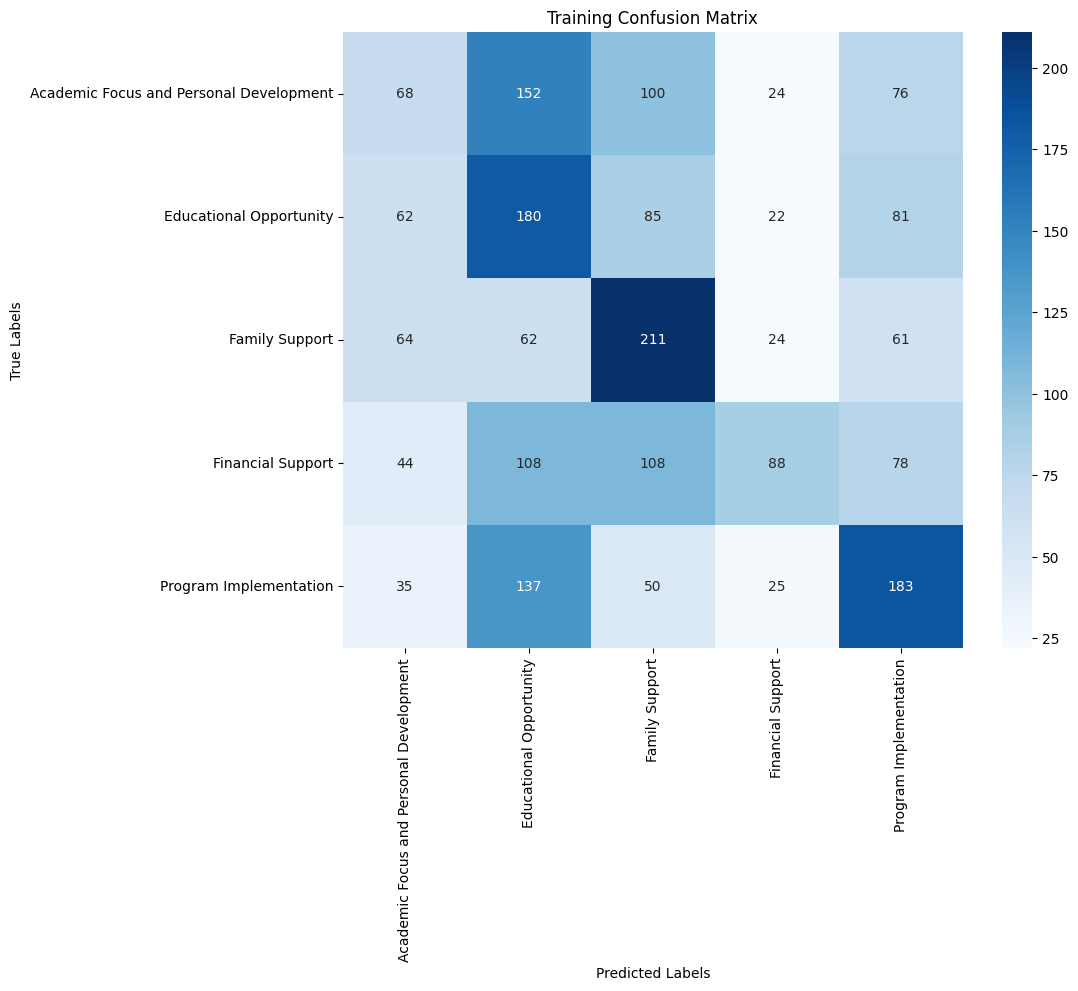

Epoch 1/1, Validation Loss: 47.0125789642334, Validation Accuracy: 0.4981203007518797
Validation Classification Report:
                                         precision    recall  f1-score   support

Academic Focus and Personal Development       0.71      0.24      0.36       112
                Educational Opportunity       0.36      0.44      0.40       102
                         Family Support       0.44      0.91      0.60       110
                      Financial Support       0.60      0.37      0.46       106
                 Program Implementation       0.68      0.53      0.59       102

                               accuracy                           0.50       532
                              macro avg       0.56      0.50      0.48       532
                           weighted avg       0.56      0.50      0.48       532



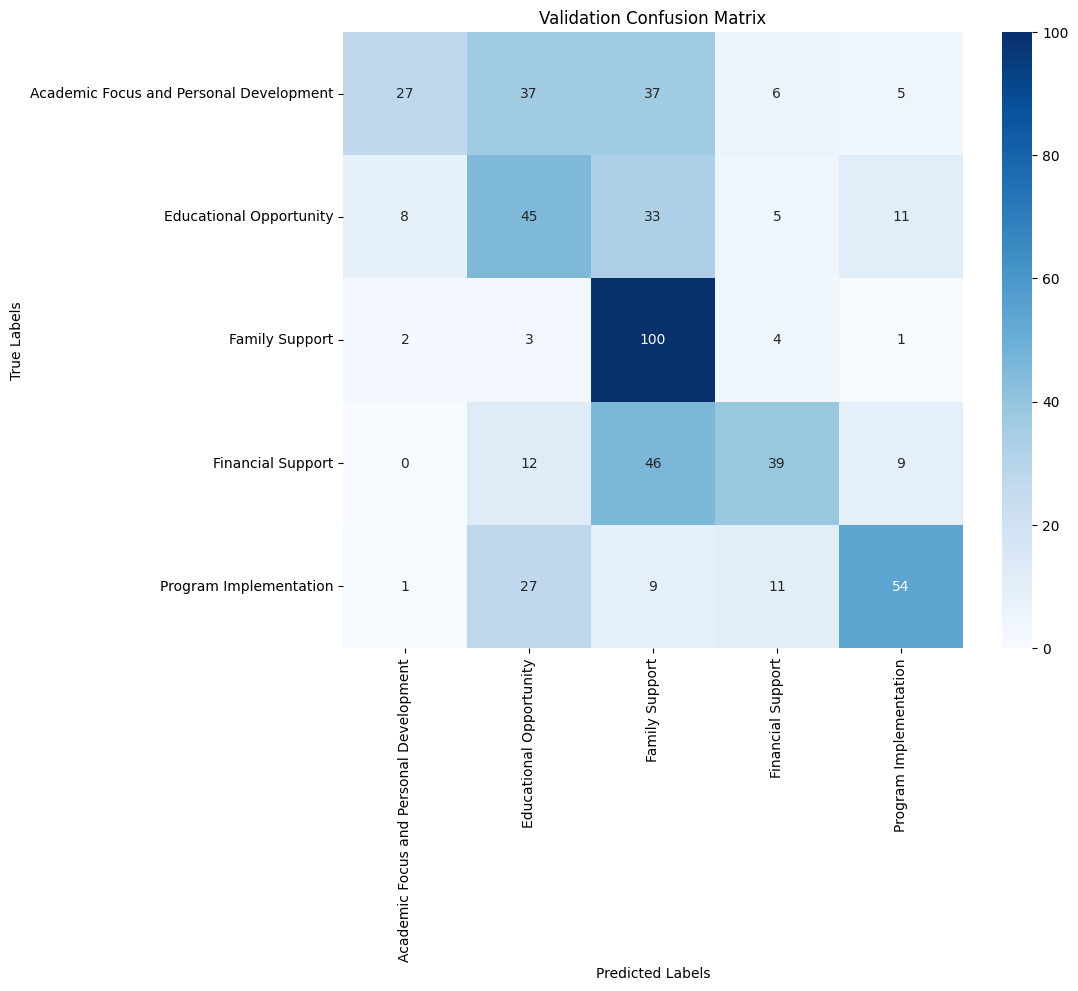

Test Classification Report:
                                         precision    recall  f1-score   support

Academic Focus and Personal Development       0.49      0.45      0.47       132
                Educational Opportunity       0.41      0.43      0.42       138
                         Family Support       0.81      0.81      0.81       133
                      Financial Support       0.55      0.47      0.51       130
                 Program Implementation       0.48      0.58      0.52       132

                               accuracy                           0.55       665
                              macro avg       0.55      0.55      0.55       665
                           weighted avg       0.55      0.55      0.55       665

Test Confusion Matrix:


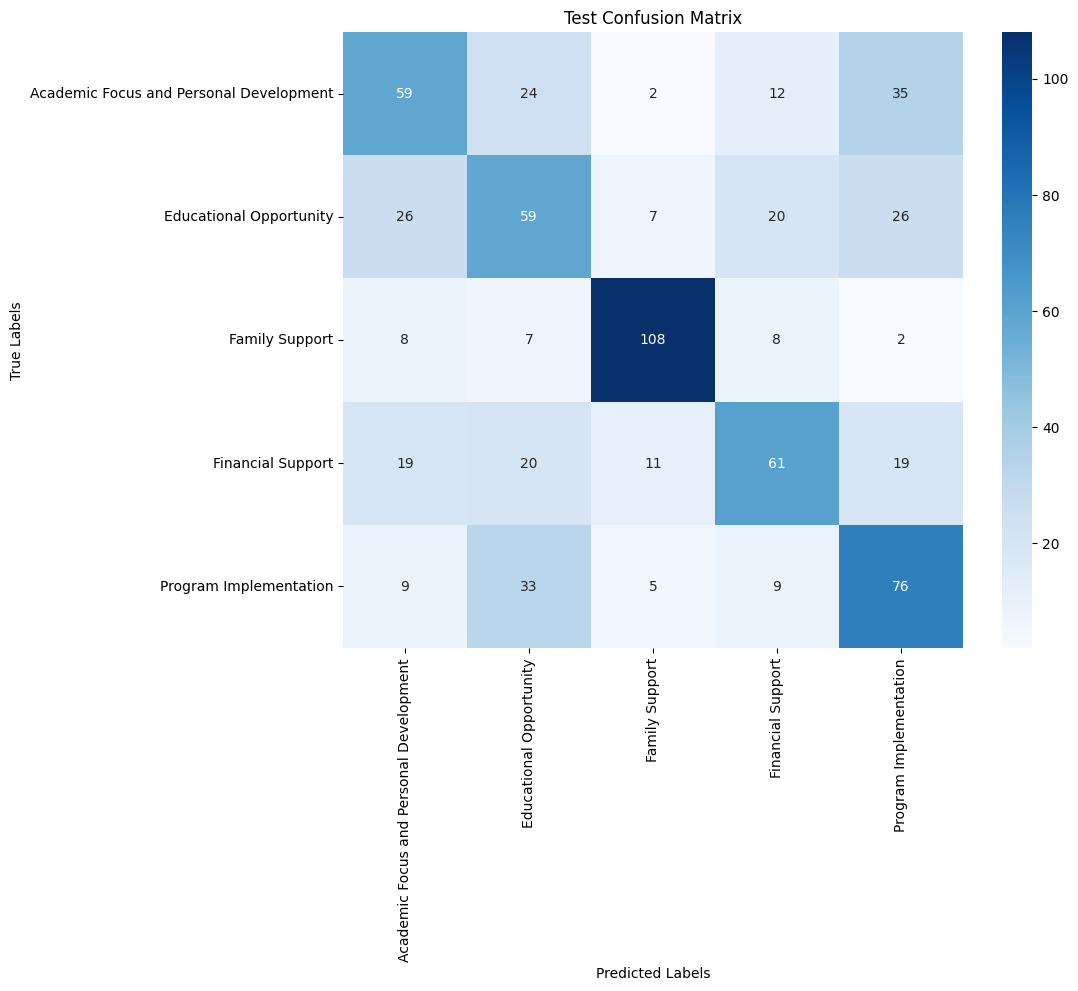

Predicted labels saved to /content/drive/MyDrive/Dissertation_UC/predicted.csv


In [ ]:
import pandas as pd
import numpy as np
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')  # Add this line to download the 'punkt' resource

# Load data
file_path = "/content/drive/MyDrive/Dissertation_UC/UAQTE_Experience_Multi_Class_TC_Datasets.csv"
df = pd.read_csv(file_path)

# Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Expand contractions
    text = ' '.join([contractions_dict.get(word, word) for word in text.split()])

    # Remove irrelevant characters, symbols, and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]

    # Join tokens back into a string
    text = ' '.join(tokens)

    return text

df['Processed_Response'] = df['Responses'].apply(preprocess_text)

# Print 10 preprocessed responses
print(df['Processed_Response'].head(10))

# Encode labels
label_encoder = LabelEncoder()
df['Encoded_Label'] = label_encoder.fit_transform(df['Label'])

# Split the data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_text(df, max_length=128):
    input_ids = []
    attention_masks = []

    for text in df['Processed_Response']:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt',
                            truncation=True
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

train_inputs, train_masks = tokenize_text(train_df)
val_inputs, val_masks = tokenize_text(val_df)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_df['Encoded_Label'].values)
val_labels = torch.tensor(val_df['Encoded_Label'].values)

# Create DataLoader for training and validation sets
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Fine-tune BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Add optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)
epochs = 1
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds_train = []
    all_labels_train = []

    for batch in train_dataloader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        preds = np.argmax(logits.detach().numpy(), axis=1)

        correct_predictions += np.sum(preds == labels.numpy())
        total_samples += len(labels)

        all_preds_train.extend(preds.tolist())
        all_labels_train.extend(labels.numpy().tolist())

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print average training loss and accuracy for the batch
        avg_train_loss = total_loss / (total_samples / batch_size)
        train_accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1}/{epochs}, Batch Loss: {loss.item()}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Training classification report
    train_classification_report = classification_report(all_labels_train, all_preds_train, target_names=label_encoder.classes_)
    print('Training Classification Report:')
    print(train_classification_report)

    # Training Confusion Matrix Heatmap
    train_confusion_matrix = confusion_matrix(all_labels_train, all_preds_train)
    plt.figure(figsize=(10, 8))
    sns.heatmap(train_confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title('Training Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Validation
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    for batch in val_dataloader:
        inputs, masks, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        val_loss += loss.item()

        preds = np.argmax(logits.detach().numpy(), axis=1)
        predictions.extend(preds)
        true_labels.extend(labels.numpy())

    # Calculate validation accuracy and other metrics
    val_accuracy = accuracy_score(true_labels, predictions)
    val_classification_report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)

    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
    print('Validation Classification Report:')
    print(val_classification_report)

    # Validation Confusion Matrix Heatmap
    val_conf_matrix = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title('Validation Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Test Classification Report
print('Test Classification Report:')
test_classification_report = classification_report(test_labels, test_predictions, target_names=label_encoder.classes_)
print(test_classification_report)

# Test Confusion Matrix
print('Test Confusion Matrix:')
test_confusion_matrix = confusion_matrix(test_labels, test_predictions)

# Display Confusion Matrix Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(test_confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Save predictions to a new CSV file
predicted_csv_path = "/content/drive/MyDrive/Dissertation_UC/predicted.csv"
test_df.to_csv(predicted_csv_path, index=False)

# Display a message indicating that the file has been saved
print(f'Predicted labels saved to {predicted_csv_path}')


In [ ]:
import pandas as pd
import numpy as np
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')  # Add this line to download the 'punkt' resource

# Load data
file_path = "/content/drive/MyDrive/Dissertation_UC/UAQTE_Experience_Multi_Class_TC_Datasets.csv"
df = pd.read_csv(file_path)

# Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Expand contractions
    text = ' '.join([contractions_dict.get(word, word) for word in text.split()])

    # Remove irrelevant characters, symbols, and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]

    # Join tokens back into a string
    text = ' '.join(tokens)

    return text

df['Processed_Response'] = df['Responses'].apply(preprocess_text)

# Encode labels
label_encoder = LabelEncoder()
df['Encoded_Label'] = label_encoder.fit_transform(df['Label'])

# Split the data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_text(df, max_length=128):
    input_ids = []
    attention_masks = []

    for text in df['Processed_Response']:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt',
                            truncation=True
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

train_inputs, train_masks = tokenize_text(train_df)
val_inputs, val_masks = tokenize_text(val_df)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_df['Encoded_Label'].values)
val_labels = torch.tensor(val_df['Encoded_Label'].values)

# Create DataLoader for training and validation sets
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Fine-tune BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Add optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)
epochs = 1
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Lists for learning curve
training_loss_values = []
training_accuracy_values = []
validation_loss_values = []
validation_accuracy_values = []

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds_train = []
    all_labels_train = []

    for batch in train_dataloader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        preds = np.argmax(logits.detach().numpy(), axis=1)

        correct_predictions += np.sum(preds == labels.numpy())
        total_samples += len(labels)

        all_preds_train.extend(preds.tolist())
        all_labels_train.extend(labels.numpy().tolist())

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print average training loss and accuracy for the batch
        avg_train_loss = total_loss / (total_samples / batch_size)
        train_accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1}/{epochs}, Batch Loss: {loss.item()}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Append training loss and accuracy for plotting
    training_loss_values.append(avg_train_loss)
    training_accuracy_values.append(train_accuracy)

    # Training classification report
    train_classification_report = classification_report(all_labels_train, all_preds_train, target_names=label_encoder.classes_)
    print('Training Classification Report:')
    print(train_classification_report)

    # Validation
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    for batch in val_dataloader:
        inputs, masks, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        val_loss += loss.item()

        preds = np.argmax(logits.detach().numpy(), axis=1)
        predictions.extend(preds)
        true_labels.extend(labels.numpy())

    # Calculate validation accuracy and other metrics
    val_accuracy = accuracy_score(true_labels, predictions)
    val_classification_report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)

    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
    print('Validation Classification Report:')
    print(val_classification_report)

    # Append validation loss and accuracy for plotting
    validation_loss_values.append(val_loss)
    validation_accuracy_values.append(val_accuracy)

# Plot learning curve
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), training_loss_values, label='Training Loss')
plt.plot(range(1, epochs + 1), validation_loss_values, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), training_accuracy_values, label='Training Accuracy')
plt.plot(range(1, epochs + 1), validation_accuracy_values, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# ... (rest of the code)

# Save predictions to a new CSV file
predicted_csv_path = "/content/drive/MyDrive/Dissertation_UC/predicted.csv"
test_df.to_csv(predicted_csv_path, index=False)

# Display a message indicating that the file has been saved
print(f'Predicted labels saved to {predicted_csv_path}')


In [ ]:
# Experiment 2 - BatchSize-16, Epoch-1, Learning Rate-1e-5
import pandas as pd
import numpy as np
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from bs4 import BeautifulSoup  # For removing HTML tags
from contractions import contractions_dict  # You may need to install the contractions library

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')  # Add this line to download the 'punkt' resource

# Load data
file_path = "/content/drive/MyDrive/Dissertation_UC/UAQTE_Experience_Multi_Class_TC_Datasets.csv"
df = pd.read_csv(file_path)

# Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Expand contractions
    text = ' '.join([contractions_dict.get(word, word) for word in text.split()])

    # Remove irrelevant characters, symbols, and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]

    # Join tokens back into a string
    text = ' '.join(tokens)

    return text

df['Processed_Response'] = df['Responses'].apply(preprocess_text)

# Print 10 preprocessed responses
print(df['Processed_Response'].head(10))

# Encode labels
label_encoder = LabelEncoder()
df['Encoded_Label'] = label_encoder.fit_transform(df['Label'])

# Split the data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_text(df, max_length=128):
    input_ids = []
    attention_masks = []

    for text in df['Processed_Response']:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt',
                            truncation=True
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

train_inputs, train_masks = tokenize_text(train_df)
val_inputs, val_masks = tokenize_text(val_df)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_df['Encoded_Label'].values)
val_labels = torch.tensor(val_df['Encoded_Label'].values)

# Create DataLoader for training and validation sets
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Fine-tune BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Add optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)
epochs = 5
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds_train = []
    all_labels_train = []

    for batch in train_dataloader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        preds = np.argmax(logits.detach().numpy(), axis=1)

        correct_predictions += np.sum(preds == labels.numpy())
        total_samples += len(labels)

        all_preds_train.extend(preds.tolist())
        all_labels_train.extend(labels.numpy().tolist())

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print average training loss and accuracy for the batch
        avg_train_loss = total_loss / (total_samples / batch_size)
        train_accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1}/{epochs}, Batch Loss: {loss.item()}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Training classification report
    train_classification_report = classification_report(all_labels_train, all_preds_train, target_names=label_encoder.classes_)
    print('Training Classification Report:')
    print(train_classification_report)

    # Validation
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    for batch in val_dataloader:
        inputs, masks, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        val_loss += loss.item()

        preds = np.argmax(logits.detach().numpy(), axis=1)
        predictions.extend(preds)
        true_labels.extend(labels.numpy())

    # Calculate validation accuracy and other metrics
    val_accuracy = accuracy_score(true_labels, predictions)
    val_classification_report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)

    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
    print('Validation Classification Report:')
    print(val_classification_report)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-3-9bf8900963d2>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


0    focused studying much think could pay tuition fee
1            also helped become responsible many thing
2    every student help make thier dream become pos...
3           became serious studying fail graduate time
4    experience free funded material module make st...
5      program made possible continue studying college
6      scholarship serve stepping stone onward success
7    help finish study without worrying tuition als...
8    need worry financial expense allowance tuition...
9    one beneficiary made lot enthusiastic came cla...
Name: Processed_Response, dtype: object


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5, Batch Loss: 1.7436939477920532, Average Training Loss: 1.7436939477920532, Training Accuracy: 0.0625
Epoch 1/5, Batch Loss: 1.6738414764404297, Average Training Loss: 1.7087677121162415, Training Accuracy: 0.09375
Epoch 1/5, Batch Loss: 1.7549196481704712, Average Training Loss: 1.7241516908009846, Training Accuracy: 0.125
Epoch 1/5, Batch Loss: 1.7528128623962402, Average Training Loss: 1.7313169836997986, Training Accuracy: 0.125
Epoch 1/5, Batch Loss: 1.7564626932144165, Average Training Loss: 1.7363461256027222, Training Accuracy: 0.1375
Epoch 1/5, Batch Loss: 1.646247386932373, Average Training Loss: 1.721329669157664, Training Accuracy: 0.14583333333333334
Epoch 1/5, Batch Loss: 1.5331155061721802, Average Training Loss: 1.6944419315883092, Training Accuracy: 0.17857142857142858
Epoch 1/5, Batch Loss: 1.5543948411941528, Average Training Loss: 1.6769360452890396, Training Accuracy: 0.1796875
Epoch 1/5, Batch Loss: 1.5526422262191772, Average Training Loss: 1.6631256209

In [ ]:
# Experiment 2 - BatchSize-16, Epoch-1, Learning Rate-1e-5
import pandas as pd
import numpy as np
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from bs4 import BeautifulSoup  # For removing HTML tags
from contractions import contractions_dict  # You may need to install the contractions library

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')  # Add this line to download the 'punkt' resource

# Load data
file_path = "/content/drive/MyDrive/Dissertation_UC/UAQTE_Experience_Multi_Class_TC_Datasets.csv"
df = pd.read_csv(file_path)

# Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Expand contractions
    text = ' '.join([contractions_dict.get(word, word) for word in text.split()])

    # Remove irrelevant characters, symbols, and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization and lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]

    # Join tokens back into a string
    text = ' '.join(tokens)

    return text

df['Processed_Response'] = df['Responses'].apply(preprocess_text)

# Print 10 preprocessed responses
print(df['Processed_Response'].head(10))

# Encode labels
label_encoder = LabelEncoder()
df['Encoded_Label'] = label_encoder.fit_transform(df['Label'])

# Split the data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize_text(df, max_length=128):
    input_ids = []
    attention_masks = []

    for text in df['Processed_Response']:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt',
                            truncation=True
                       )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

train_inputs, train_masks = tokenize_text(train_df)
val_inputs, val_masks = tokenize_text(val_df)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_df['Encoded_Label'].values)
val_labels = torch.tensor(val_df['Encoded_Label'].values)

# Create DataLoader for training and validation sets
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Fine-tune BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Add optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=3e-5, eps=1e-8)
epochs = 5
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_preds_train = []
    all_labels_train = []

    for batch in train_dataloader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        preds = np.argmax(logits.detach().numpy(), axis=1)

        correct_predictions += np.sum(preds == labels.numpy())
        total_samples += len(labels)

        all_preds_train.extend(preds.tolist())
        all_labels_train.extend(labels.numpy().tolist())

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print average training loss and accuracy for the batch
        avg_train_loss = total_loss / (total_samples / batch_size)
        train_accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1}/{epochs}, Batch Loss: {loss.item()}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}')

    # Training classification report
    train_classification_report = classification_report(all_labels_train, all_preds_train, target_names=label_encoder.classes_)
    print('Training Classification Report:')
    print(train_classification_report)

    # Validation
    model.eval()
    val_loss = 0
    predictions, true_labels = [], []

    for batch in val_dataloader:
        inputs, masks, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        val_loss += loss.item()

        preds = np.argmax(logits.detach().numpy(), axis=1)
        predictions.extend(preds)
        true_labels.extend(labels.numpy())

    # Calculate validation accuracy and other metrics
    val_accuracy = accuracy_score(true_labels, predictions)
    val_classification_report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)

    print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
    print('Validation Classification Report:')
    print(val_classification_report)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
<ipython-input-2-09abf8dd2c32>:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


0    focused studying much think could pay tuition fee
1            also helped become responsible many thing
2    every student help make thier dream become pos...
3           became serious studying fail graduate time
4    experience free funded material module make st...
5      program made possible continue studying college
6      scholarship serve stepping stone onward success
7    help finish study without worrying tuition als...
8    need worry financial expense allowance tuition...
9    one beneficiary made lot enthusiastic came cla...
Name: Processed_Response, dtype: object


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5, Batch Loss: 1.6769754886627197, Average Training Loss: 1.6769754886627197, Training Accuracy: 0.1875
Epoch 1/5, Batch Loss: 1.6358132362365723, Average Training Loss: 1.656394362449646, Training Accuracy: 0.21875
Epoch 1/5, Batch Loss: 1.5802961587905884, Average Training Loss: 1.6310282945632935, Training Accuracy: 0.22916666666666666
Epoch 1/5, Batch Loss: 1.5881954431533813, Average Training Loss: 1.6203200817108154, Training Accuracy: 0.25
Epoch 1/5, Batch Loss: 1.6106387376785278, Average Training Loss: 1.618383812904358, Training Accuracy: 0.2125
Epoch 1/5, Batch Loss: 1.6772931814193726, Average Training Loss: 1.6282020409901936, Training Accuracy: 0.19791666666666666
Epoch 1/5, Batch Loss: 1.632022738456726, Average Training Loss: 1.628747854913984, Training Accuracy: 0.20535714285714285
Epoch 1/5, Batch Loss: 1.6486637592315674, Average Training Loss: 1.631237342953682, Training Accuracy: 0.1875
Epoch 1/5, Batch Loss: 1.5774606466293335, Average Training Loss: 1.625